In [2]:
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA, KernelPCA

import sys
sys.path.insert(0, '../Libraries_Paper/libraries/Osc_libraries')
import utils

from sklearn import manifold
import seaborn as sns
from matplotlib.ticker import NullFormatter
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

import math

In [3]:
df_MR = pd.read_csv('../df_to_load/databases27092021/dfTFMFinalv6.csv')

df_individualMRGerm = df_MR[['Admissiondboid', 'Started', 'Ended', 'DateOfCulture', 'MR']].drop_duplicates()
df_individualMRGerm.Started = pd.to_datetime(df_individualMRGerm.Started, utc=True)
df_individualMRGerm.DateOfCulture = pd.to_datetime(df_individualMRGerm.DateOfCulture, utc=True)

df_individualMRGerm["days_to_culture"] = df_individualMRGerm.DateOfCulture - df_individualMRGerm.Started
df_individualMRGerm["days_to_culture"] = df_individualMRGerm["days_to_culture"].dt.total_seconds() / 3600

len(df_individualMRGerm.Admissiondboid.unique())

4210

In [4]:
df_patients_MR = df_individualMRGerm[df_individualMRGerm.MR == 1.0]
df_patients_MR = df_patients_MR.groupby(['Admissiondboid', 'days_to_culture'], as_index=False).first()
df_patients_MR = df_patients_MR.drop_duplicates(['Admissiondboid'], keep='first')

In [5]:
df_new = pd.read_csv("../df_to_load/Modelado_1/Datos_Originales/df_PreCovid.csv")
df_aux_MR = pd.merge(df_new, df_patients_MR[['Admissiondboid', 'days_to_culture']]).drop_duplicates()
df_aux_MR

Admissiondboid  dayToDone  AMG  ATF  CAR  CF1  CF2  CF3  CF4  \
0     4275520198590018556          0    0    0    0    0    0    0    0   
1     4275520198590018556          1    0    0    0    0    0    0    0   
2     4275520198590018556          2    0    0    0    0    0    0    0   
3     4275520198590018556          3    0    0    0    0    0    0    0   
4     4275520198590018556          4    0    0    0    0    0    0    0   
...                   ...        ...  ...  ...  ...  ...  ...  ...  ...   
4174  4777321436414384556          2    0    0    0    0    0    0    0   
4175  4777321436414384556          3    0    0    0    0    0    0    0   
4176  4777321436414384556          4    0    0    0    0    0    0    0   
4177  4777321436414384556          5    0    0    0    0    0    0    0   
4178  4777321436414384556          6    0    0    0    0    0    1    0   

      Falta  ...  patientMON  patientGCC  patientTTC  patientOTR  patientLIP  \
0         0  ...           0           0           0           0           0   
1         0  ...           0           0           0           0           0   
2         0  ...           0           0           0           0           0   
3         0  ...           0           0           0           0           0   
4         0  ...           0           0           0           0           0   
...     ...  ...         ...         ...         ...         ...         ...   
4174      0  ...           0           0           0           0           0   
4175      0  ...           0           0           0           0           0   
4176      0  ...           0           0           0           0           0   
4177      0  ...           0           0           0           0           0   
4178      0  ...           0           0           0           0           0   

      patientCF2  inventedMask   MR  DaysOfStay  days_to_culture  
0              0             0  1.0           3        62.328333  
1              0             0  1.0           3        62.328333  
2              0             0  1.0           3        62.328333  
3              0             0  1.0           3        62.328333  
4              0             1  1.0           3        62.328333  
...          ...           ...  ...         ...              ...  
4174           0             0  1.0           3         1.094504  
4175           0             0  1.0           3         1.094504  
4176           0             0  1.0           3         1.094504  
4177           0             0  1.0           3         1.094504  
4178           0             1  1.0           3         1.094504  

[4179 rows x 55 columns]

In [40]:
df_new = pd.read_csv("../df_to_load/Modelado_1/Datos_Originales/df_PreCovid.csv")

print("Information new dataset: ")
print("Nº pat: ", df_new.shape[0]/7)
print("\tMDR: ", df_aux_MR[df_aux_MR['MR'] == 1].shape[0]/7)
print("\t\tMDR<48h: ", df_aux_MR[(df_aux_MR['MR'] == 1) & (df_aux_MR['days_to_culture'] <= 48)].shape[0]/7)
print("\t\tMDR>48h: ", df_aux_MR[(df_aux_MR['MR'] == 1) & (df_aux_MR['days_to_culture'] > 48)].shape[0]/7)
print("\tNo-MDR: ", df_new[df_new['MR'] == 0].shape[0]/7)

Information new dataset: 
Nº pat:  3310.0
	MDR:  597.0
		MDR<48h:  255.0
		MDR>48h:  342.0
	No-MDR:  2713.0


## Obtain the statistics: mean, median, standard deviation, min, max and entropy.

In [7]:
def getDistribution(df):
    print(df.isnull().values.any())
    features = df.keys()
    for i in range(df.shape[1]):
        print("Feature: ", features[i])
        print(df.isnull().values.any())
        plt.figure(df[features[i]].isnull().values.any())
        df.hist(column=features[i])
        plt.show()
        plt.figure()
        df.boxplot(column=[features[i]])

# Mean/frequency

In [8]:
numTimeStep = 7
hoursPerTimeStep = 24
df_both = pd.read_csv("../df_to_load/Modelado_1/Datos_Originales/df_PreCovid.csv")

df_both_aux = df_both.drop(['Admissiondboid', 'dayToDone', 'MR'],axis=1)
keys = df_both_aux.keys()
mat = np.zeros((int(df_both_aux.shape[0]/numTimeStep), len(keys)))
inf = 0
sup = numTimeStep-1
for index in range(int(df_both_aux.shape[0]/numTimeStep)):
    div = math.ceil(df_both_aux.loc[inf:sup, ['inventedMask']].sum())
    #if div <= 2:
        #print(inf, " - ", sup)
        #print(div)
    for i in range(len(keys)):
        mat[index,i] = df_both.loc[inf:sup, :][keys[i]].sum()/div   
    inf = sup + 1 
    sup += numTimeStep
    
df_mean = pd.DataFrame(mat)

new_names = []
for i in range(len(keys)):
    new_names.append(keys[i]+str("_mean"))
    
df_mean.columns = new_names

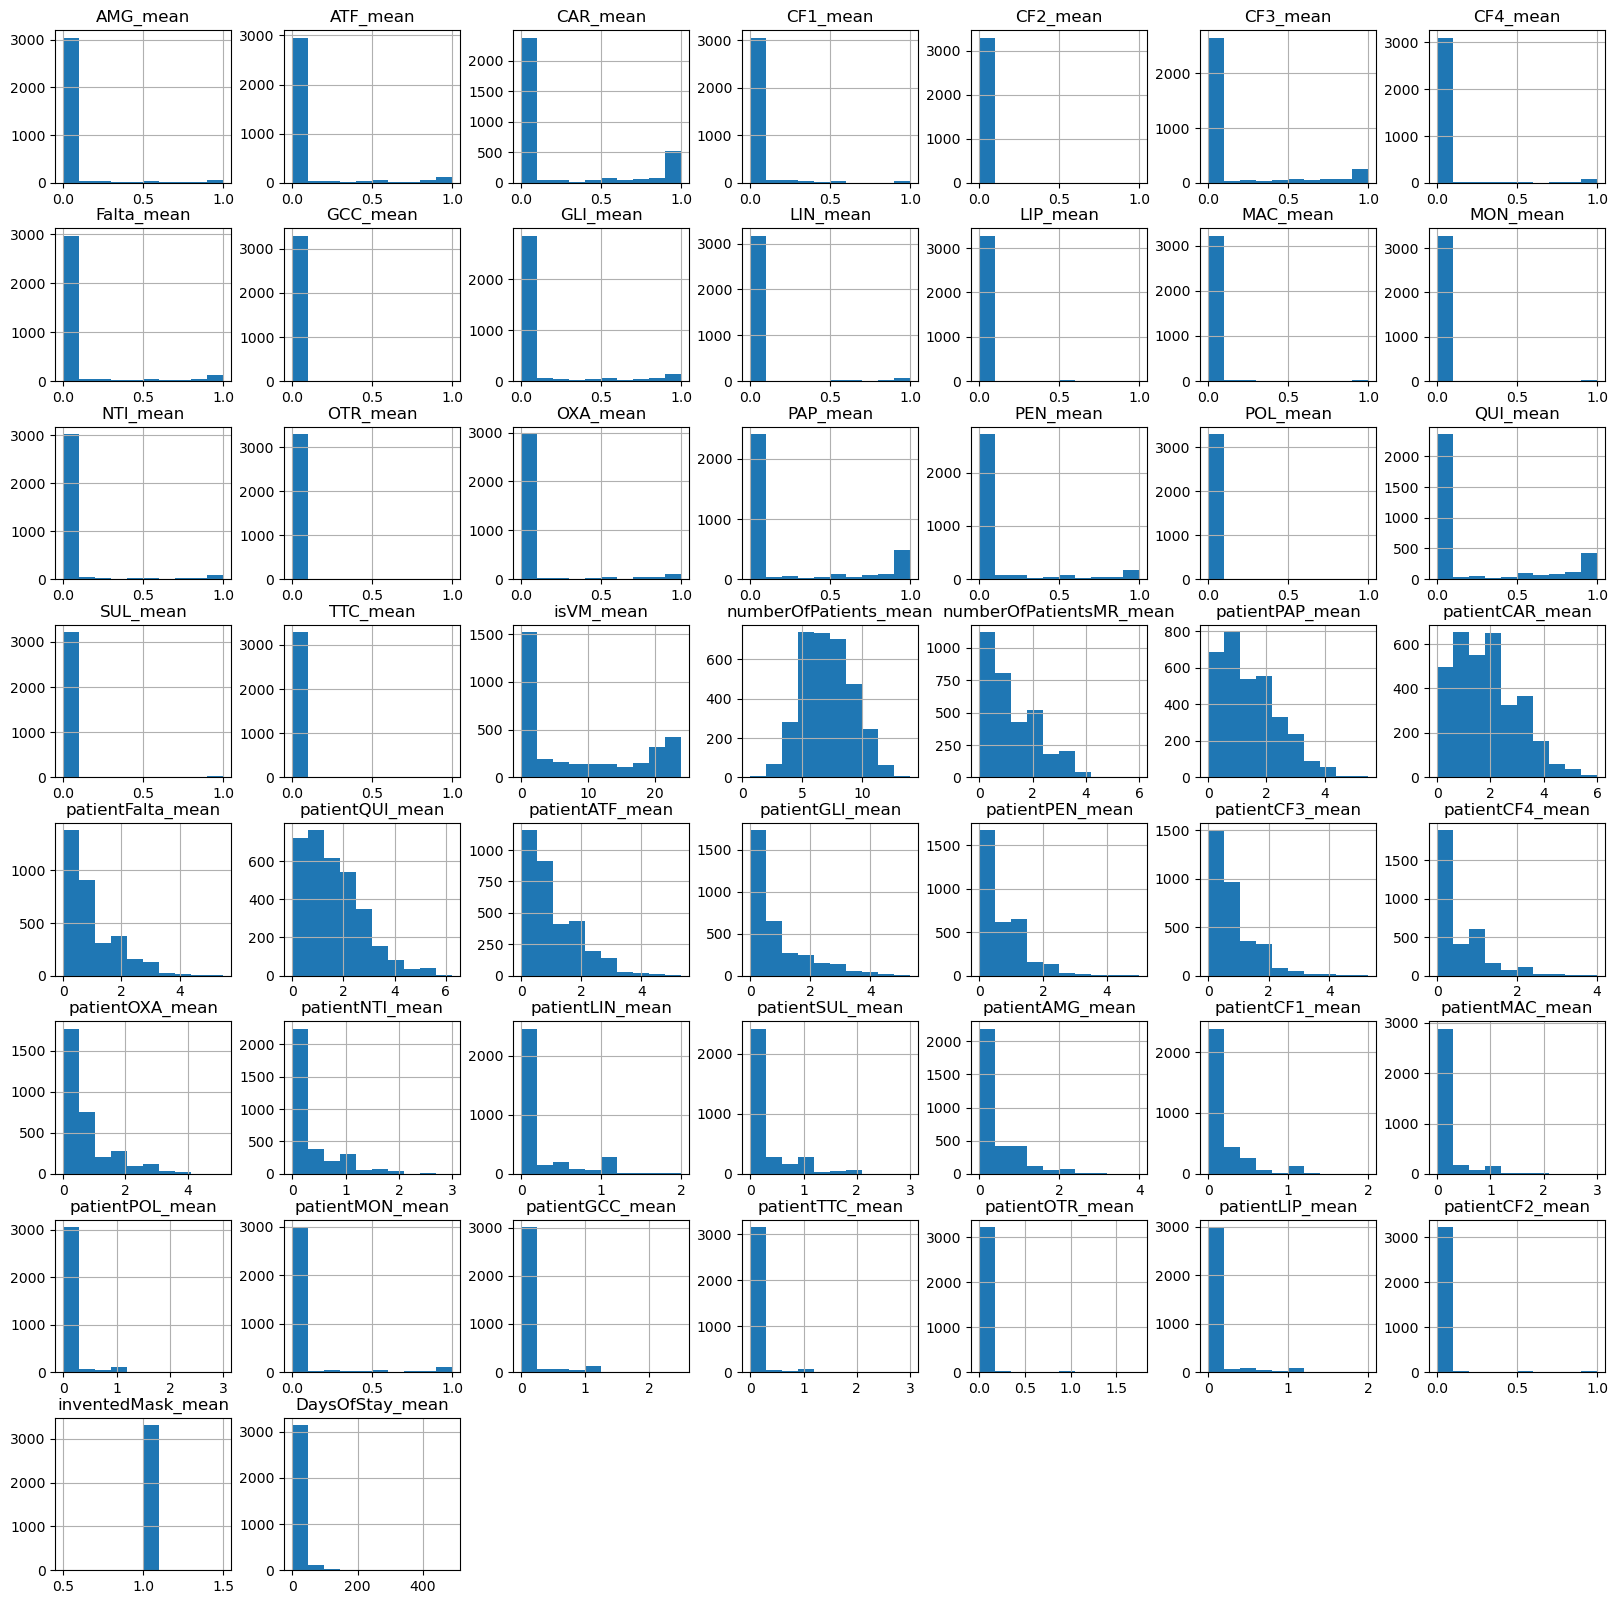

In [9]:
_ = df_mean.hist(figsize=(20,20))

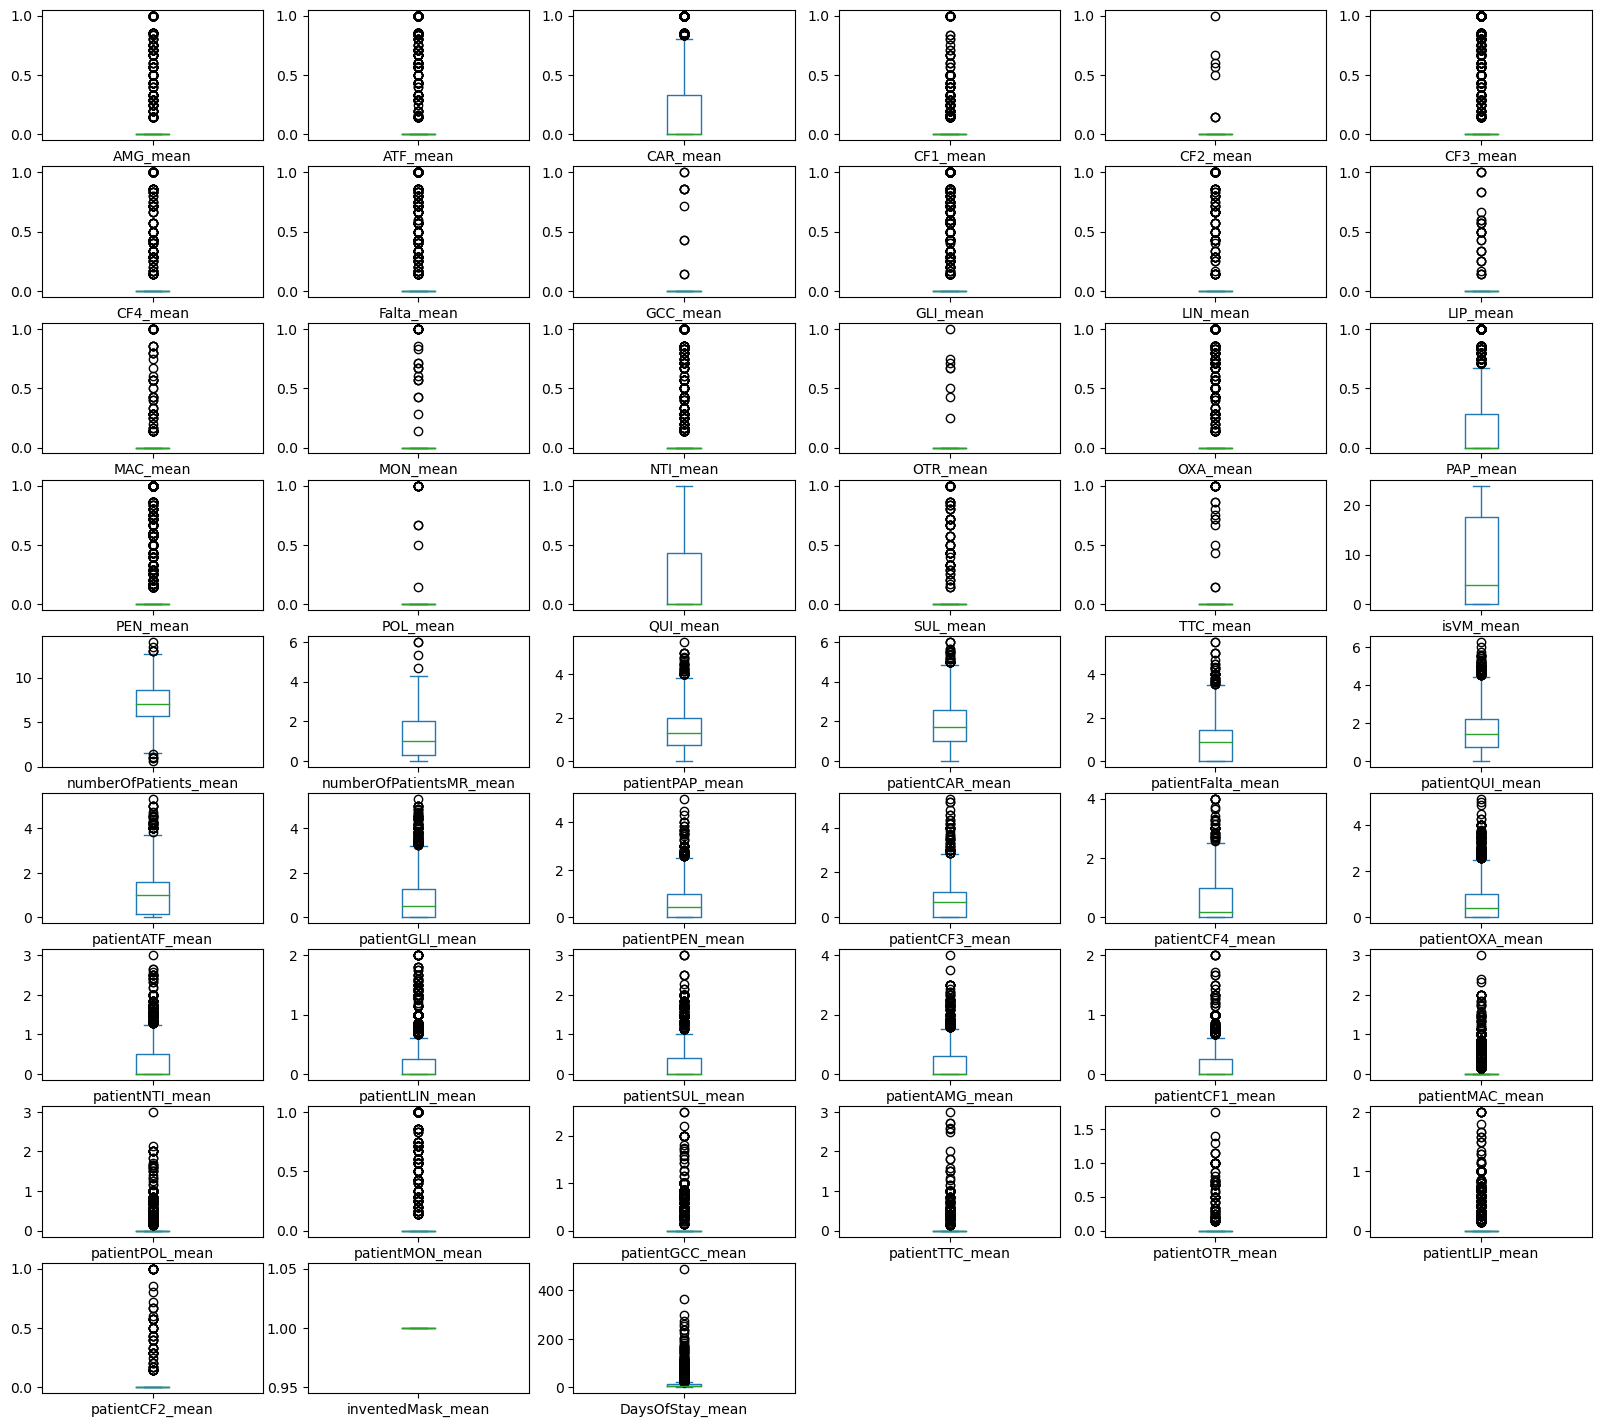

In [10]:
_ = df_mean.plot(kind='box', subplots=True, layout = (10,6), figsize=(20,20))

False
Feature:  AMG_mean
False


<Figure size 640x480 with 0 Axes>

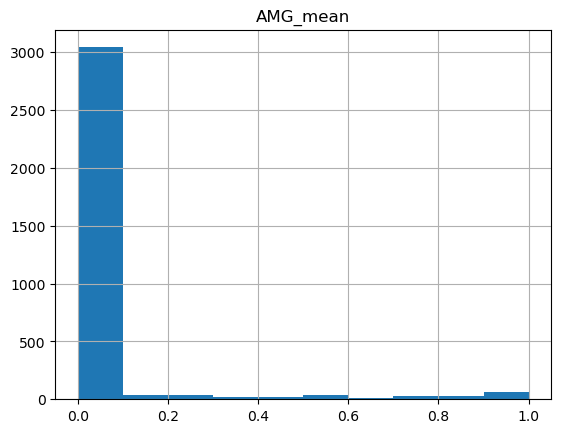

Feature:  ATF_mean
False


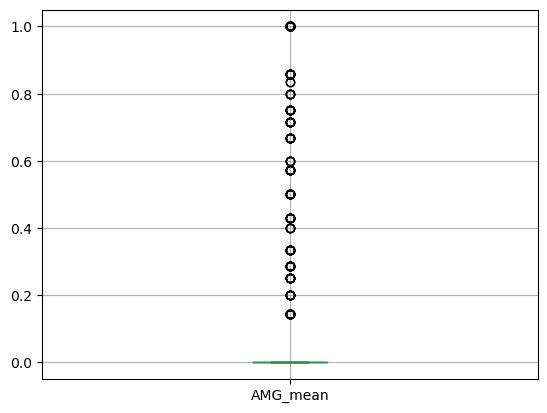

<Figure size 640x480 with 0 Axes>

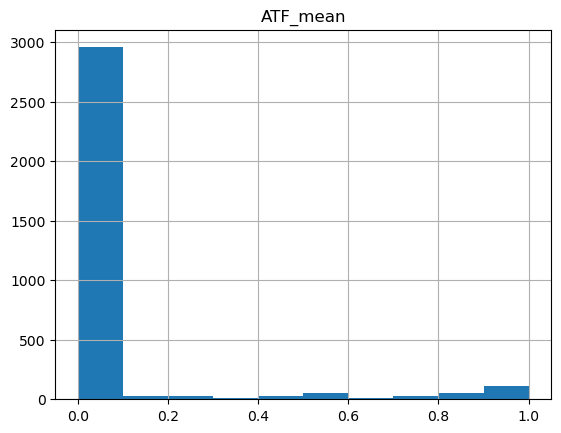

Feature:  CAR_mean
False


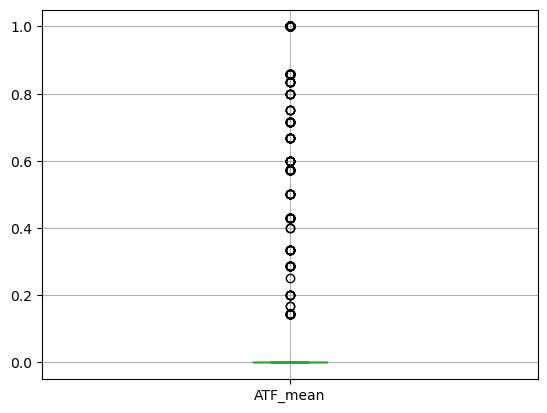

<Figure size 640x480 with 0 Axes>

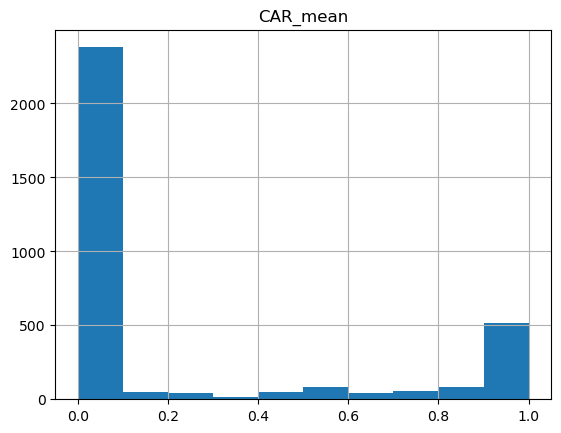

Feature:  CF1_mean
False


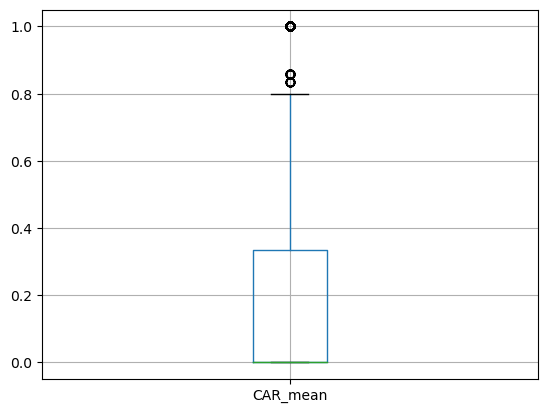

<Figure size 640x480 with 0 Axes>

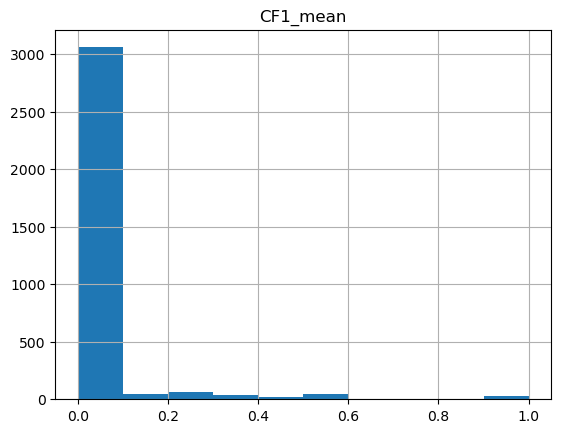

Feature:  CF2_mean
False


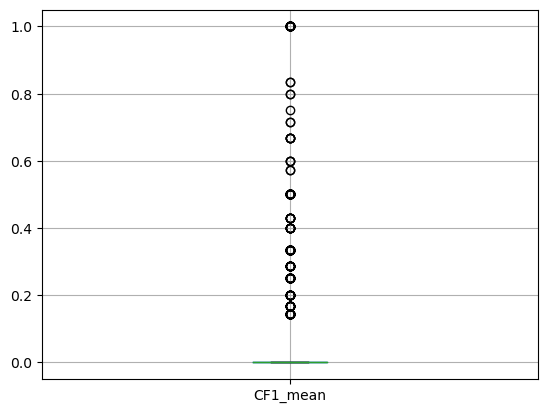

<Figure size 640x480 with 0 Axes>

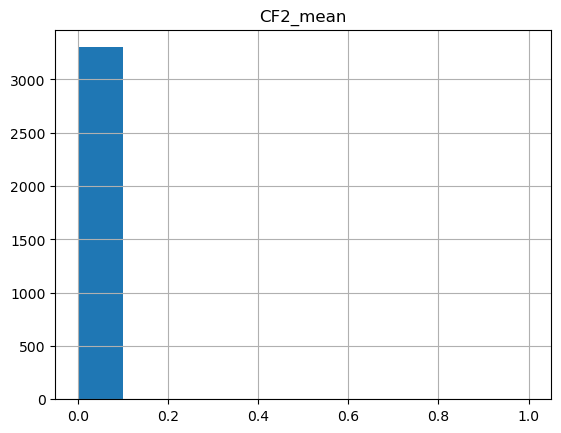

Feature:  CF3_mean
False


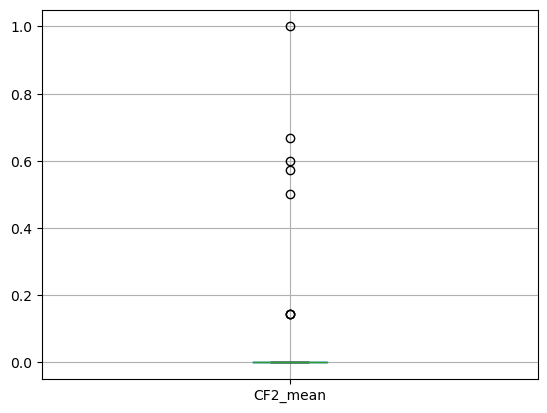

<Figure size 640x480 with 0 Axes>

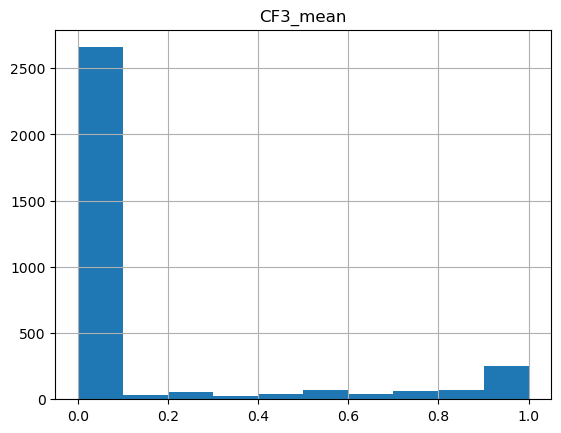

Feature:  CF4_mean
False


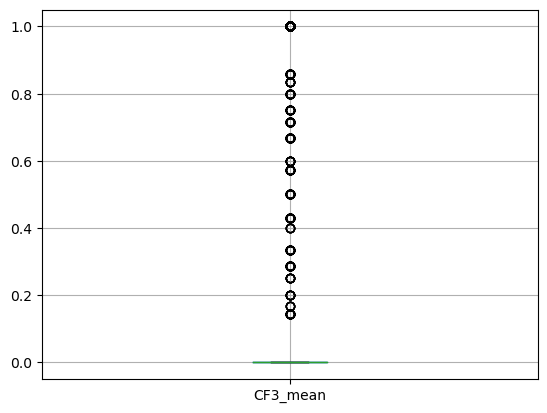

<Figure size 640x480 with 0 Axes>

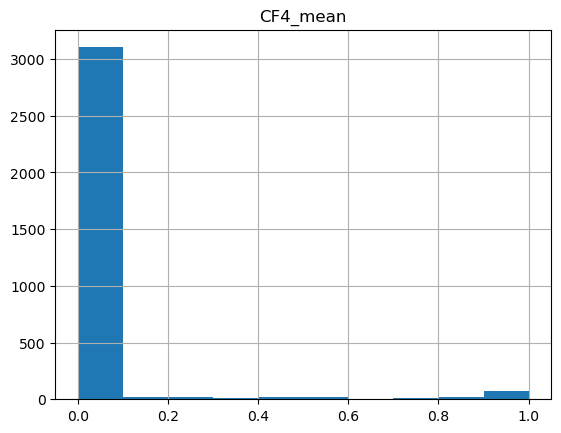

Feature:  Falta_mean
False


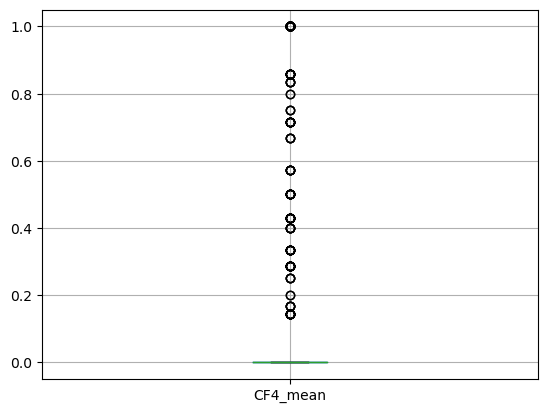

<Figure size 640x480 with 0 Axes>

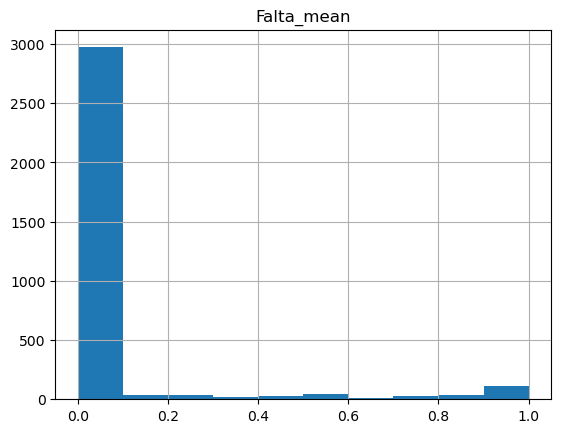

Feature:  GCC_mean
False


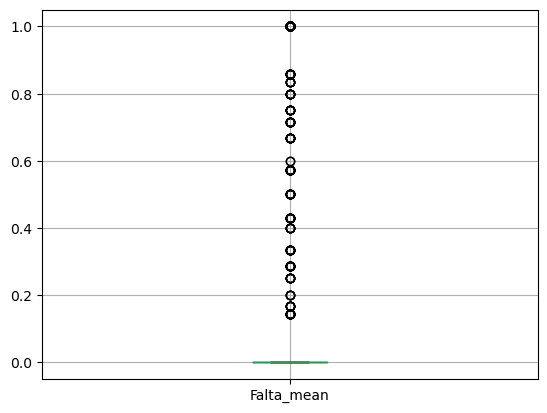

<Figure size 640x480 with 0 Axes>

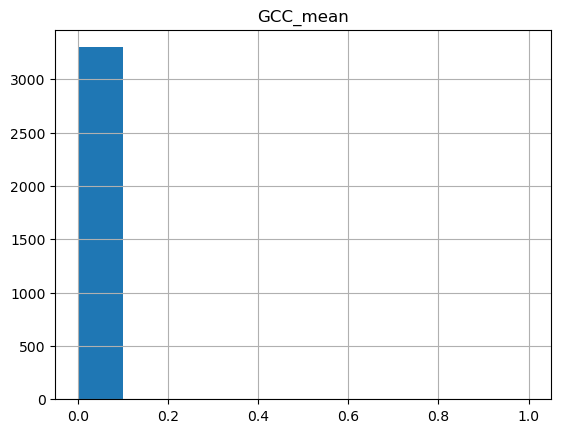

Feature:  GLI_mean
False


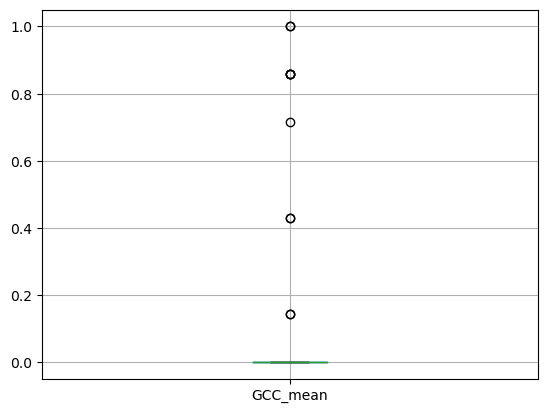

<Figure size 640x480 with 0 Axes>

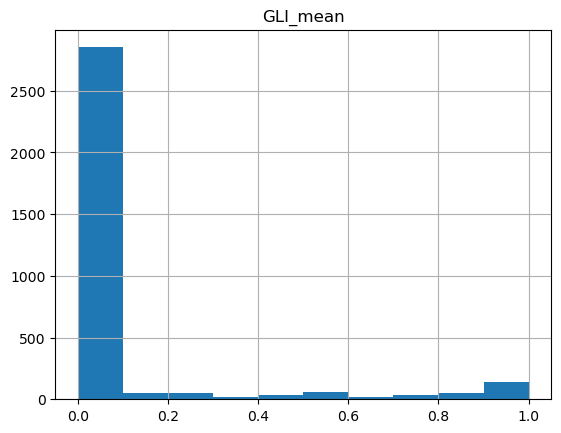

Feature:  LIN_mean
False


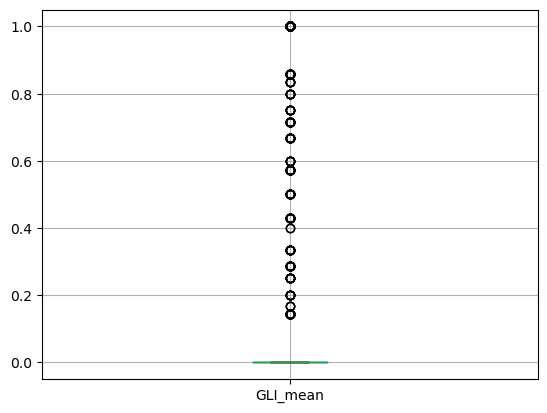

<Figure size 640x480 with 0 Axes>

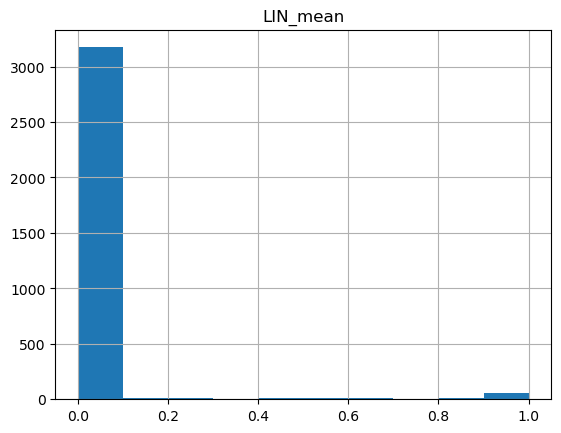

Feature:  LIP_mean
False


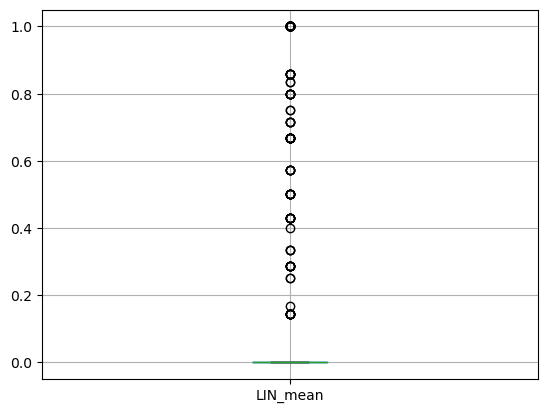

<Figure size 640x480 with 0 Axes>

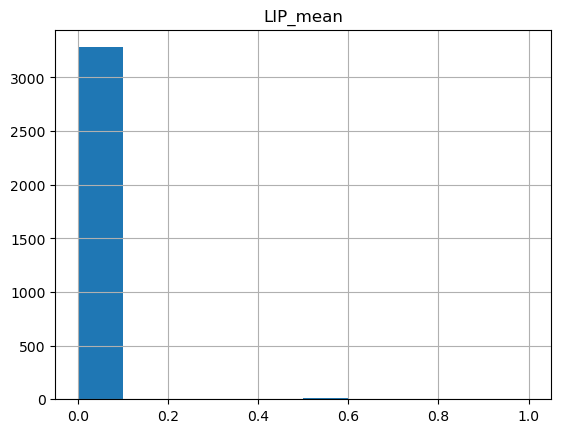

Feature:  MAC_mean
False


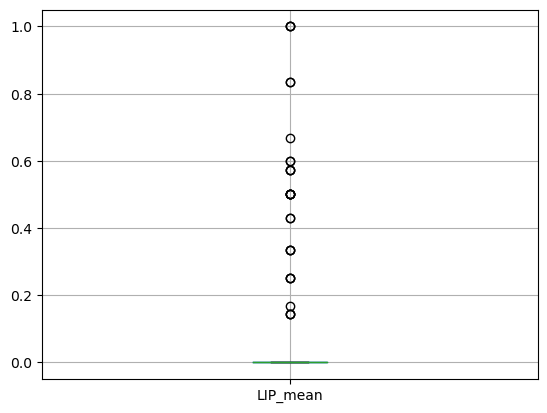

<Figure size 640x480 with 0 Axes>

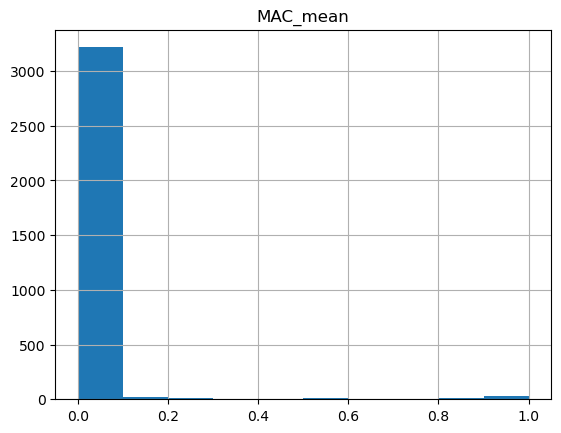

Feature:  MON_mean
False


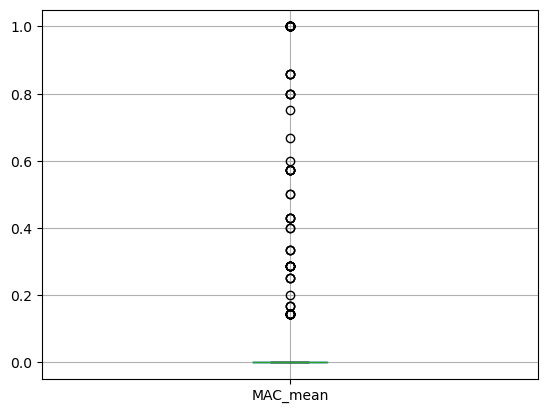

<Figure size 640x480 with 0 Axes>

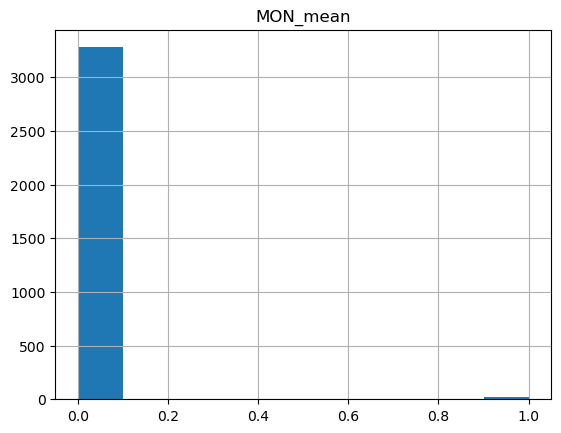

Feature:  NTI_mean
False


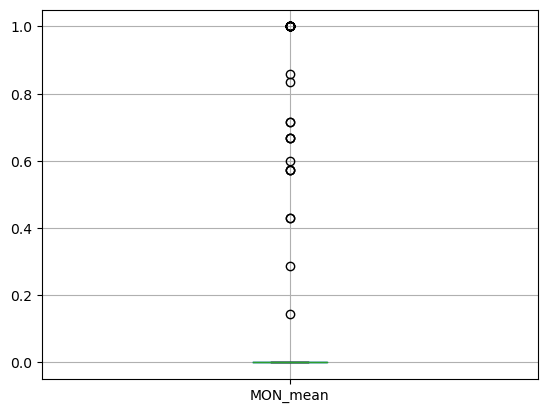

<Figure size 640x480 with 0 Axes>

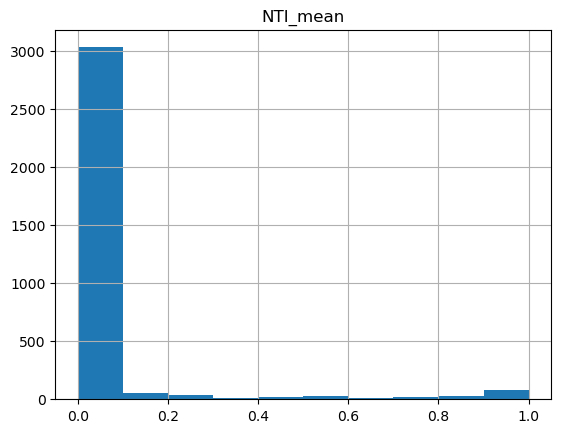

Feature:  OTR_mean
False


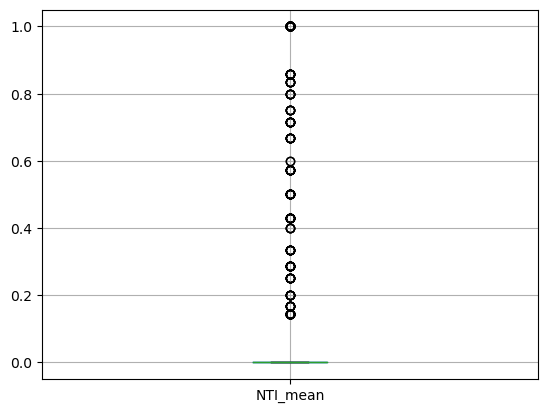

<Figure size 640x480 with 0 Axes>

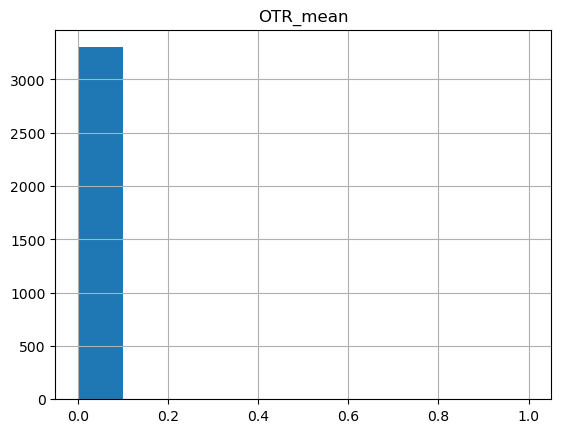

Feature:  OXA_mean
False


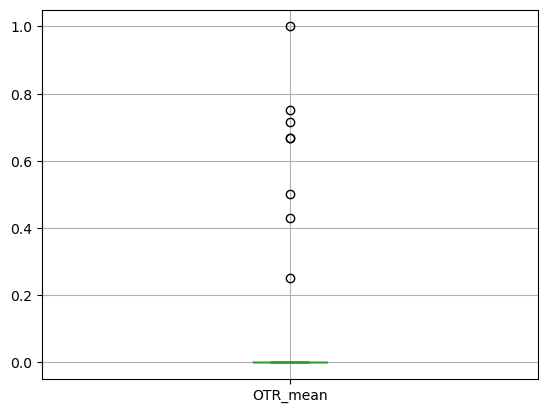

<Figure size 640x480 with 0 Axes>

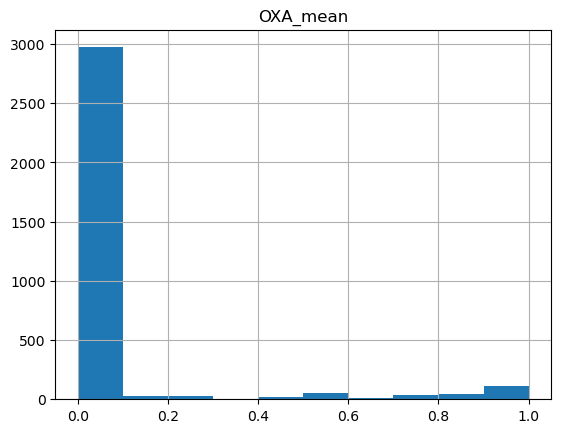

Feature:  PAP_mean
False


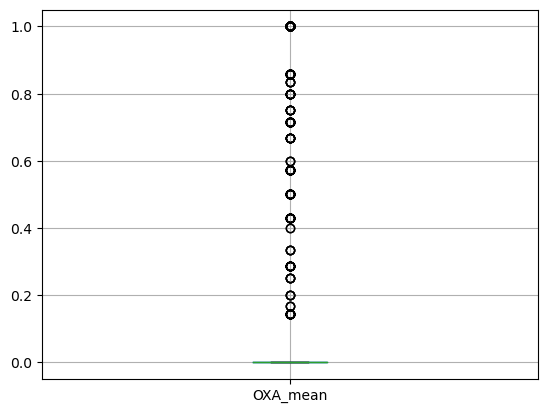

<Figure size 640x480 with 0 Axes>

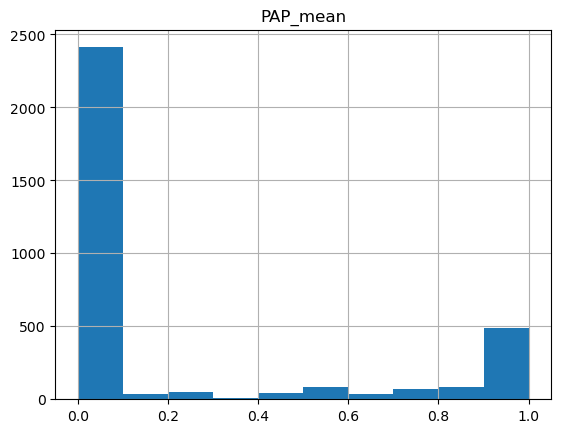

Feature:  PEN_mean
False


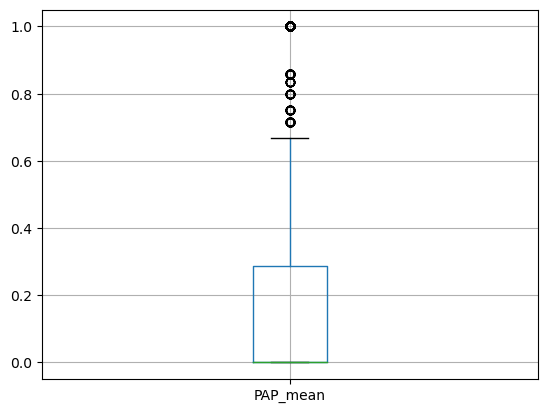

<Figure size 640x480 with 0 Axes>

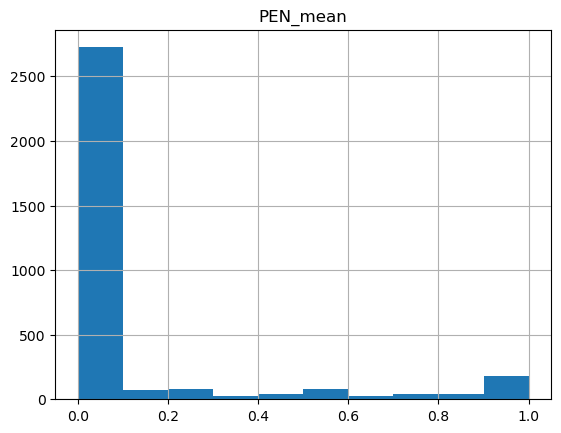

Feature:  POL_mean
False


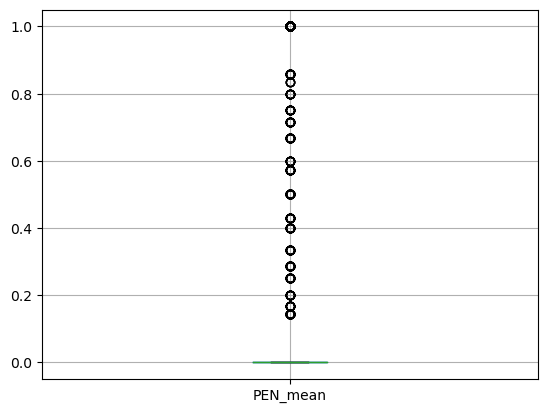

<Figure size 640x480 with 0 Axes>

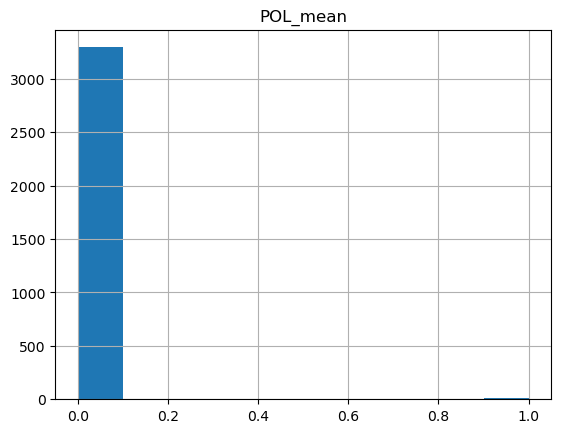

Feature:  QUI_mean
False


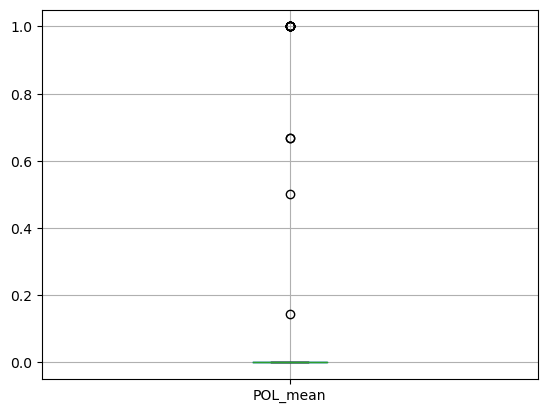

<Figure size 640x480 with 0 Axes>

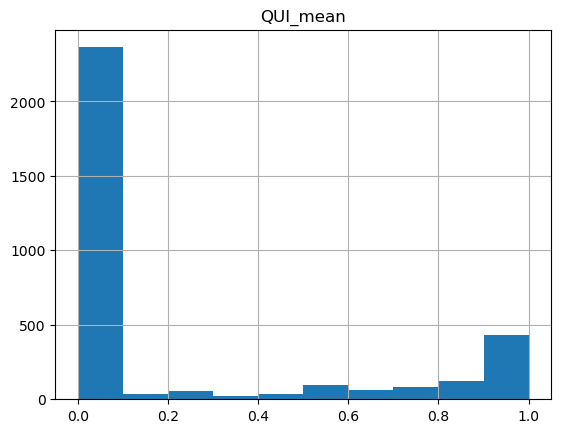

Feature:  SUL_mean
False


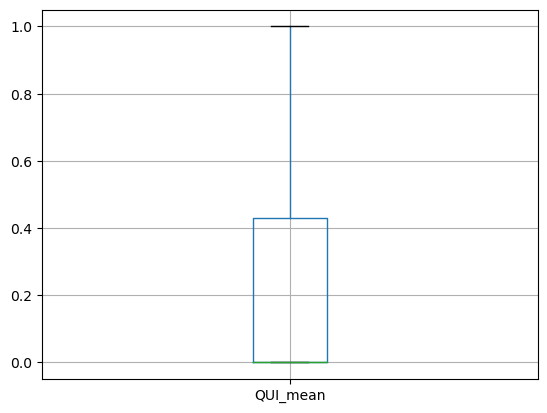

<Figure size 640x480 with 0 Axes>

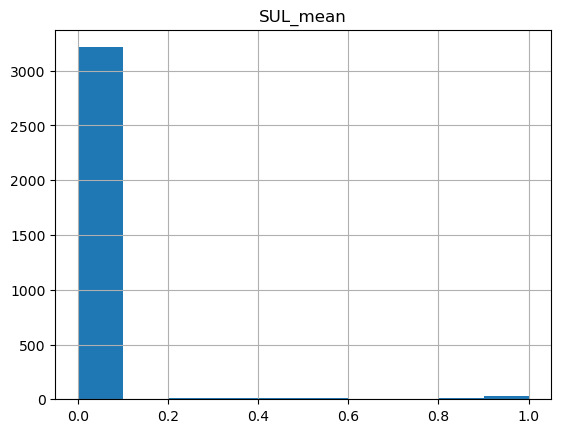

Feature:  TTC_mean
False


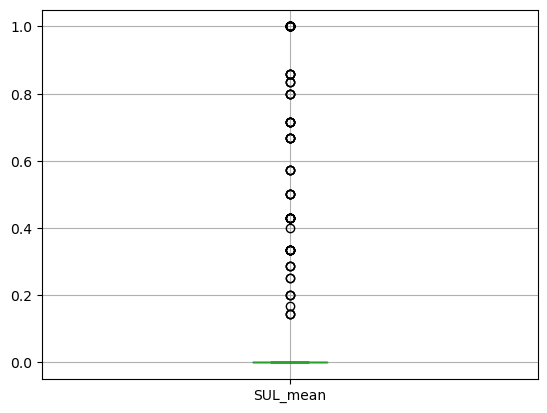

<Figure size 640x480 with 0 Axes>

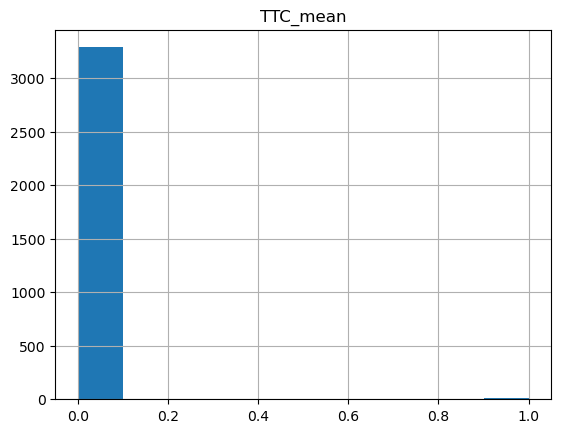

Feature:  isVM_mean
False


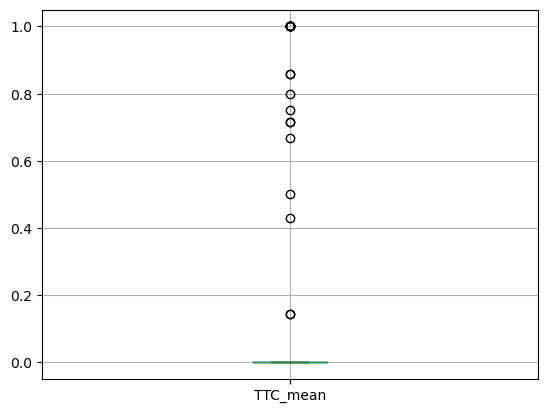

<Figure size 640x480 with 0 Axes>

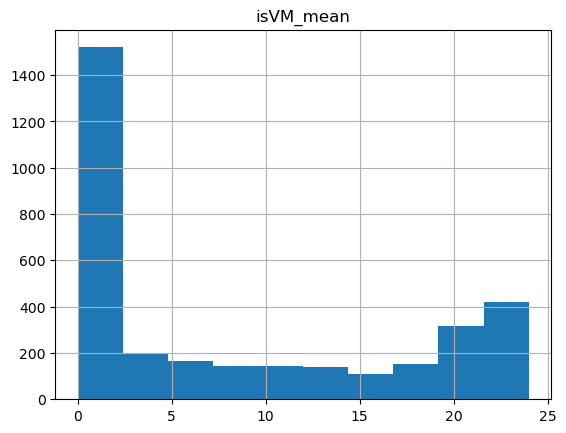

Feature:  numberOfPatients_mean
False


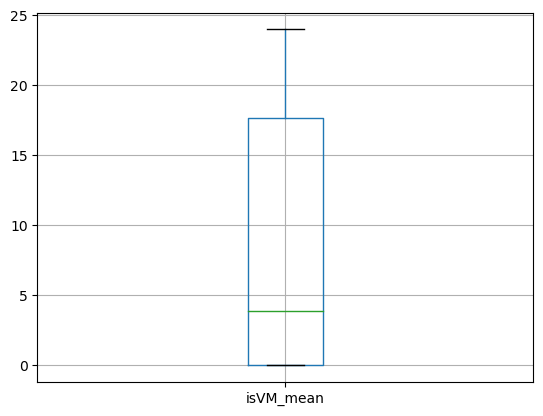

<Figure size 640x480 with 0 Axes>

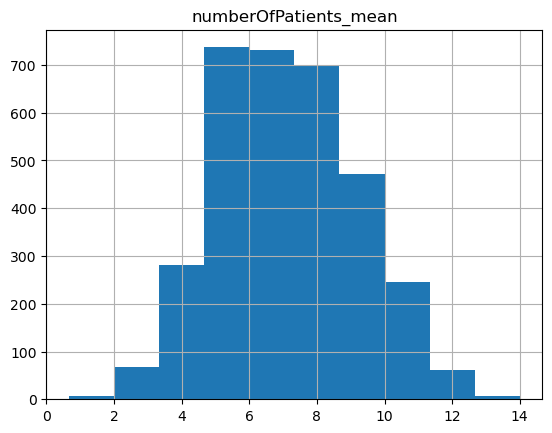

Feature:  numberOfPatientsMR_mean
False


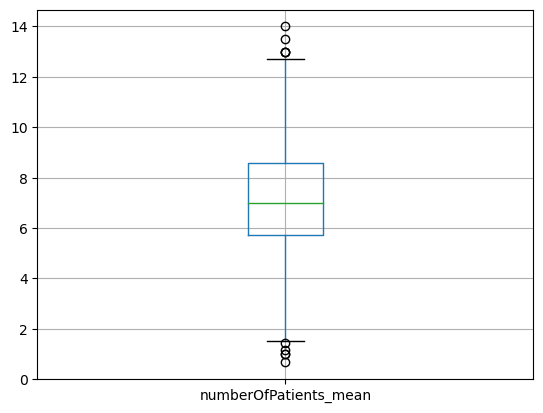

<Figure size 640x480 with 0 Axes>

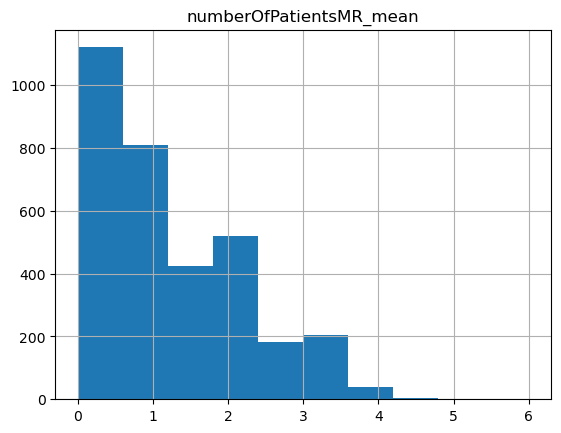

Feature:  patientPAP_mean
False


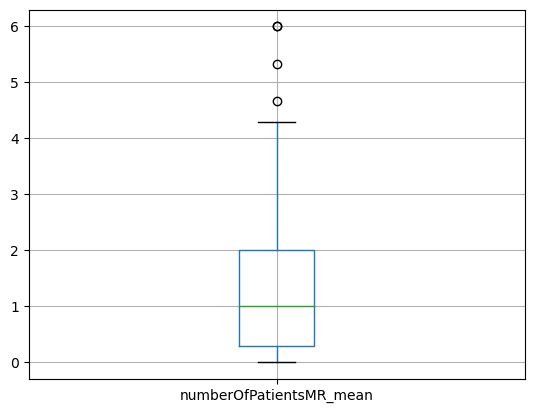

<Figure size 640x480 with 0 Axes>

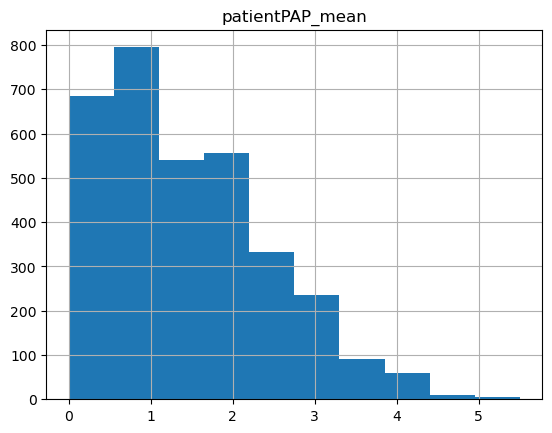

Feature:  patientCAR_mean
False


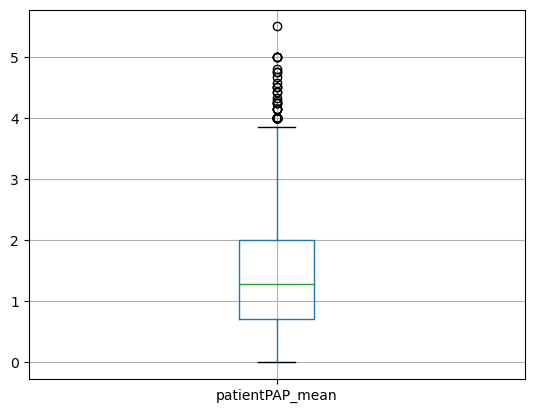

<Figure size 640x480 with 0 Axes>

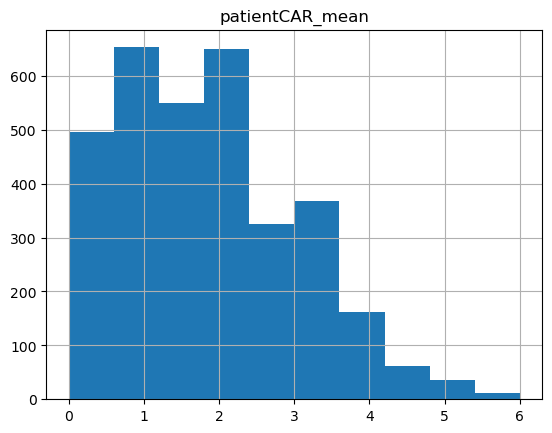

Feature:  patientFalta_mean
False


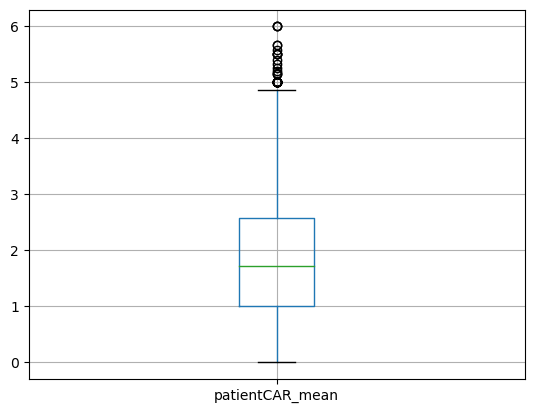

<Figure size 640x480 with 0 Axes>

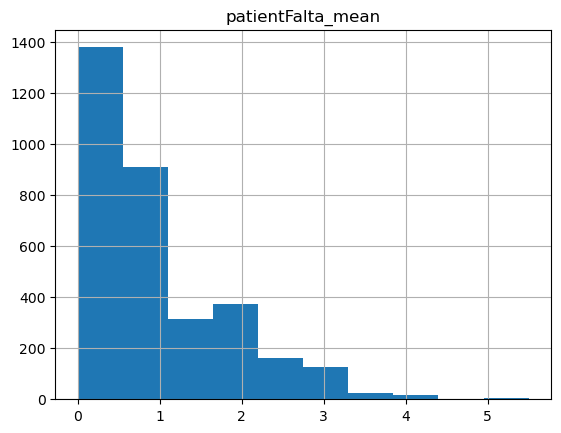

Feature:  patientQUI_mean
False


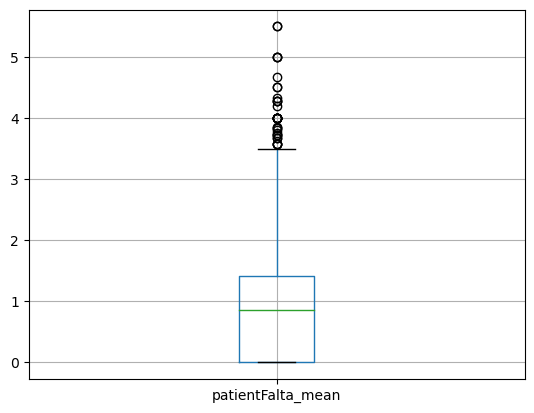

<Figure size 640x480 with 0 Axes>

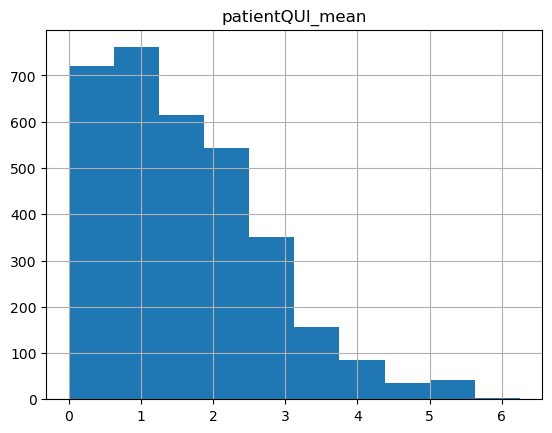

Feature:  patientATF_mean
False


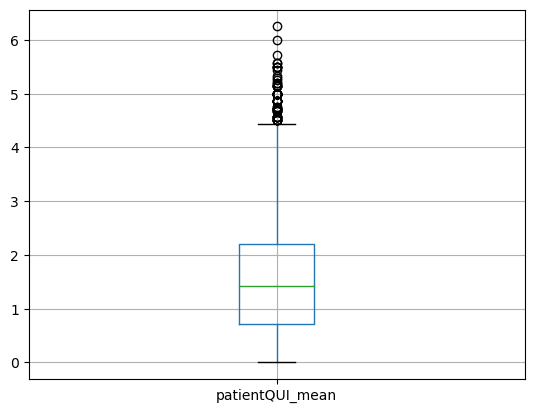

<Figure size 640x480 with 0 Axes>

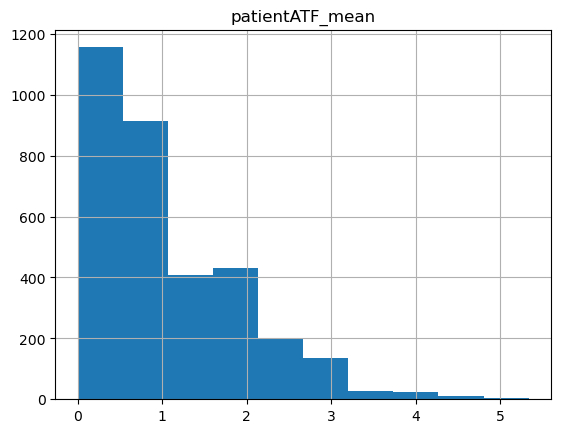

Feature:  patientGLI_mean
False


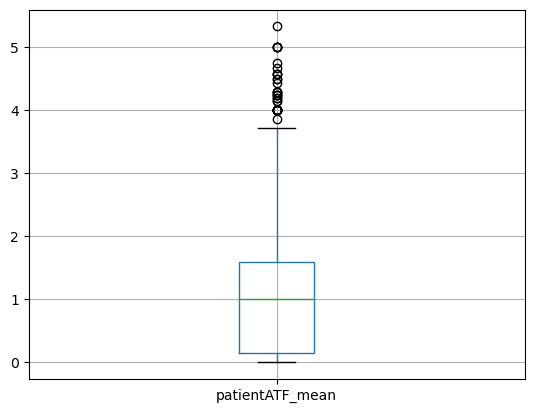

<Figure size 640x480 with 0 Axes>

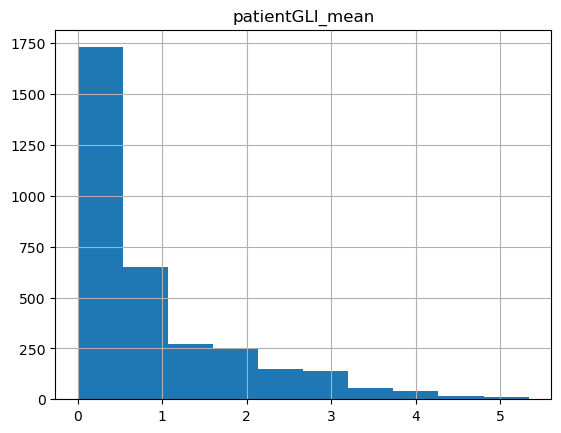

Feature:  patientPEN_mean
False


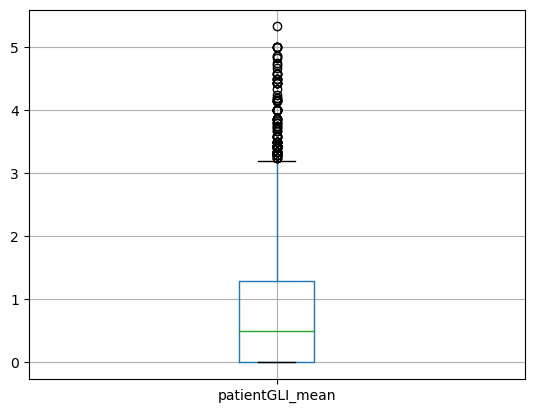

<Figure size 640x480 with 0 Axes>

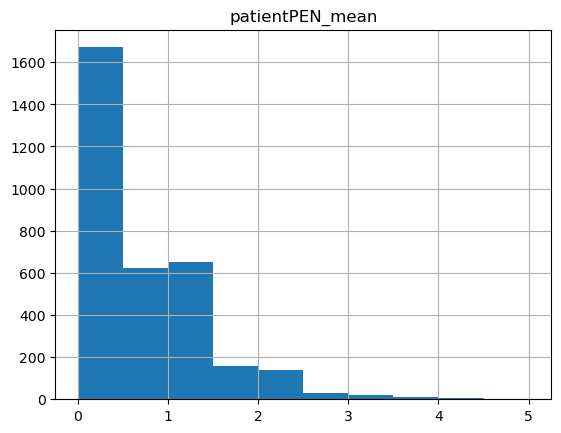

Feature:  patientCF3_mean
False


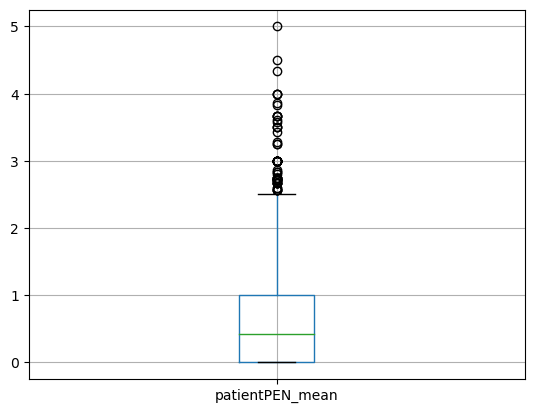

<Figure size 640x480 with 0 Axes>

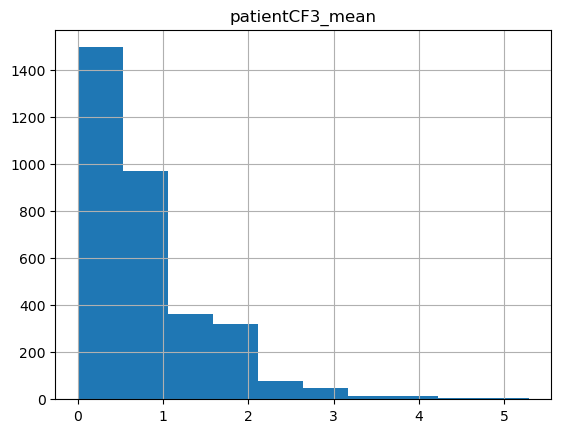

Feature:  patientCF4_mean
False


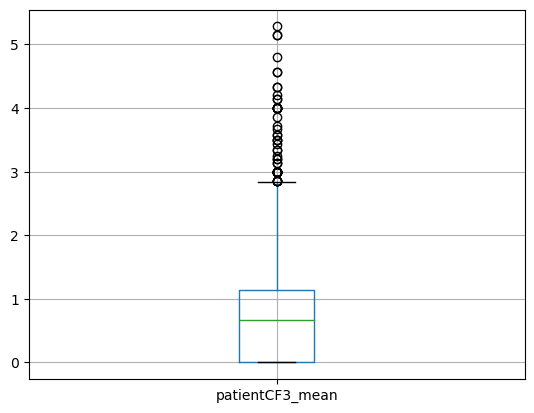

<Figure size 640x480 with 0 Axes>

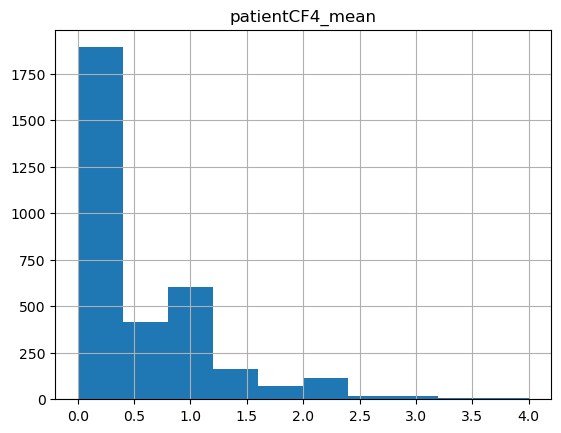

Feature:  patientOXA_mean
False


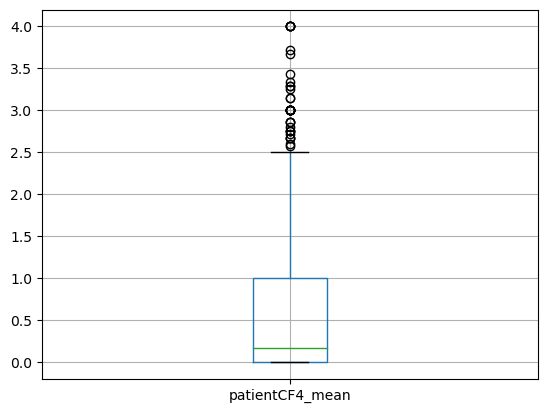

<Figure size 640x480 with 0 Axes>

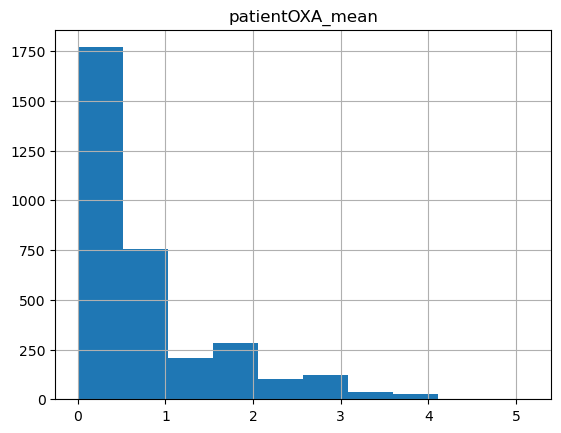

Feature:  patientNTI_mean
False


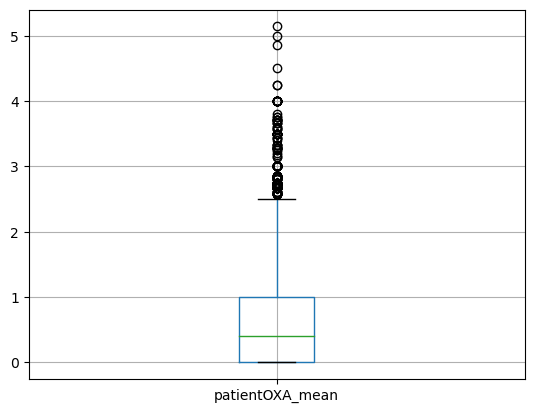

<Figure size 640x480 with 0 Axes>

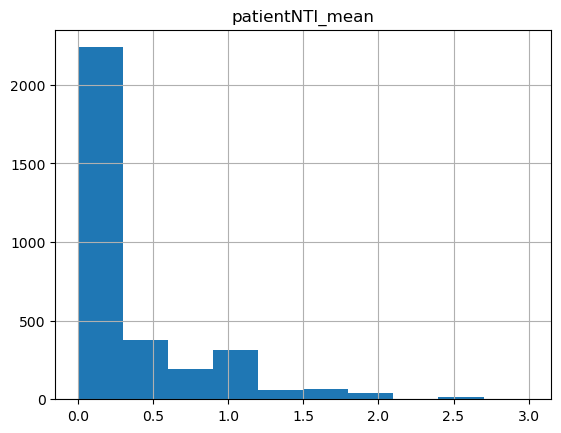

Feature:  patientLIN_mean
False


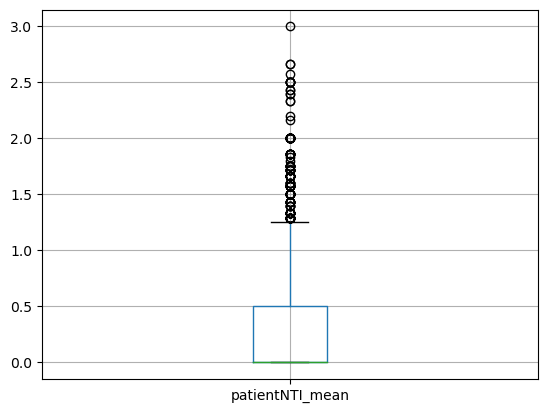

<Figure size 640x480 with 0 Axes>

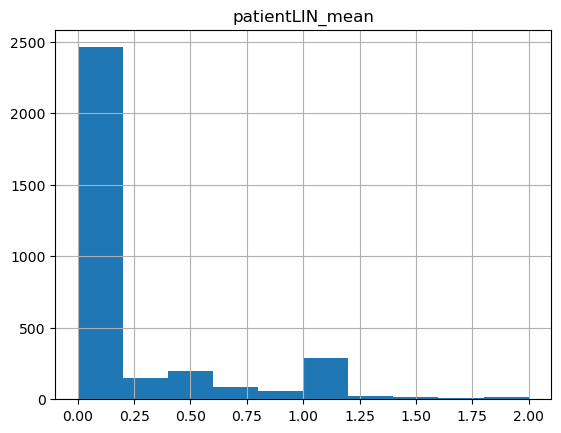

Feature:  patientSUL_mean
False


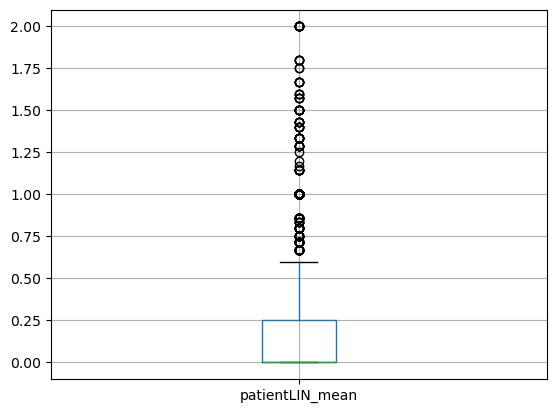

<Figure size 640x480 with 0 Axes>

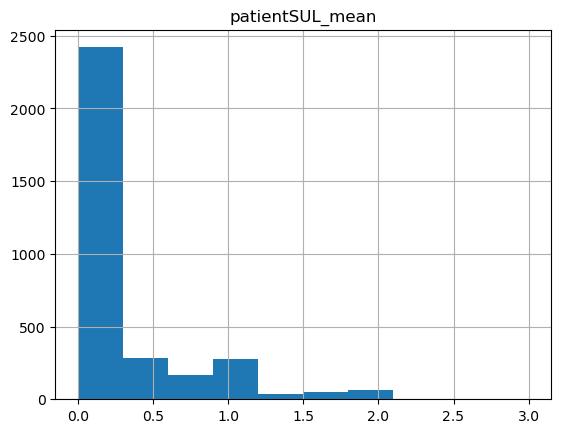

Feature:  patientAMG_mean
False


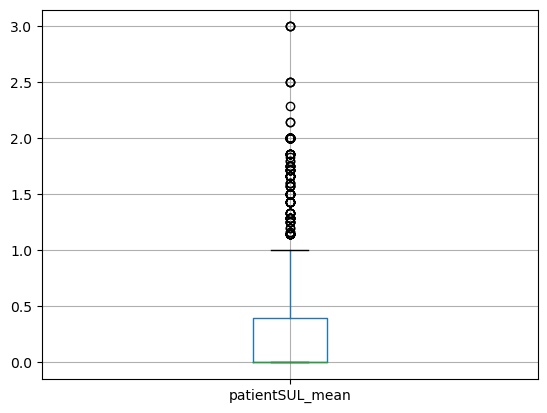

<Figure size 640x480 with 0 Axes>

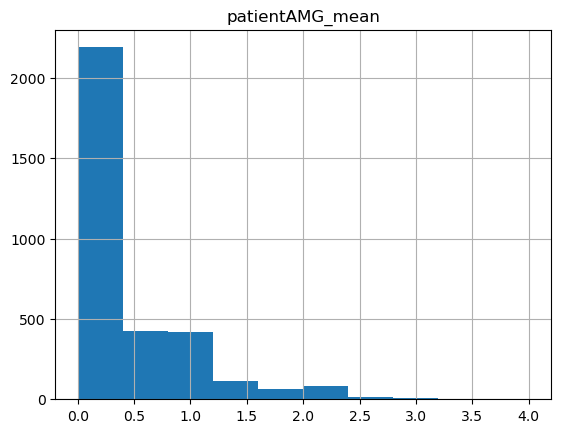

Feature:  patientCF1_mean
False


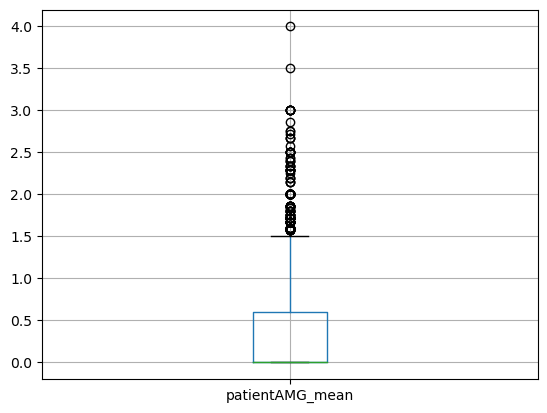

<Figure size 640x480 with 0 Axes>

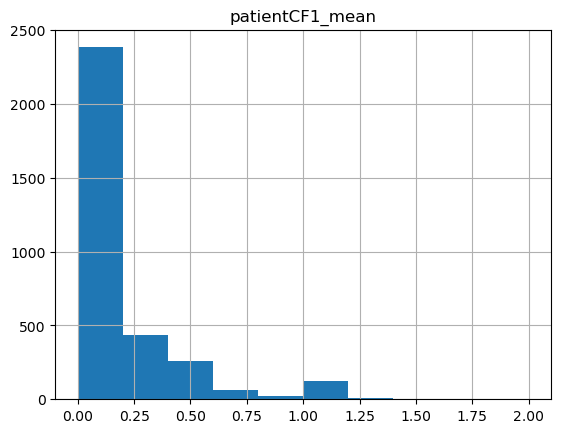

Feature:  patientMAC_mean
False


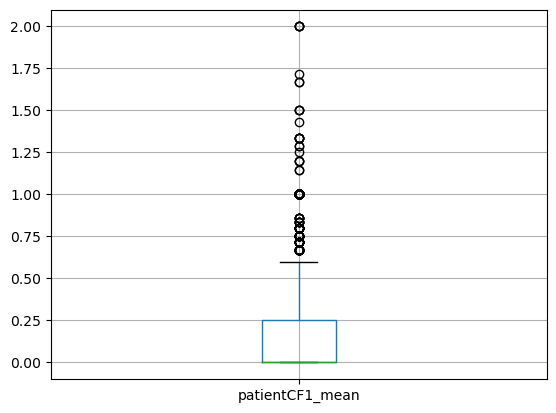

<Figure size 640x480 with 0 Axes>

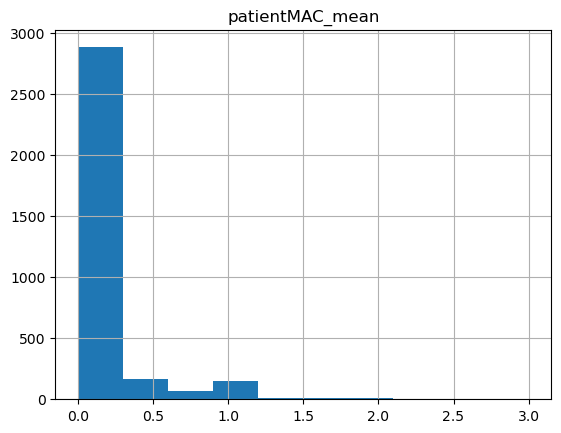

Feature:  patientPOL_mean
False


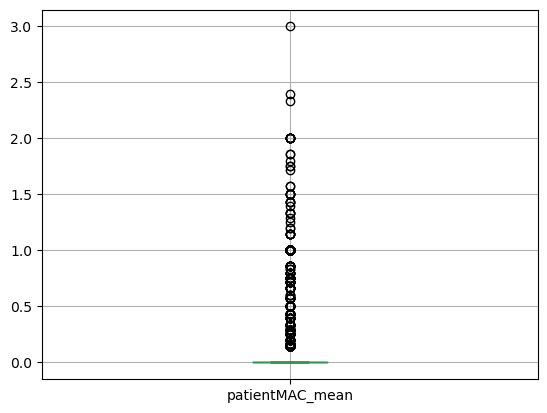

<Figure size 640x480 with 0 Axes>

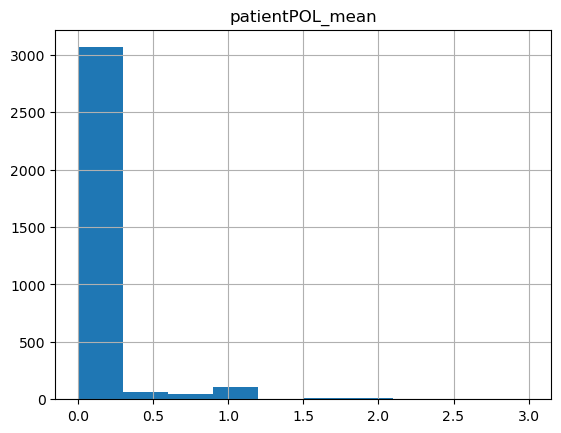

Feature:  patientMON_mean
False


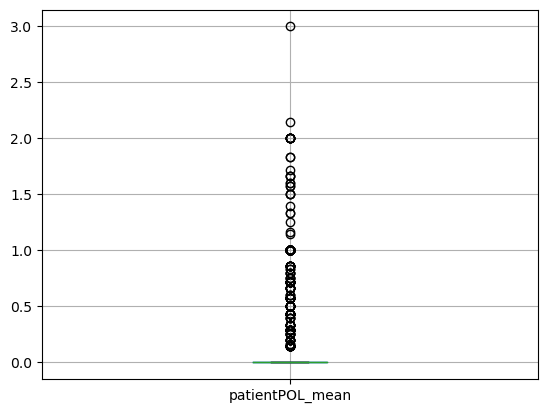

<Figure size 640x480 with 0 Axes>

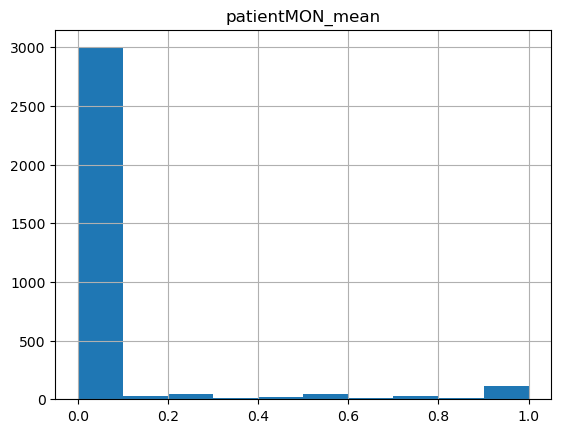

Feature:  patientGCC_mean
False


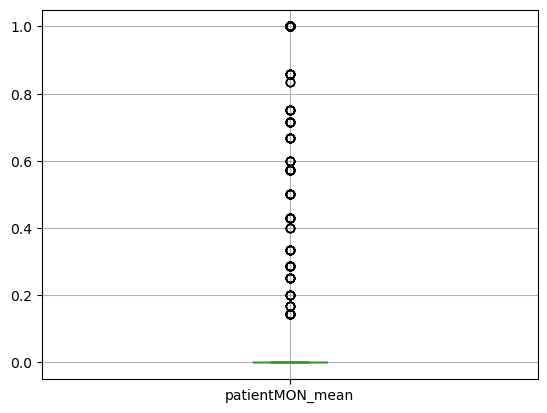

<Figure size 640x480 with 0 Axes>

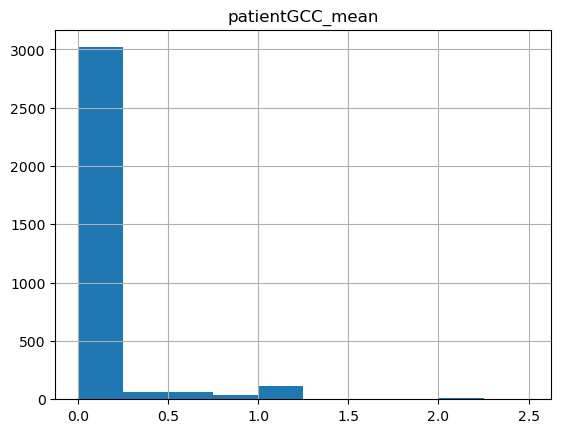

Feature:  patientTTC_mean
False


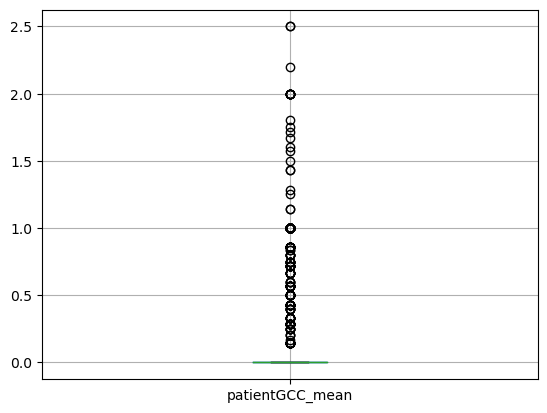

<Figure size 640x480 with 0 Axes>

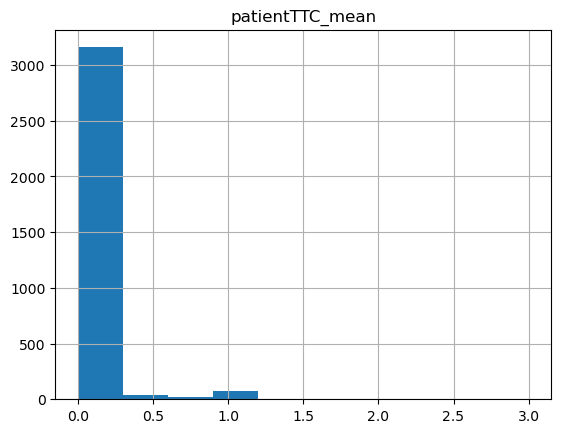

Feature:  patientOTR_mean
False


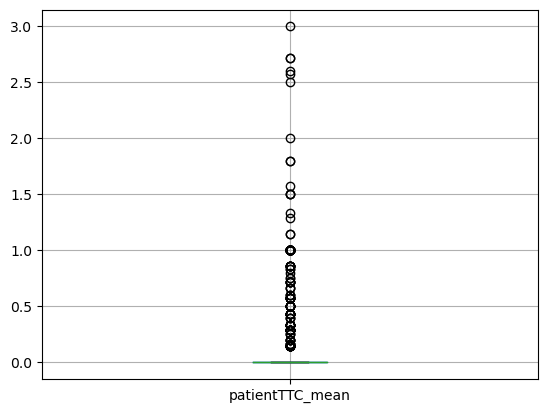

<Figure size 640x480 with 0 Axes>

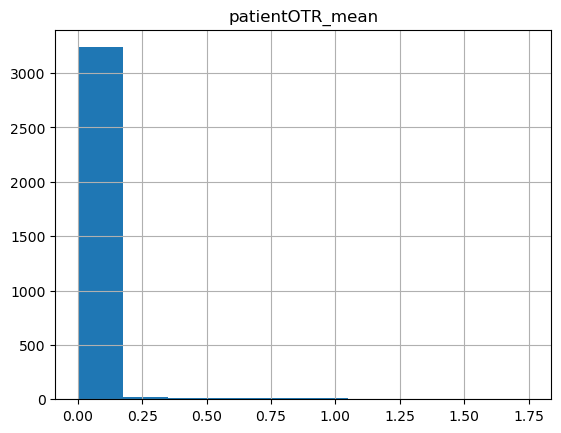

Feature:  patientLIP_mean
False


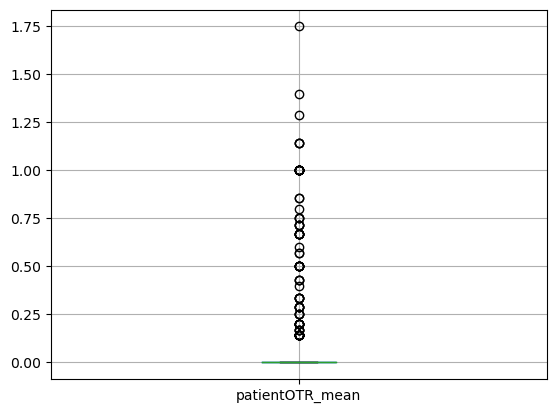

<Figure size 640x480 with 0 Axes>

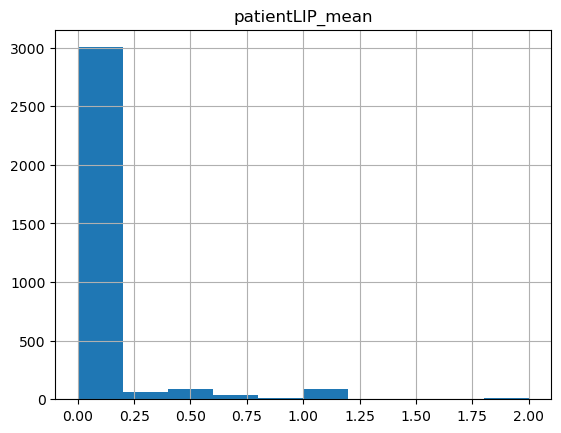

Feature:  patientCF2_mean
False


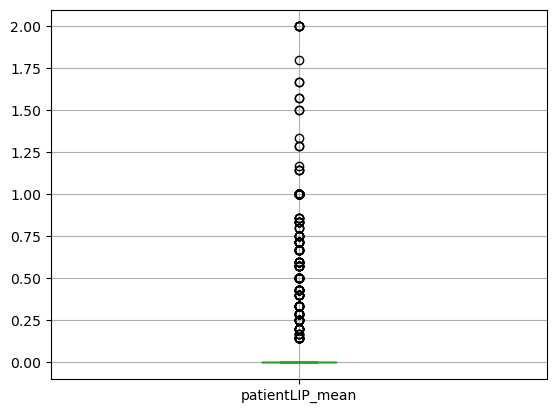

<Figure size 640x480 with 0 Axes>

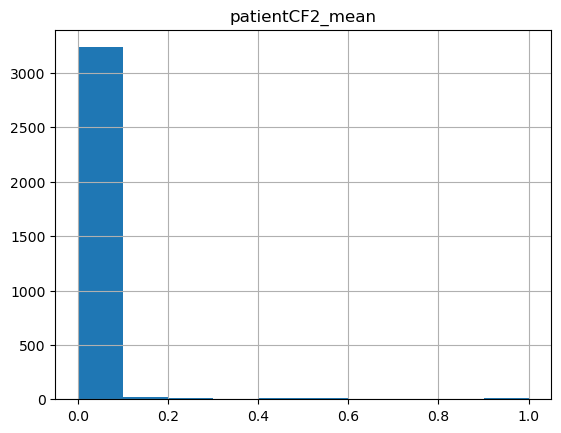

Feature:  inventedMask_mean
False


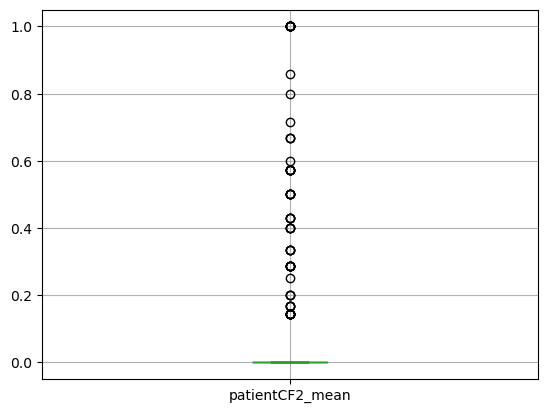

<Figure size 640x480 with 0 Axes>

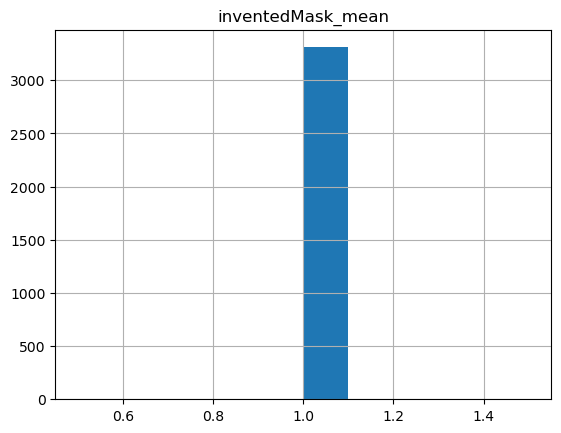

Feature:  DaysOfStay_mean
False


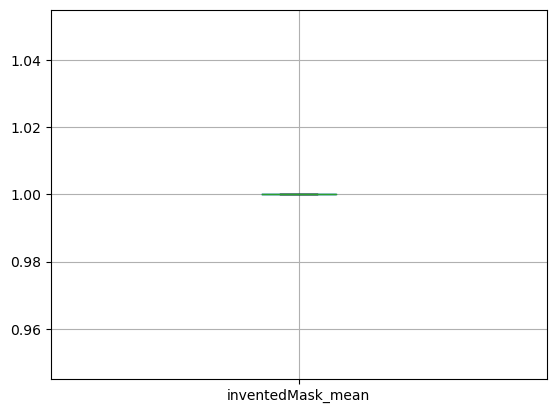

<Figure size 640x480 with 0 Axes>

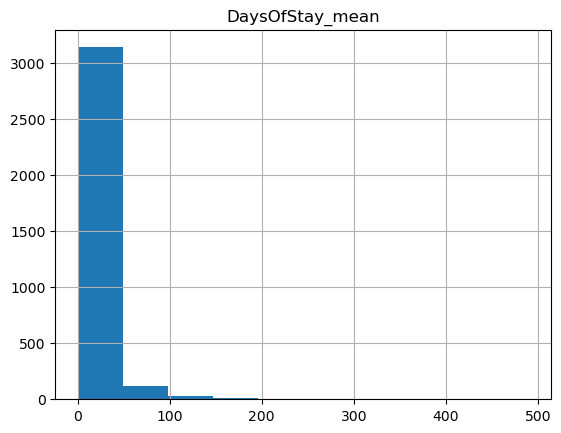

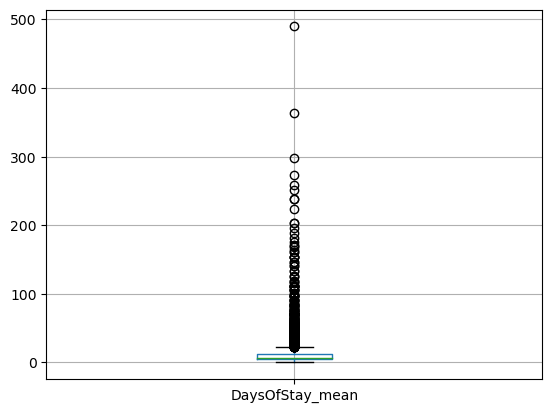

In [11]:
getDistribution(df_mean)

# Median

In [12]:
df_both = pd.read_csv("../df_to_load/Modelado_1/Datos_Originales/df_PreCovid.csv")
df_both_aux = df_both.drop(['Admissiondboid', 'dayToDone', 'MR',
                            'AMG', 'ATF', 'CAR', 'CF1',
                            'CF2', 'CF3', 'CF4', 'Falta', 'GCC', 'GLI', 'LIN', 'LIP', 'MAC', 'MON',
                            'NTI', 'OTR', 'OXA', 'PAP', 'PEN', 'POL', 'QUI', 'SUL', 'TTC'],axis=1)
keys = df_both_aux.keys()
print(keys)
mat = np.zeros((int(df_both_aux.shape[0]/numTimeStep), len(keys)))
inf = 0
sup = numTimeStep-1
for indexx in range(int(df_both_aux.shape[0]/numTimeStep)):
    #############################################################################
    # Eliminate those instants when the patient is not in the ICU.
    idx = df_both_aux[inf:sup]['inventedMask'].values != 0
    idx = np.argwhere(idx.astype('uint8') == 0)
    index=[]
    for j in range(idx.shape[0]):
        index.append(idx[j][0])
    aux = df_both_aux.loc[inf:sup]
    aux = aux.reset_index(drop=True)
    aux_2 = aux.drop(index,axis=0)
    aux_2 = aux_2.reset_index(drop=True)
    #############################################################################
    for i in range(len(keys)):
        mat[indexx,i] = aux_2[keys[i]].median()
    inf = sup + 1 
    sup += numTimeStep
        
df_median = pd.DataFrame(mat)

new_names = []
for i in range(len(keys)):
    new_names.append(keys[i]+str("_median"))
    
df_median.columns = new_names

Index(['isVM', 'numberOfPatients', 'numberOfPatientsMR', 'patientPAP',
       'patientCAR', 'patientFalta', 'patientQUI', 'patientATF', 'patientGLI',
       'patientPEN', 'patientCF3', 'patientCF4', 'patientOXA', 'patientNTI',
       'patientLIN', 'patientSUL', 'patientAMG', 'patientCF1', 'patientMAC',
       'patientPOL', 'patientMON', 'patientGCC', 'patientTTC', 'patientOTR',
       'patientLIP', 'patientCF2', 'inventedMask', 'DaysOfStay'],
      dtype='object')


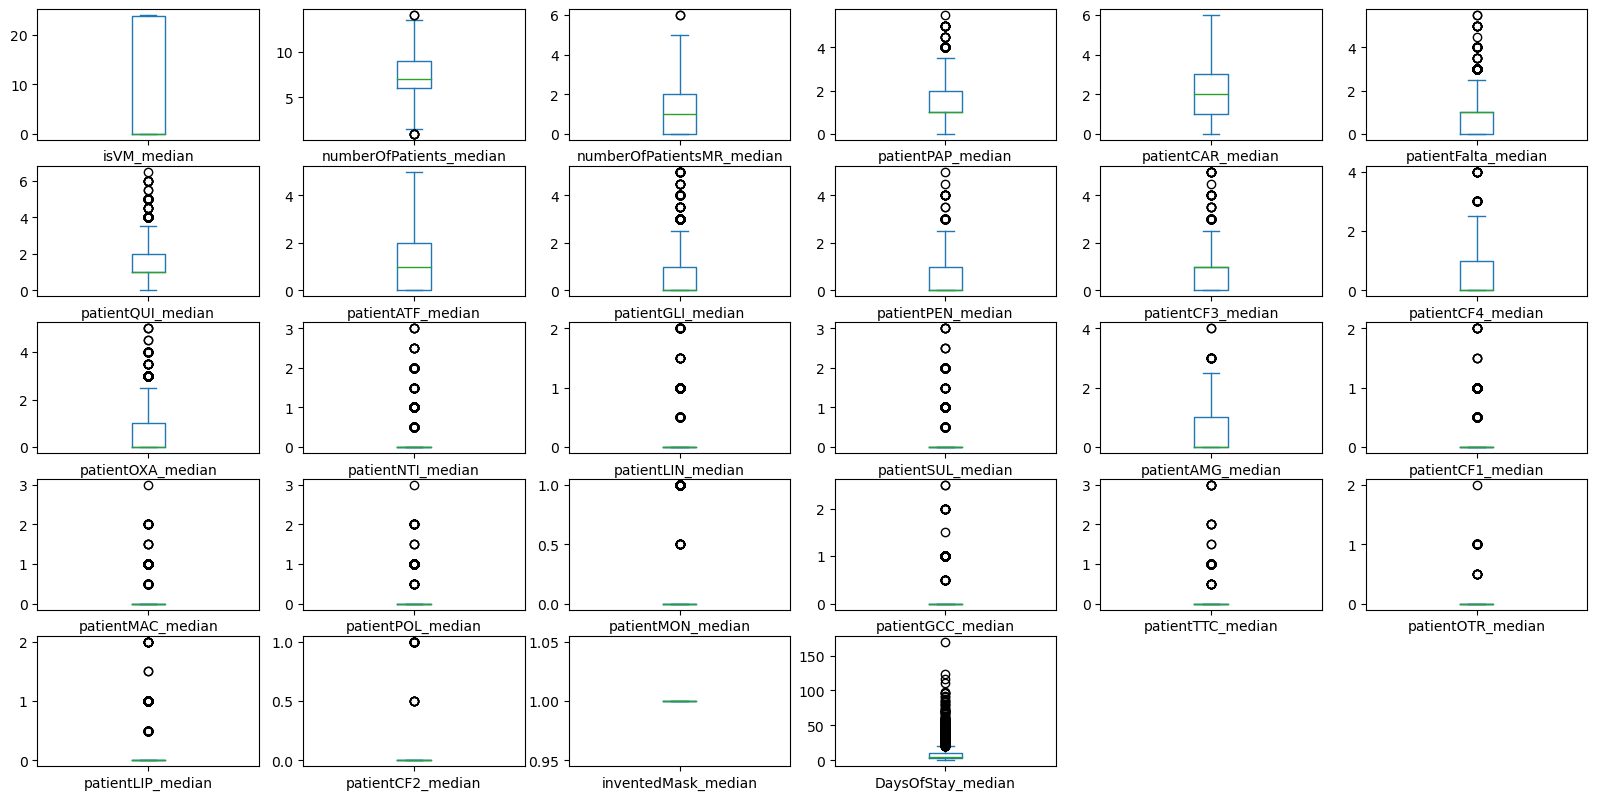

In [13]:
_ = df_median.plot(kind='box', subplots=True, layout = (10,6), figsize=(20,20))

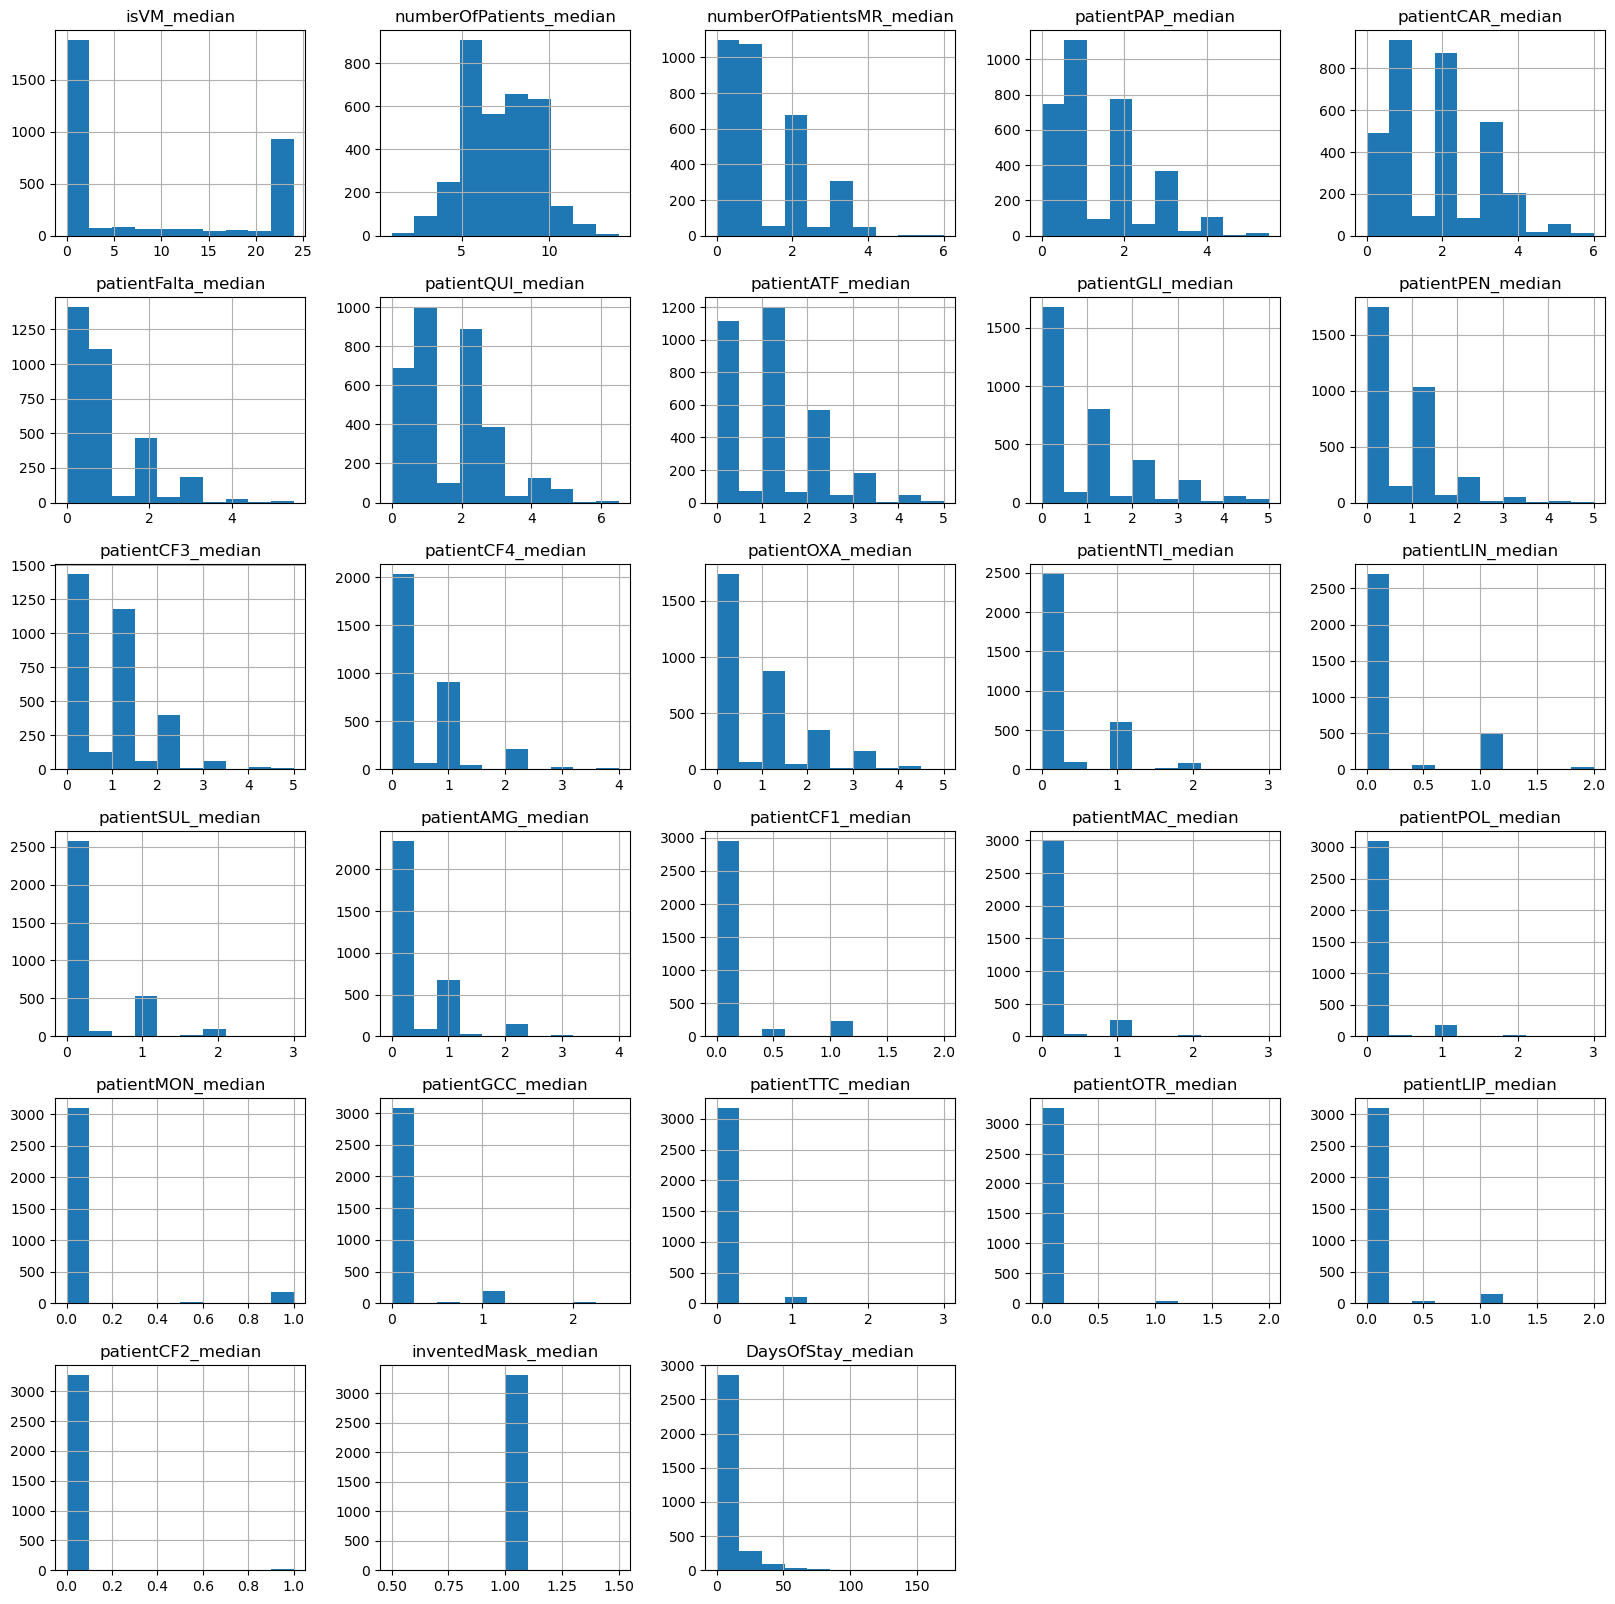

In [14]:
_ = df_median.hist(figsize=(20,20))

False
Feature:  isVM_median
False


<Figure size 640x480 with 0 Axes>

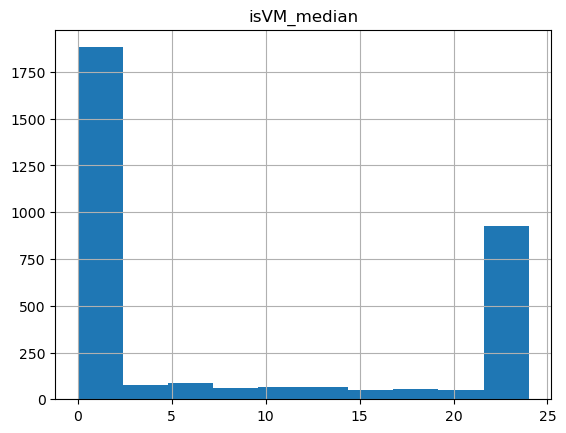

Feature:  numberOfPatients_median
False


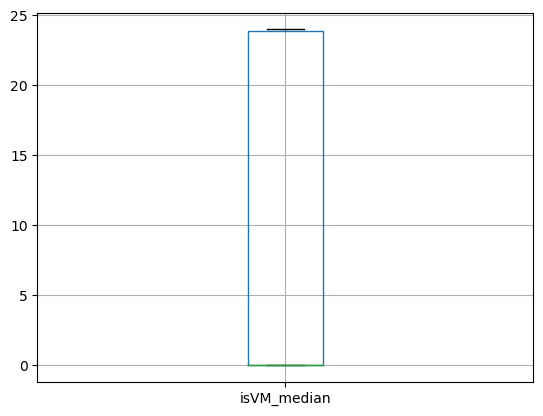

<Figure size 640x480 with 0 Axes>

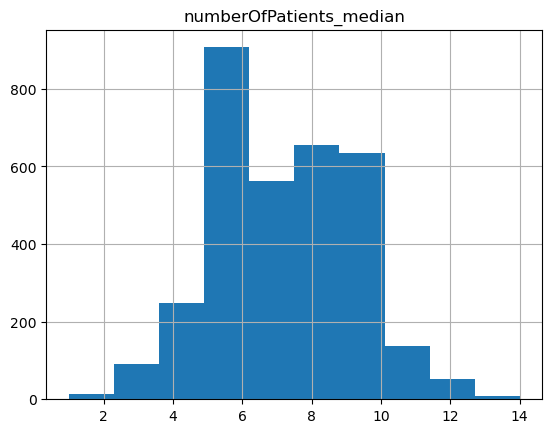

Feature:  numberOfPatientsMR_median
False


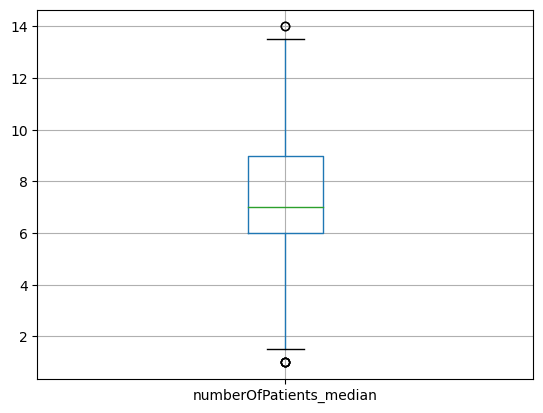

<Figure size 640x480 with 0 Axes>

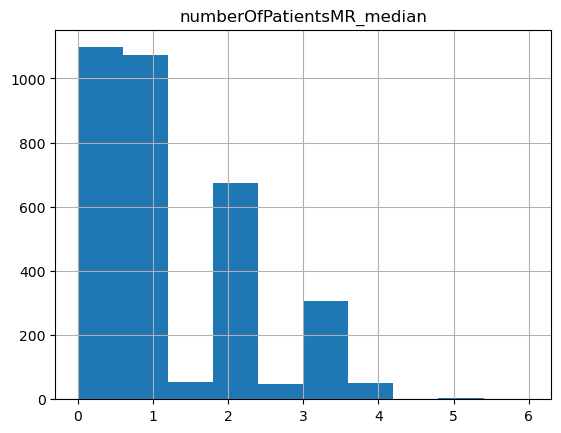

Feature:  patientPAP_median
False


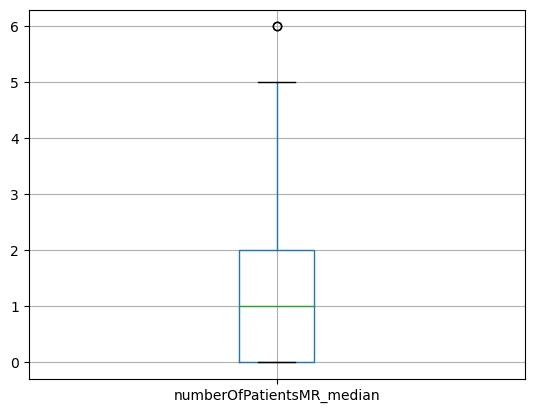

<Figure size 640x480 with 0 Axes>

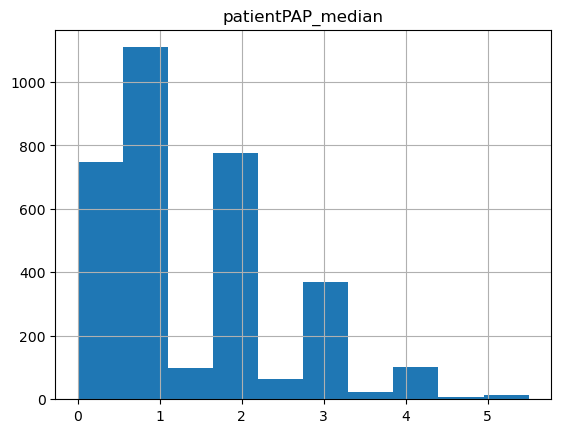

Feature:  patientCAR_median
False


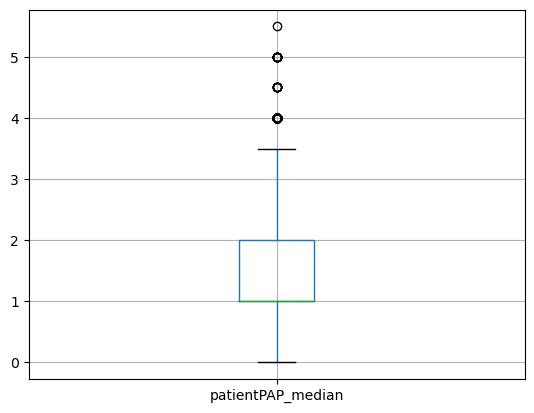

<Figure size 640x480 with 0 Axes>

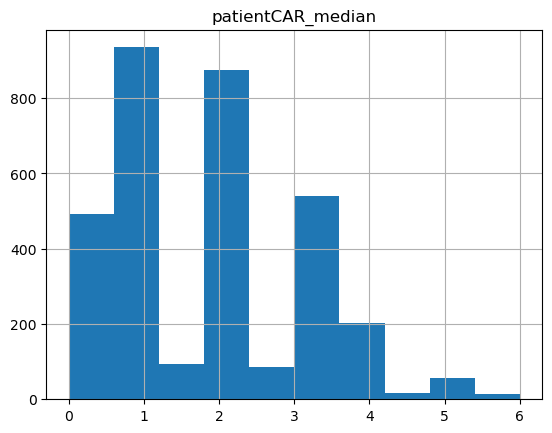

Feature:  patientFalta_median
False


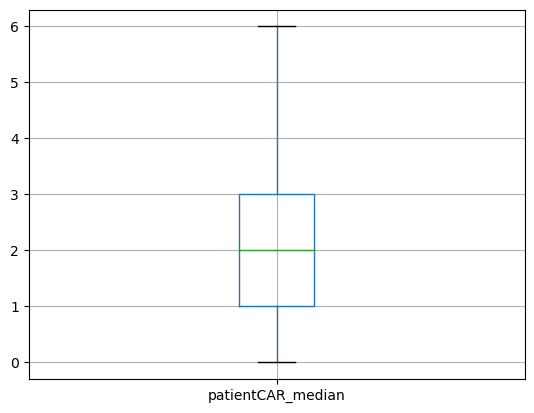

<Figure size 640x480 with 0 Axes>

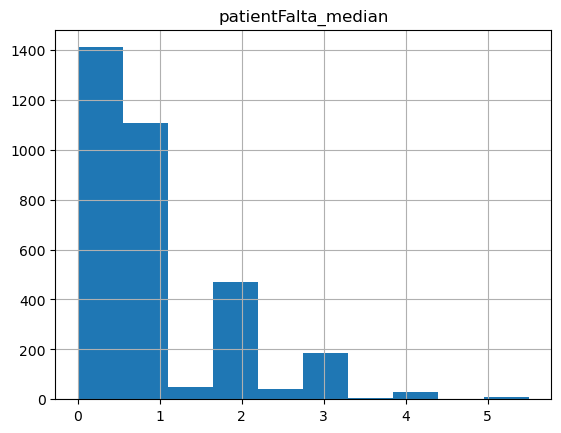

Feature:  patientQUI_median
False


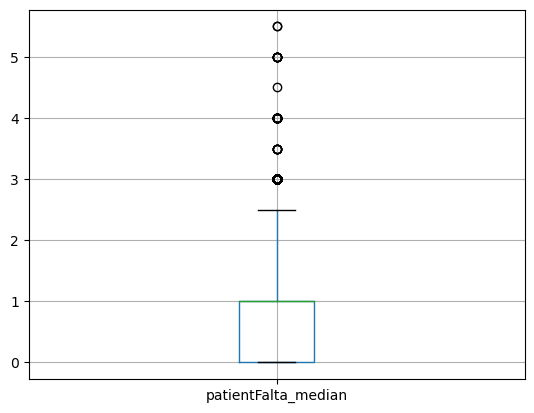

<Figure size 640x480 with 0 Axes>

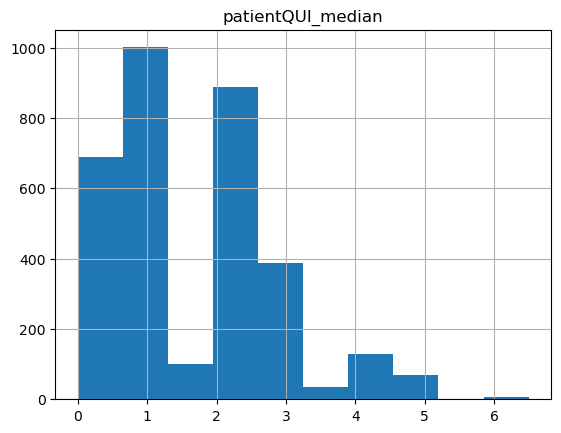

Feature:  patientATF_median
False


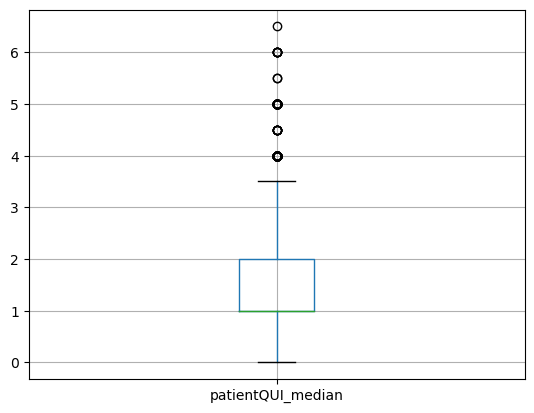

<Figure size 640x480 with 0 Axes>

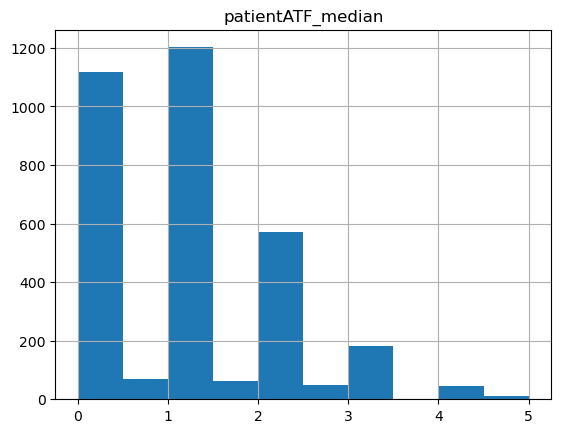

Feature:  patientGLI_median
False


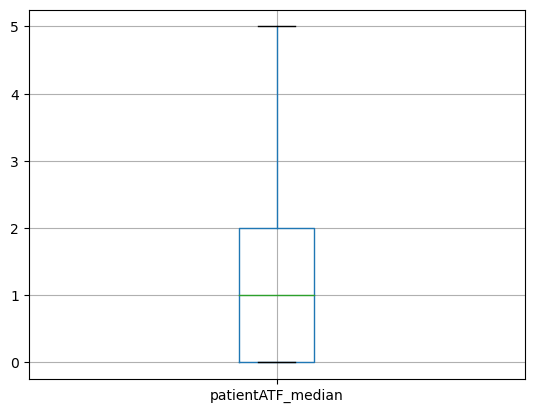

<Figure size 640x480 with 0 Axes>

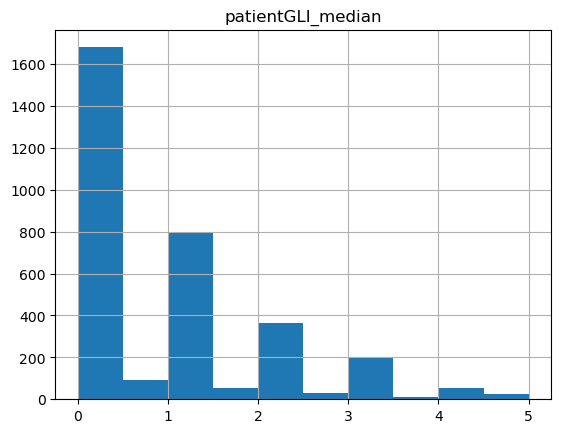

Feature:  patientPEN_median
False


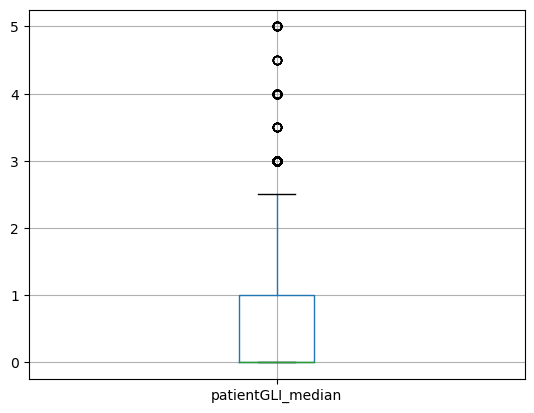

<Figure size 640x480 with 0 Axes>

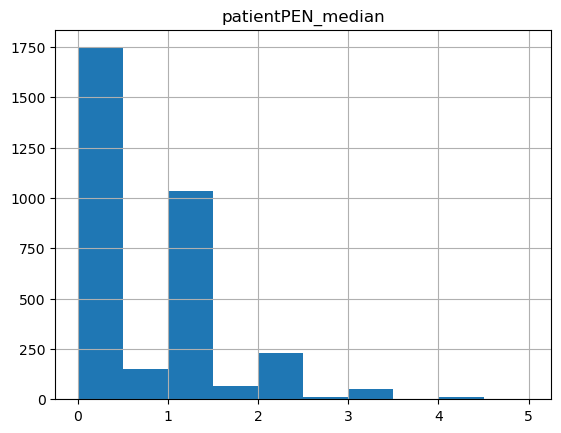

Feature:  patientCF3_median
False


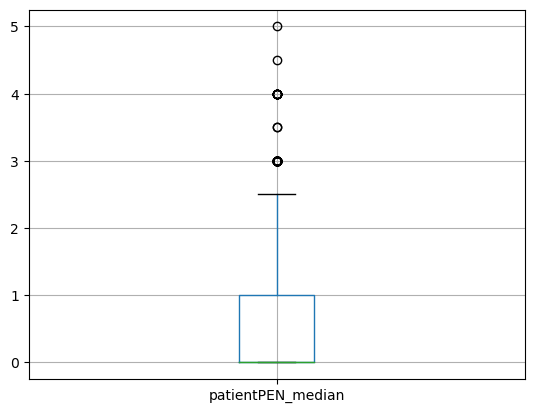

<Figure size 640x480 with 0 Axes>

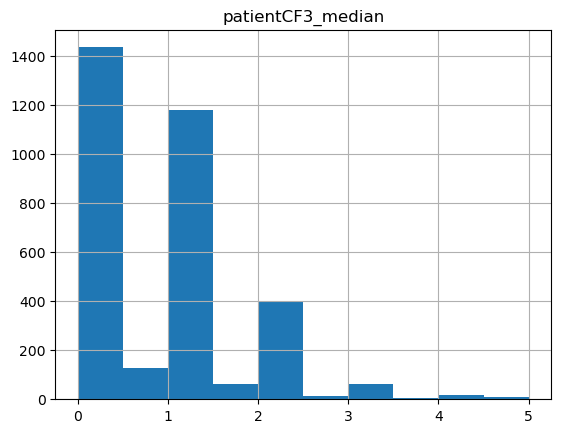

Feature:  patientCF4_median
False


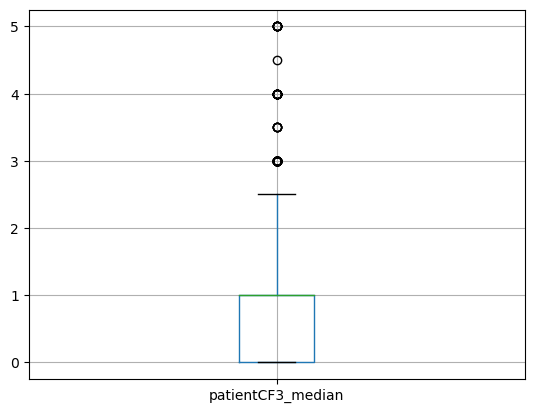

<Figure size 640x480 with 0 Axes>

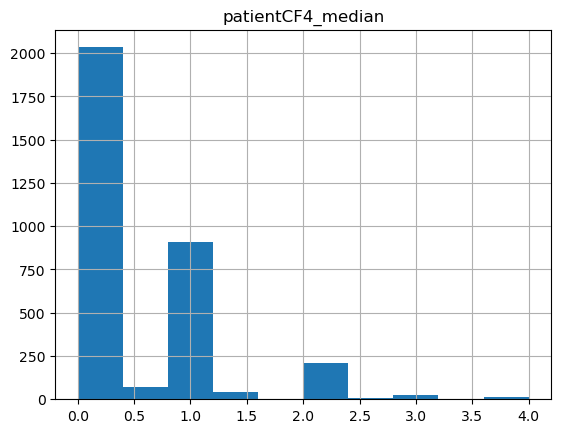

Feature:  patientOXA_median
False


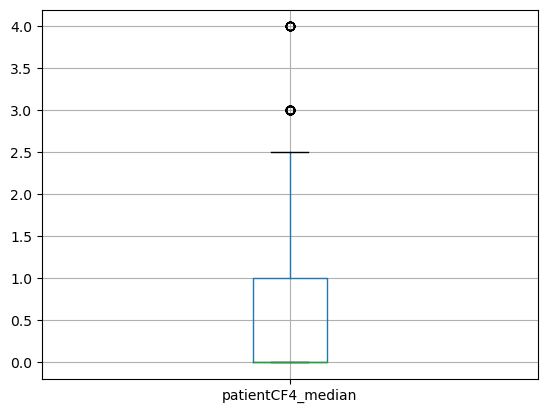

<Figure size 640x480 with 0 Axes>

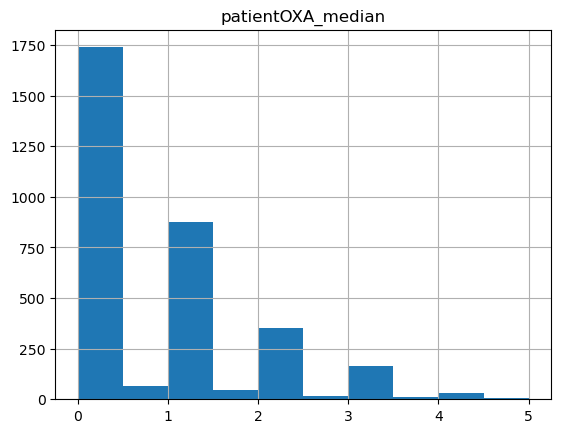

Feature:  patientNTI_median
False


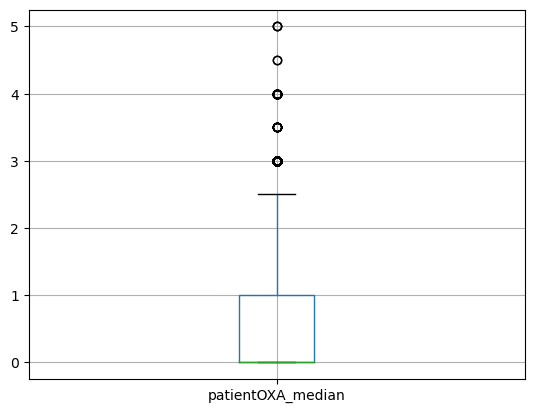

<Figure size 640x480 with 0 Axes>

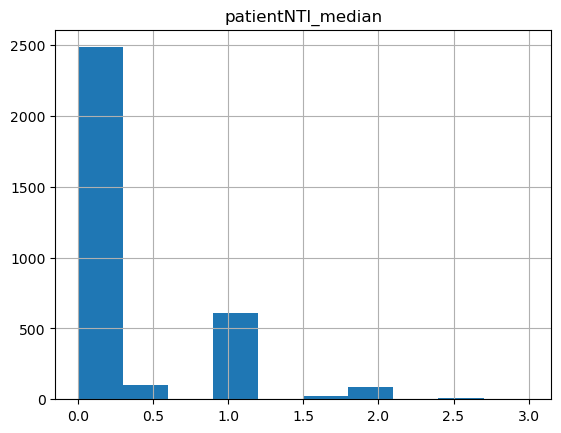

Feature:  patientLIN_median
False


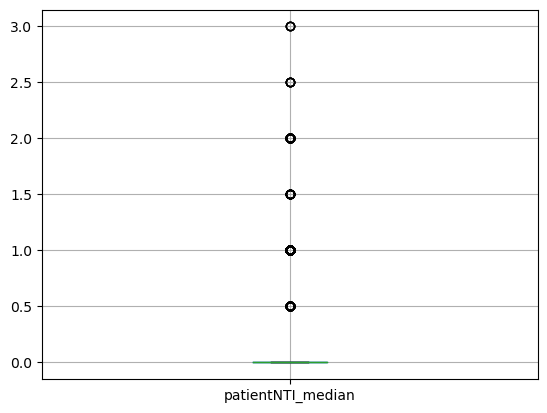

<Figure size 640x480 with 0 Axes>

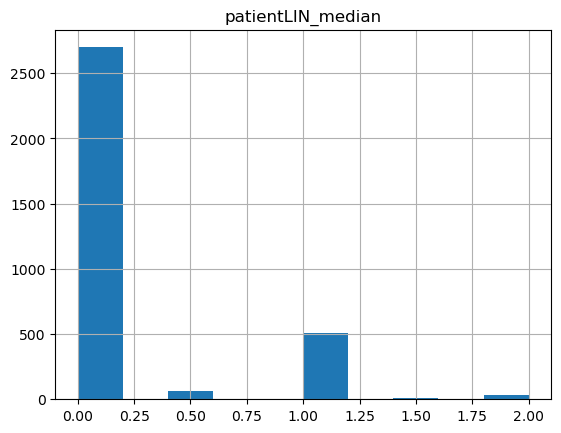

Feature:  patientSUL_median
False


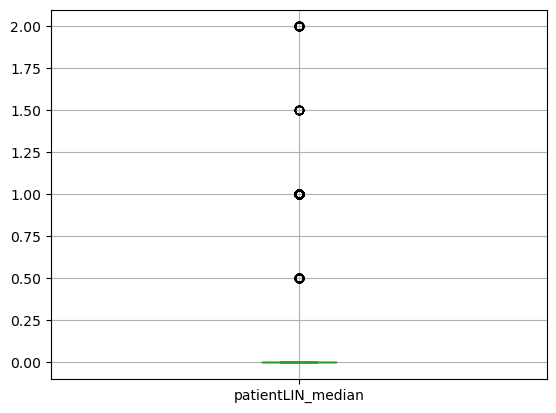

<Figure size 640x480 with 0 Axes>

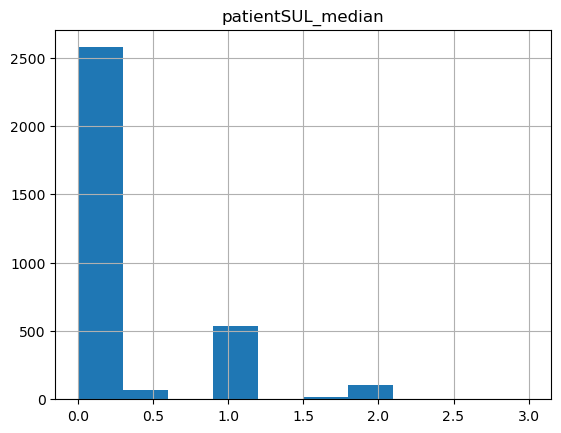

Feature:  patientAMG_median
False


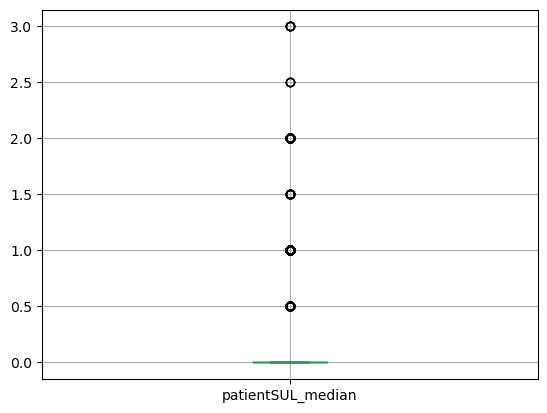

<Figure size 640x480 with 0 Axes>

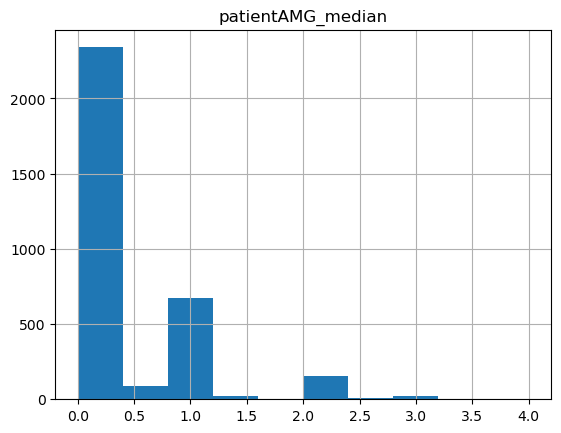

Feature:  patientCF1_median
False


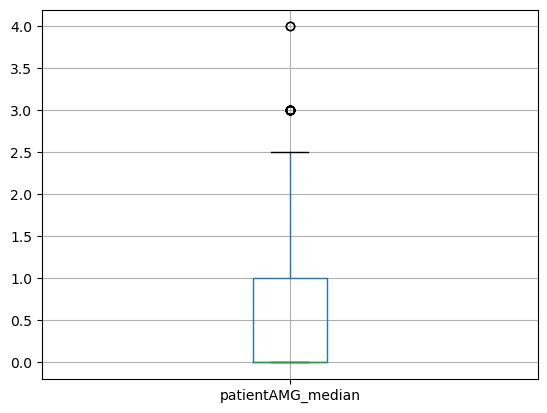

<Figure size 640x480 with 0 Axes>

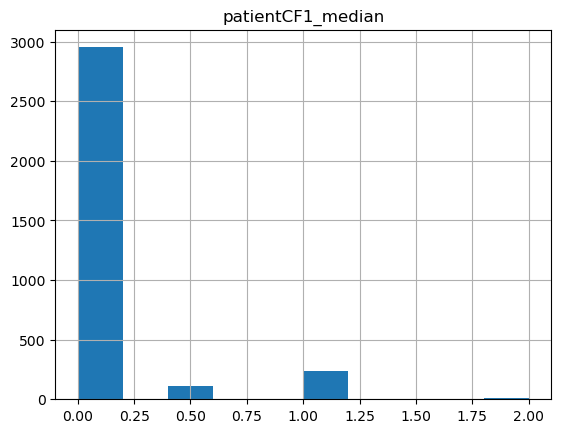

Feature:  patientMAC_median
False


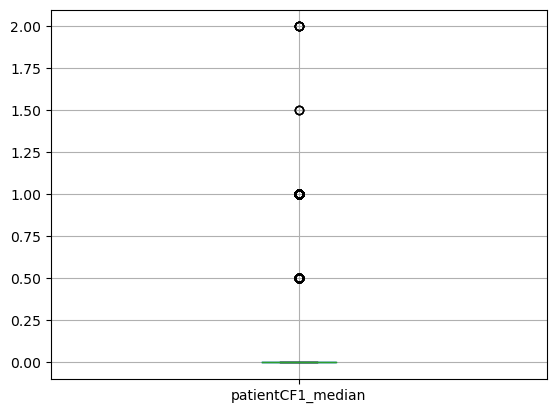

<Figure size 640x480 with 0 Axes>

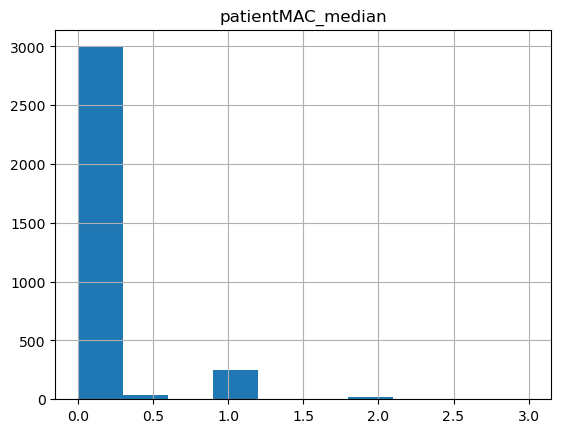

Feature:  patientPOL_median
False


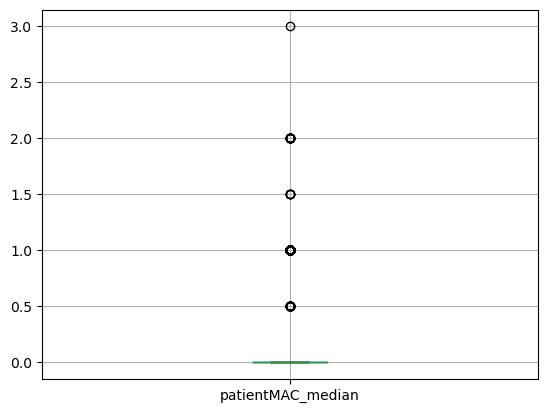

<Figure size 640x480 with 0 Axes>

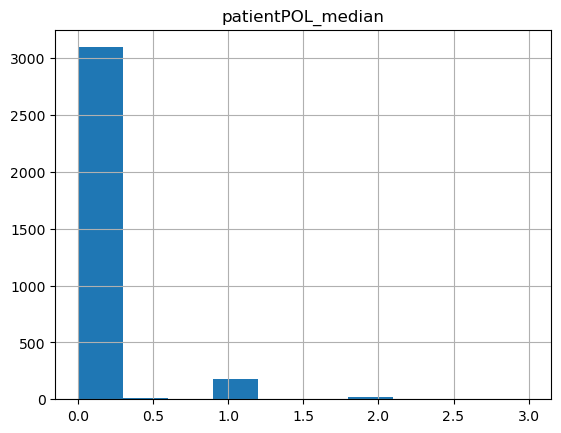

Feature:  patientMON_median
False


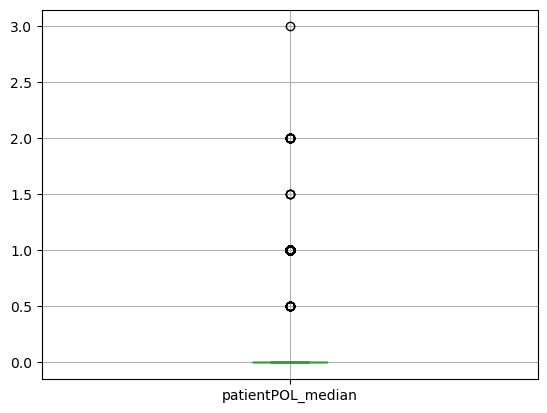

<Figure size 640x480 with 0 Axes>

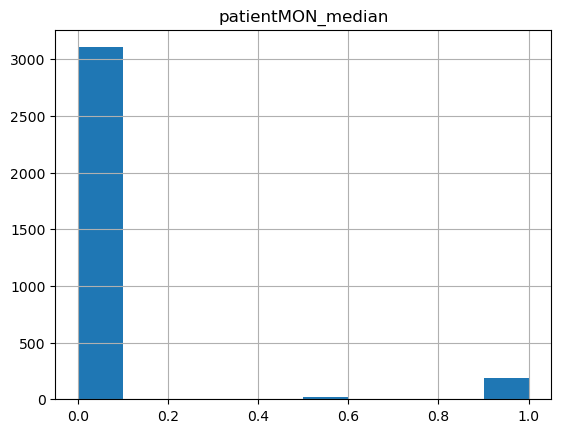

Feature:  patientGCC_median
False


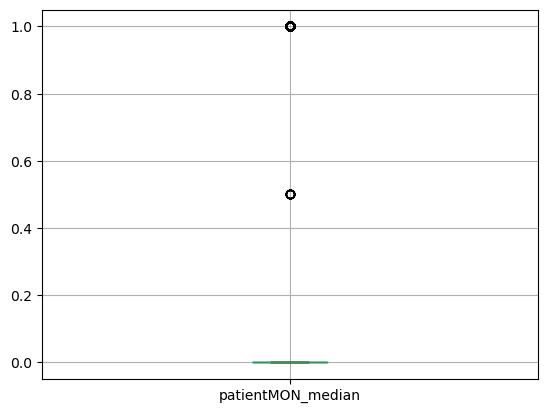

<Figure size 640x480 with 0 Axes>

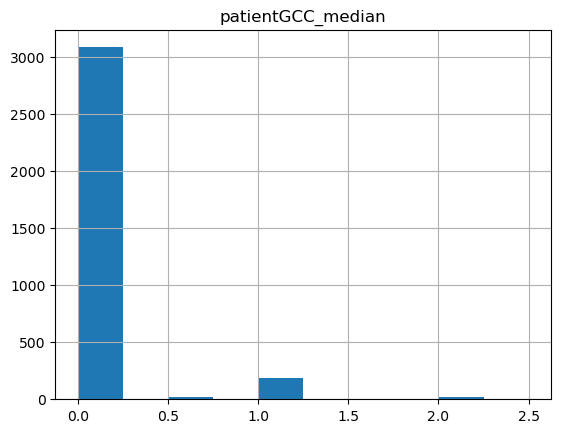

Feature:  patientTTC_median
False


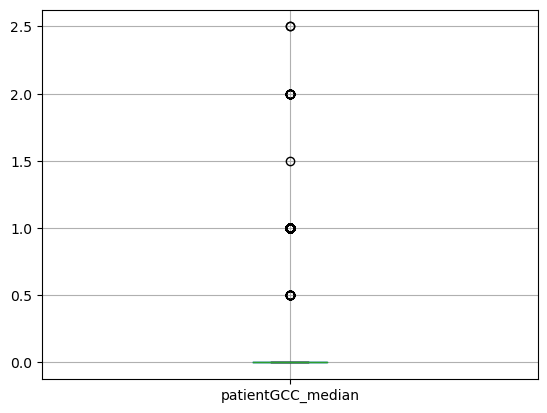

<Figure size 640x480 with 0 Axes>

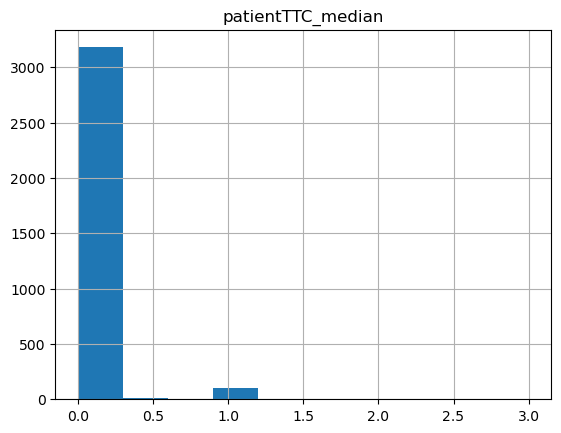

Feature:  patientOTR_median
False


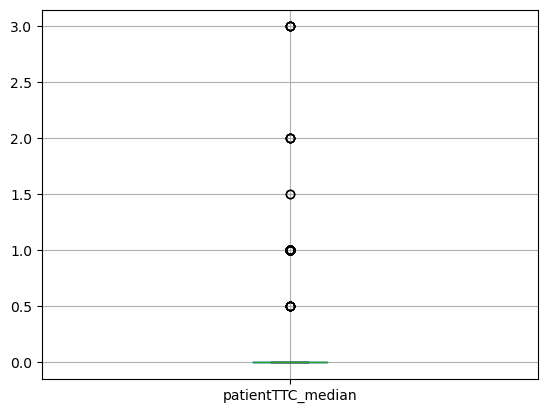

<Figure size 640x480 with 0 Axes>

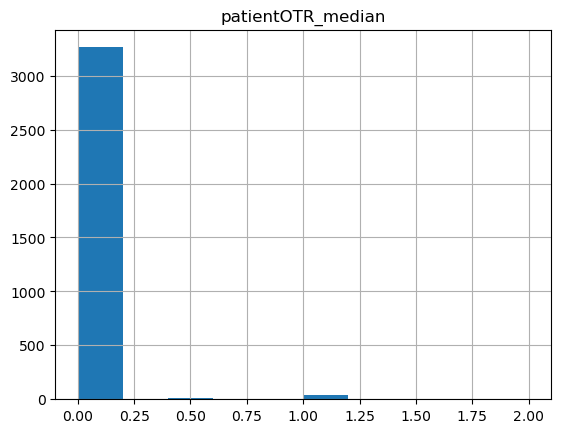

Feature:  patientLIP_median
False


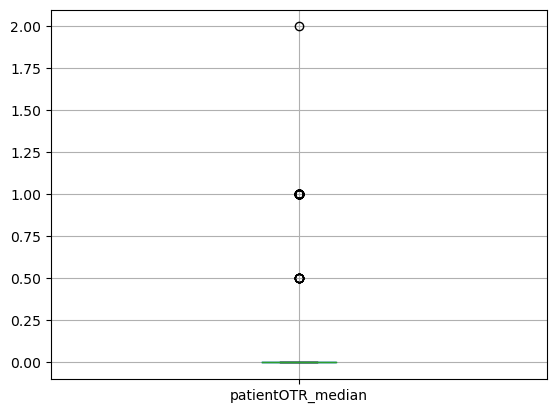

<Figure size 640x480 with 0 Axes>

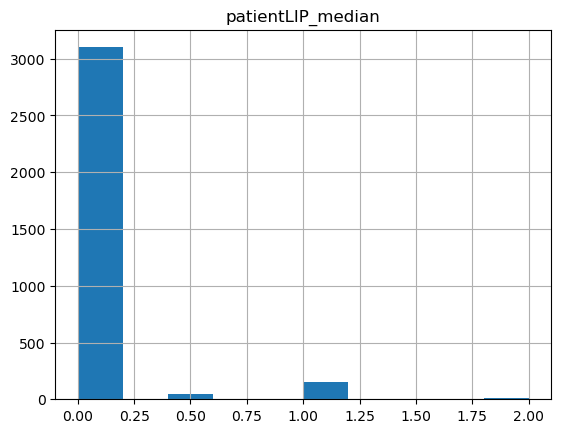

Feature:  patientCF2_median
False


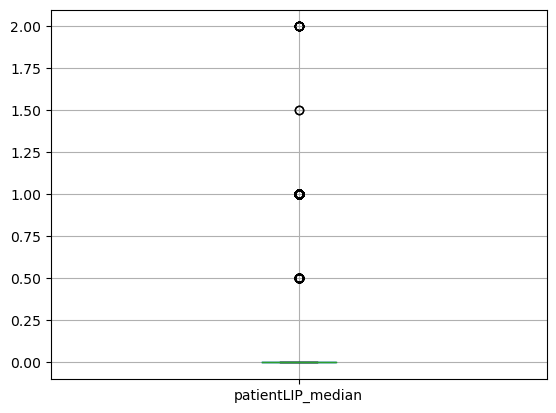

<Figure size 640x480 with 0 Axes>

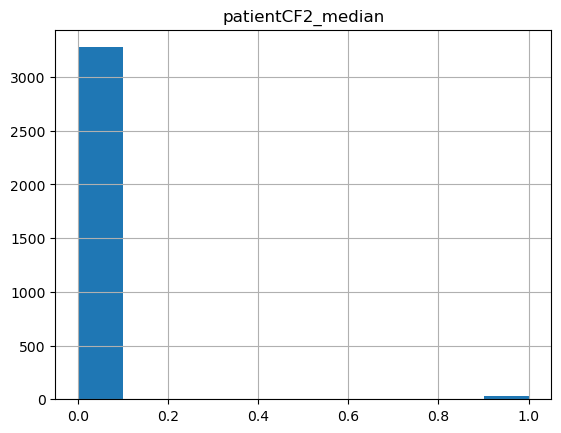

Feature:  inventedMask_median
False


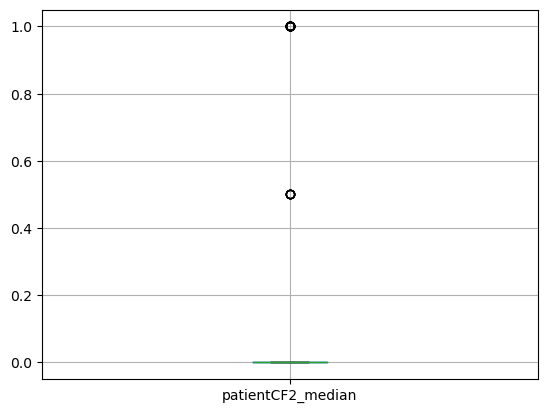

<Figure size 640x480 with 0 Axes>

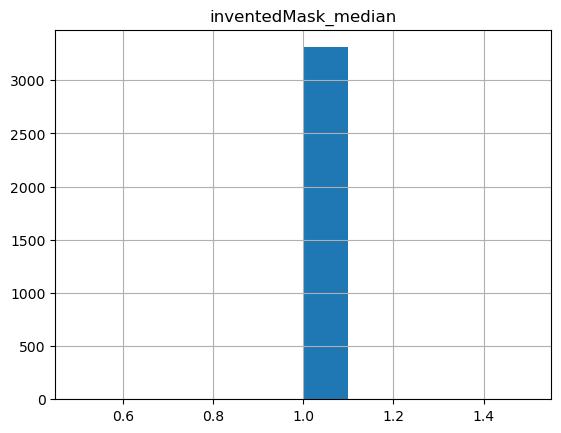

Feature:  DaysOfStay_median
False


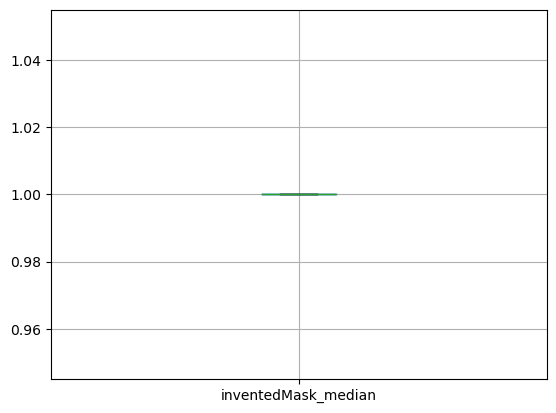

<Figure size 640x480 with 0 Axes>

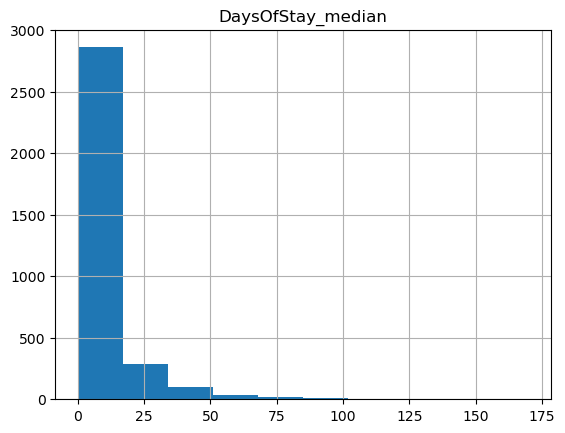

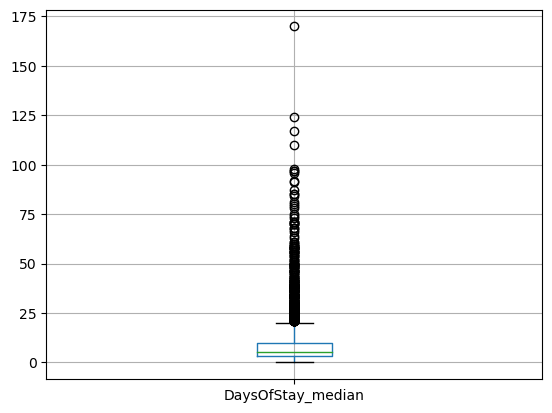

In [15]:
getDistribution(df_median)

# STD

In [16]:
df_both = pd.read_csv("../df_to_load/Modelado_1/Datos_Originales/df_PreCovid.csv")

df_both_aux = df_both.drop(['Admissiondboid', 'dayToDone', 'MR',
                            'AMG', 'ATF', 'CAR', 'CF1',
                            'CF2', 'CF3', 'CF4', 'Falta', 'GCC', 'GLI', 'LIN', 'LIP', 'MAC', 'MON',
                            'NTI', 'OTR', 'OXA', 'PAP', 'PEN', 'POL', 'QUI', 'SUL', 'TTC'],axis=1)
                            
keys = df_both_aux.keys()
print(keys)
mat = np.zeros((int(df_both_aux.shape[0]/numTimeStep), len(keys)))
inf = 0
sup = numTimeStep-1
var = 0
MR = 0
noMR = 0
admissiondboid = []
for indexx in range(int(df_both_aux.shape[0]/numTimeStep)):
    #############################################################################
    # Eliminate those instants when the patient is not in the ICU.
    idx = df_both_aux[inf:sup]['inventedMask'].values != 0
    idx = np.argwhere(idx.astype('uint8') == 0)
    if 7-len(idx) <= 1:
        var+=1
        if df_both.loc[inf].MR == 1:
            MR += 1
            admissiondboid.append(df_both.loc[inf].Admissiondboid)
        else:
            noMR += 1
    #print(inf , " - " , sup)
    index=[]
    for j in range(idx.shape[0]):
        index.append(idx[j][0])
    aux = df_both_aux.loc[inf:sup]
    aux = aux.reset_index(drop=True)
    aux_2 = aux.drop(index,axis=0)
    aux_2 = aux_2.reset_index(drop=True)
    #if indexx == 2:
    #    break
    #############################################################################
    for i in range(len(keys)):
        mat[indexx,i] = aux_2[keys[i]].std()
    inf = sup + 1 
    sup += numTimeStep

df_std = pd.DataFrame(mat)

new_names = []
for i in range(len(keys)):
    new_names.append(keys[i]+str("_std"))

df_std.columns = new_names

Index(['isVM', 'numberOfPatients', 'numberOfPatientsMR', 'patientPAP',
       'patientCAR', 'patientFalta', 'patientQUI', 'patientATF', 'patientGLI',
       'patientPEN', 'patientCF3', 'patientCF4', 'patientOXA', 'patientNTI',
       'patientLIN', 'patientSUL', 'patientAMG', 'patientCF1', 'patientMAC',
       'patientPOL', 'patientMON', 'patientGCC', 'patientTTC', 'patientOTR',
       'patientLIP', 'patientCF2', 'inventedMask', 'DaysOfStay'],
      dtype='object')


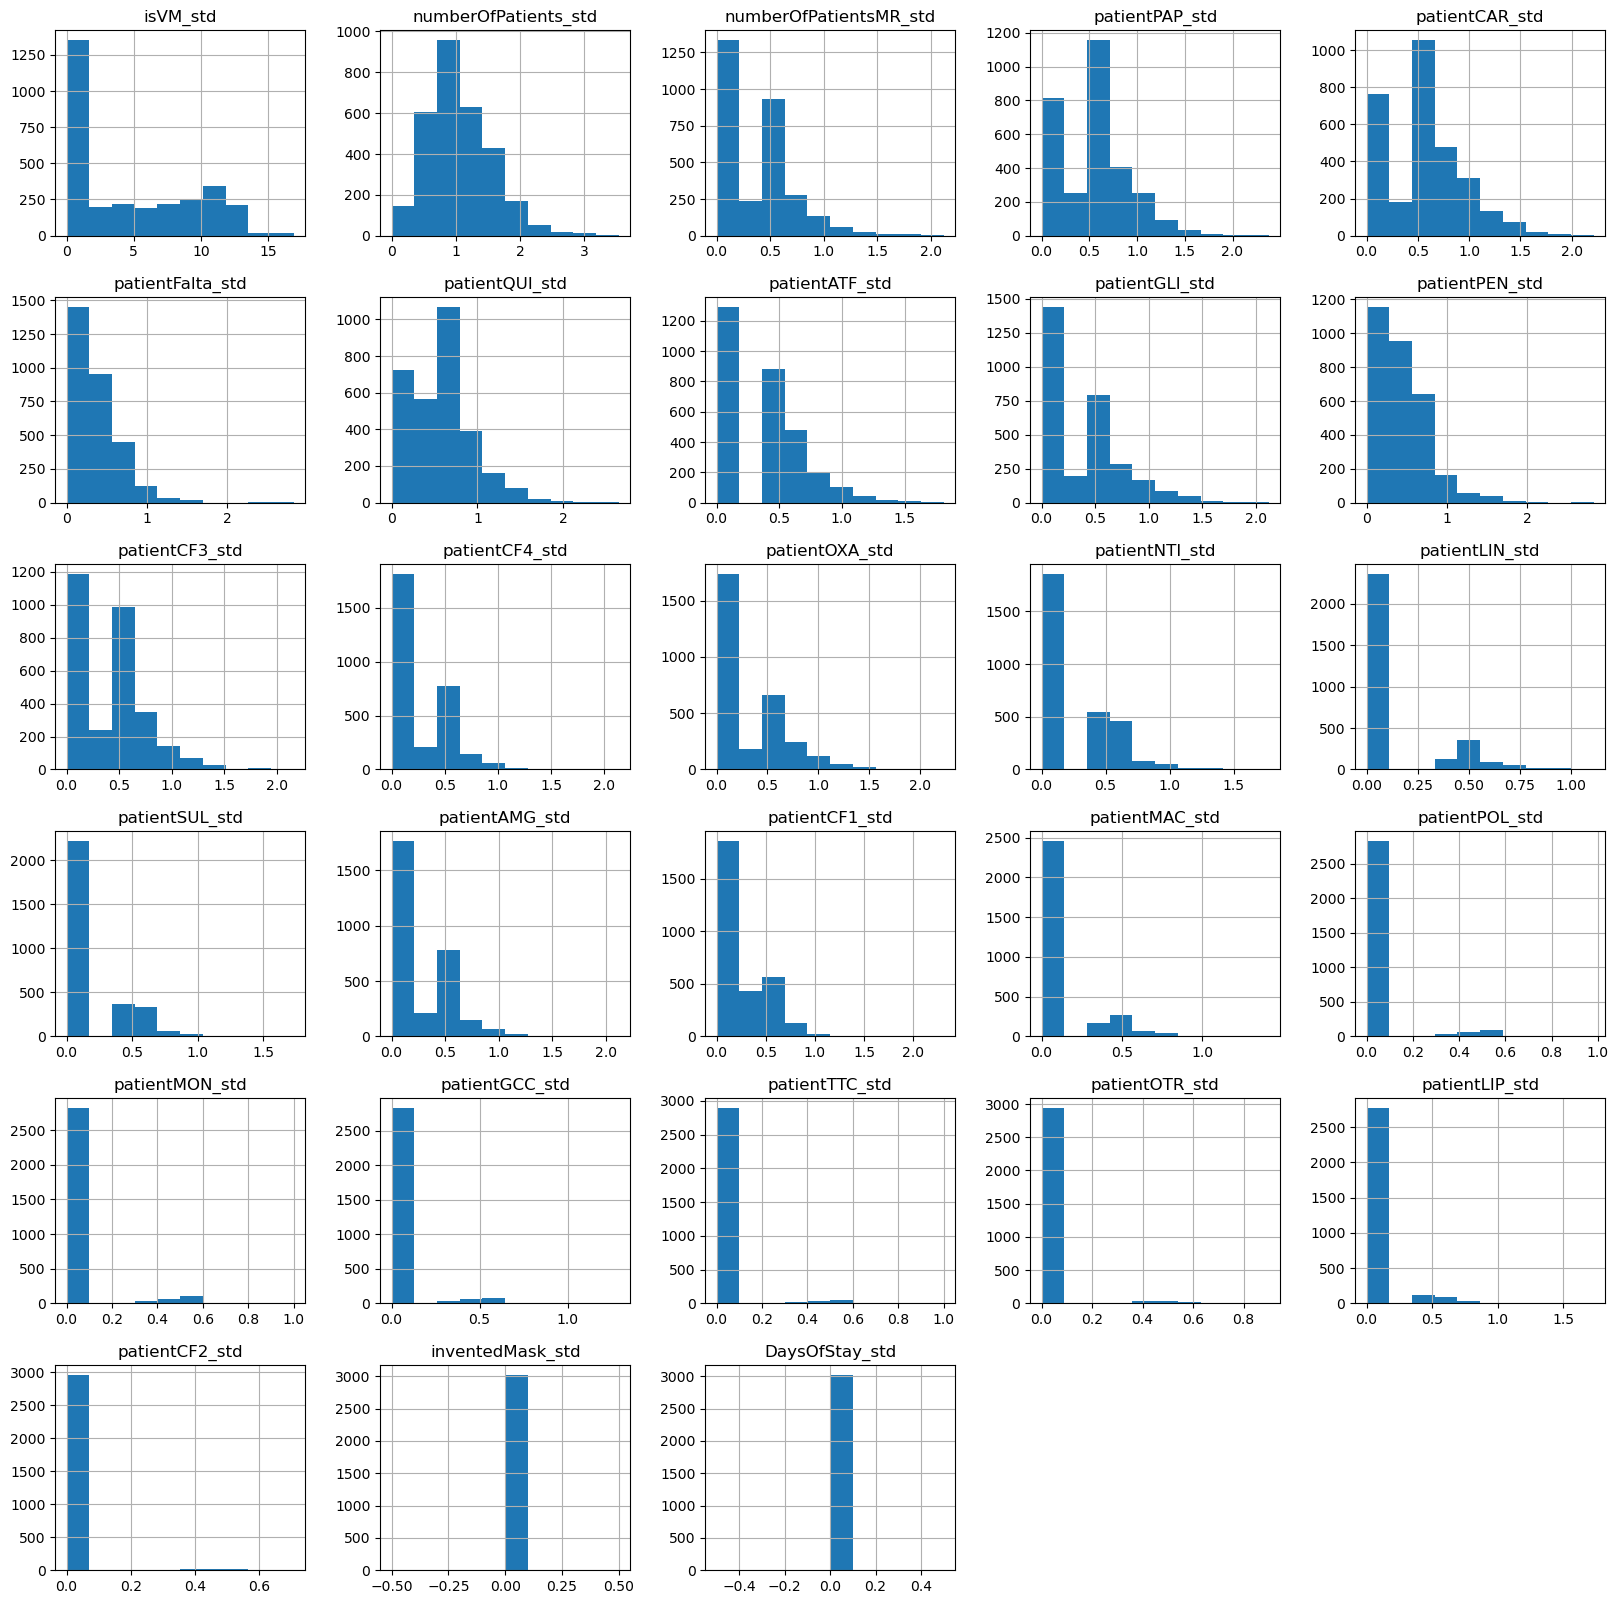

In [17]:
_ = df_std.hist(figsize=(20,20))

True
Feature:  isVM_std
True


<Figure size 640x480 with 0 Axes>

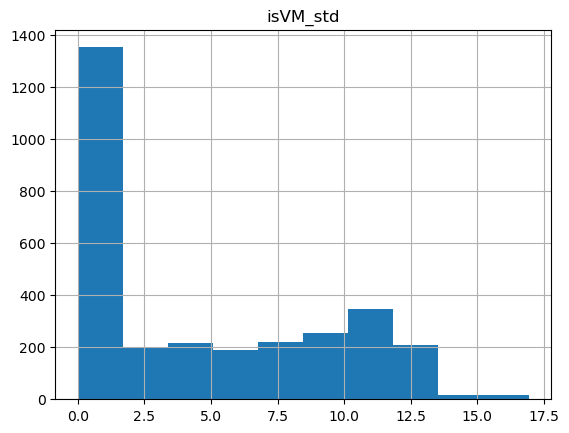

Feature:  numberOfPatients_std
True


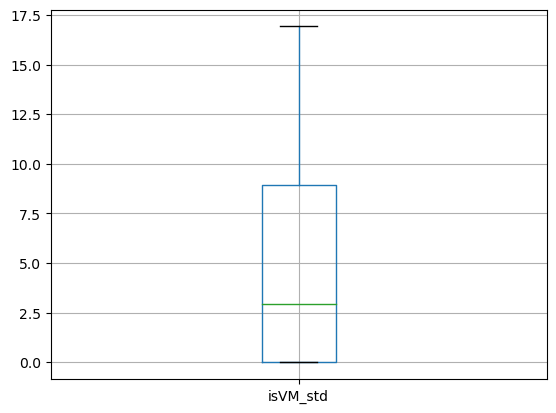

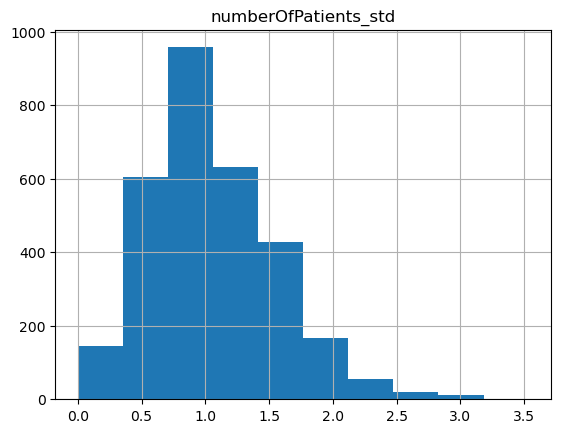

Feature:  numberOfPatientsMR_std
True


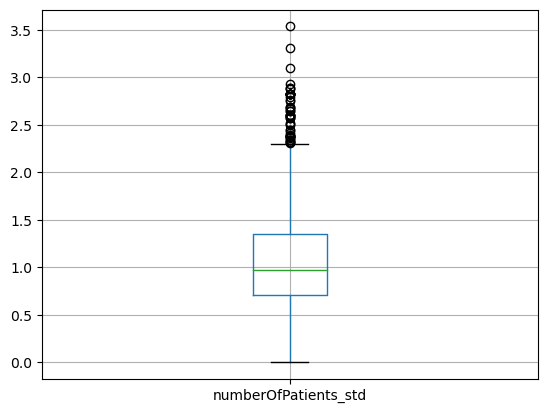

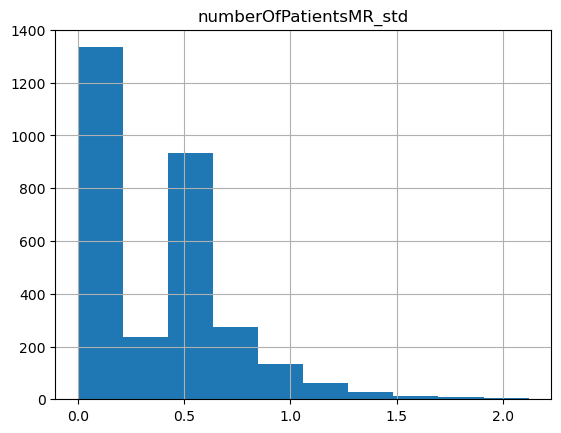

Feature:  patientPAP_std
True


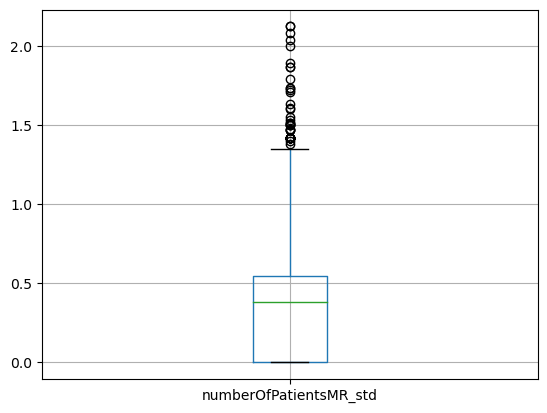

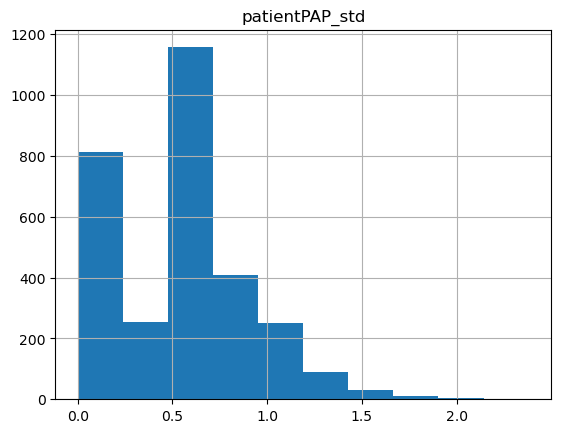

Feature:  patientCAR_std
True


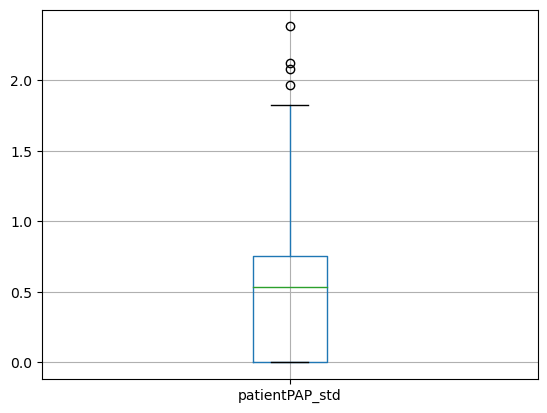

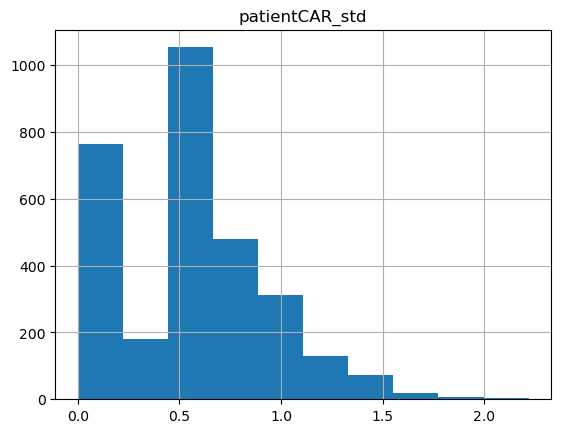

Feature:  patientFalta_std
True


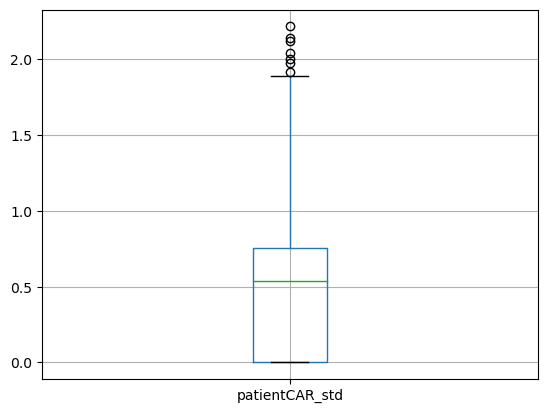

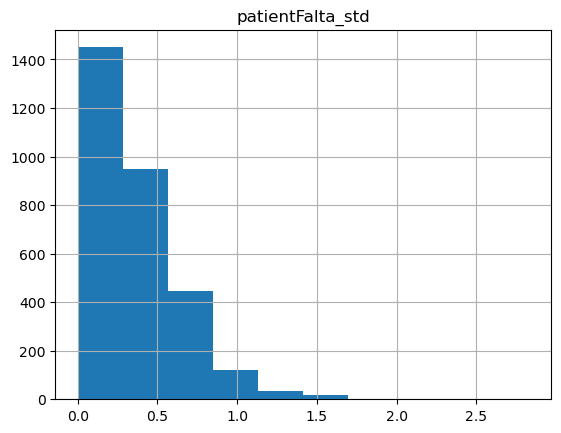

Feature:  patientQUI_std
True


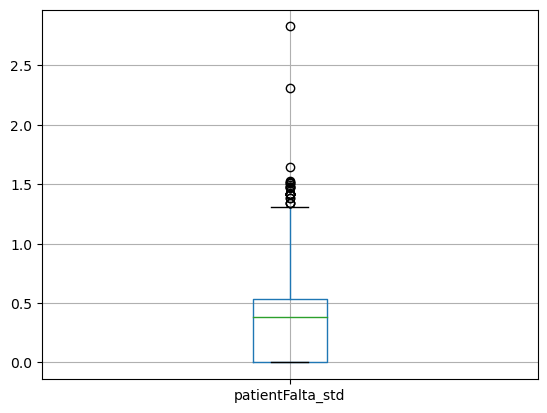

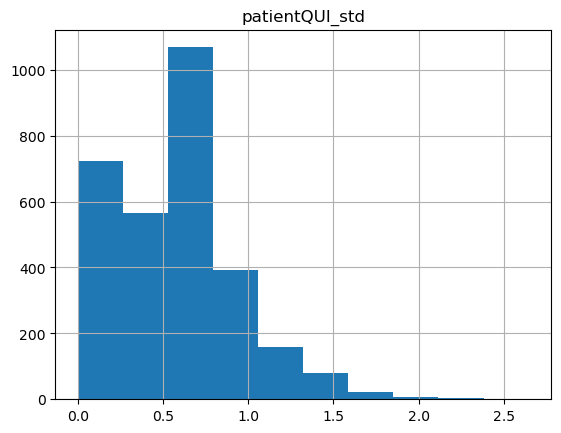

Feature:  patientATF_std
True


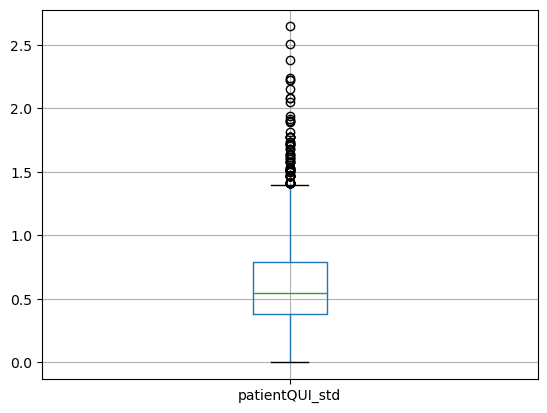

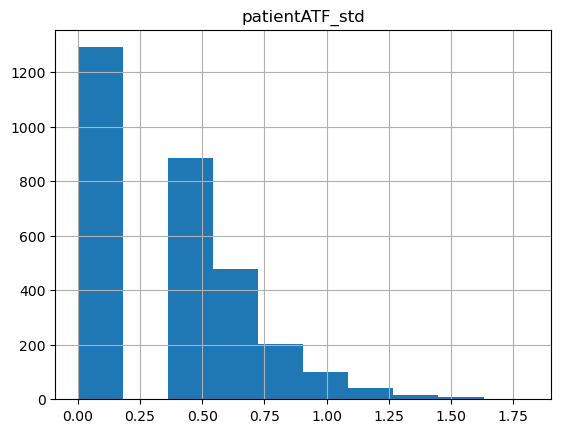

Feature:  patientGLI_std
True


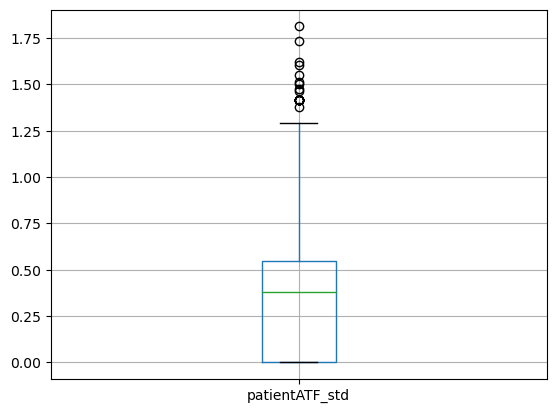

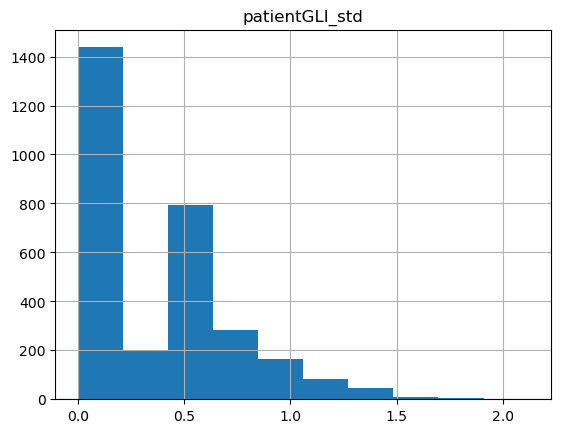

Feature:  patientPEN_std
True


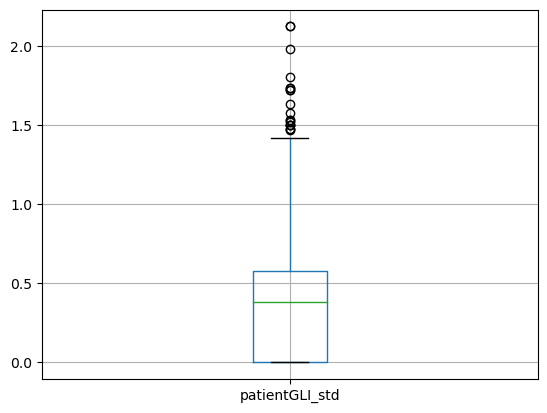

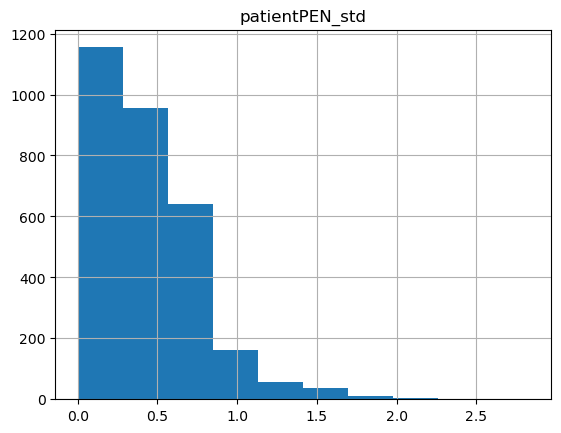

Feature:  patientCF3_std
True


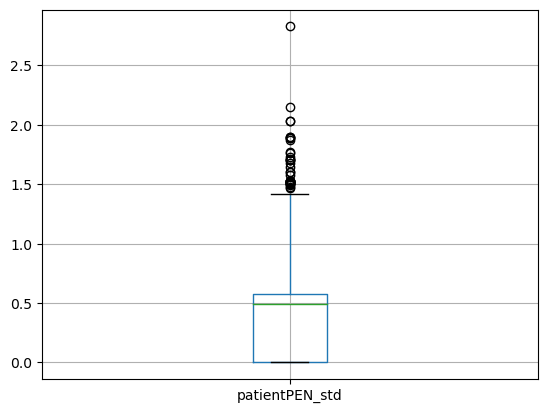

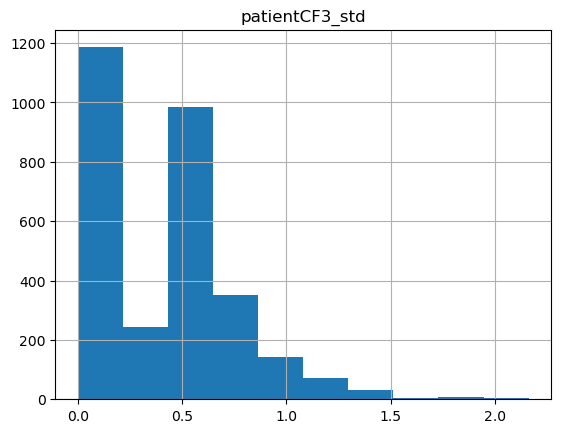

Feature:  patientCF4_std
True


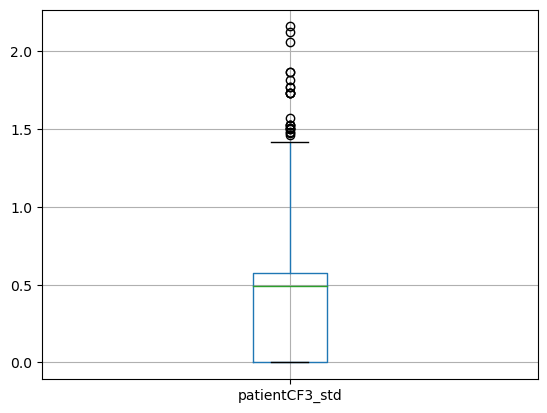

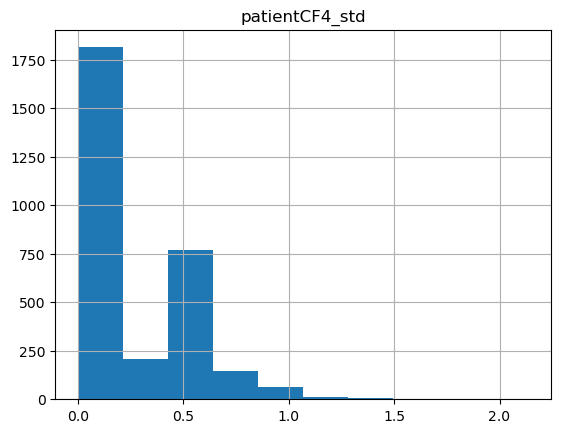

Feature:  patientOXA_std
True


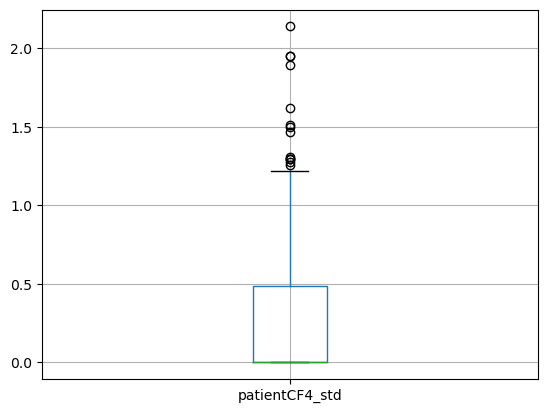

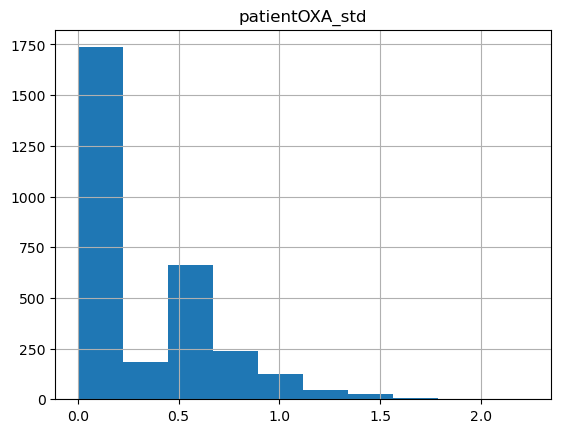

Feature:  patientNTI_std
True


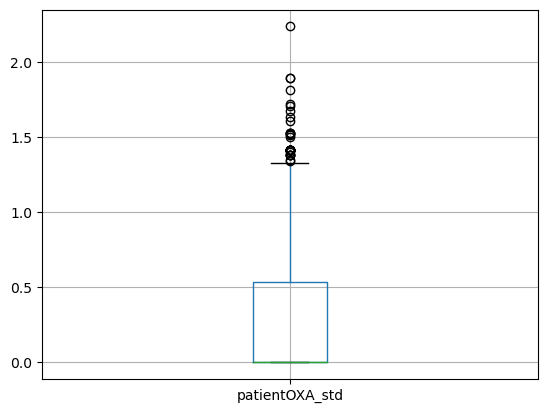

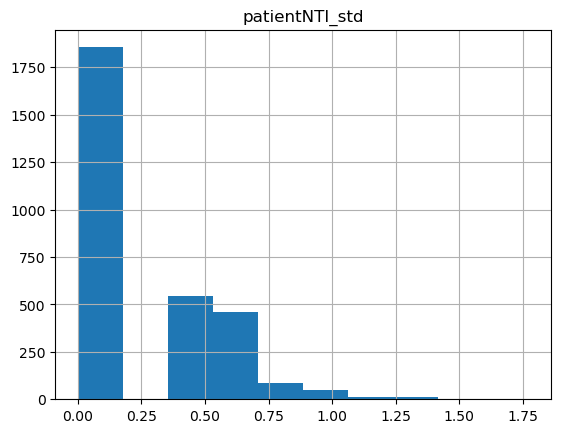

Feature:  patientLIN_std
True


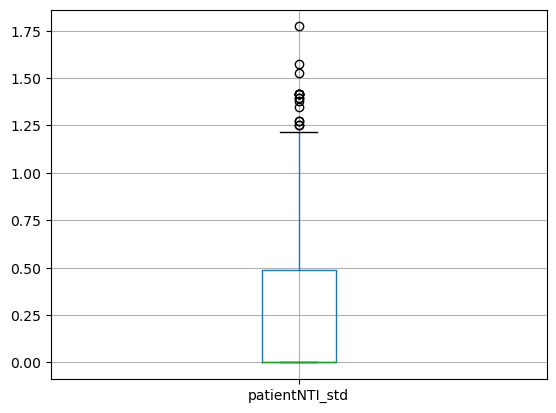

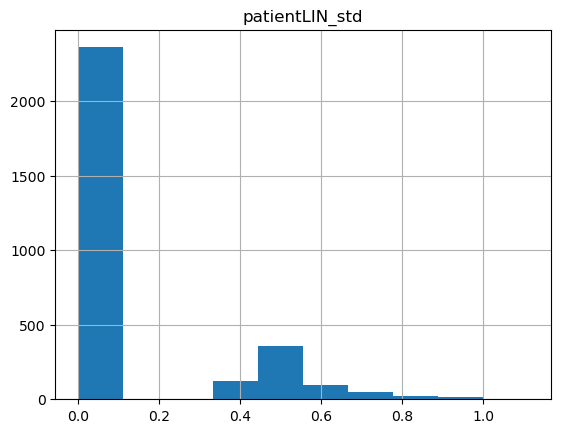

Feature:  patientSUL_std
True


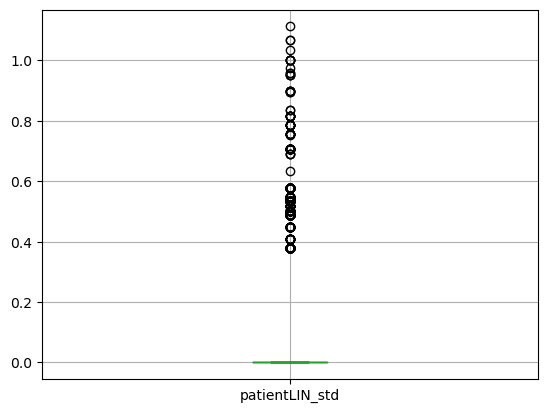

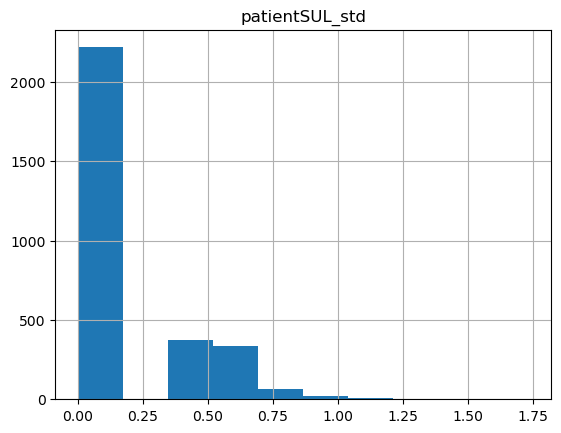

Feature:  patientAMG_std
True


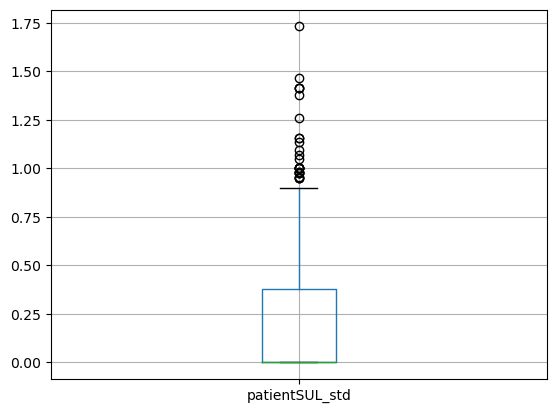

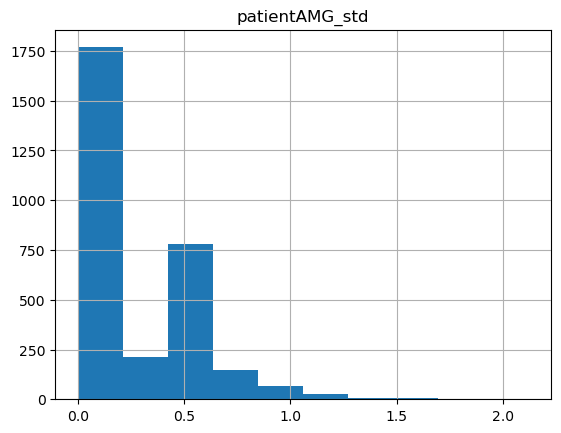

Feature:  patientCF1_std
True


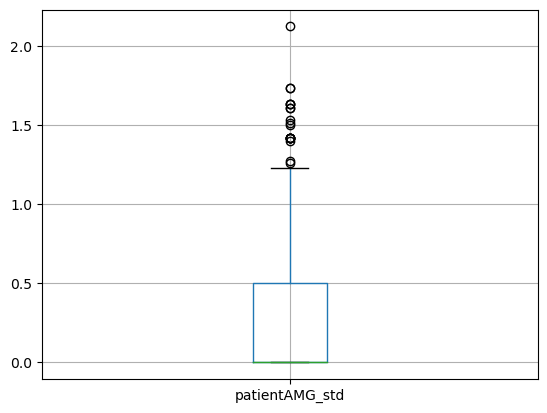

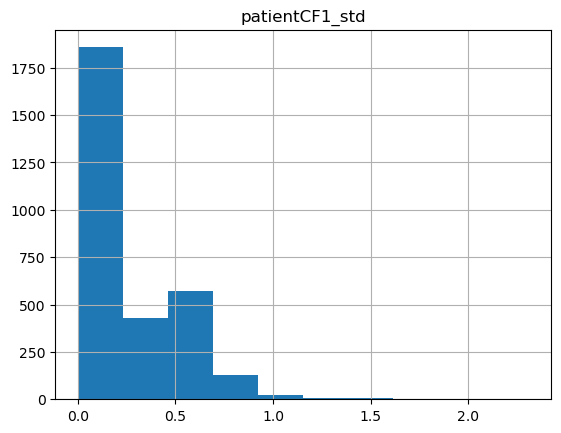

Feature:  patientMAC_std
True


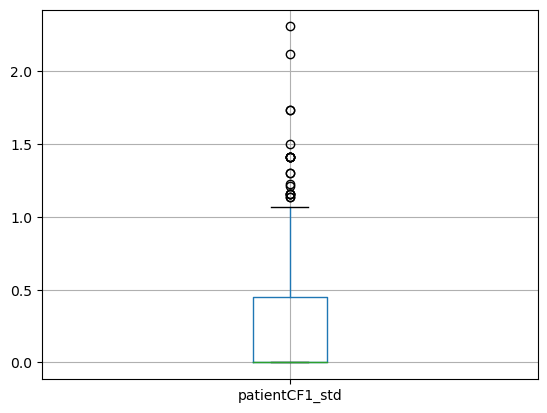

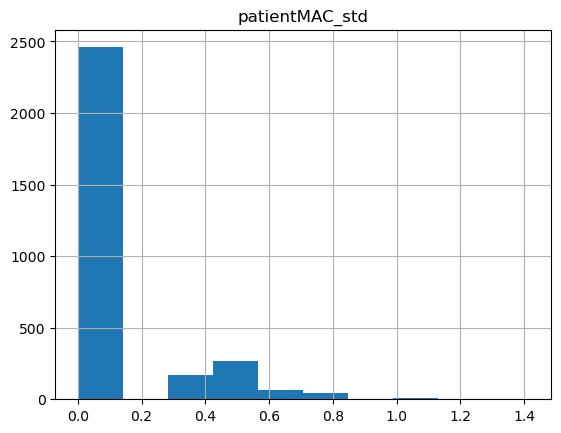

Feature:  patientPOL_std
True


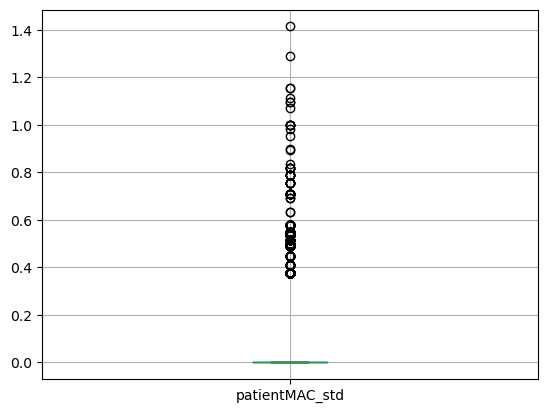

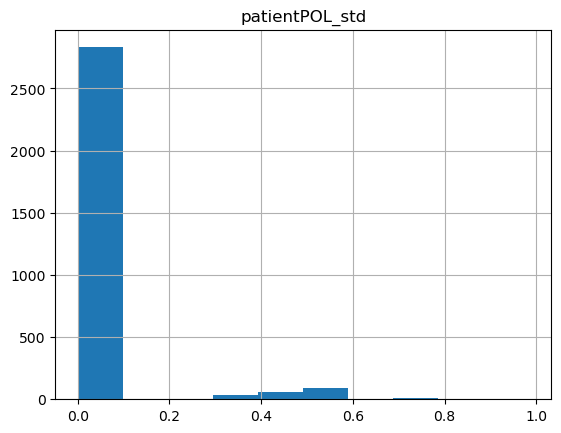

Feature:  patientMON_std
True


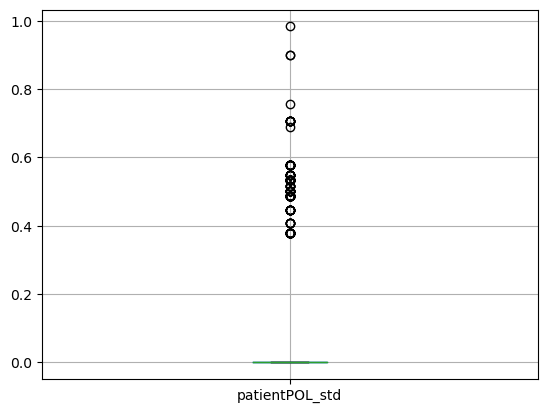

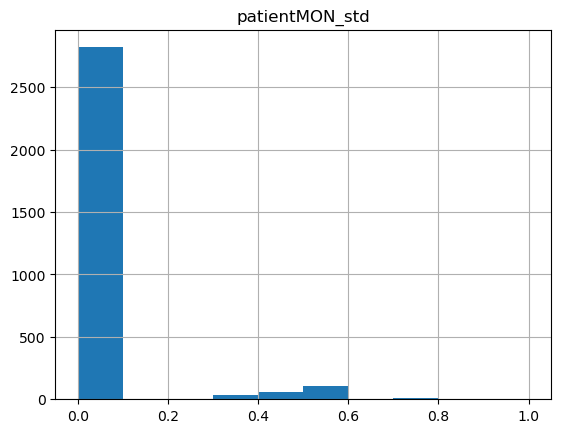

Feature:  patientGCC_std
True


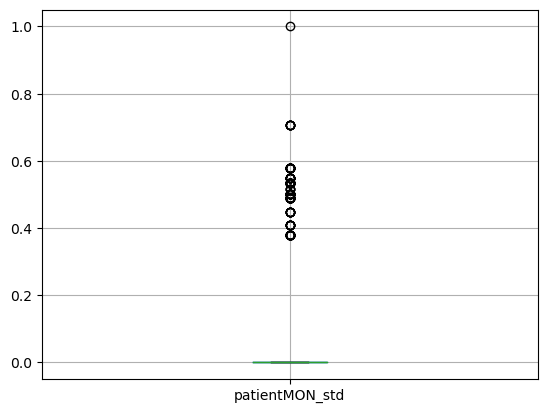

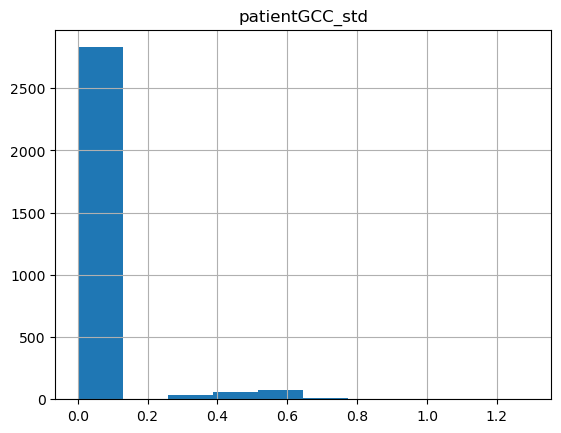

Feature:  patientTTC_std
True


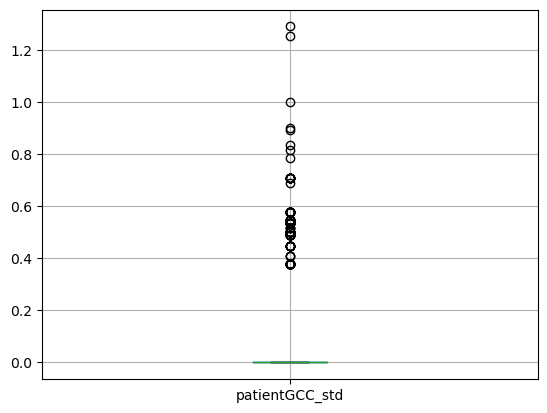

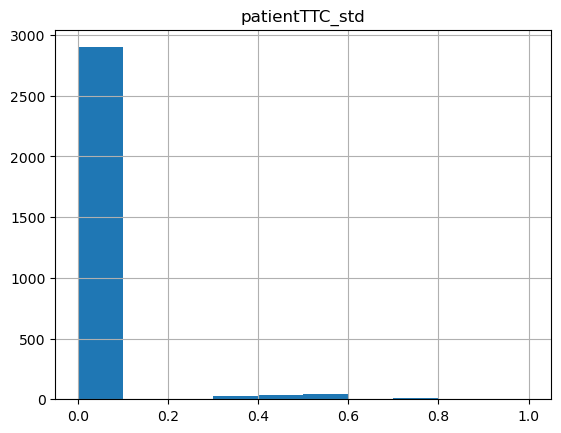

Feature:  patientOTR_std
True


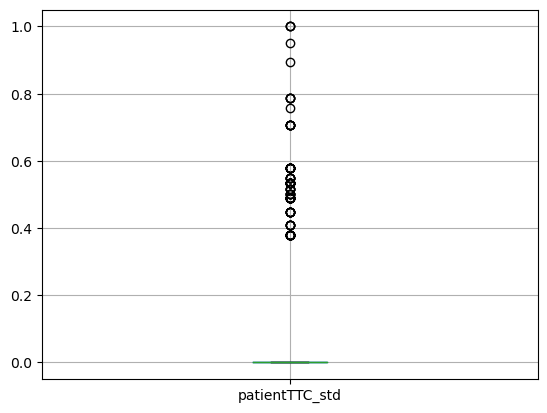

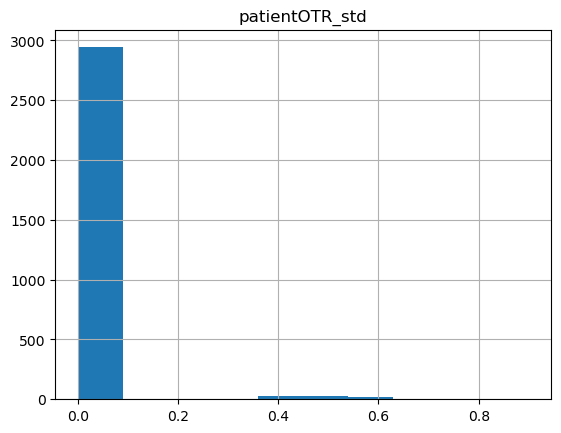

Feature:  patientLIP_std
True


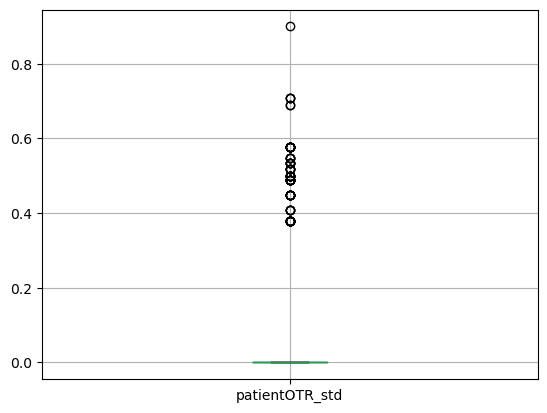

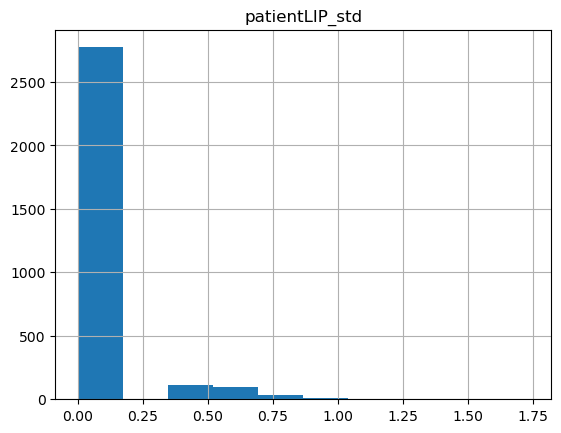

Feature:  patientCF2_std
True


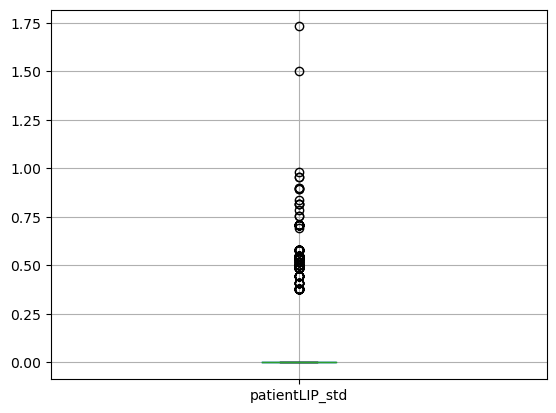

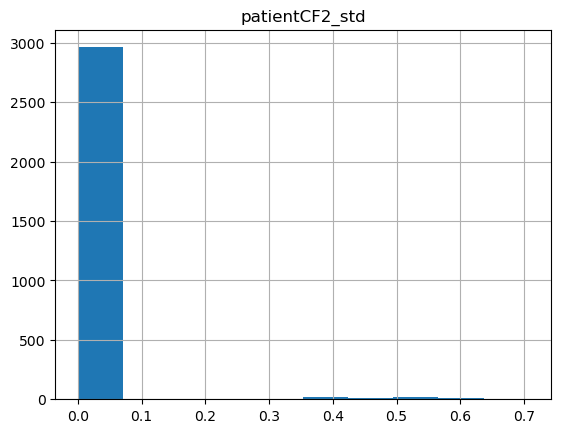

Feature:  inventedMask_std
True


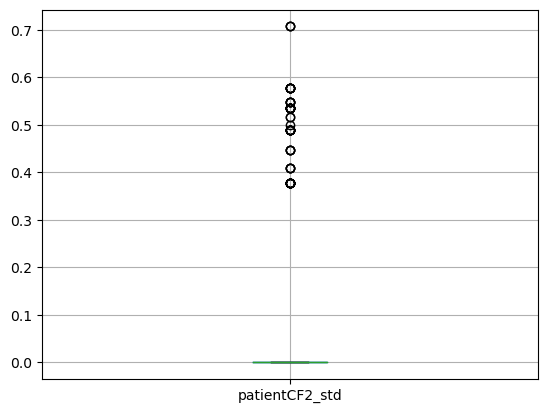

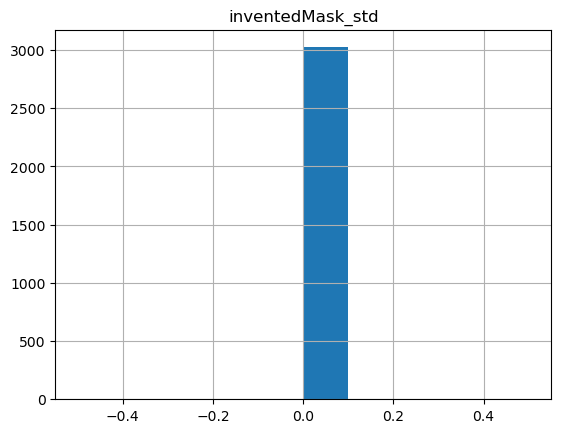

Feature:  DaysOfStay_std
True


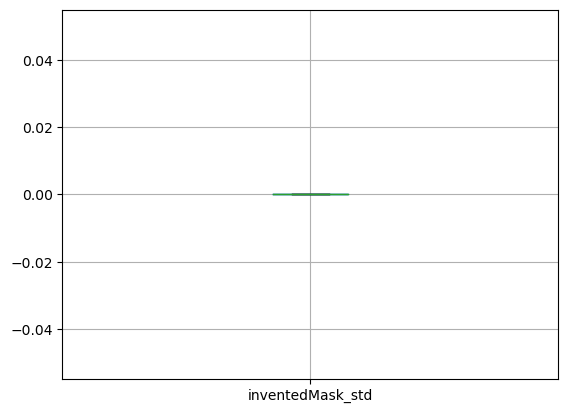

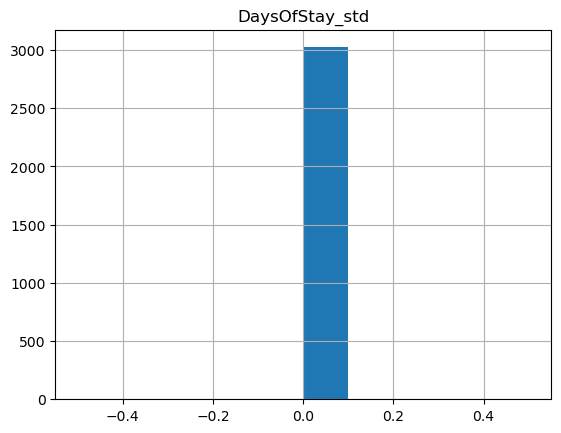

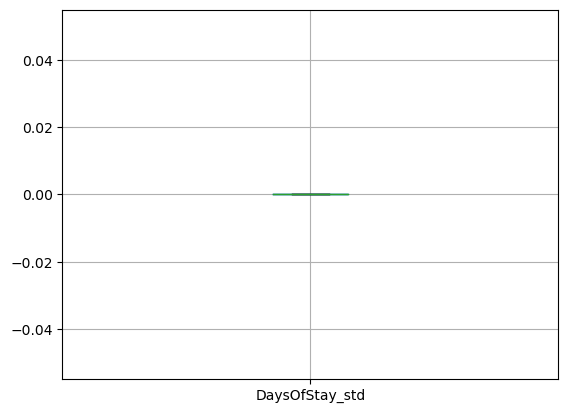

In [18]:
getDistribution(df_std)

# Mode

In [19]:
from scipy import stats

df_both = pd.read_csv("../df_to_load/Modelado_1/Datos_Originales/df_PreCovid.csv")
df_both_aux = df_both.drop(['Admissiondboid', 'dayToDone', 'MR',
                            'AMG', 'ATF', 'CAR', 'CF1',
                            'CF2', 'CF3', 'CF4', 'Falta', 'GCC', 'GLI', 'LIN', 'LIP', 'MAC', 'MON',
                            'NTI', 'OTR', 'OXA', 'PAP', 'PEN', 'POL', 'QUI', 'SUL', 'TTC'],axis=1)
keys = df_both_aux.keys()
print(keys)
mat = np.zeros((int(df_both_aux.shape[0]/numTimeStep), len(keys)-1))
inf = 0
sup = numTimeStep-1

admissiondboid = []
for indexx in range(int(df_both_aux.shape[0]/numTimeStep)):
    #############################################################################
    #Eliminate those instants when the patient is not in the ICU.
    idx = df_both_aux[inf:sup]['inventedMask'].values != 0
    idx = np.argwhere(idx.astype('uint8') == 0)
   
    index=[]
    for j in range(idx.shape[0]):
        index.append(idx[j][0])
    
    aux = df_both_aux.loc[inf:sup]
    aux = aux.reset_index(drop=True)
    aux_2 = aux.drop(index,axis=0)
    aux_2 = aux_2.reset_index(drop=True)
    #if indexx == 2:
    #    break
    #############################################################################
    keys_aux = np.delete(keys, 0)
    for i in range(len(keys_aux)):
        mat[indexx,i] = aux_2[keys_aux[i]].mode()[0]
    inf = sup + 1 
    sup += numTimeStep

df_mode = pd.DataFrame(mat)

new_names = []
for i in range(len(keys_aux)):
    new_names.append(keys_aux[i]+str("_mode"))
    
df_mode.columns = new_names

Index(['isVM', 'numberOfPatients', 'numberOfPatientsMR', 'patientPAP',
       'patientCAR', 'patientFalta', 'patientQUI', 'patientATF', 'patientGLI',
       'patientPEN', 'patientCF3', 'patientCF4', 'patientOXA', 'patientNTI',
       'patientLIN', 'patientSUL', 'patientAMG', 'patientCF1', 'patientMAC',
       'patientPOL', 'patientMON', 'patientGCC', 'patientTTC', 'patientOTR',
       'patientLIP', 'patientCF2', 'inventedMask', 'DaysOfStay'],
      dtype='object')


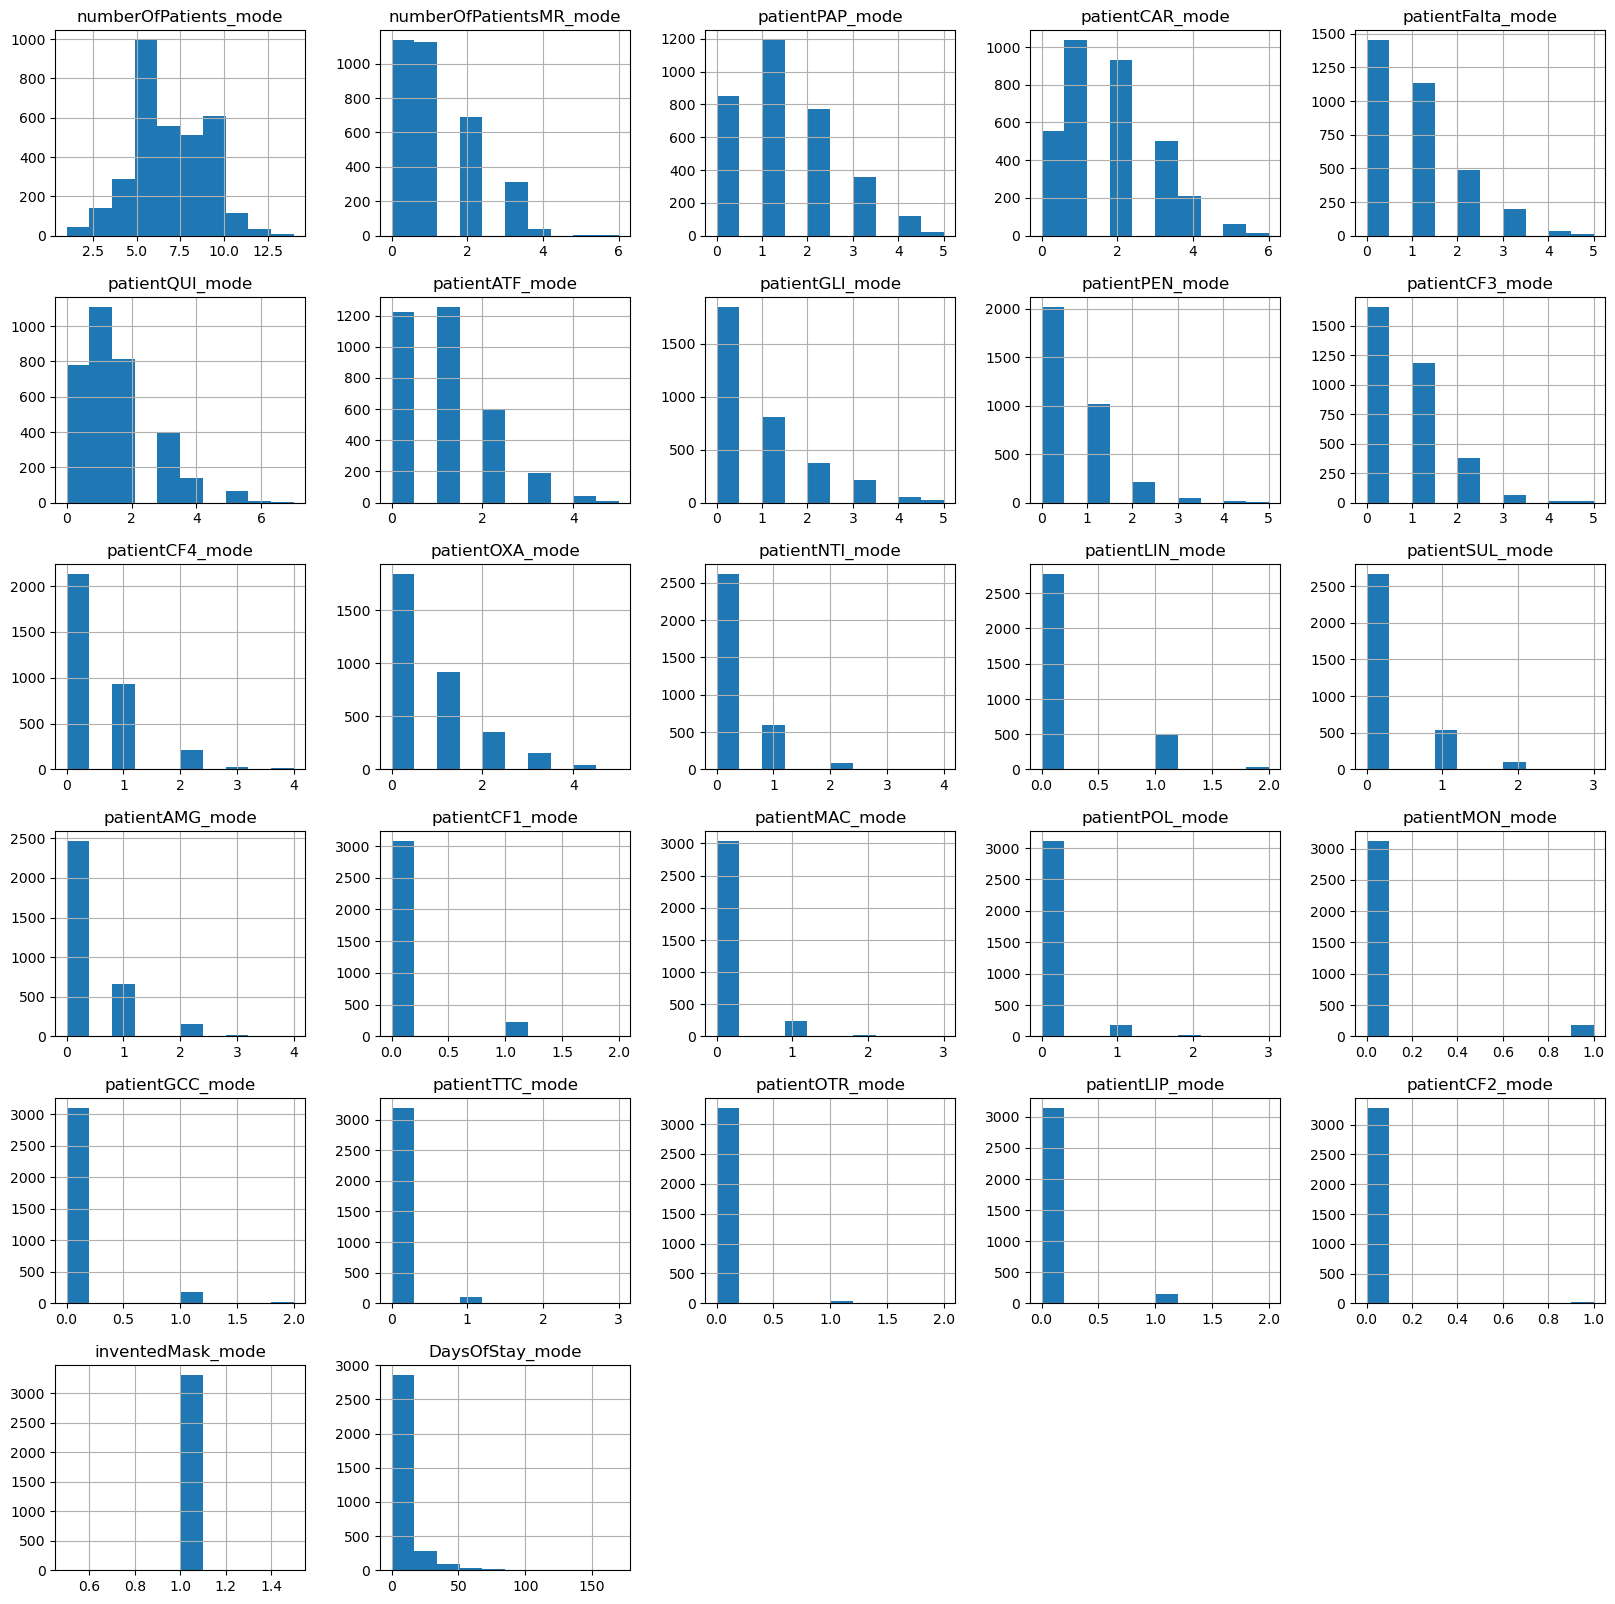

In [20]:
_ = df_mode.hist(figsize=(20,20))

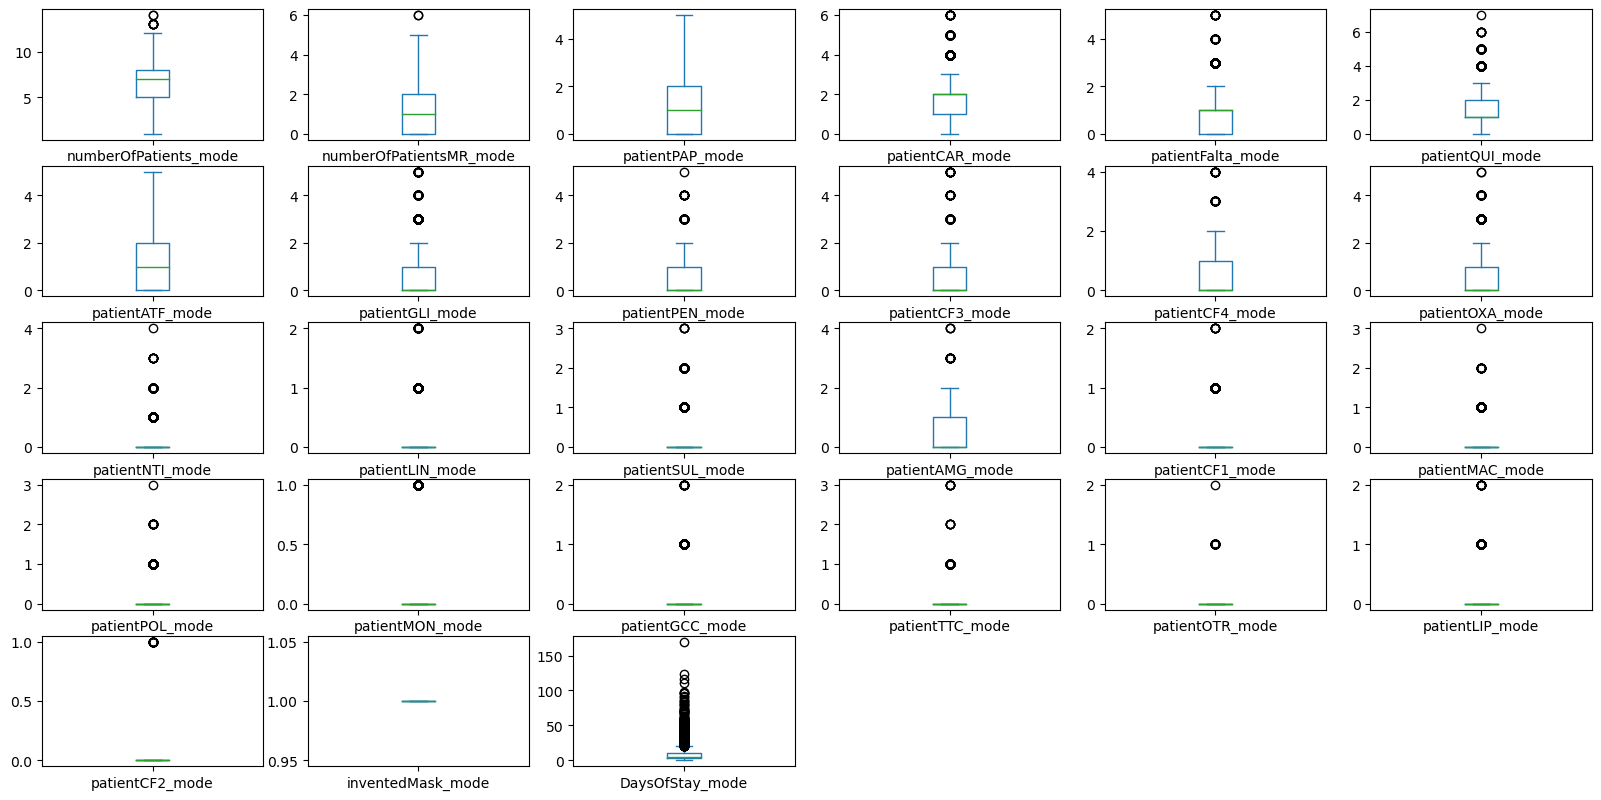

In [21]:
_ = df_mode.plot(kind='box', subplots=True, layout = (10,6), figsize=(20,20))

False
Feature:  numberOfPatients_mode
False


<Figure size 640x480 with 0 Axes>

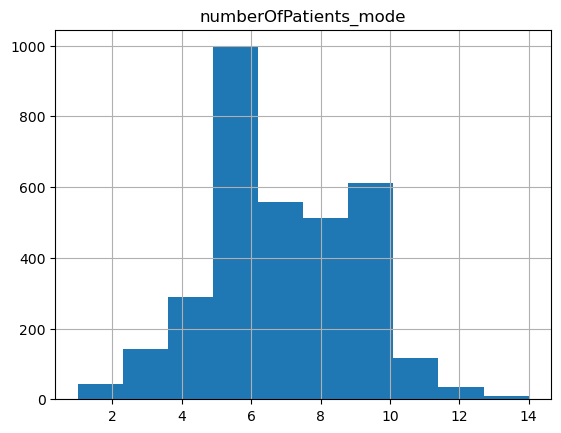

Feature:  numberOfPatientsMR_mode
False


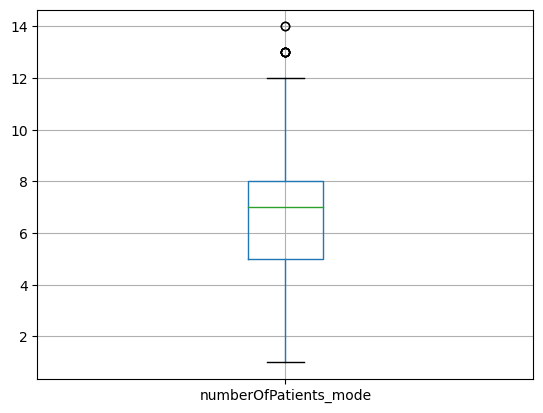

<Figure size 640x480 with 0 Axes>

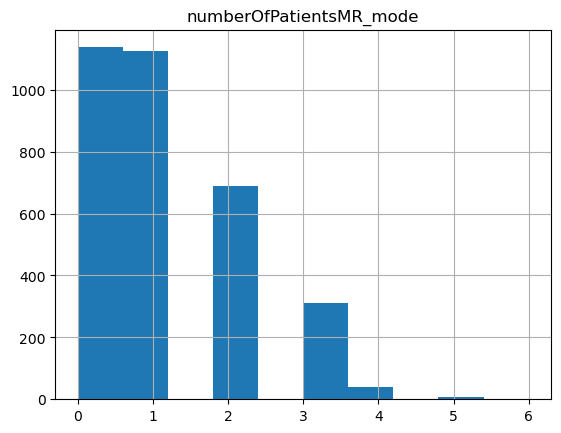

Feature:  patientPAP_mode
False


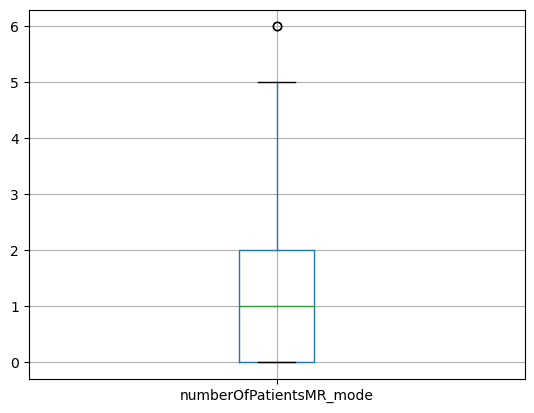

<Figure size 640x480 with 0 Axes>

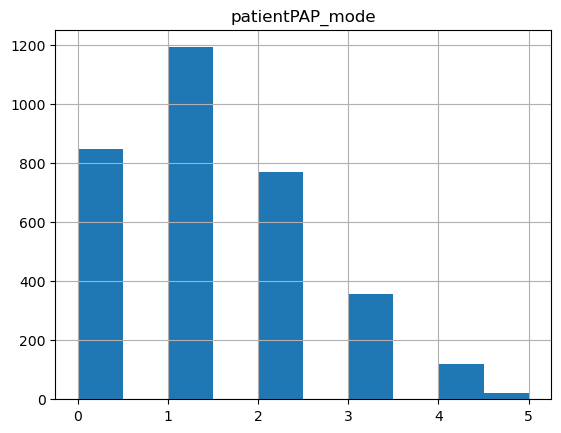

Feature:  patientCAR_mode
False


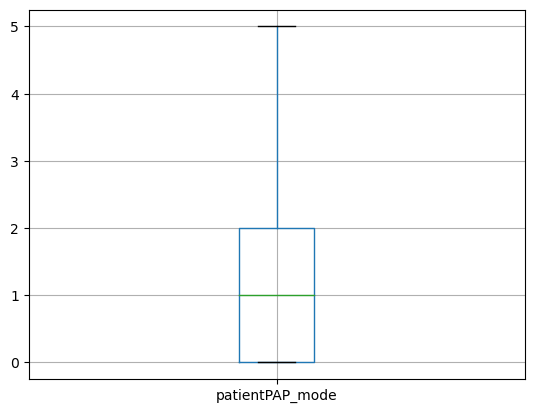

<Figure size 640x480 with 0 Axes>

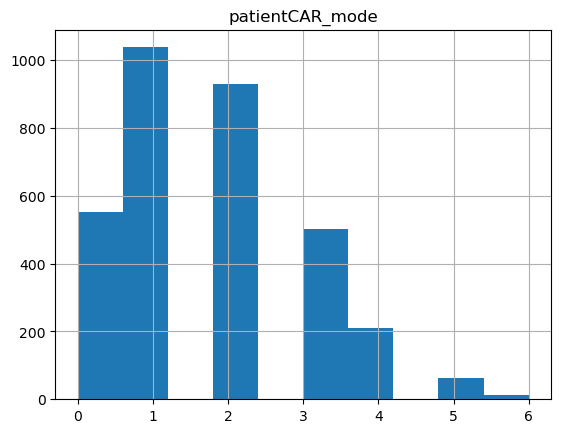

Feature:  patientFalta_mode
False


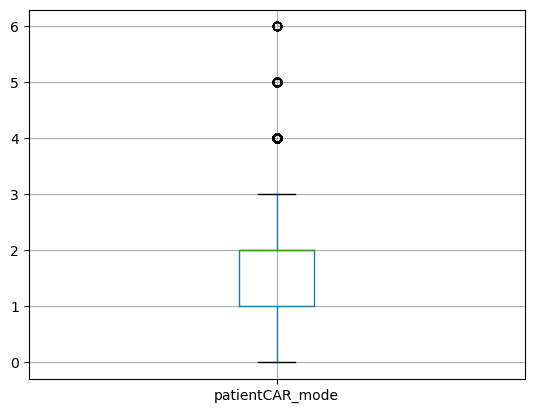

<Figure size 640x480 with 0 Axes>

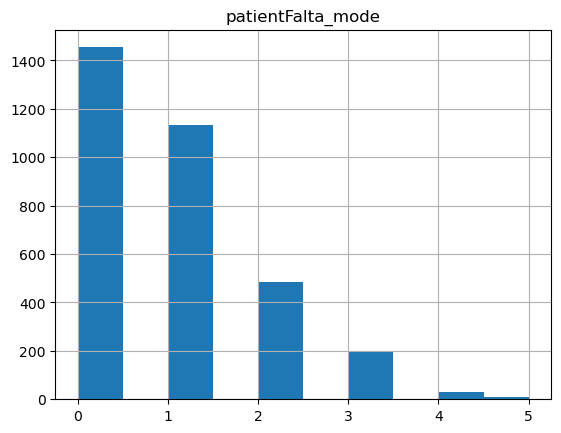

Feature:  patientQUI_mode
False


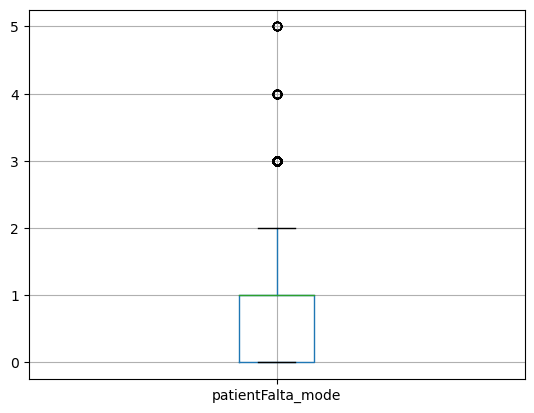

<Figure size 640x480 with 0 Axes>

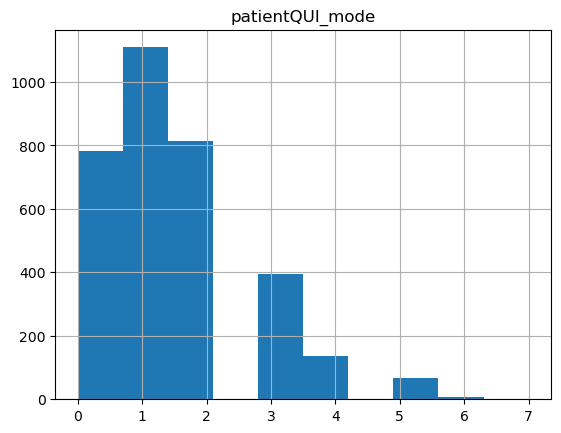

Feature:  patientATF_mode
False


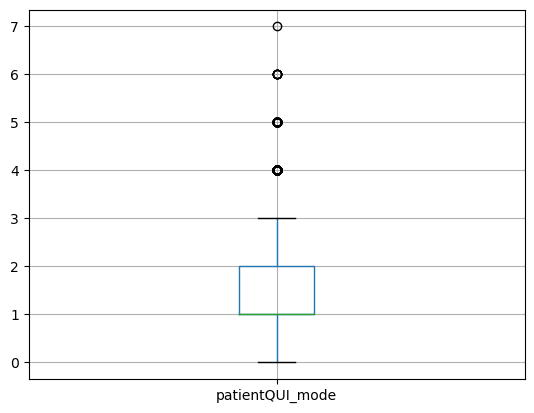

<Figure size 640x480 with 0 Axes>

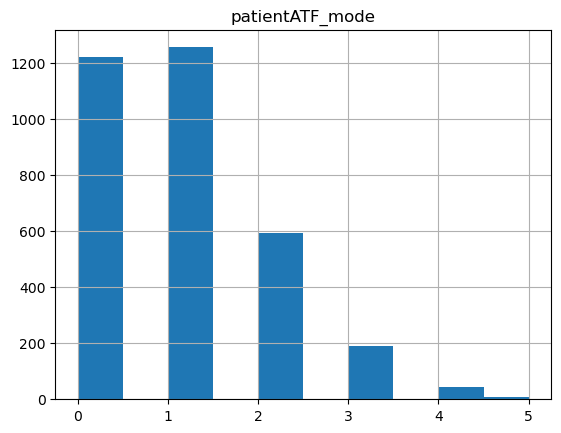

Feature:  patientGLI_mode
False


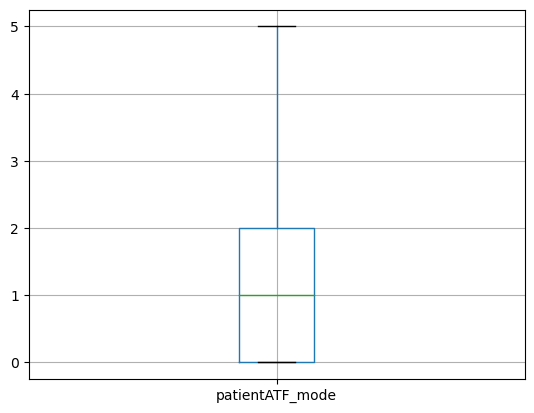

<Figure size 640x480 with 0 Axes>

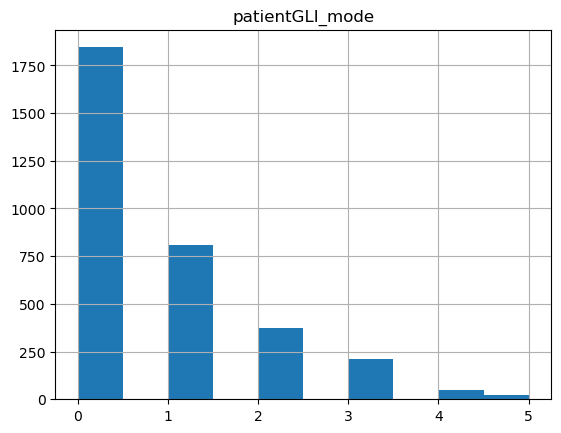

Feature:  patientPEN_mode
False


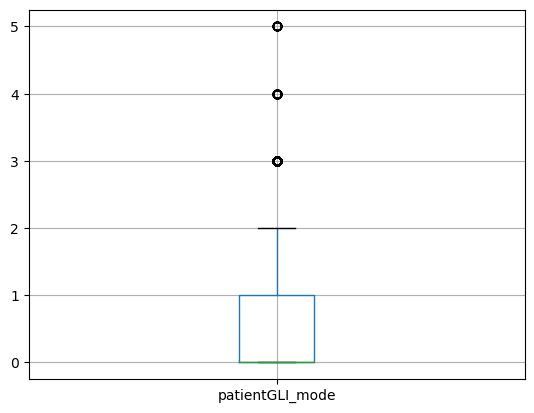

<Figure size 640x480 with 0 Axes>

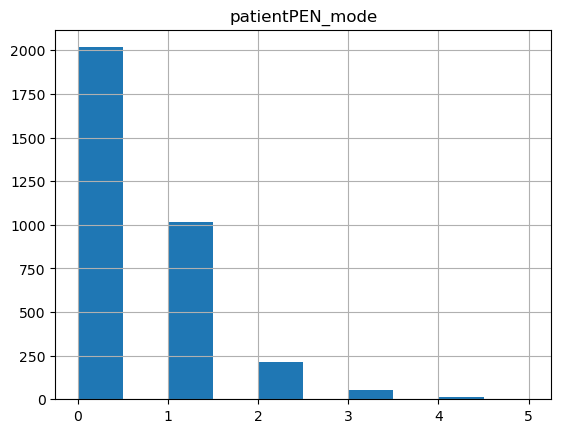

Feature:  patientCF3_mode
False


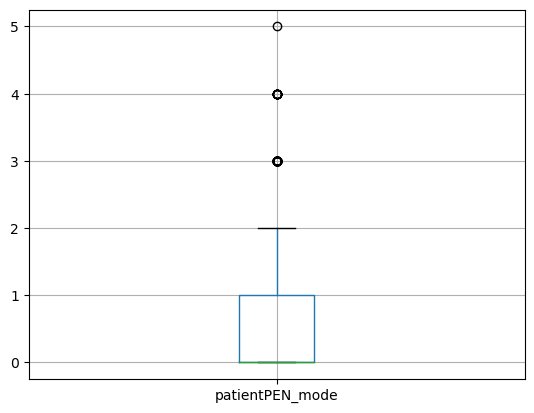

<Figure size 640x480 with 0 Axes>

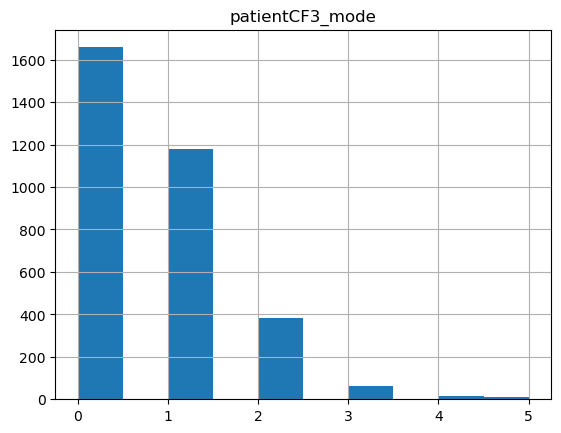

Feature:  patientCF4_mode
False


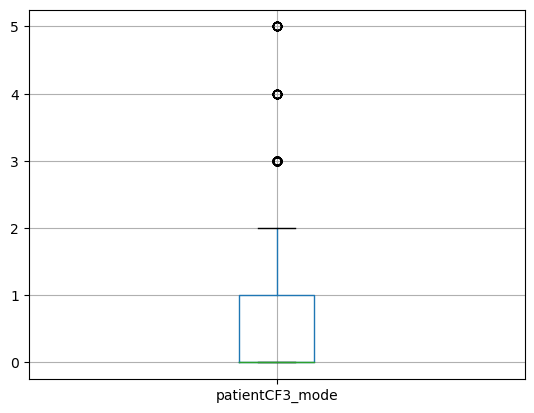

<Figure size 640x480 with 0 Axes>

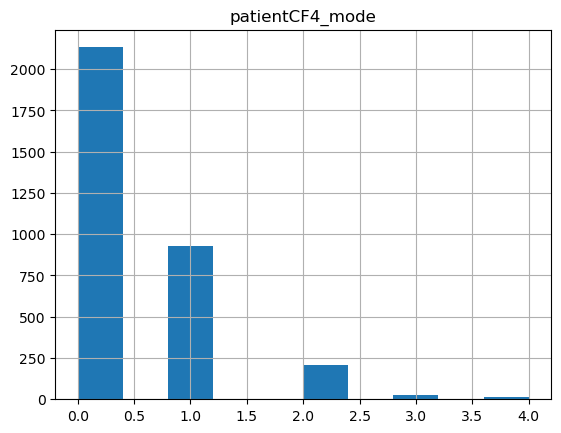

Feature:  patientOXA_mode
False


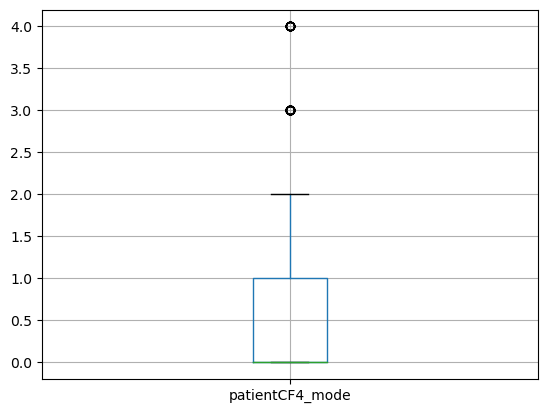

<Figure size 640x480 with 0 Axes>

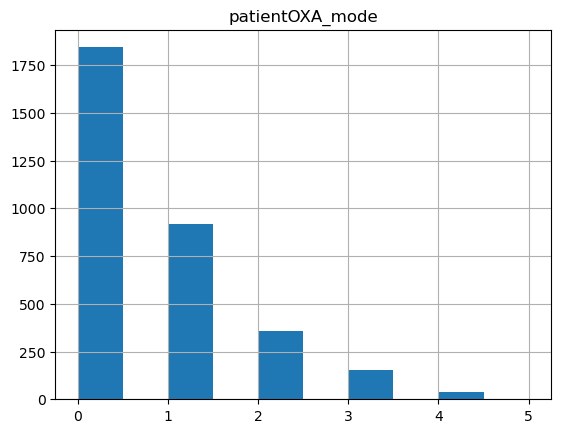

Feature:  patientNTI_mode
False


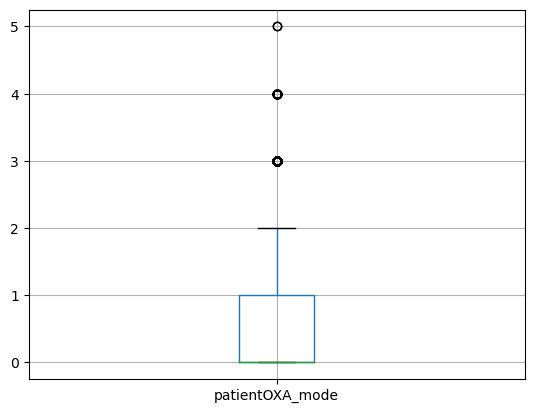

<Figure size 640x480 with 0 Axes>

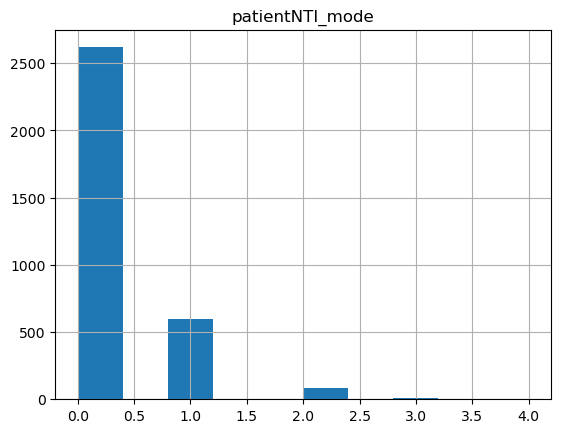

Feature:  patientLIN_mode
False


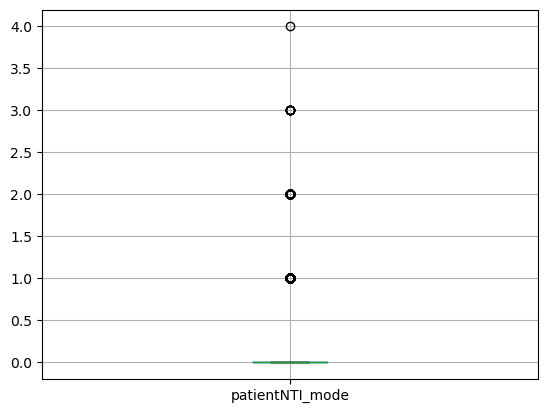

<Figure size 640x480 with 0 Axes>

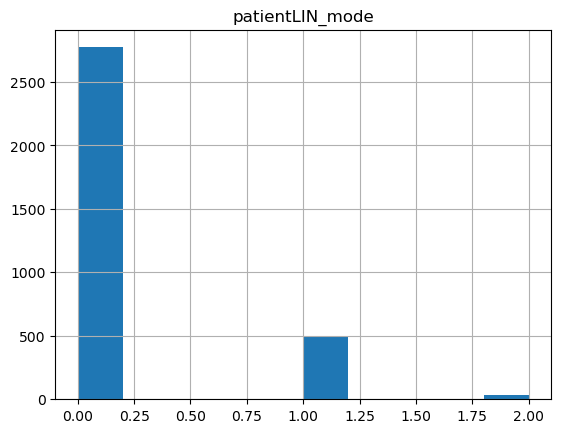

Feature:  patientSUL_mode
False


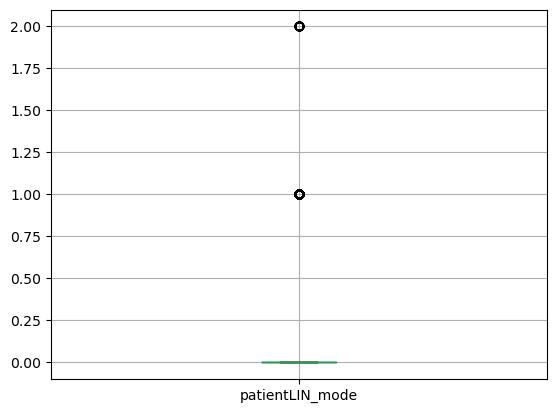

<Figure size 640x480 with 0 Axes>

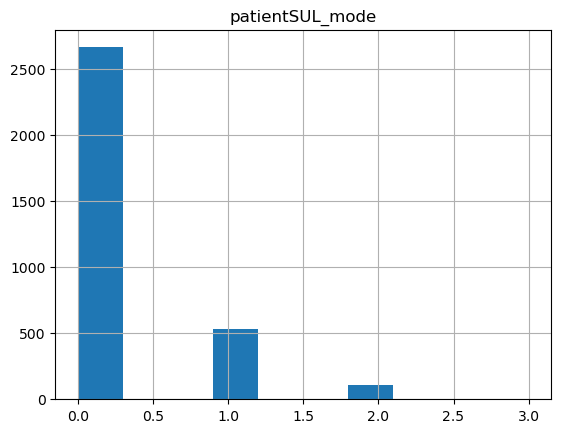

Feature:  patientAMG_mode
False


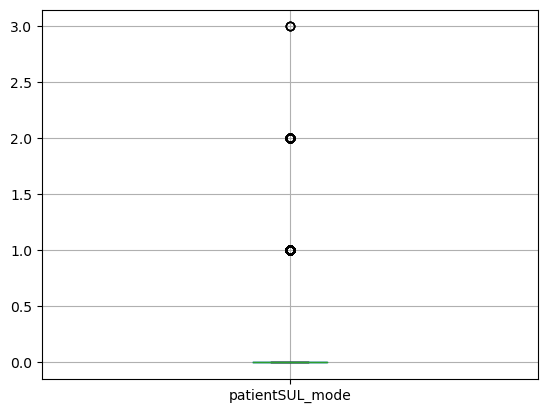

<Figure size 640x480 with 0 Axes>

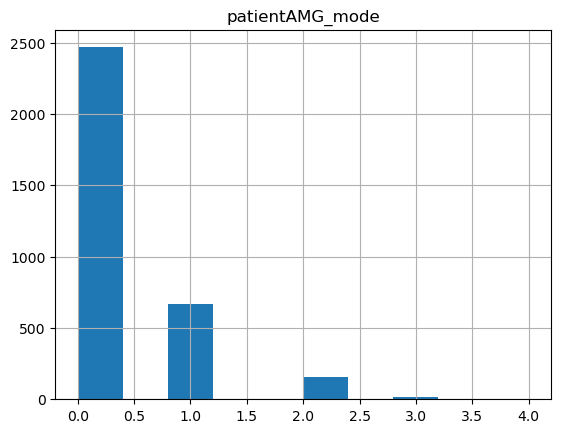

Feature:  patientCF1_mode
False


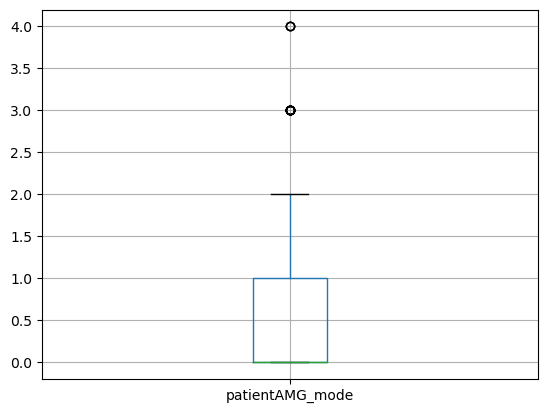

<Figure size 640x480 with 0 Axes>

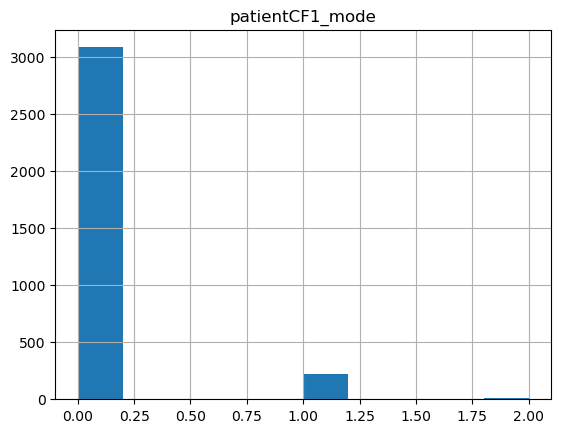

Feature:  patientMAC_mode
False


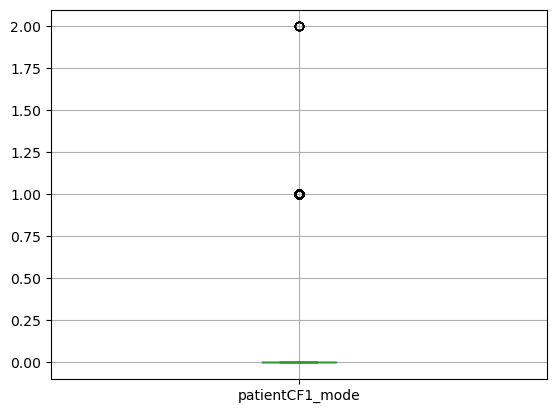

<Figure size 640x480 with 0 Axes>

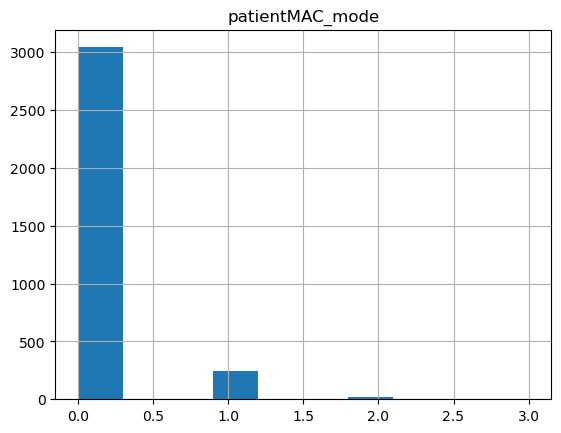

Feature:  patientPOL_mode
False


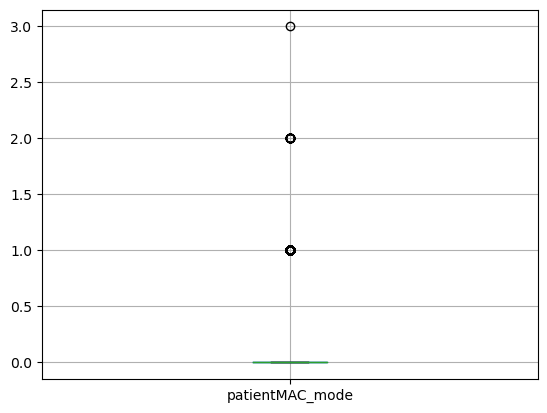

<Figure size 640x480 with 0 Axes>

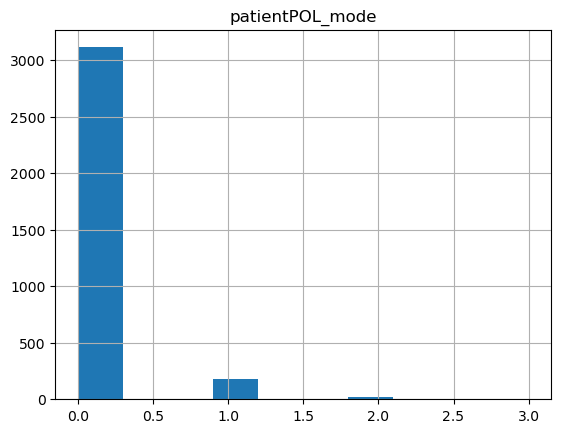

Feature:  patientMON_mode
False


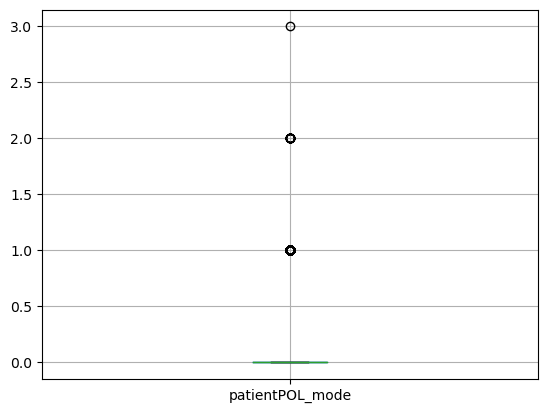

<Figure size 640x480 with 0 Axes>

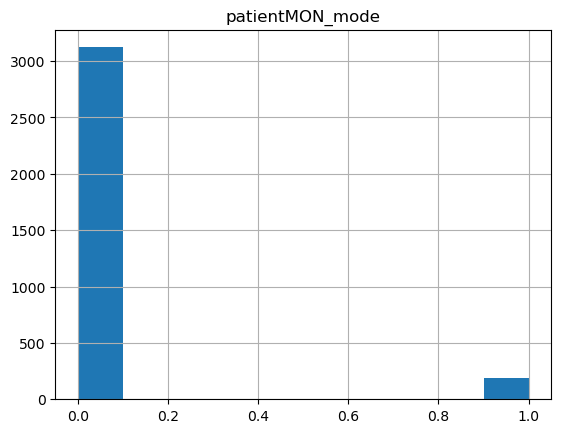

Feature:  patientGCC_mode
False


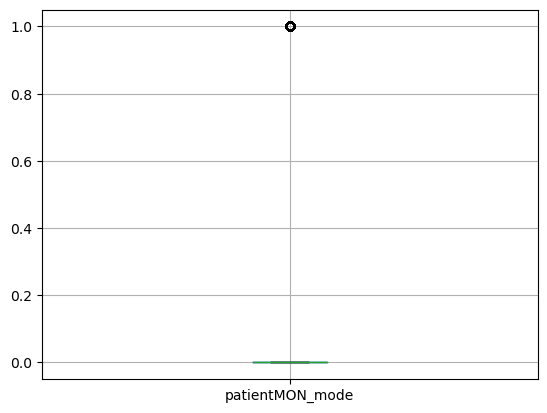

<Figure size 640x480 with 0 Axes>

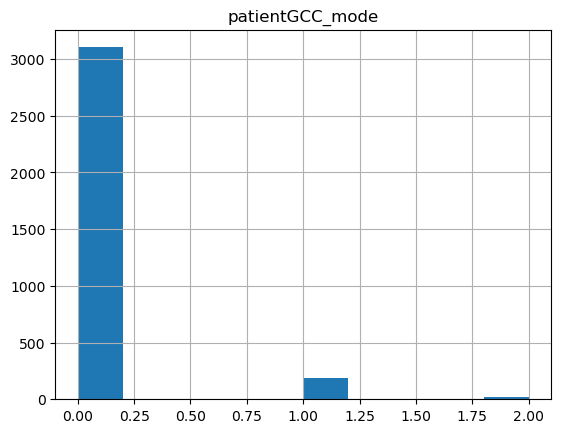

Feature:  patientTTC_mode
False


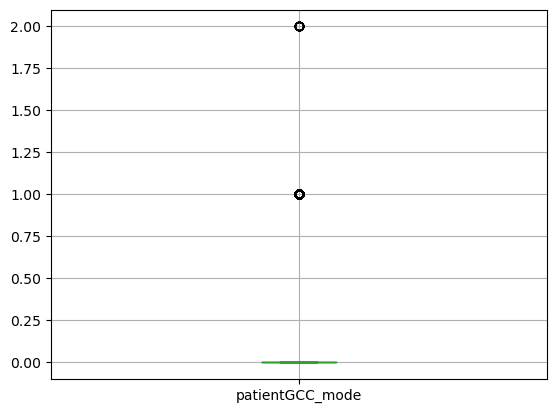

<Figure size 640x480 with 0 Axes>

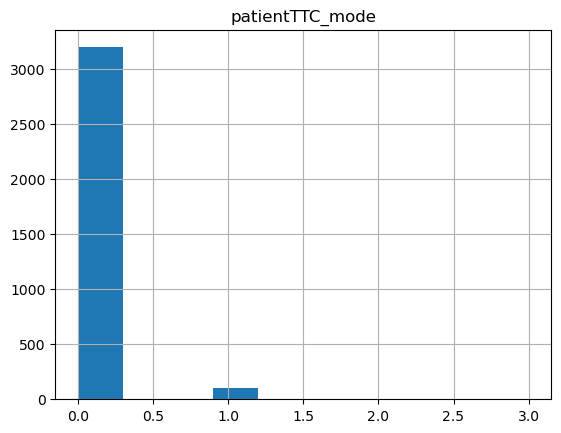

Feature:  patientOTR_mode
False


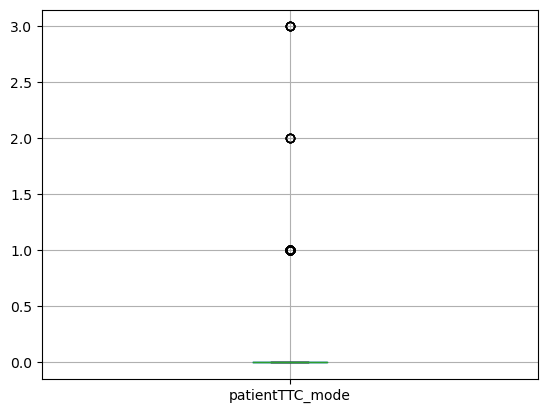

<Figure size 640x480 with 0 Axes>

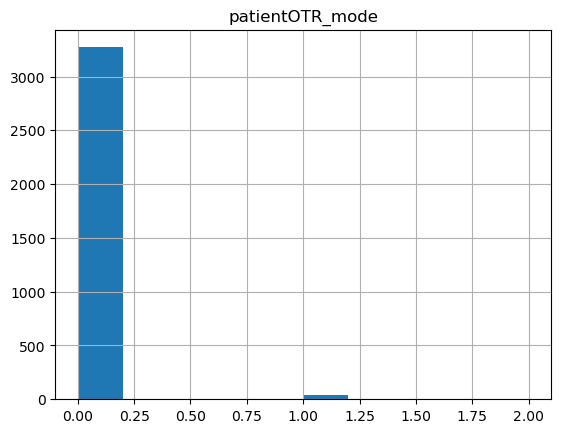

Feature:  patientLIP_mode
False


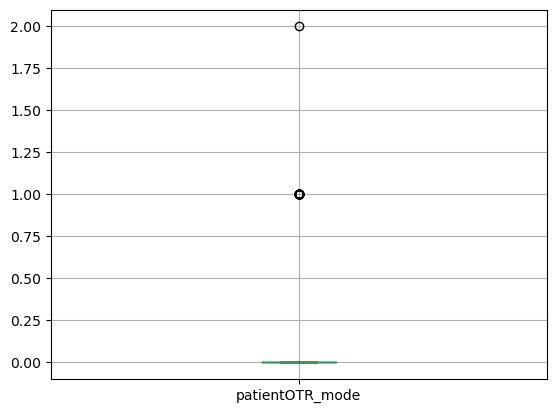

<Figure size 640x480 with 0 Axes>

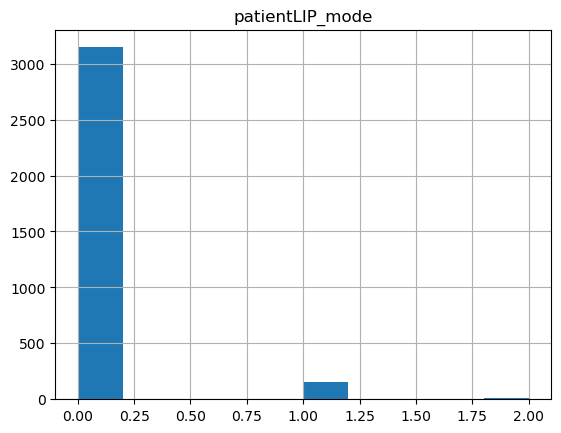

Feature:  patientCF2_mode
False


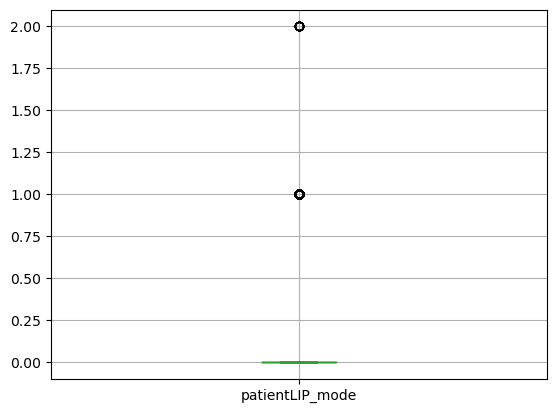

<Figure size 640x480 with 0 Axes>

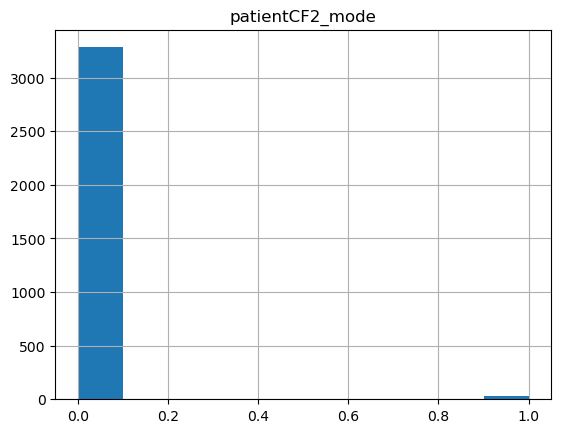

Feature:  inventedMask_mode
False


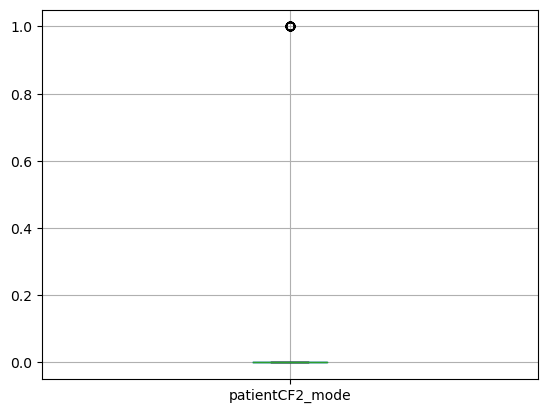

<Figure size 640x480 with 0 Axes>

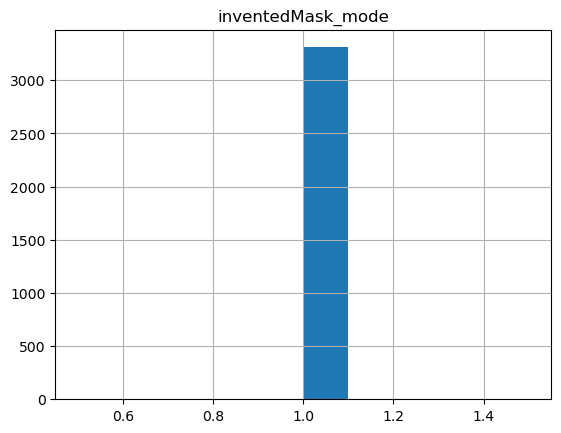

Feature:  DaysOfStay_mode
False


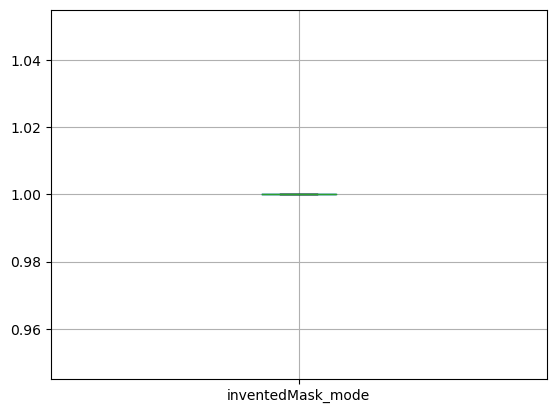

<Figure size 640x480 with 0 Axes>

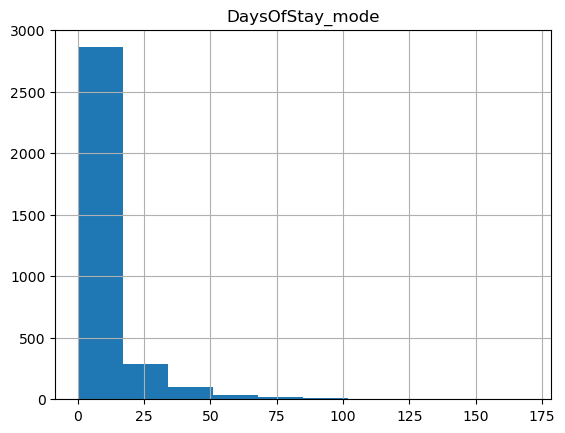

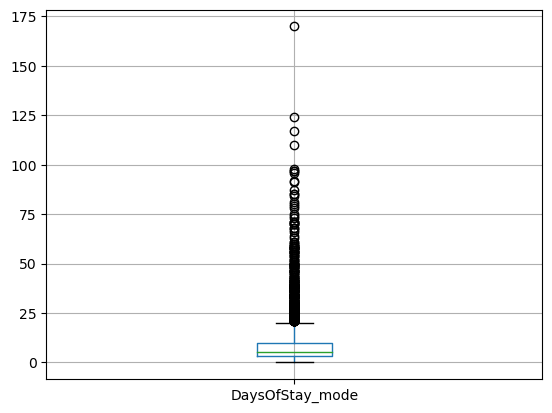

In [22]:
getDistribution(df_mode)

# Min

In [23]:
df_both = pd.read_csv("../df_to_load/Modelado_1/Datos_Originales/df_PreCovid.csv")
df_both_aux = df_both.drop(['Admissiondboid', 'dayToDone', 'MR',
                            'AMG', 'ATF', 'CAR', 'CF1',
                            'CF2', 'CF3', 'CF4', 'Falta', 'GCC', 'GLI', 'LIN', 'LIP', 'MAC', 'MON',
                            'NTI', 'OTR', 'OXA', 'PAP', 'PEN', 'POL', 'QUI', 'SUL', 'TTC'],axis=1)
keys = df_both_aux.keys()
print(keys)
mat = np.zeros((int(df_both_aux.shape[0]/numTimeStep), len(keys)))
inf = 0
sup = numTimeStep-1
for indexx in range(int(df_both_aux.shape[0]/numTimeStep)):
    #############################################################################
    #Eliminate those instants when the patient is not in the ICU.
    idx = df_both_aux[inf:sup]['inventedMask'].values != 0
    idx = np.argwhere(idx.astype('uint8') == 0)
    #print(idx)
    #print(inf , " - " , sup)
    index=[]
    for j in range(idx.shape[0]):
        index.append(idx[j][0])
    aux = df_both_aux.loc[inf:sup]
    aux = aux.reset_index(drop=True)
    aux_2 = aux.drop(index,axis=0)
    aux_2 = aux_2.reset_index(drop=True)
    #############################################################################
    for i in range(len(keys)):
        mat[indexx,i] = aux_2[keys[i]].min()
    inf = sup + 1 
    sup += numTimeStep
        
df_min = pd.DataFrame(mat)

new_names = []
for i in range(len(keys)):
    new_names.append(keys[i]+str("_min"))
    
df_min.columns = new_names

Index(['isVM', 'numberOfPatients', 'numberOfPatientsMR', 'patientPAP',
       'patientCAR', 'patientFalta', 'patientQUI', 'patientATF', 'patientGLI',
       'patientPEN', 'patientCF3', 'patientCF4', 'patientOXA', 'patientNTI',
       'patientLIN', 'patientSUL', 'patientAMG', 'patientCF1', 'patientMAC',
       'patientPOL', 'patientMON', 'patientGCC', 'patientTTC', 'patientOTR',
       'patientLIP', 'patientCF2', 'inventedMask', 'DaysOfStay'],
      dtype='object')


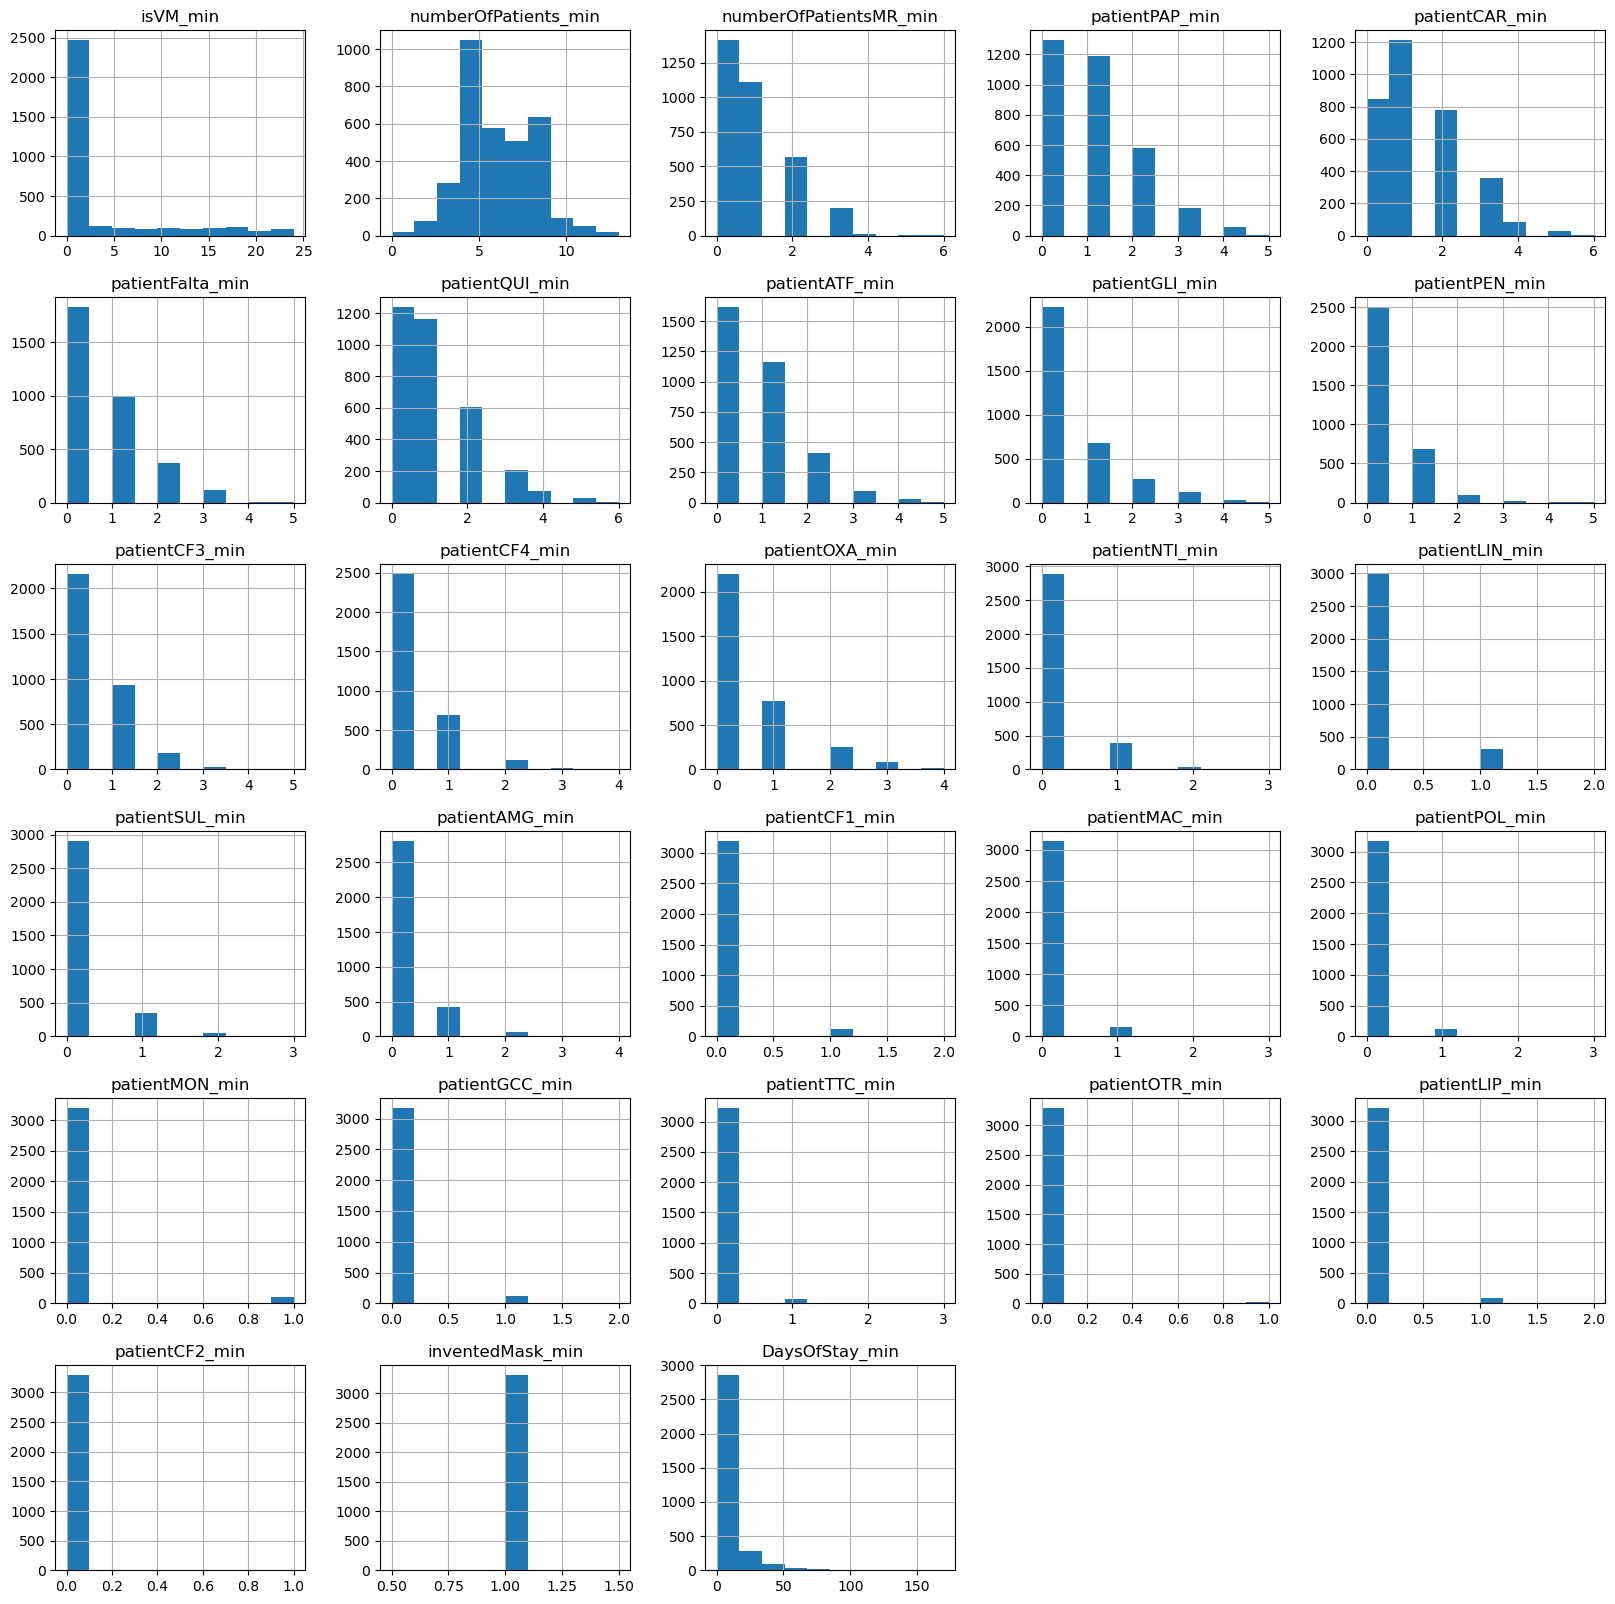

In [24]:
_ = df_min.hist(figsize=(20,20))

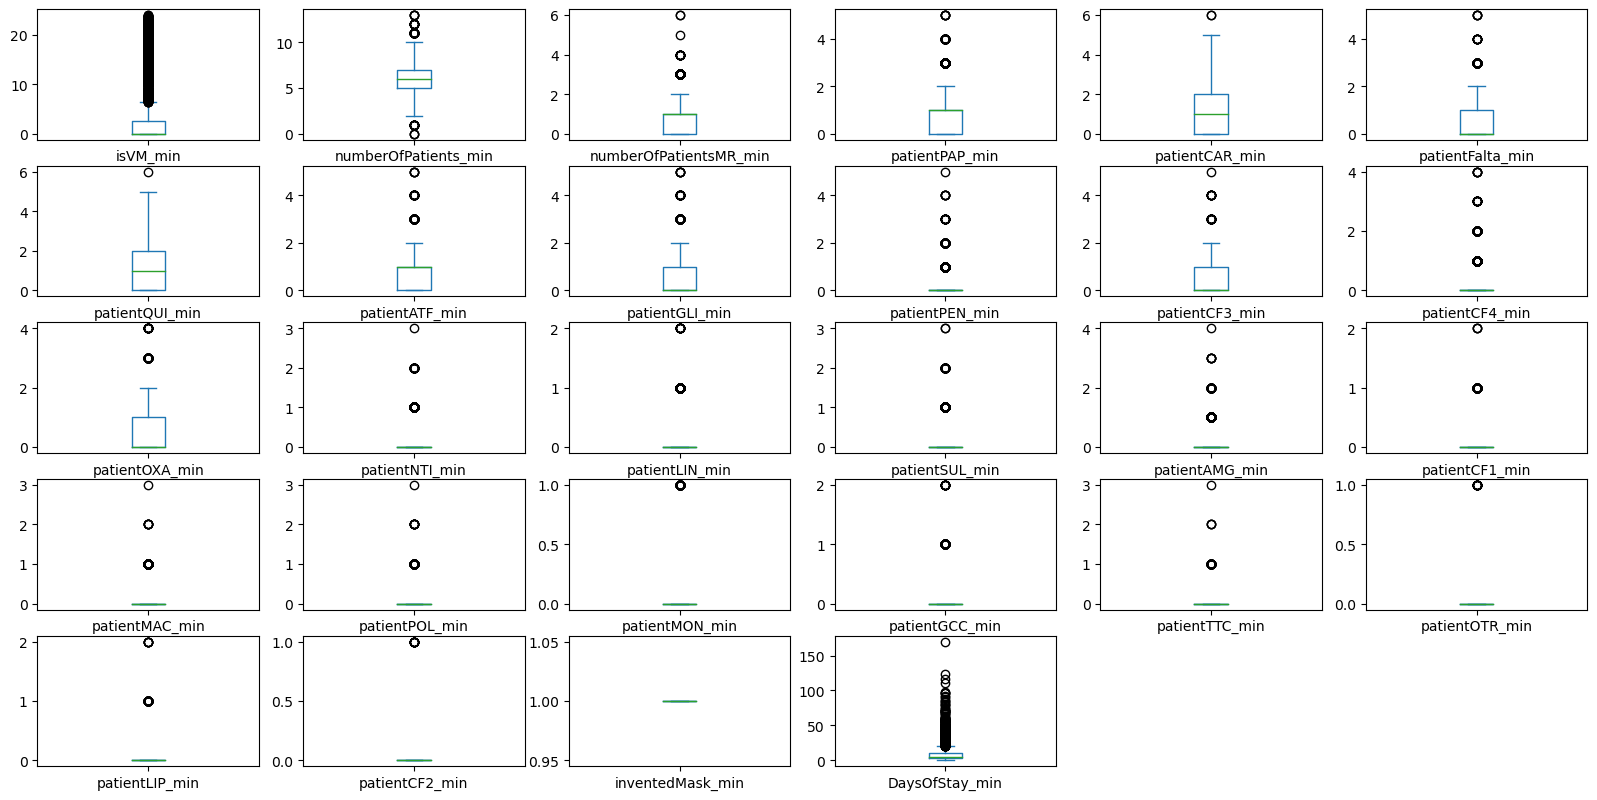

In [25]:
_ = df_min.plot(kind='box', subplots=True, layout = (10,6), figsize=(20,20))

False
Feature:  isVM_min
False


<Figure size 640x480 with 0 Axes>

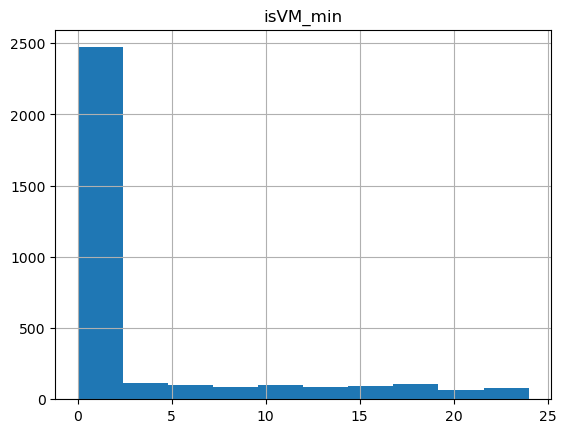

Feature:  numberOfPatients_min
False


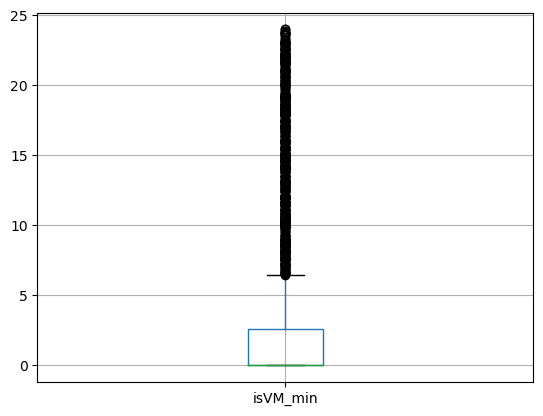

<Figure size 640x480 with 0 Axes>

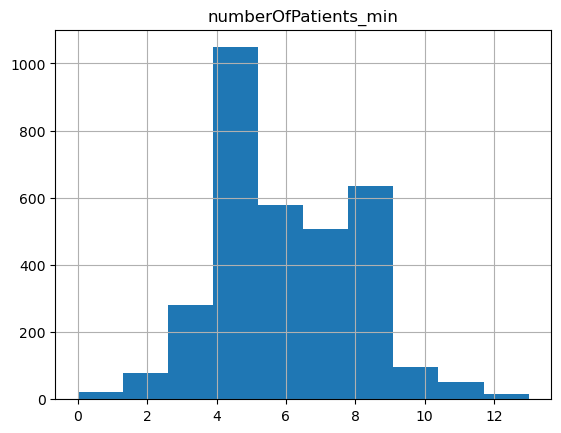

Feature:  numberOfPatientsMR_min
False


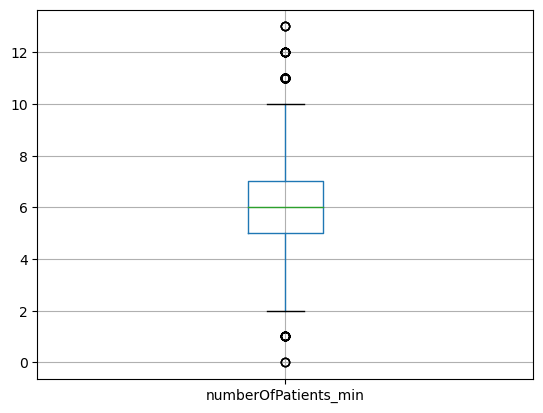

<Figure size 640x480 with 0 Axes>

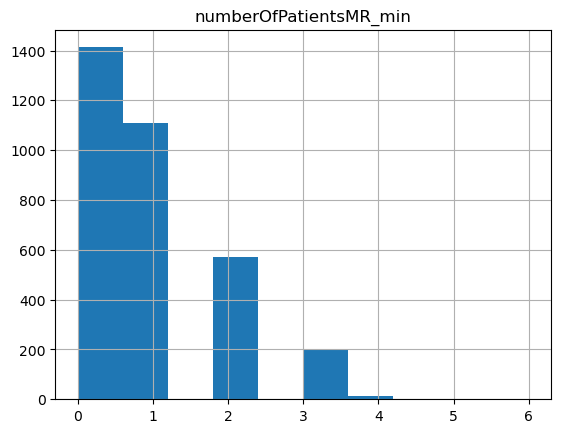

Feature:  patientPAP_min
False


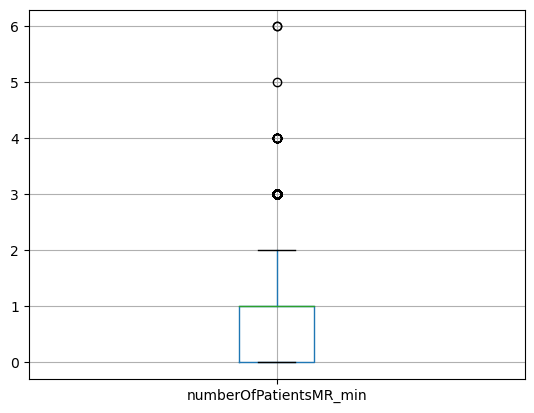

<Figure size 640x480 with 0 Axes>

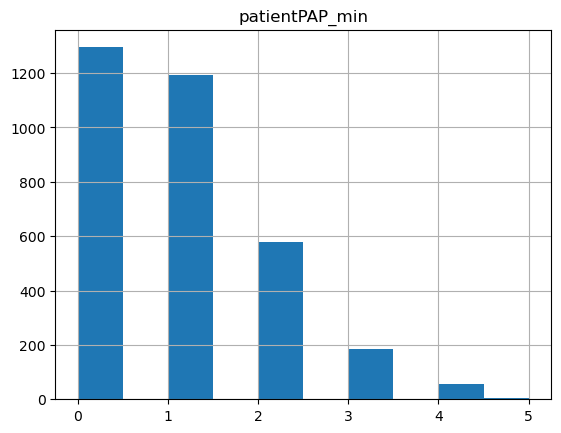

Feature:  patientCAR_min
False


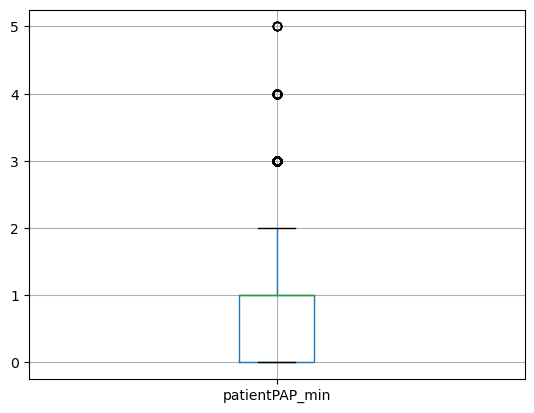

<Figure size 640x480 with 0 Axes>

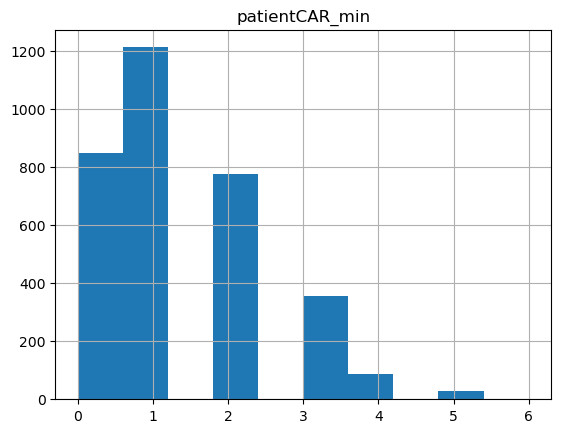

Feature:  patientFalta_min
False


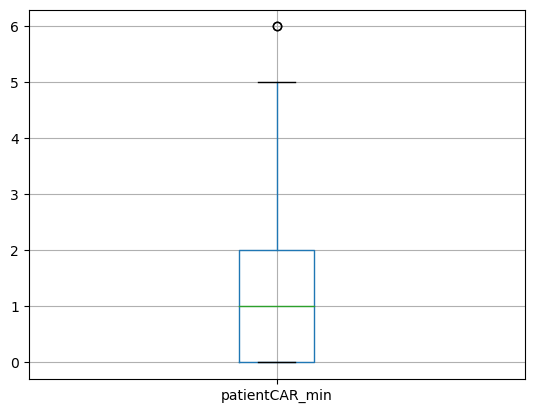

<Figure size 640x480 with 0 Axes>

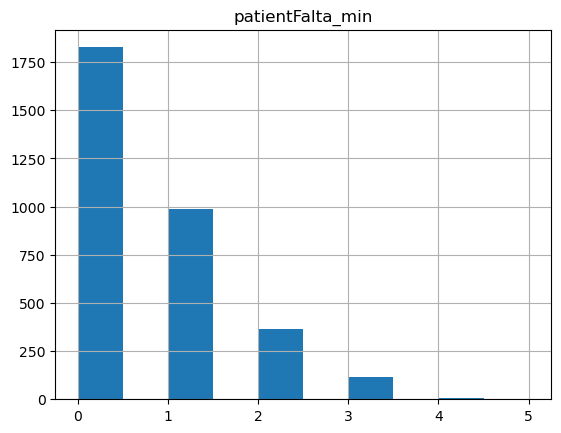

Feature:  patientQUI_min
False


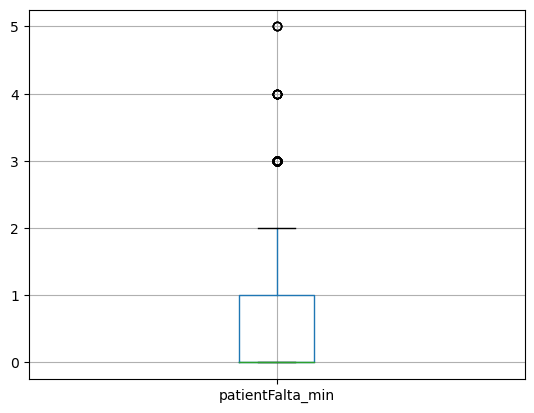

<Figure size 640x480 with 0 Axes>

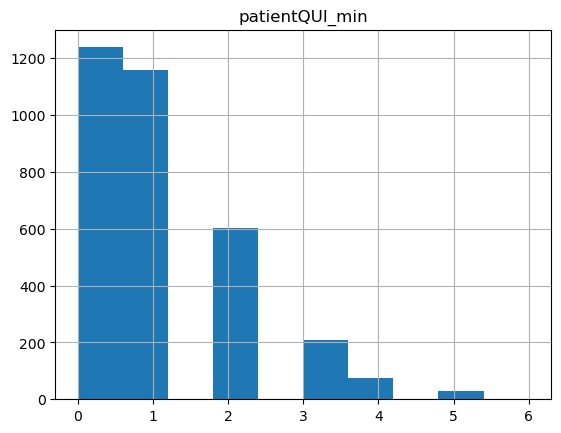

Feature:  patientATF_min
False


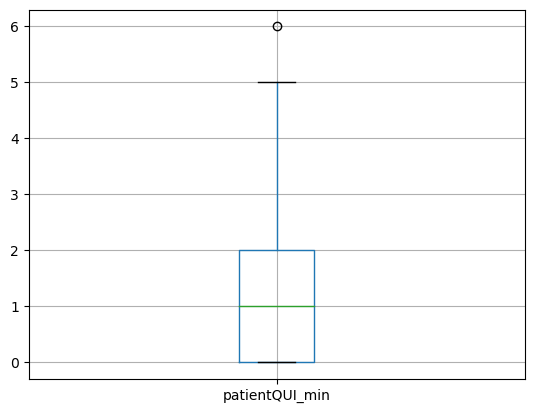

<Figure size 640x480 with 0 Axes>

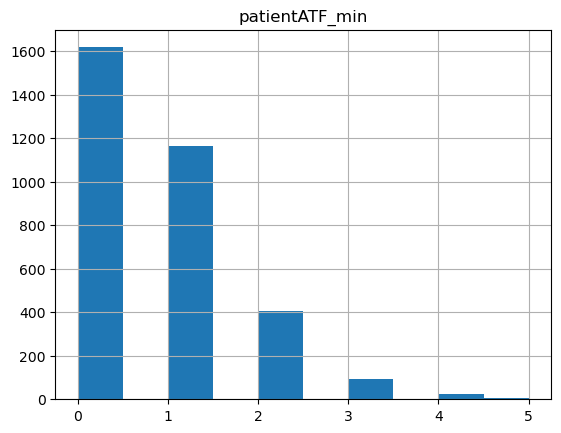

Feature:  patientGLI_min
False


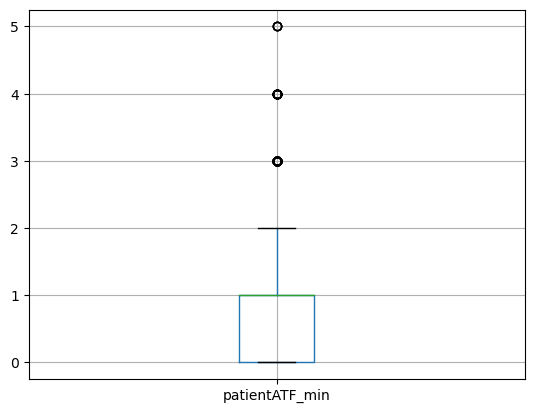

<Figure size 640x480 with 0 Axes>

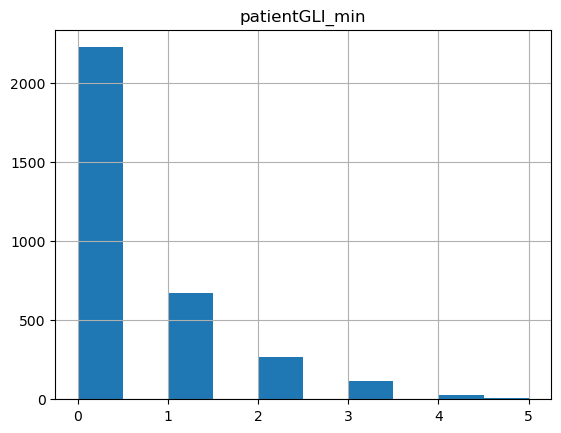

Feature:  patientPEN_min
False


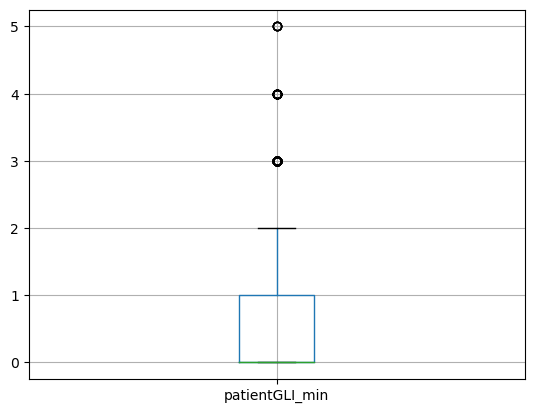

<Figure size 640x480 with 0 Axes>

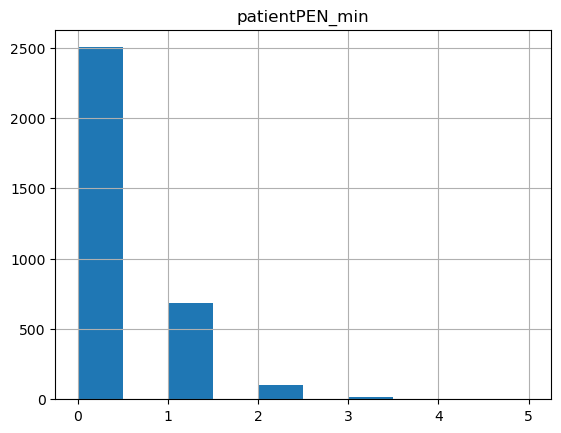

Feature:  patientCF3_min
False


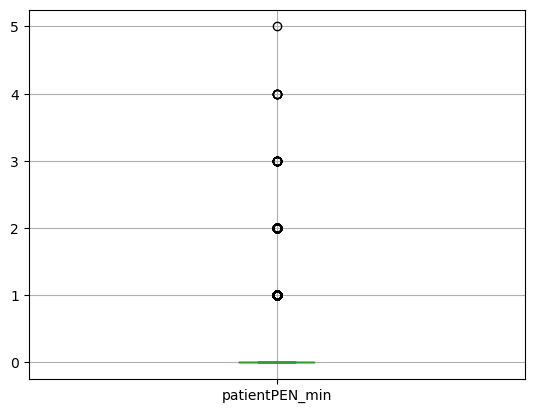

<Figure size 640x480 with 0 Axes>

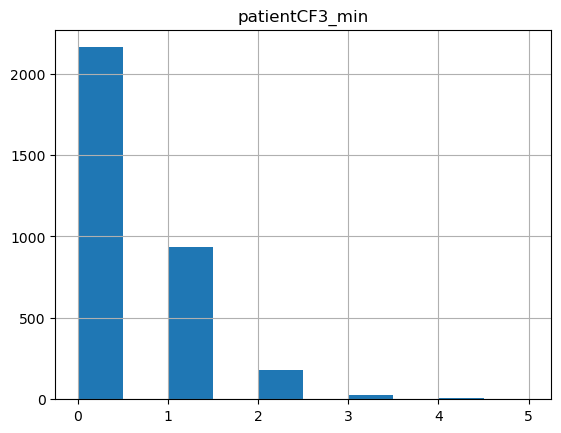

Feature:  patientCF4_min
False


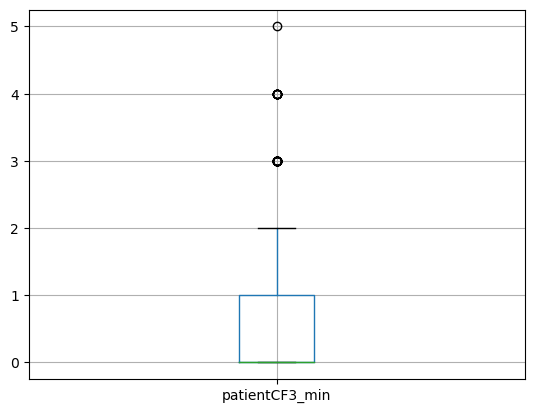

<Figure size 640x480 with 0 Axes>

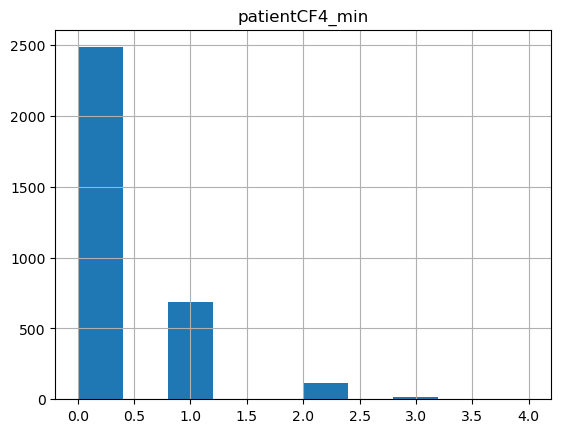

Feature:  patientOXA_min
False


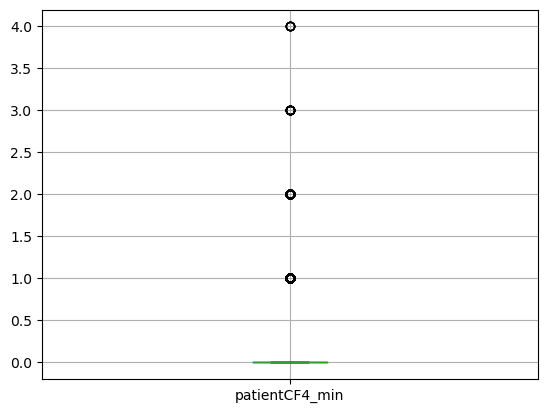

<Figure size 640x480 with 0 Axes>

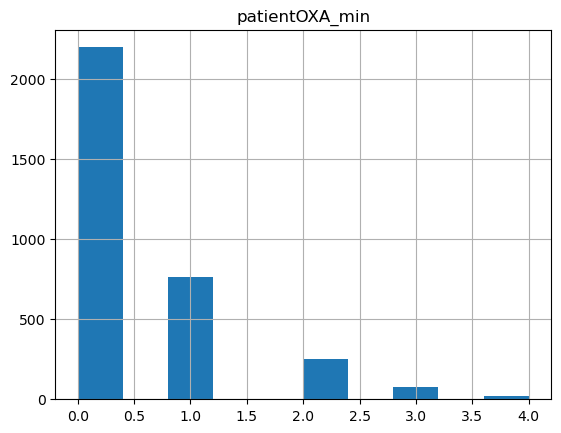

Feature:  patientNTI_min
False


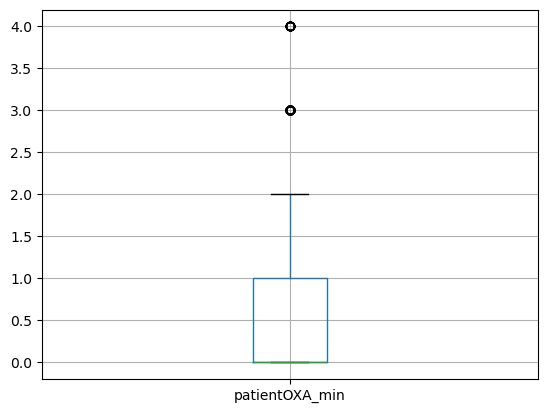

<Figure size 640x480 with 0 Axes>

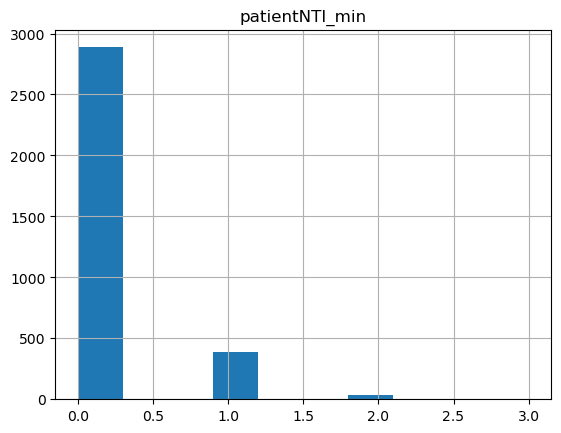

Feature:  patientLIN_min
False


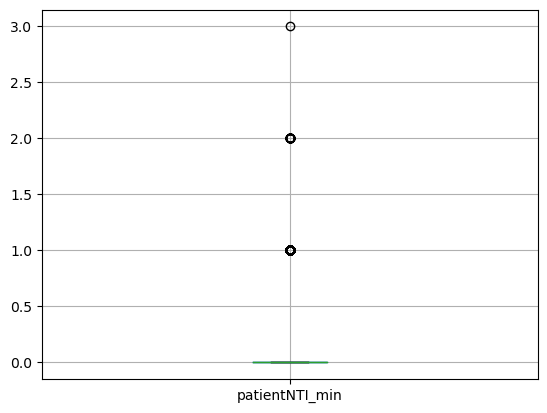

<Figure size 640x480 with 0 Axes>

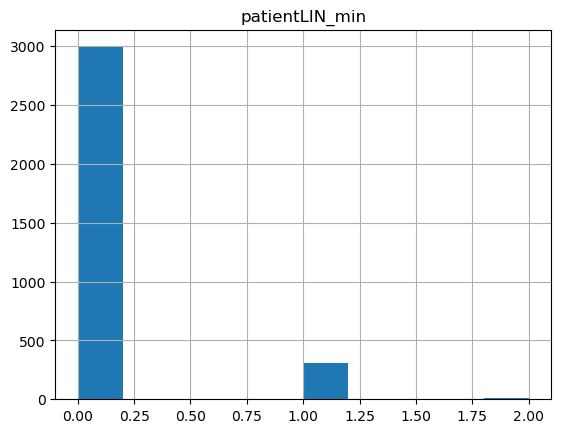

Feature:  patientSUL_min
False


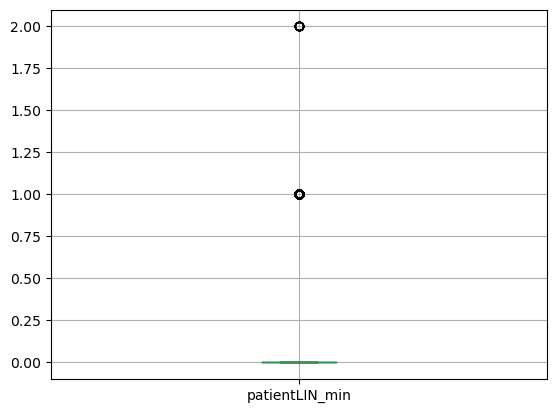

<Figure size 640x480 with 0 Axes>

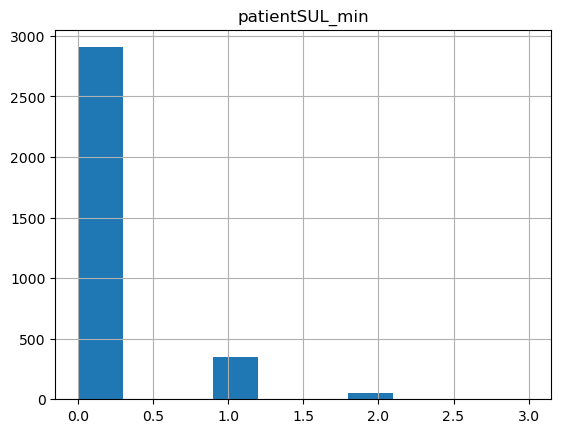

Feature:  patientAMG_min
False


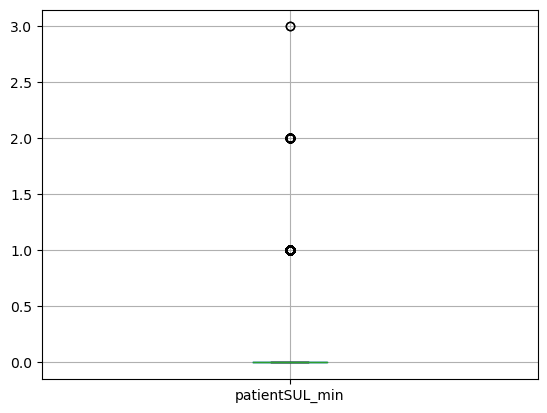

<Figure size 640x480 with 0 Axes>

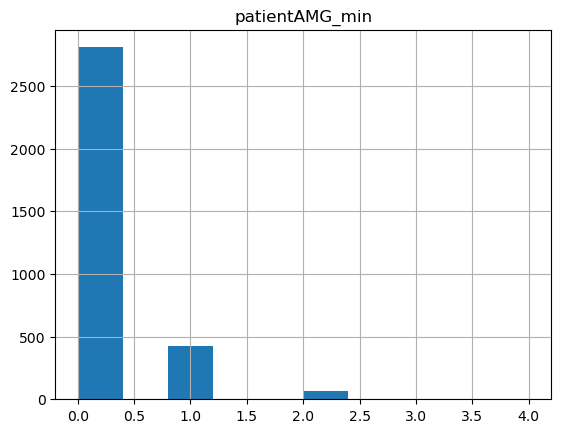

Feature:  patientCF1_min
False


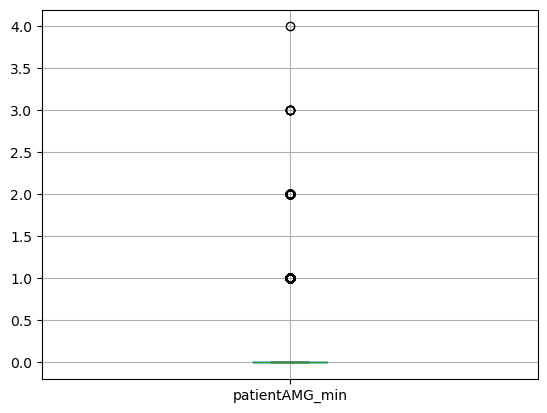

<Figure size 640x480 with 0 Axes>

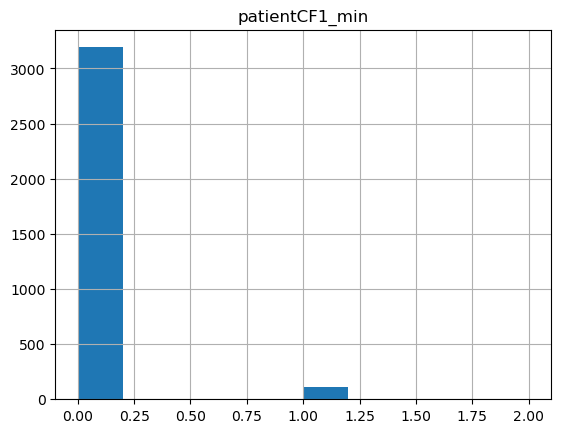

Feature:  patientMAC_min
False


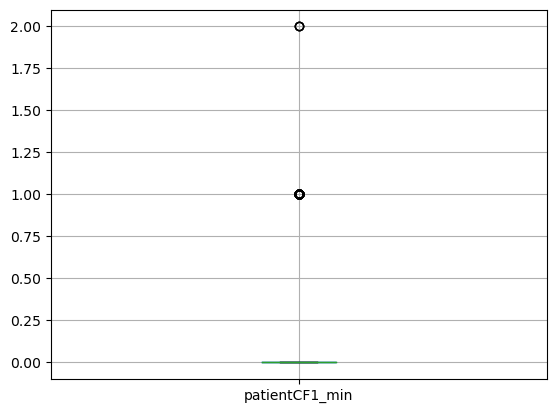

<Figure size 640x480 with 0 Axes>

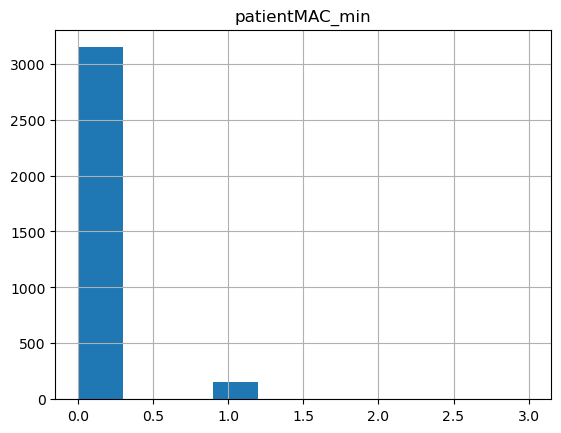

Feature:  patientPOL_min
False


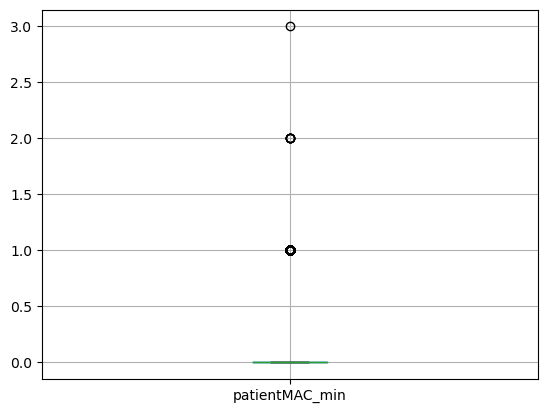

<Figure size 640x480 with 0 Axes>

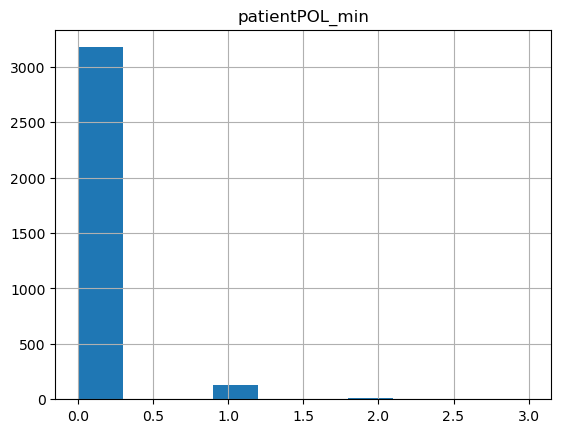

Feature:  patientMON_min
False


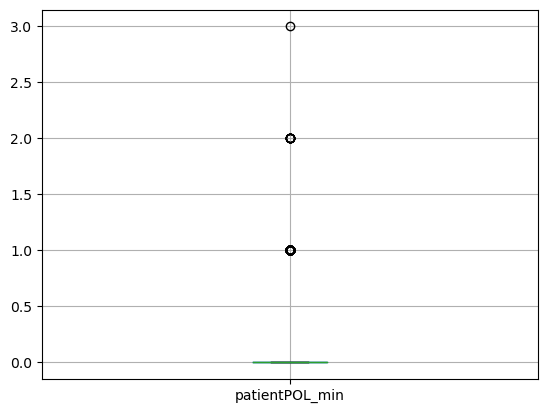

<Figure size 640x480 with 0 Axes>

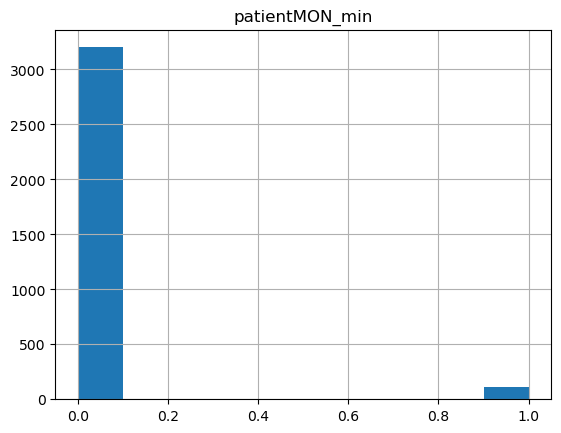

Feature:  patientGCC_min
False


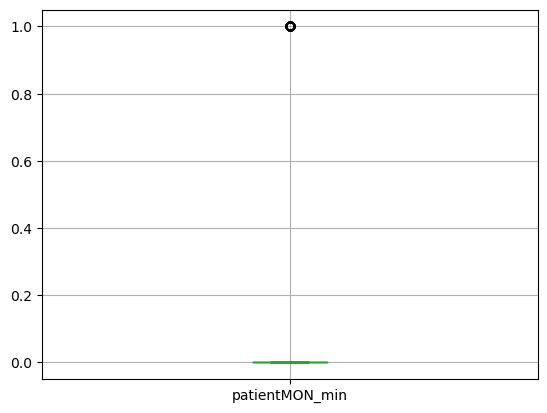

<Figure size 640x480 with 0 Axes>

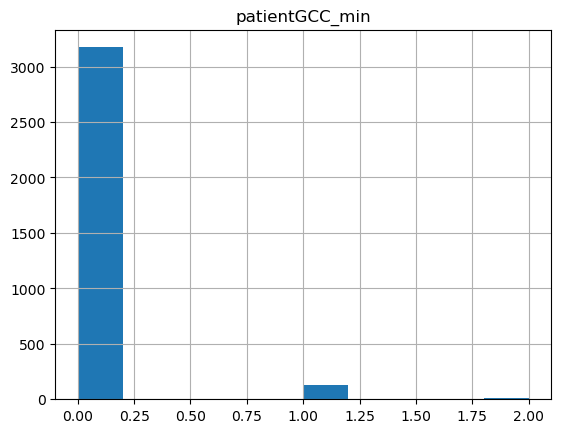

Feature:  patientTTC_min
False


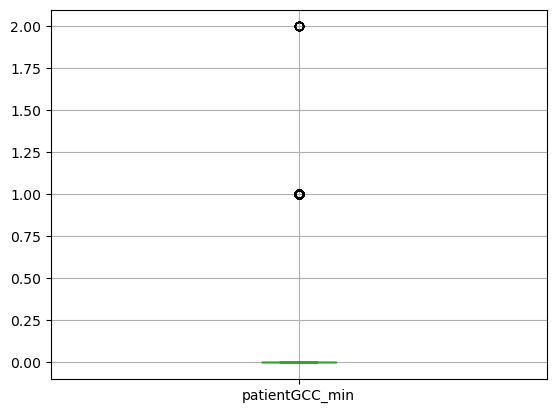

<Figure size 640x480 with 0 Axes>

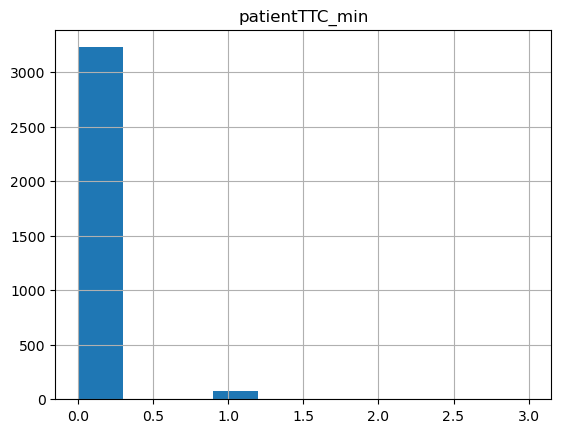

Feature:  patientOTR_min
False


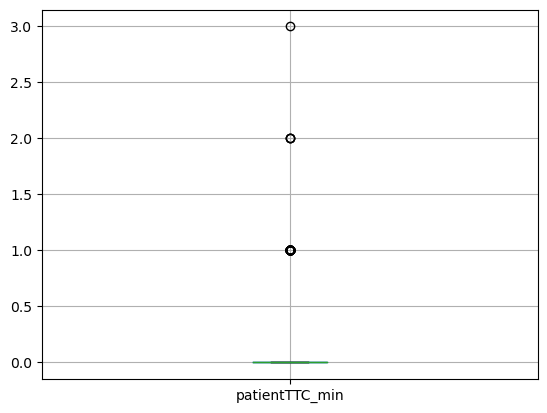

<Figure size 640x480 with 0 Axes>

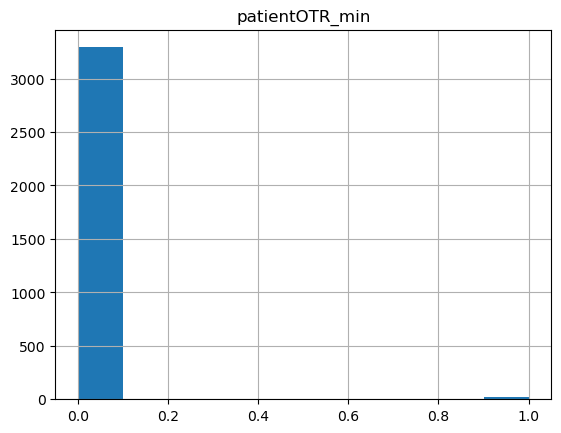

Feature:  patientLIP_min
False


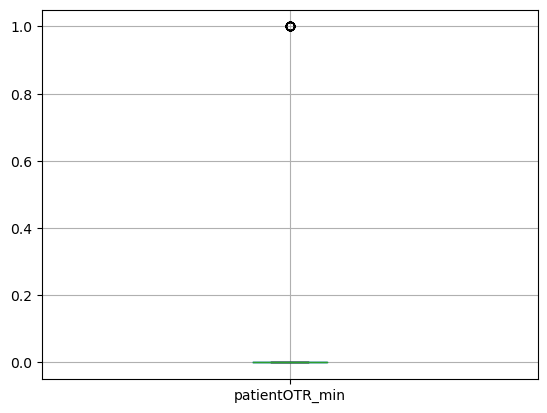

<Figure size 640x480 with 0 Axes>

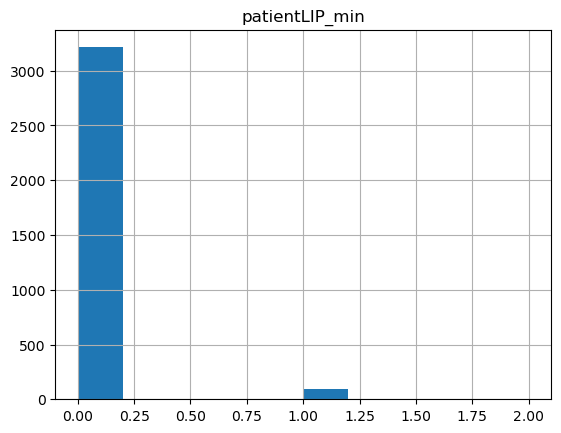

Feature:  patientCF2_min
False


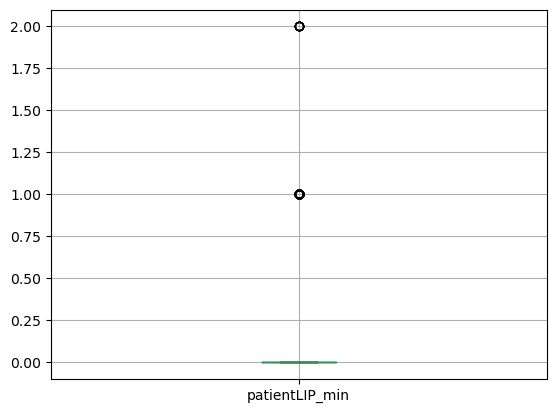

<Figure size 640x480 with 0 Axes>

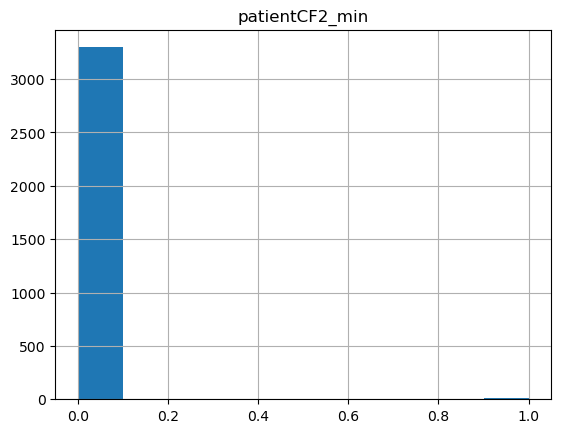

Feature:  inventedMask_min
False


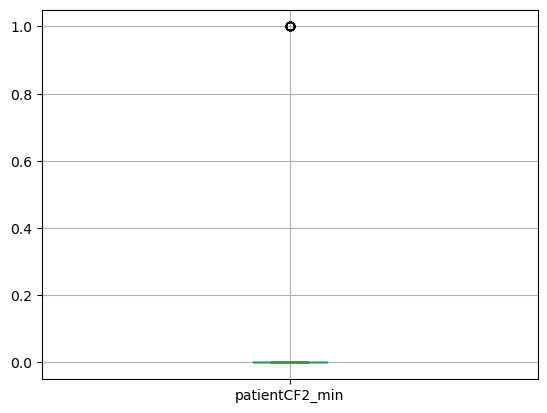

<Figure size 640x480 with 0 Axes>

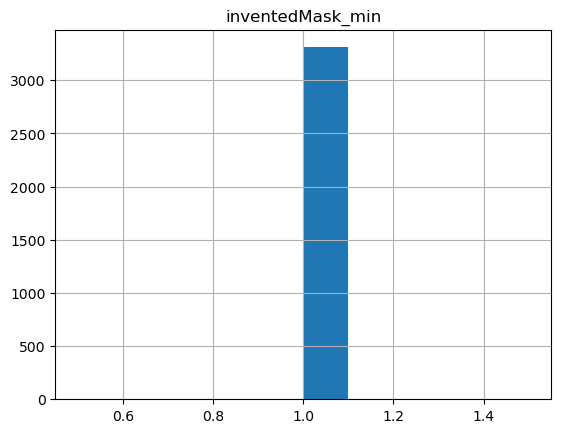

Feature:  DaysOfStay_min
False


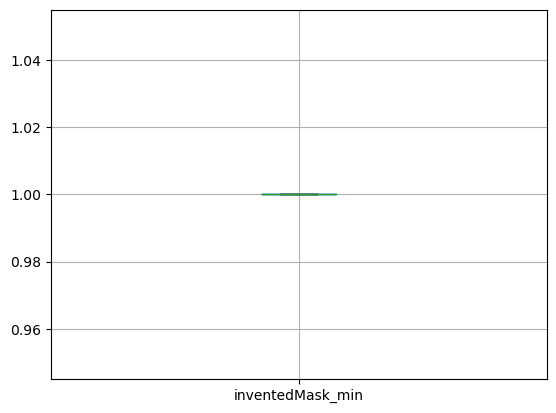

<Figure size 640x480 with 0 Axes>

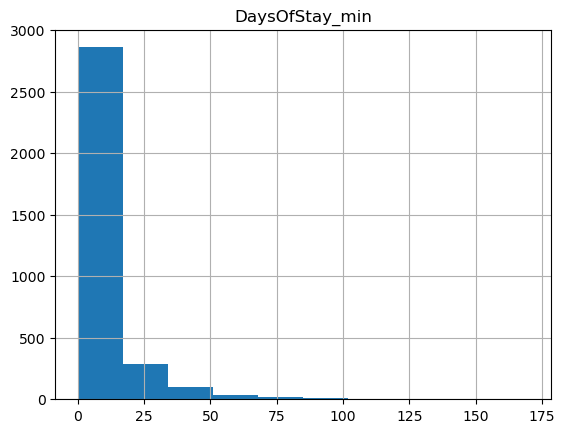

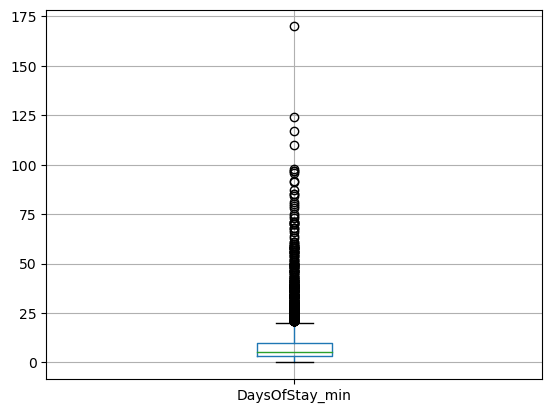

In [26]:
getDistribution(df_min)

# Max

In [27]:
df_both = pd.read_csv("../df_to_load/Modelado_1/Datos_Originales/df_PreCovid.csv")
df_both_aux = df_both.drop(['Admissiondboid', 'dayToDone', 'MR',
                            'AMG', 'ATF', 'CAR', 'CF1',
                            'CF2', 'CF3', 'CF4', 'Falta', 'GCC', 'GLI', 'LIN', 'LIP', 'MAC', 'MON',
                            'NTI', 'OTR', 'OXA', 'PAP', 'PEN', 'POL', 'QUI', 'SUL', 'TTC'],axis=1)
keys = df_both_aux.keys()
print(keys)
mat = np.zeros((int(df_both_aux.shape[0]/numTimeStep), len(keys)))
inf = 0
sup = numTimeStep-1
for indexx in range(int(df_both_aux.shape[0]/numTimeStep)):
    #############################################################################
    #Eliminate those instants when the patient is not in the ICU.
    idx = df_both_aux[inf:sup]['inventedMask'].values != 0
    idx = np.argwhere(idx.astype('uint8') == 0)
    #print(idx)
    #print(inf , " - " , sup)
    index=[]
    for j in range(idx.shape[0]):
        index.append(idx[j][0])
    aux = df_both_aux.loc[inf:sup]
    aux = aux.reset_index(drop=True)
    aux_2 = aux.drop(index,axis=0)
    aux_2 = aux_2.reset_index(drop=True)
    #############################################################################
    for i in range(len(keys)):
        mat[indexx,i] = aux_2[keys[i]].max()
    inf = sup + 1 
    sup += numTimeStep
        
df_max = pd.DataFrame(mat)

new_names = []
for i in range(len(keys)):
    new_names.append(keys[i]+str("_max"))
    
df_max.columns = new_names

Index(['isVM', 'numberOfPatients', 'numberOfPatientsMR', 'patientPAP',
       'patientCAR', 'patientFalta', 'patientQUI', 'patientATF', 'patientGLI',
       'patientPEN', 'patientCF3', 'patientCF4', 'patientOXA', 'patientNTI',
       'patientLIN', 'patientSUL', 'patientAMG', 'patientCF1', 'patientMAC',
       'patientPOL', 'patientMON', 'patientGCC', 'patientTTC', 'patientOTR',
       'patientLIP', 'patientCF2', 'inventedMask', 'DaysOfStay'],
      dtype='object')


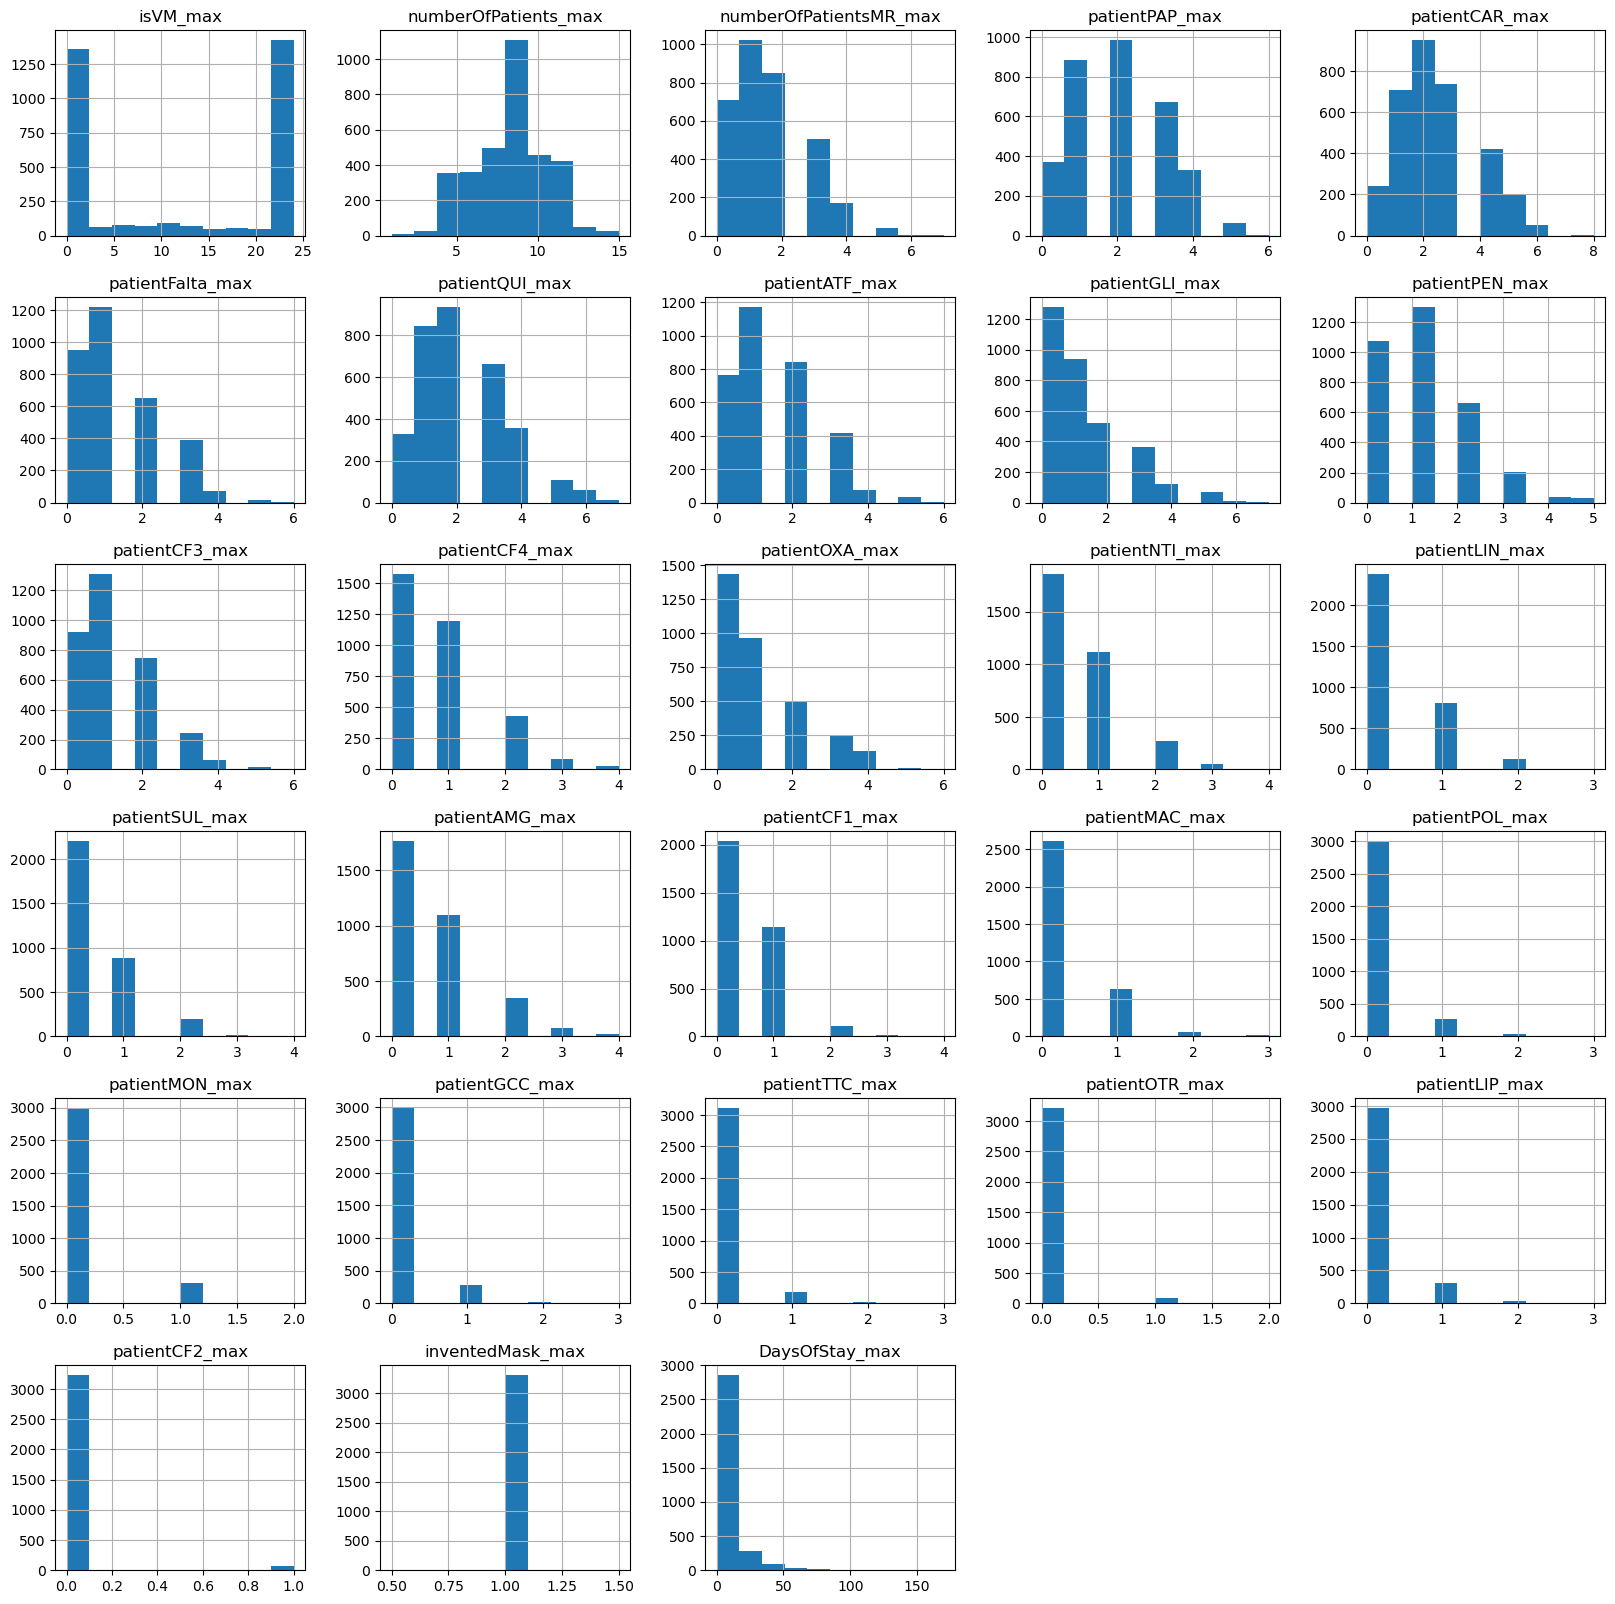

In [28]:
_ = df_max.hist(figsize=(20,20))

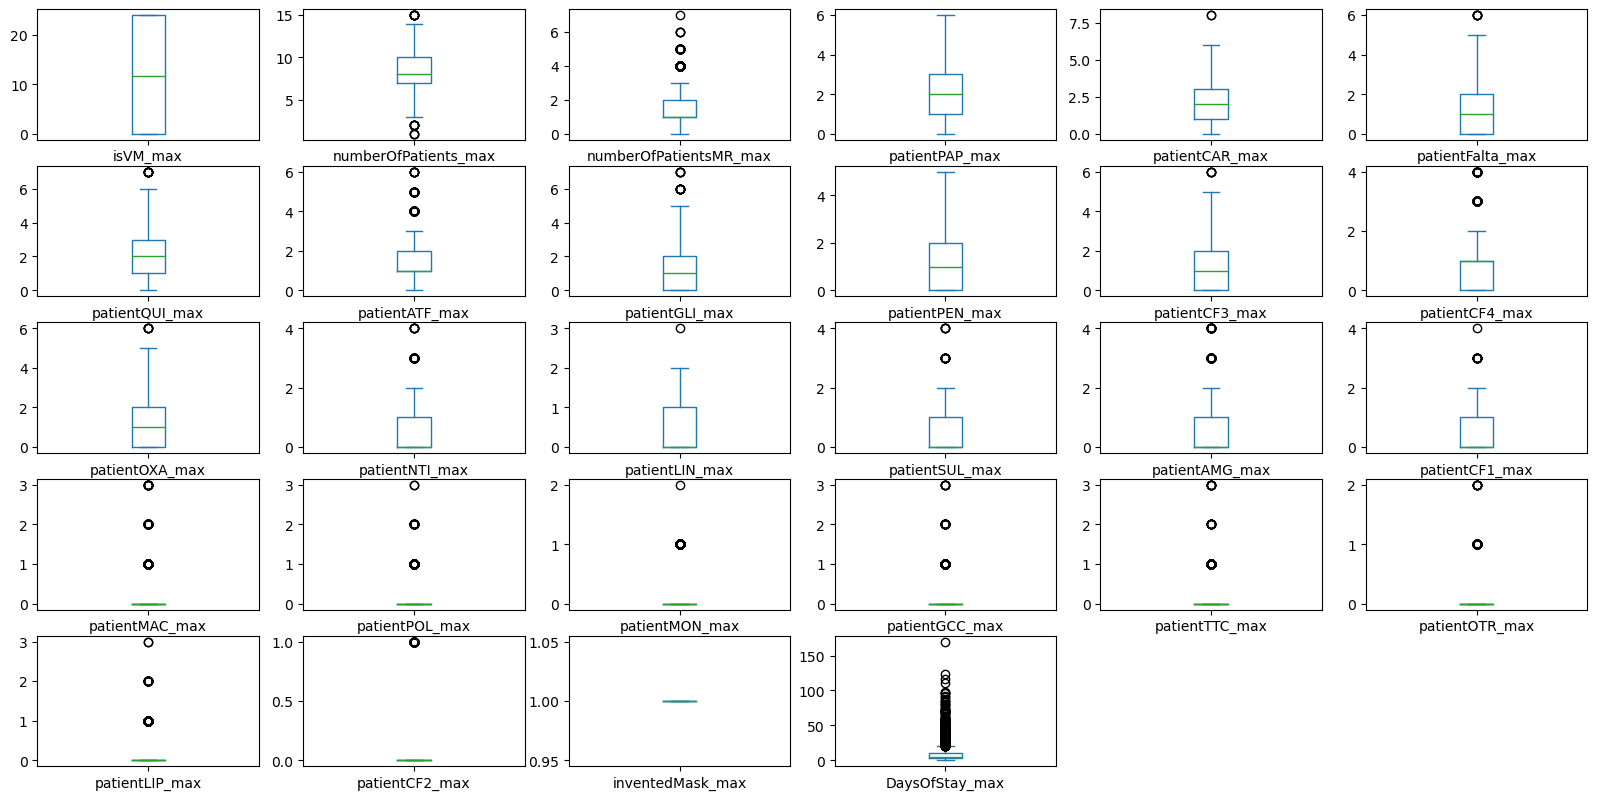

In [29]:
_ = df_max.plot(kind='box', subplots=True, layout = (10,6), figsize=(20,20))

False
Feature:  isVM_max
False


<Figure size 640x480 with 0 Axes>

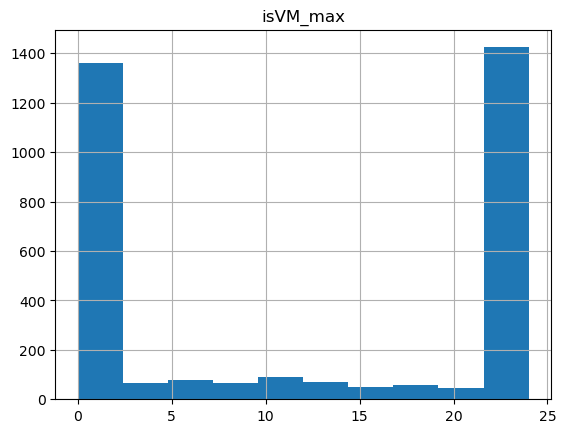

Feature:  numberOfPatients_max
False


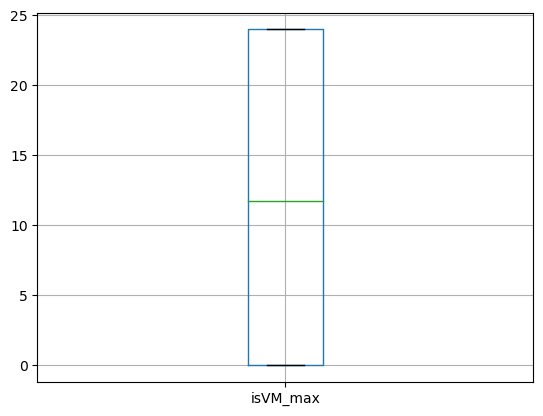

<Figure size 640x480 with 0 Axes>

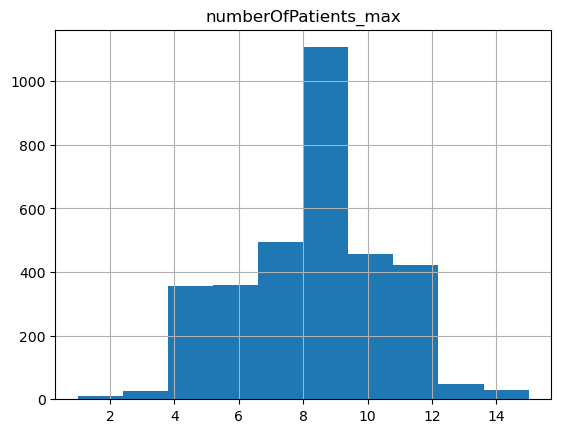

Feature:  numberOfPatientsMR_max
False


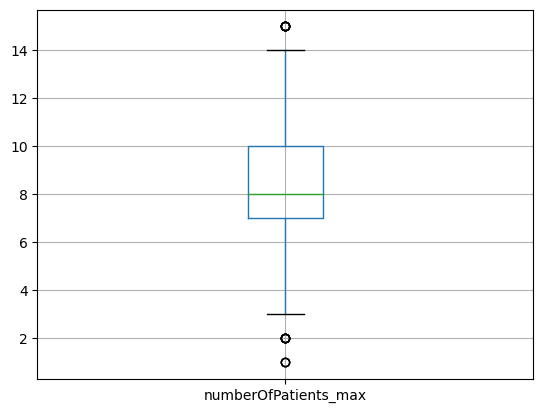

<Figure size 640x480 with 0 Axes>

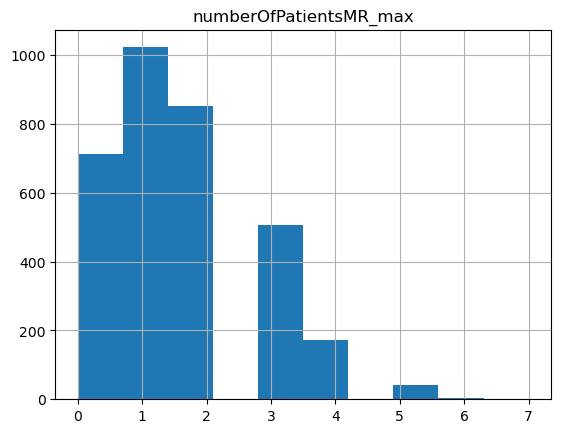

Feature:  patientPAP_max
False


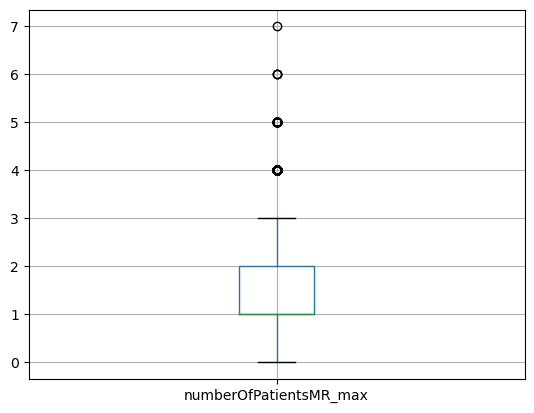

<Figure size 640x480 with 0 Axes>

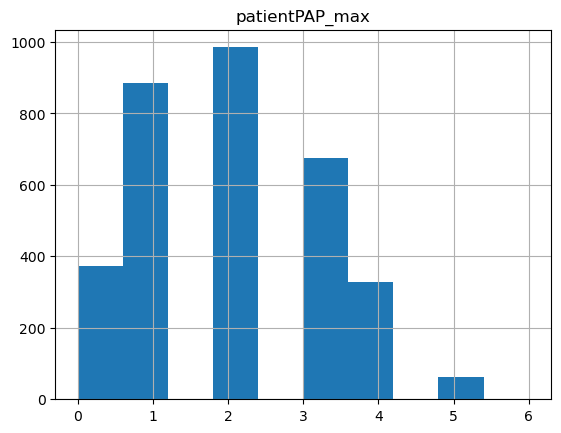

Feature:  patientCAR_max
False


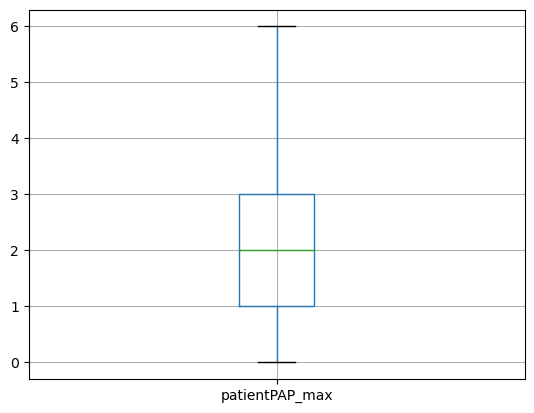

<Figure size 640x480 with 0 Axes>

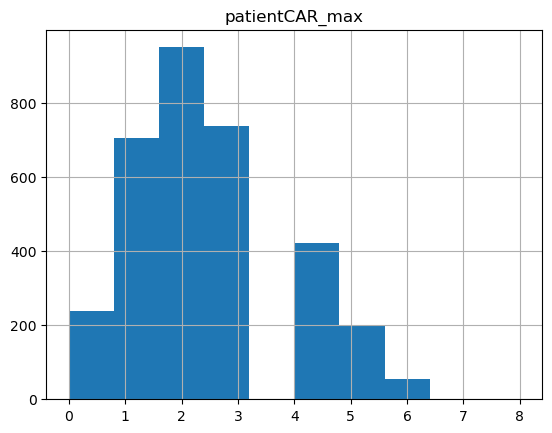

Feature:  patientFalta_max
False


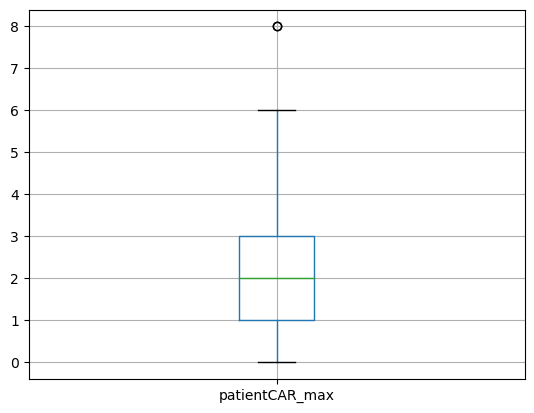

<Figure size 640x480 with 0 Axes>

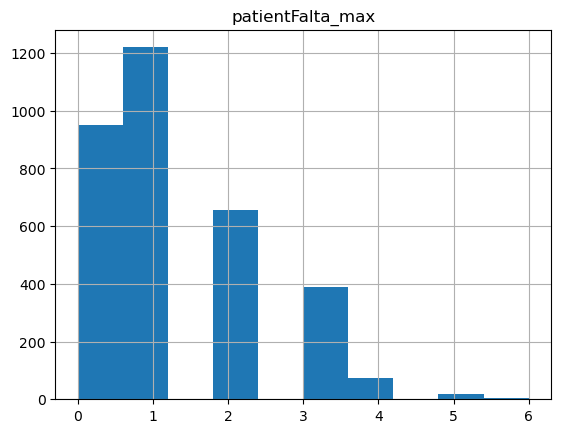

Feature:  patientQUI_max
False


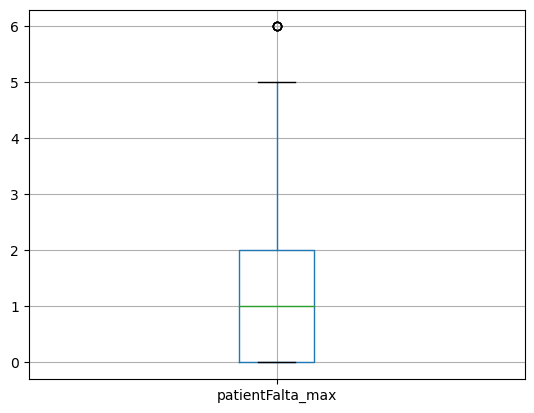

<Figure size 640x480 with 0 Axes>

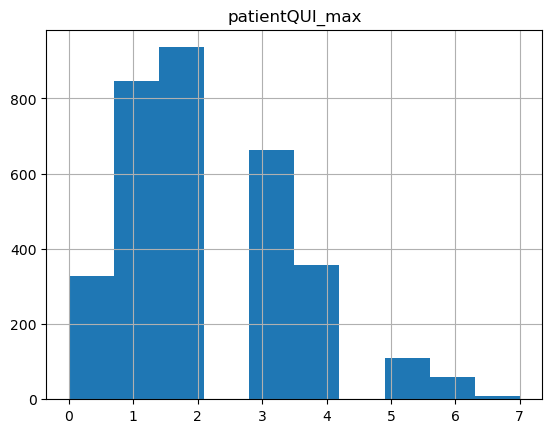

Feature:  patientATF_max
False


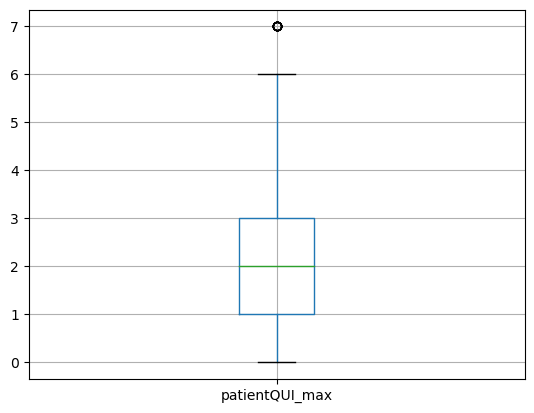

<Figure size 640x480 with 0 Axes>

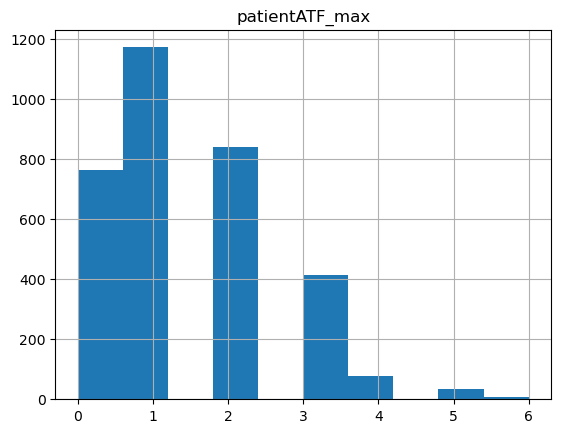

Feature:  patientGLI_max
False


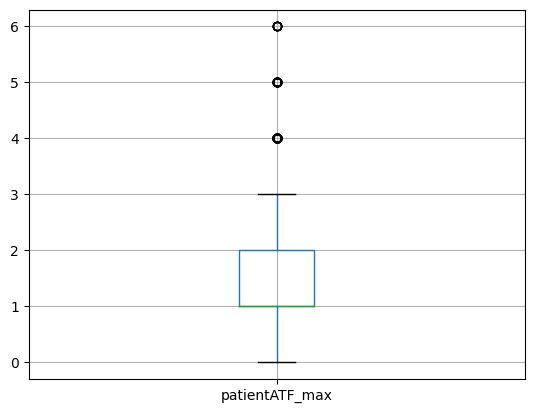

<Figure size 640x480 with 0 Axes>

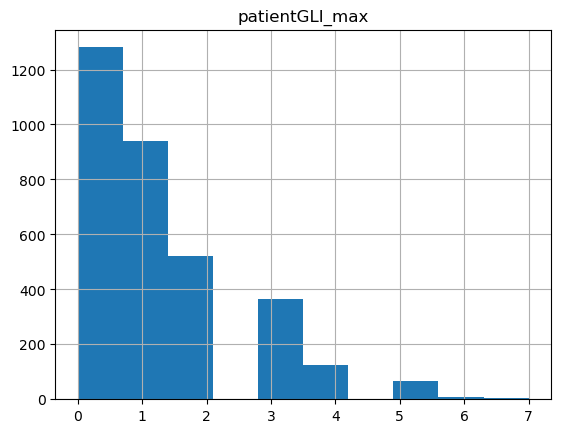

Feature:  patientPEN_max
False


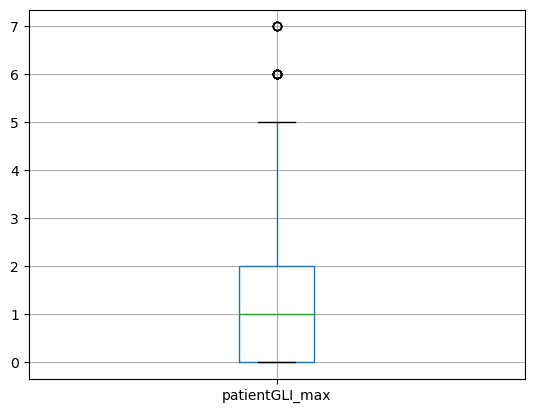

<Figure size 640x480 with 0 Axes>

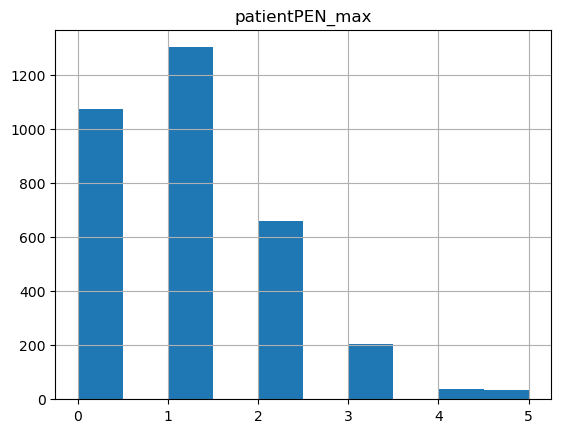

Feature:  patientCF3_max
False


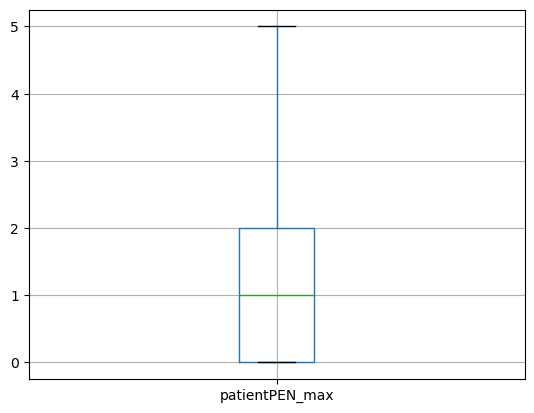

<Figure size 640x480 with 0 Axes>

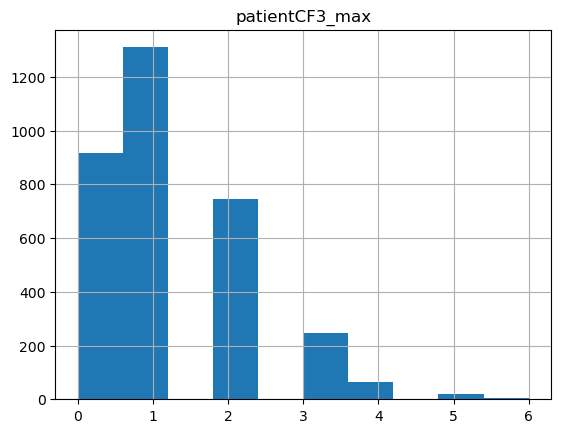

Feature:  patientCF4_max
False


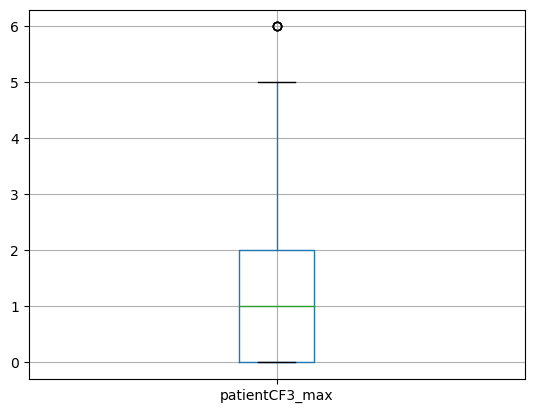

<Figure size 640x480 with 0 Axes>

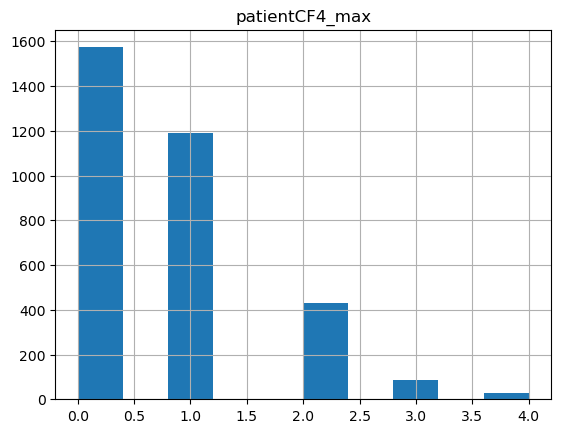

Feature:  patientOXA_max
False


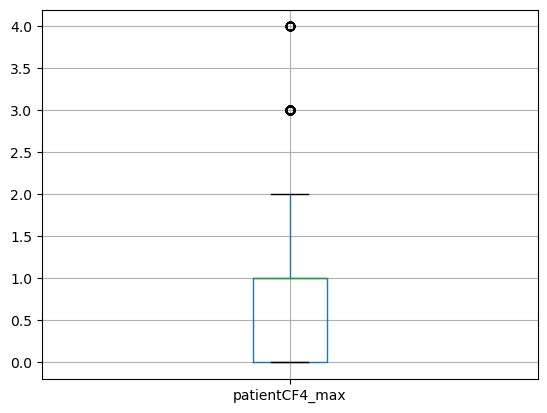

<Figure size 640x480 with 0 Axes>

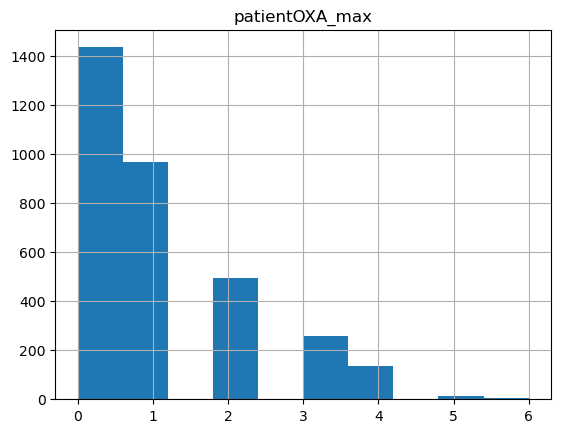

Feature:  patientNTI_max
False


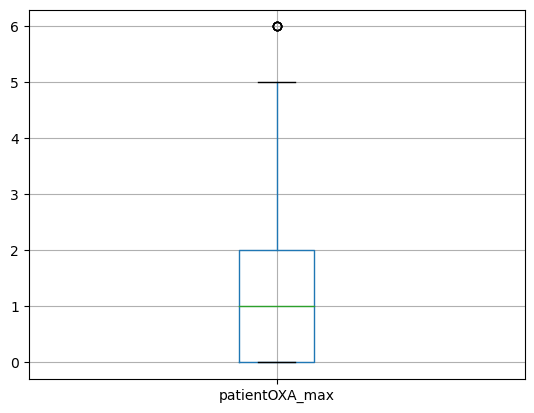

<Figure size 640x480 with 0 Axes>

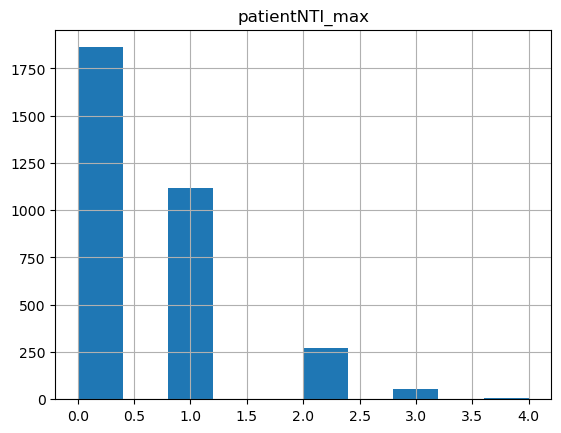

Feature:  patientLIN_max
False


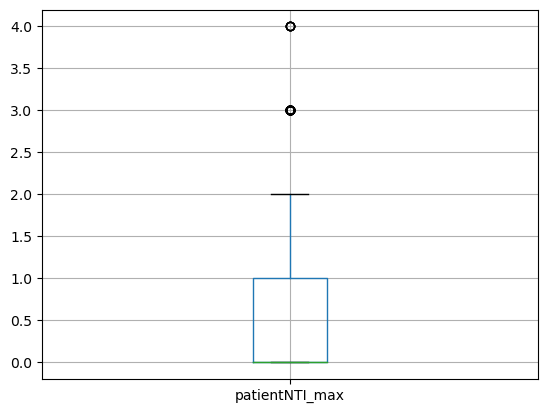

<Figure size 640x480 with 0 Axes>

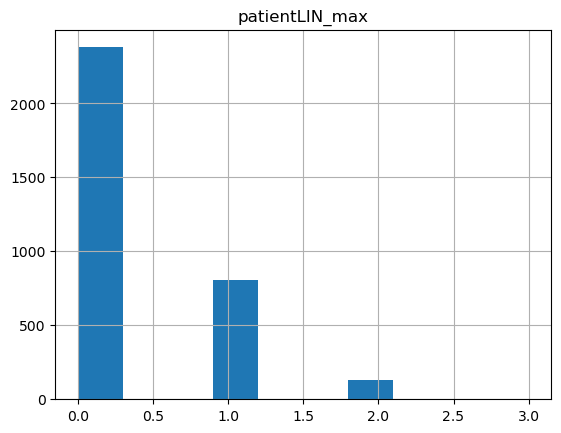

Feature:  patientSUL_max
False


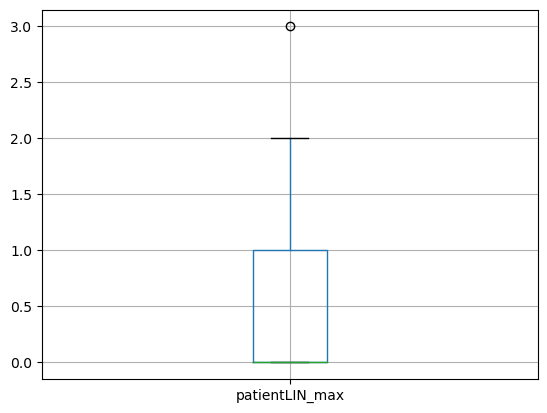

<Figure size 640x480 with 0 Axes>

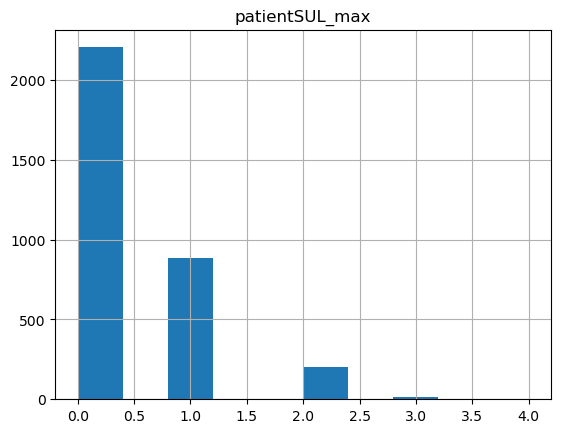

Feature:  patientAMG_max
False


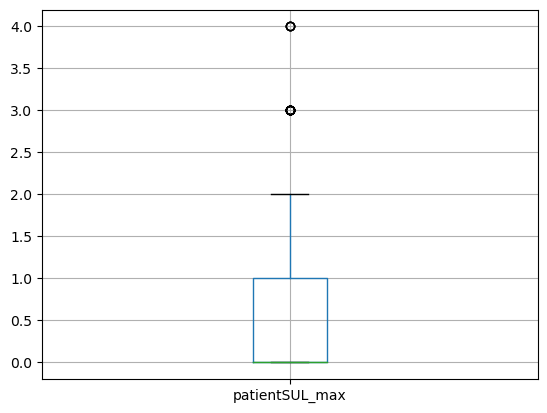

<Figure size 640x480 with 0 Axes>

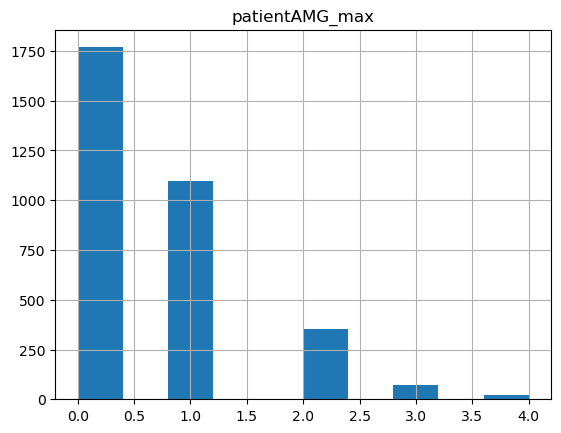

Feature:  patientCF1_max
False


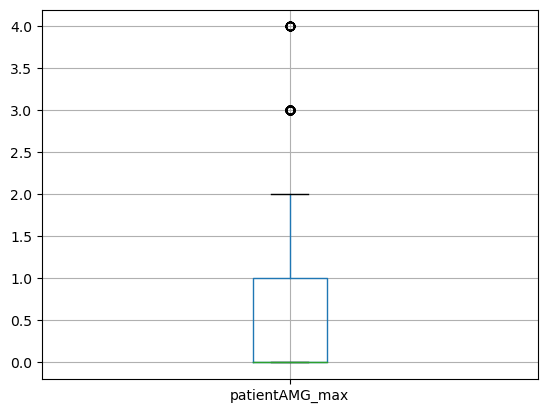

<Figure size 640x480 with 0 Axes>

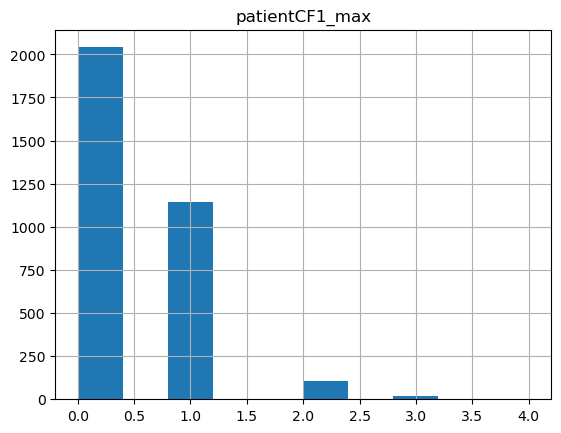

Feature:  patientMAC_max
False


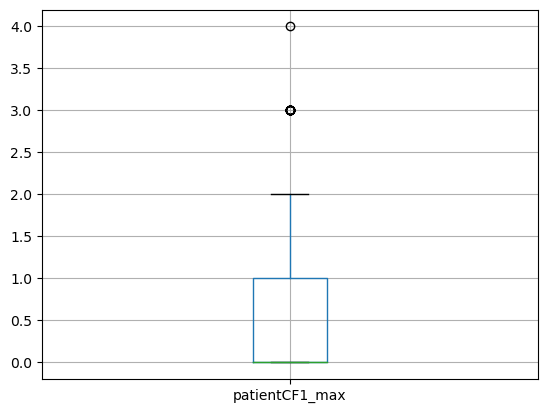

<Figure size 640x480 with 0 Axes>

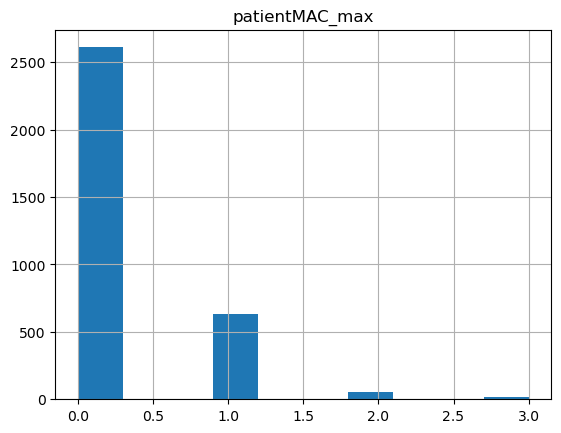

Feature:  patientPOL_max
False


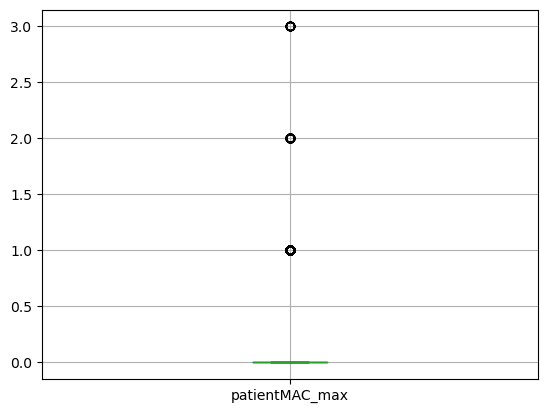

<Figure size 640x480 with 0 Axes>

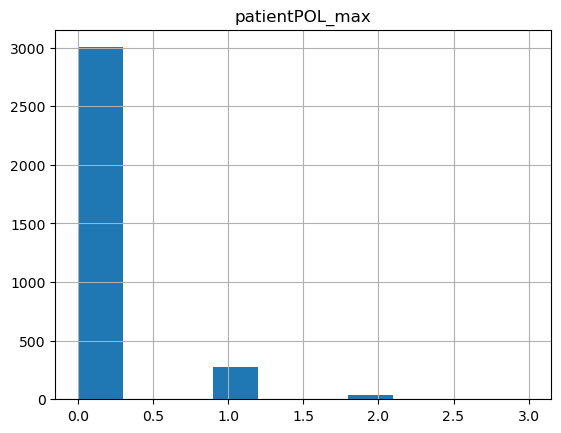

Feature:  patientMON_max
False


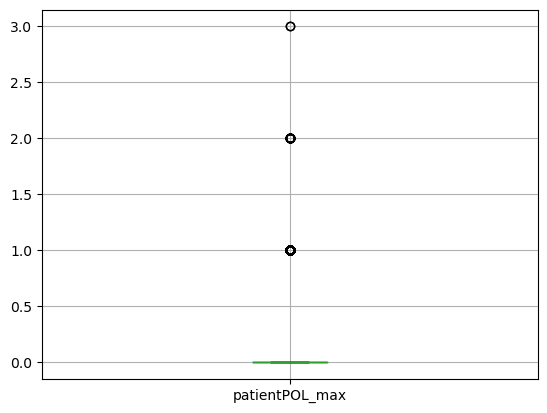

<Figure size 640x480 with 0 Axes>

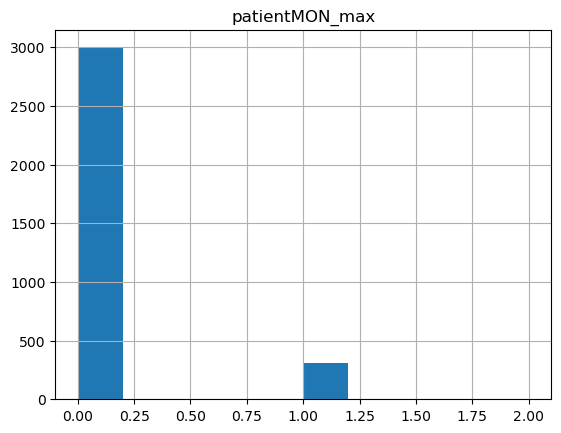

Feature:  patientGCC_max
False


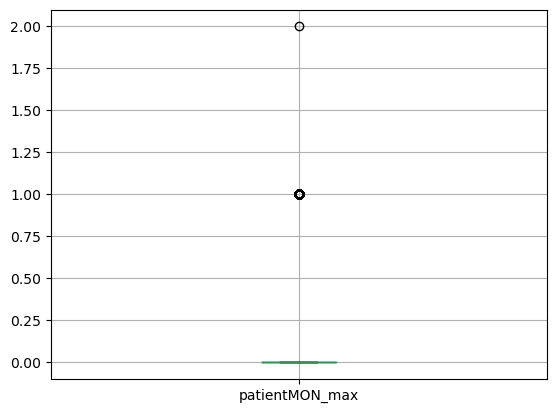

<Figure size 640x480 with 0 Axes>

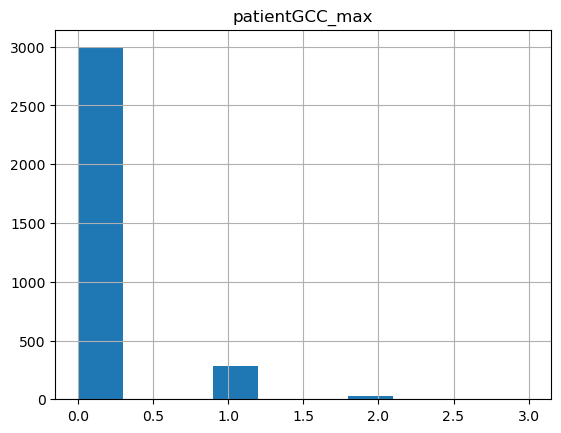

Feature:  patientTTC_max
False


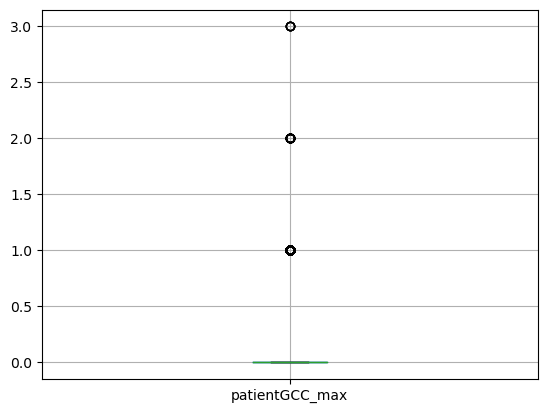

<Figure size 640x480 with 0 Axes>

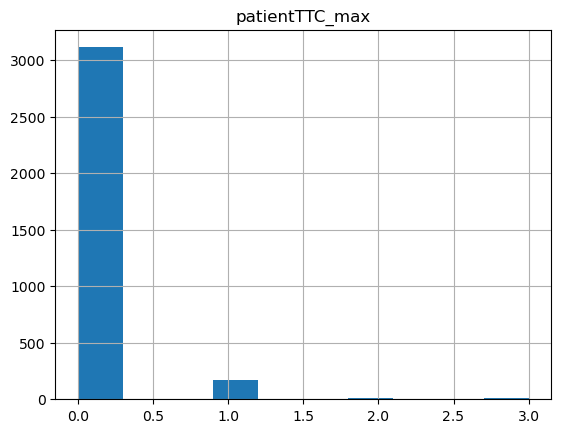

Feature:  patientOTR_max
False


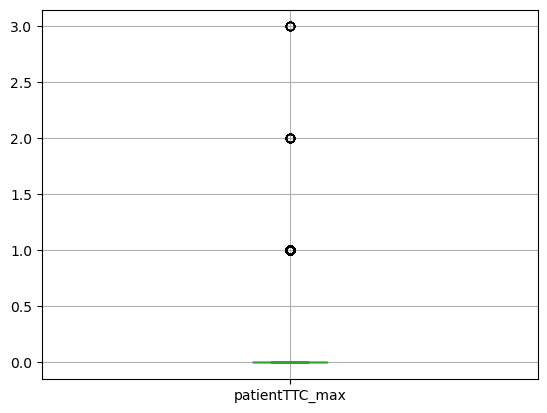

<Figure size 640x480 with 0 Axes>

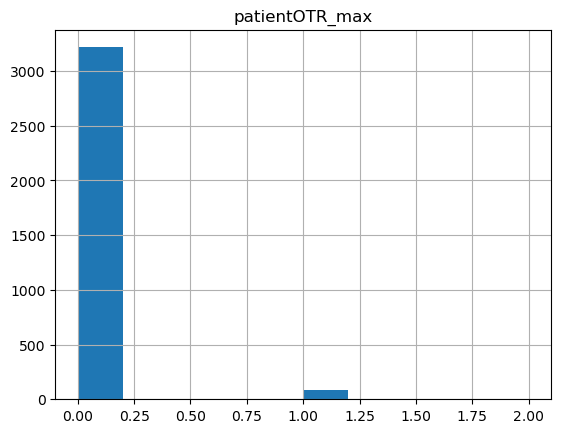

Feature:  patientLIP_max
False


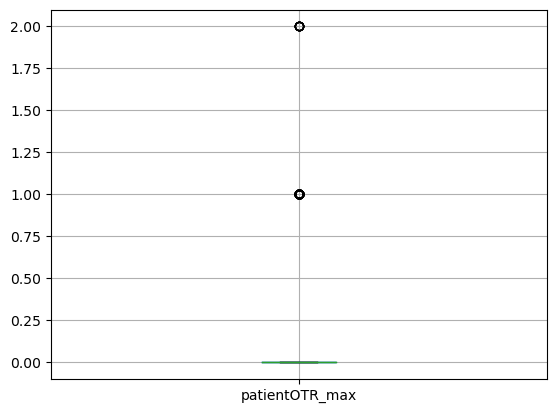

<Figure size 640x480 with 0 Axes>

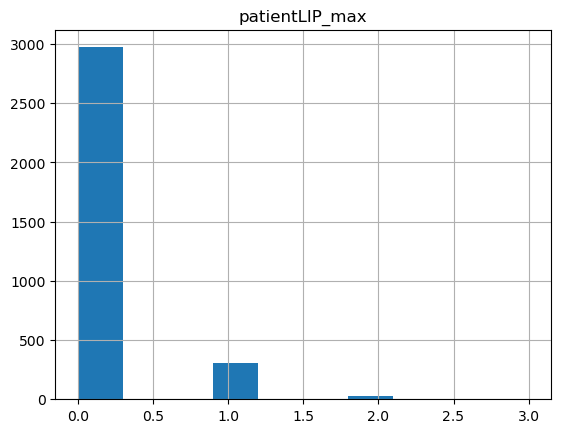

Feature:  patientCF2_max
False


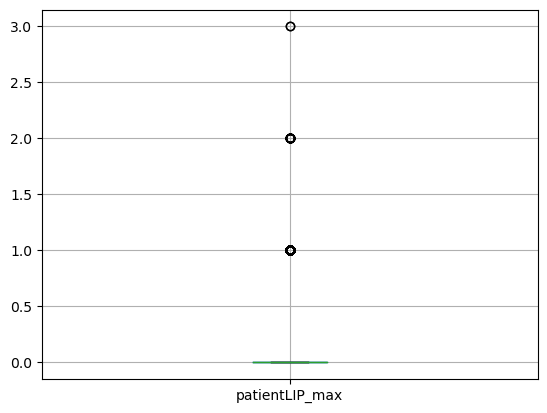

<Figure size 640x480 with 0 Axes>

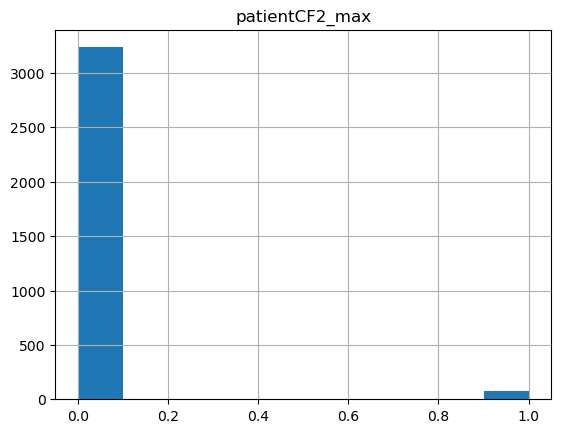

Feature:  inventedMask_max
False


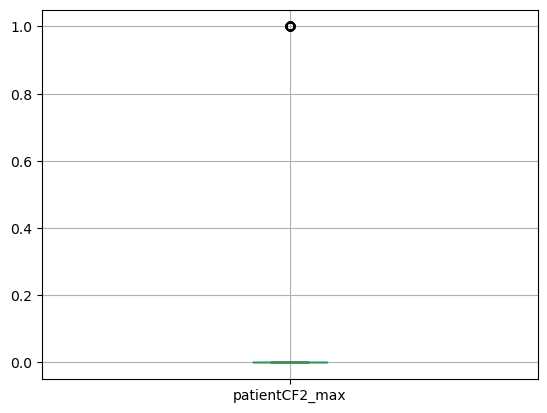

<Figure size 640x480 with 0 Axes>

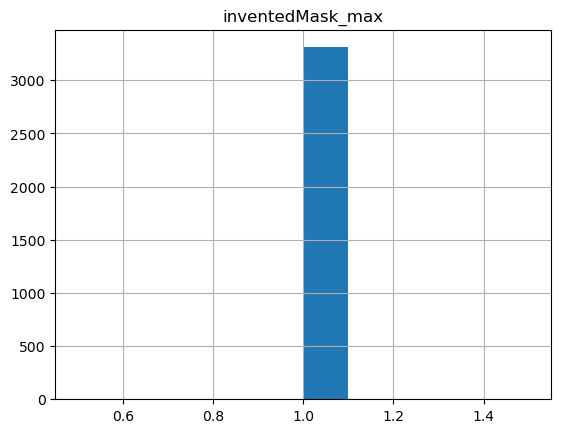

Feature:  DaysOfStay_max
False


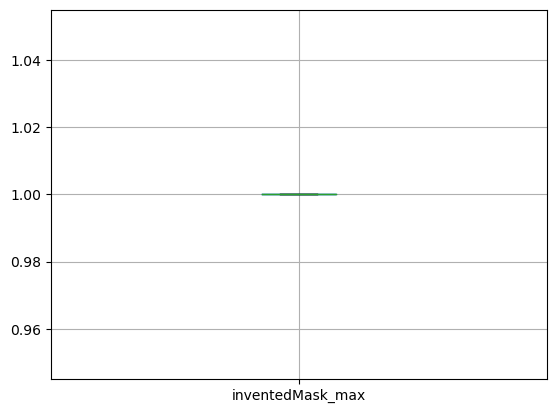

<Figure size 640x480 with 0 Axes>

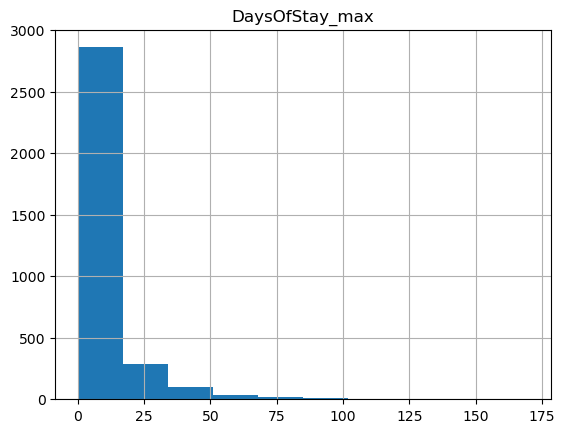

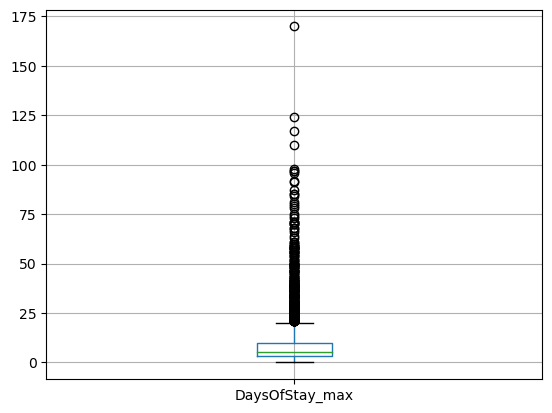

In [30]:
getDistribution(df_max)

# Entropy

In [31]:
from scipy.stats import entropy

df_both = pd.read_csv("../df_to_load/Modelado_1/Datos_Originales/df_PreCovid.csv")

df_both_aux = df_both.drop(['Admissiondboid', 'dayToDone', 'MR',
                            'AMG', 'ATF', 'CAR', 'CF1',
                            'CF2', 'CF3', 'CF4', 'Falta', 'GCC', 'GLI', 'LIN', 'LIP', 'MAC', 'MON',
                            'NTI', 'OTR', 'OXA', 'PAP', 'PEN', 'POL', 'QUI', 'SUL', 'TTC'],axis=1)
keys = df_both_aux.keys()
print(keys)
mat = np.zeros((int(df_both_aux.shape[0]/numTimeStep), len(keys)))
inf = 0
sup = numTimeStep-1
for indexx in range(int(df_both_aux.shape[0]/numTimeStep)):
    #############################################################################
    #Eliminate those instants when the patient is not in the ICU.
    idx = df_both_aux[inf:sup]['inventedMask'].values != 0
    idx = np.argwhere(idx.astype('uint8') == 0)
    index=[]
    for j in range(idx.shape[0]):
        index.append(idx[j][0])
    aux = df_both_aux.loc[inf:sup]
    aux = aux.reset_index(drop=True)
    aux_2 = aux.drop(index,axis=0)
    aux_2 = aux_2.reset_index(drop=True)
    #############################################################################
    for i in range(len(keys)):
        mat[indexx,i] = entropy(aux_2[keys[i]], base=2)
    inf = sup + 1 
    sup += numTimeStep
        
df_entropy = pd.DataFrame(mat)

new_names = []
for i in range(len(keys)):
    new_names.append(keys[i]+str("_entropy"))
    
df_entropy.columns = new_names


Index(['isVM', 'numberOfPatients', 'numberOfPatientsMR', 'patientPAP',
       'patientCAR', 'patientFalta', 'patientQUI', 'patientATF', 'patientGLI',
       'patientPEN', 'patientCF3', 'patientCF4', 'patientOXA', 'patientNTI',
       'patientLIN', 'patientSUL', 'patientAMG', 'patientCF1', 'patientMAC',
       'patientPOL', 'patientMON', 'patientGCC', 'patientTTC', 'patientOTR',
       'patientLIP', 'patientCF2', 'inventedMask', 'DaysOfStay'],
      dtype='object')


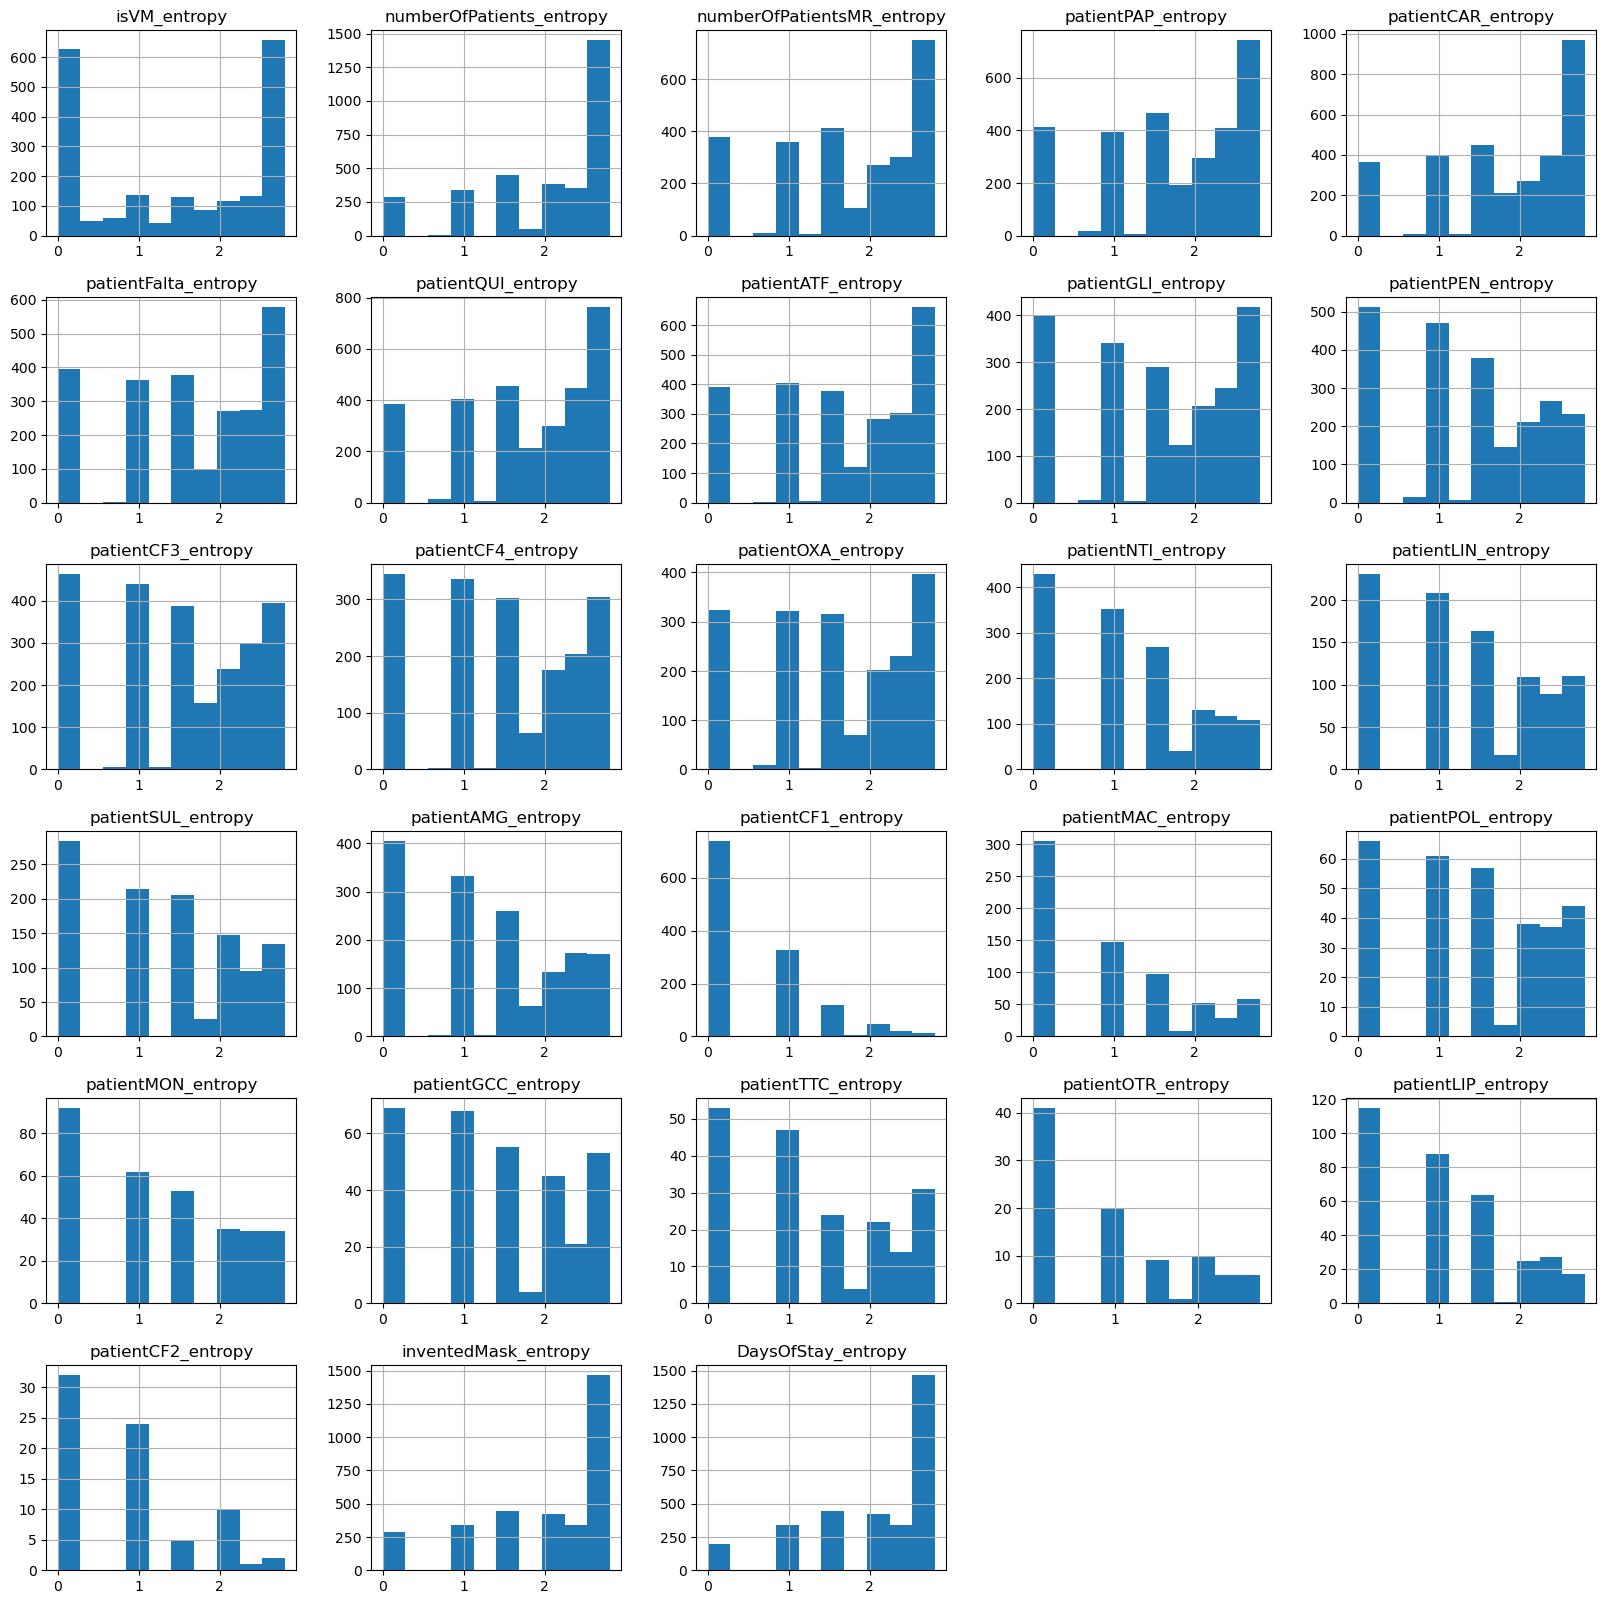

In [32]:
_ = df_entropy.hist(figsize=(20,20))

True
Feature:  isVM_entropy
True


<Figure size 640x480 with 0 Axes>

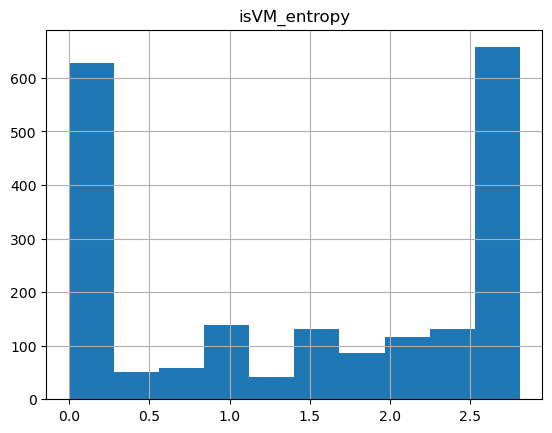

Feature:  numberOfPatients_entropy
True


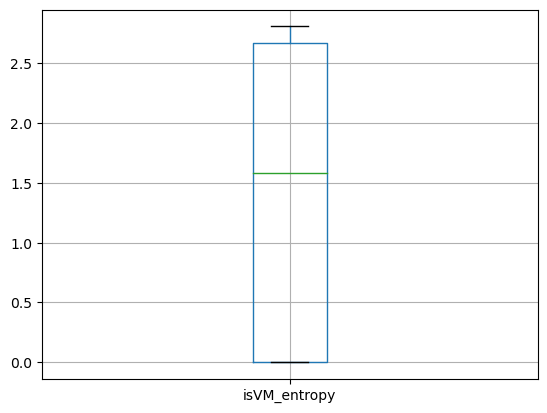

<Figure size 640x480 with 0 Axes>

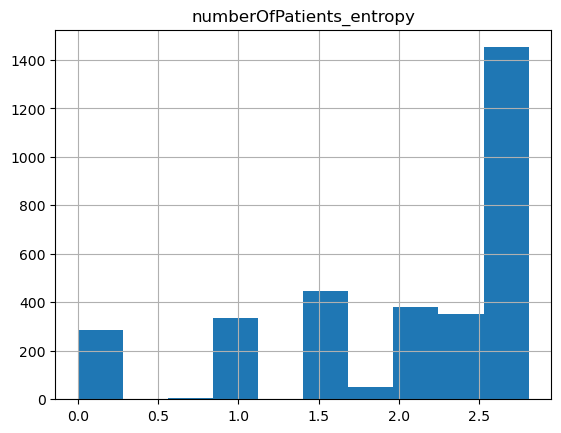

Feature:  numberOfPatientsMR_entropy
True


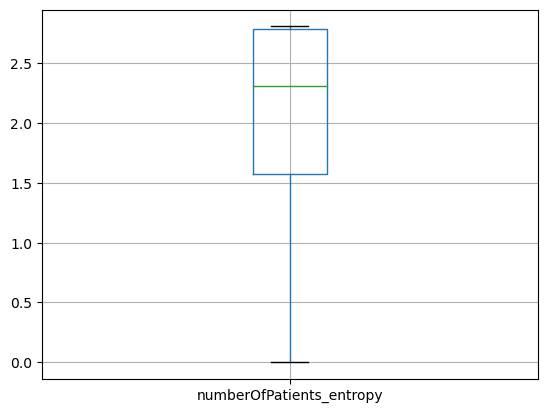

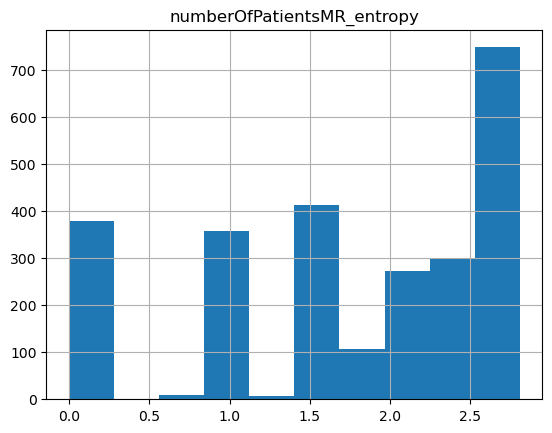

Feature:  patientPAP_entropy
True


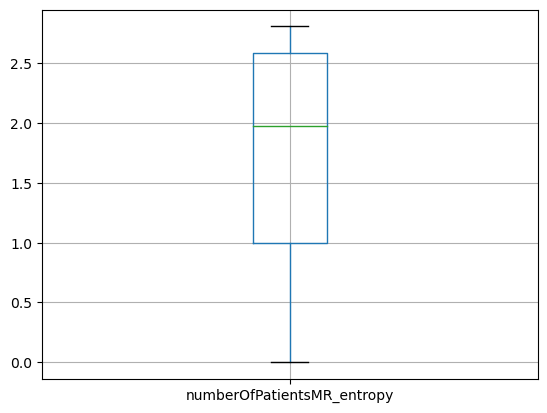

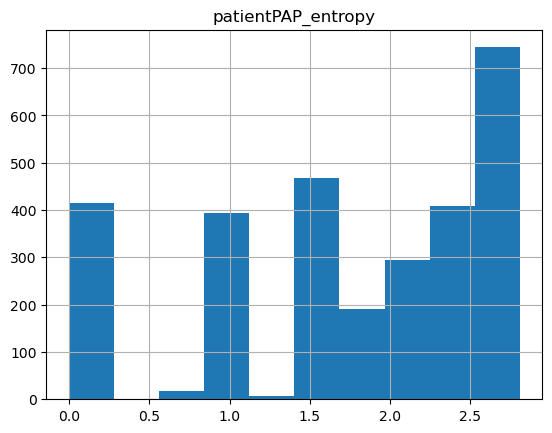

Feature:  patientCAR_entropy
True


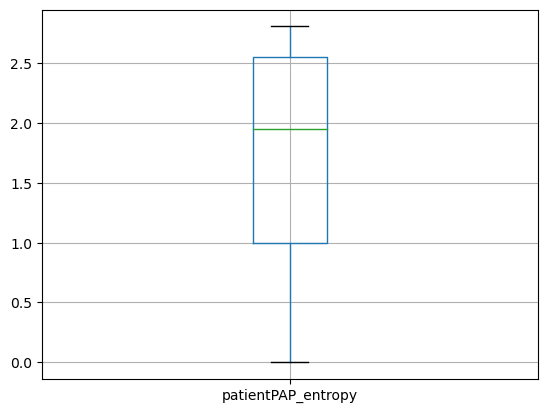

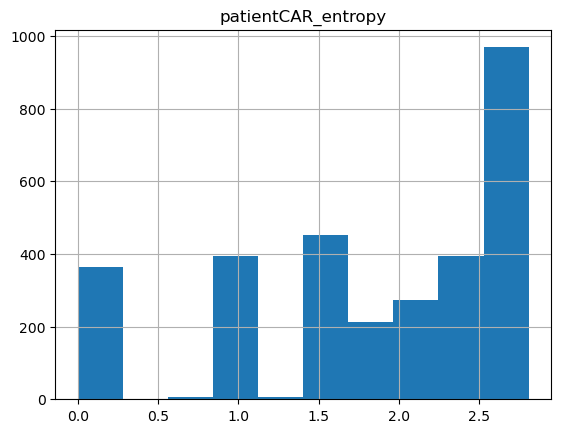

Feature:  patientFalta_entropy
True


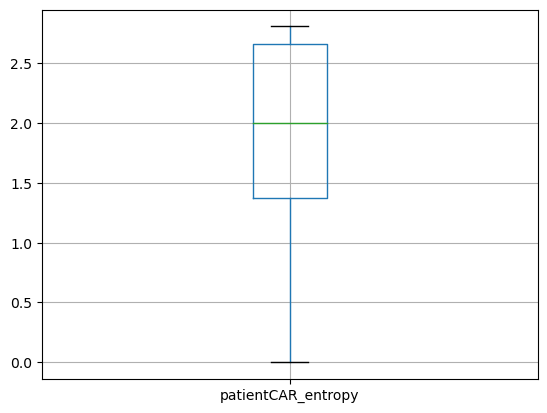

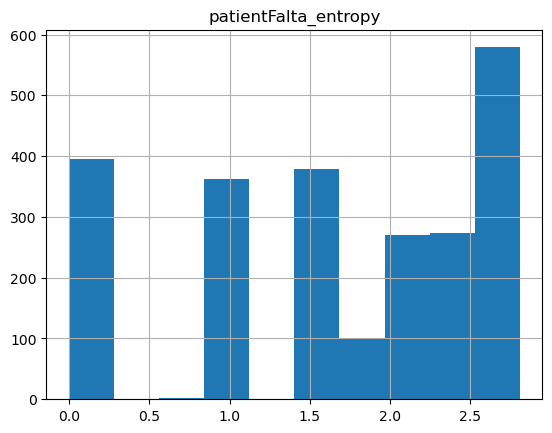

Feature:  patientQUI_entropy
True


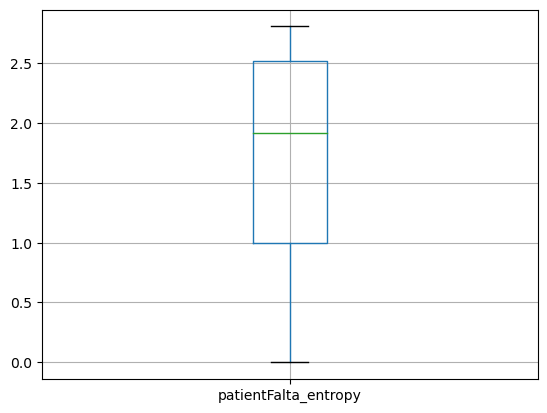

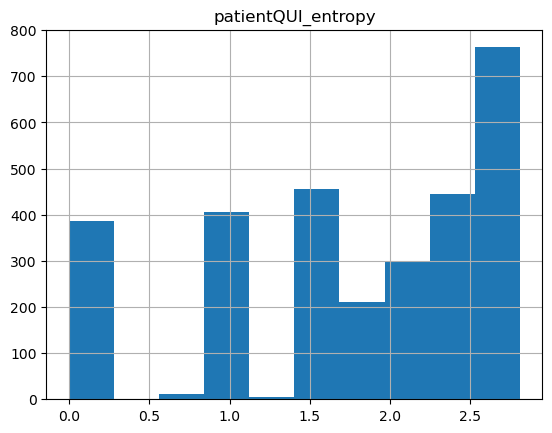

Feature:  patientATF_entropy
True


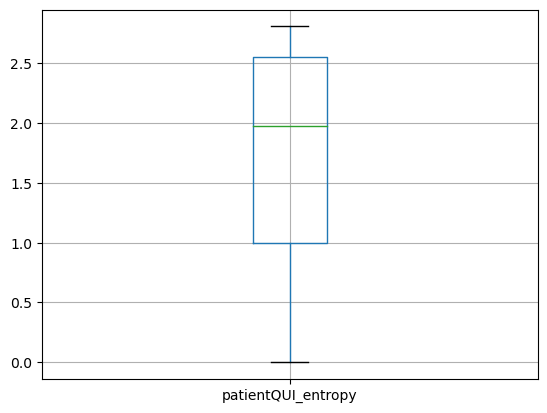

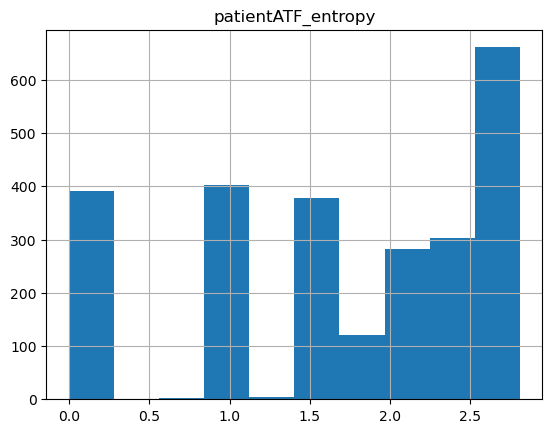

Feature:  patientGLI_entropy
True


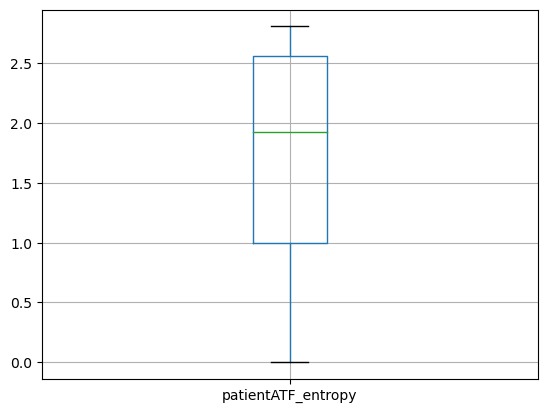

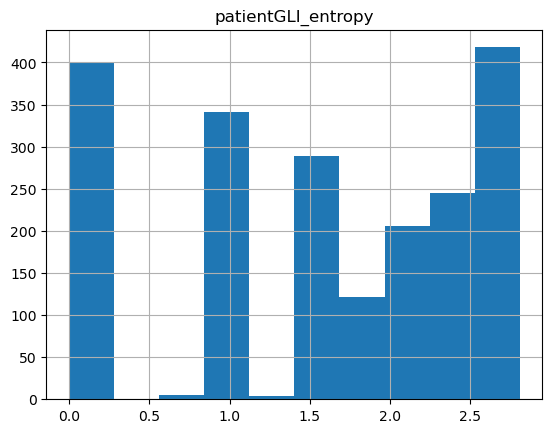

Feature:  patientPEN_entropy
True


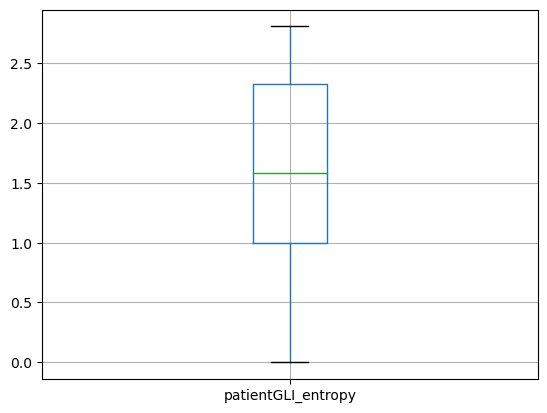

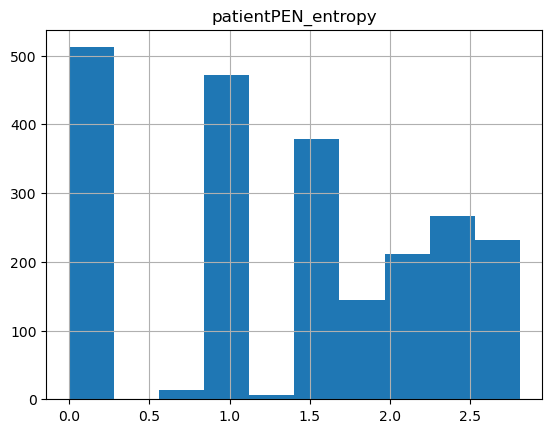

Feature:  patientCF3_entropy
True


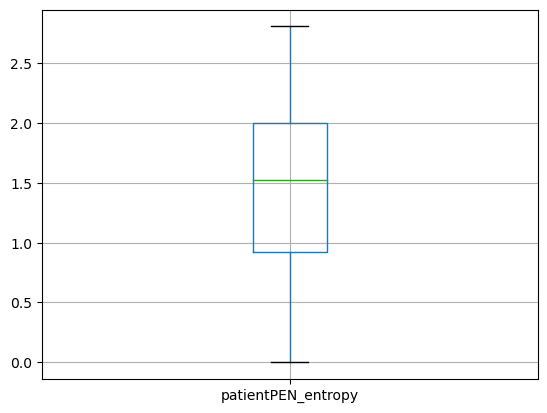

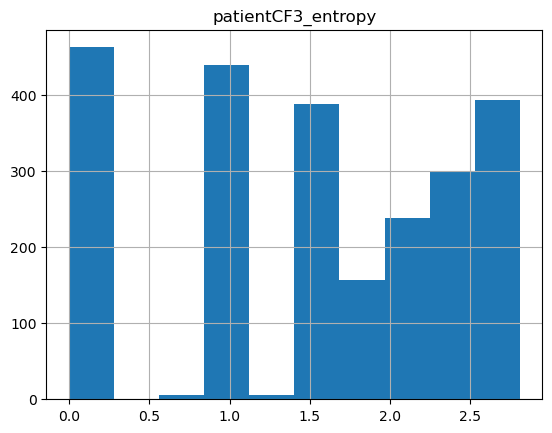

Feature:  patientCF4_entropy
True


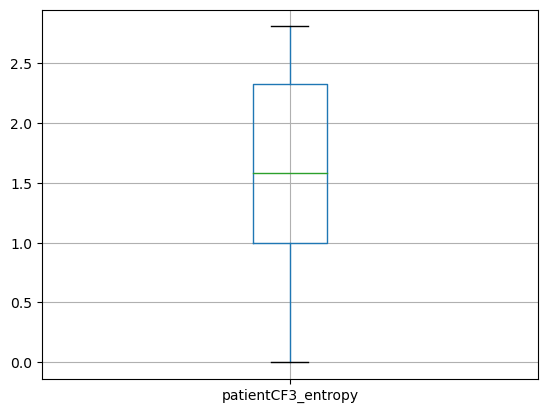

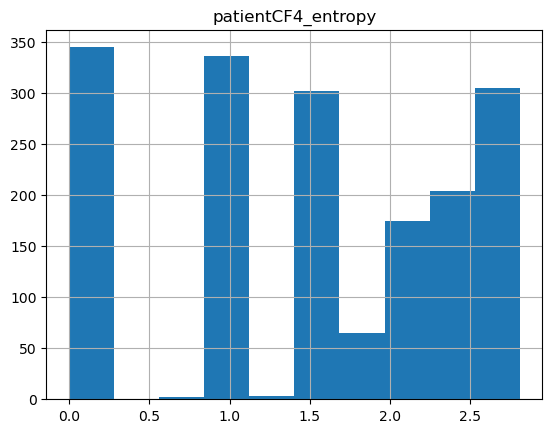

Feature:  patientOXA_entropy
True


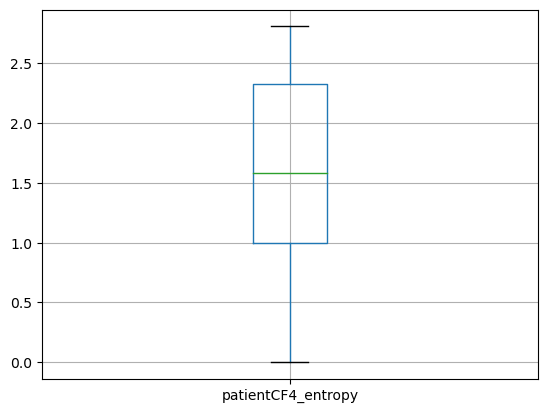

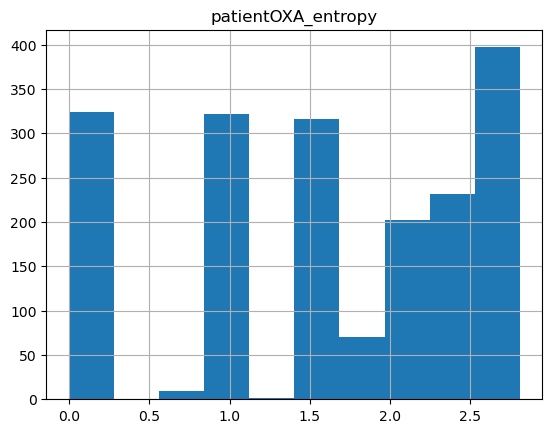

Feature:  patientNTI_entropy
True


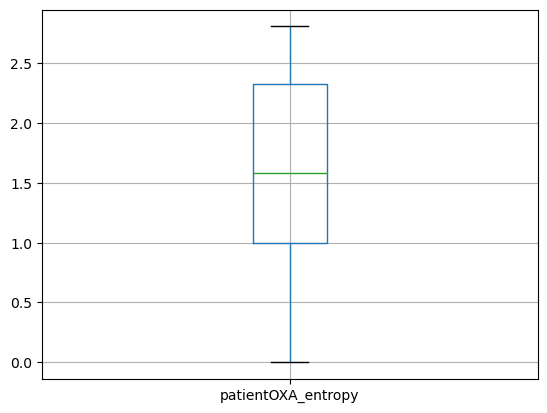

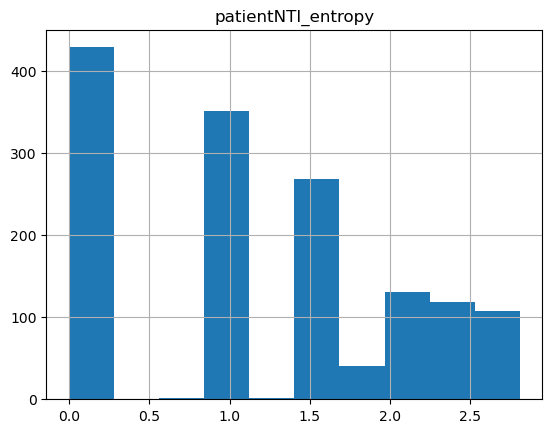

Feature:  patientLIN_entropy
True


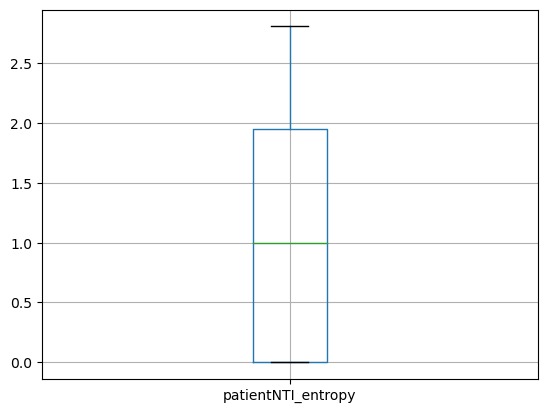

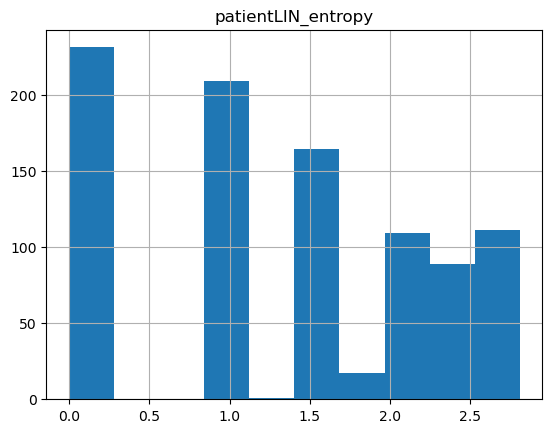

Feature:  patientSUL_entropy
True


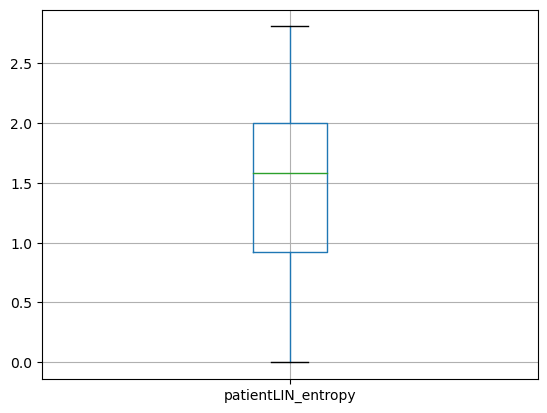

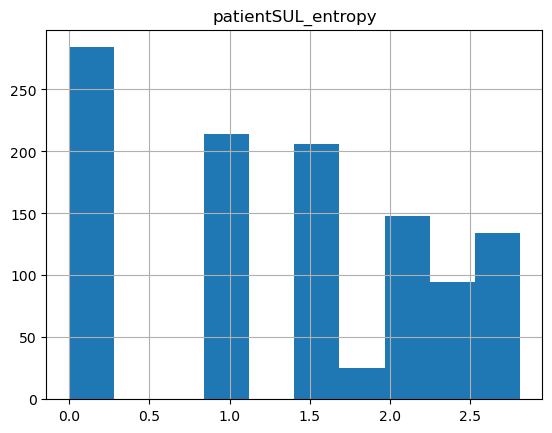

Feature:  patientAMG_entropy
True


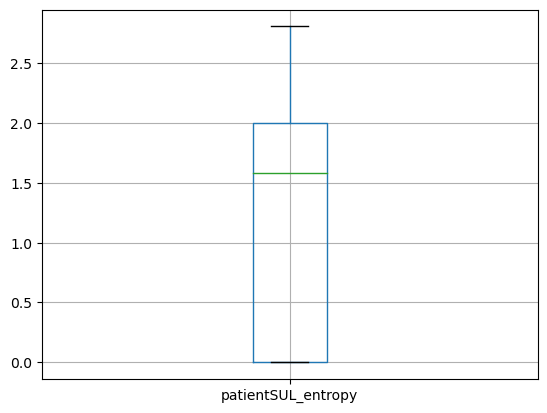

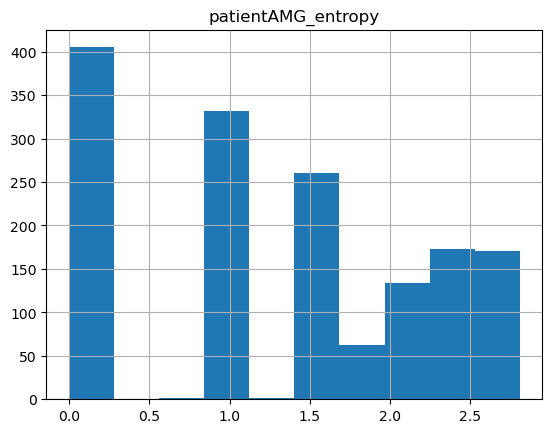

Feature:  patientCF1_entropy
True


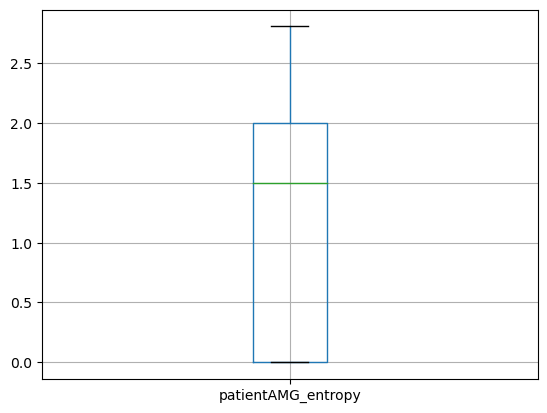

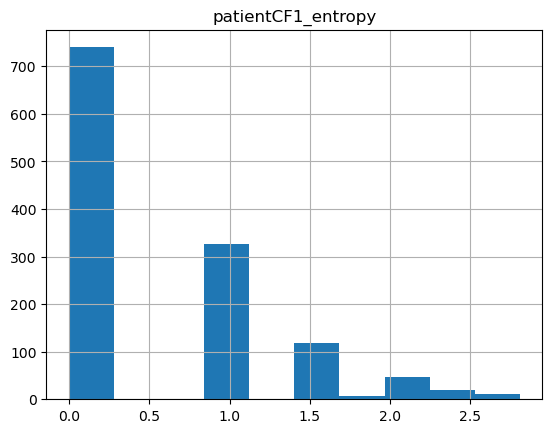

Feature:  patientMAC_entropy
True


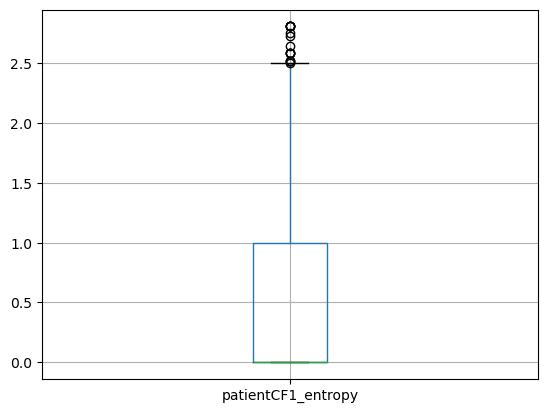

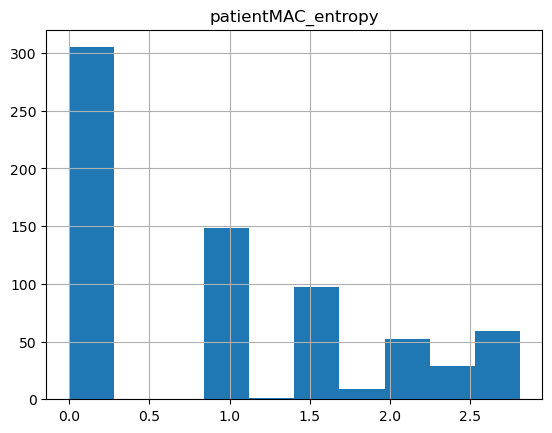

Feature:  patientPOL_entropy
True


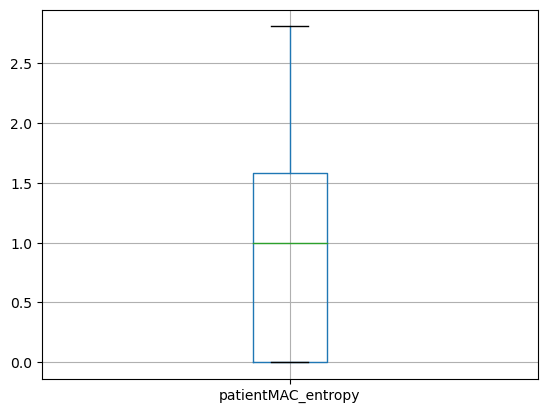

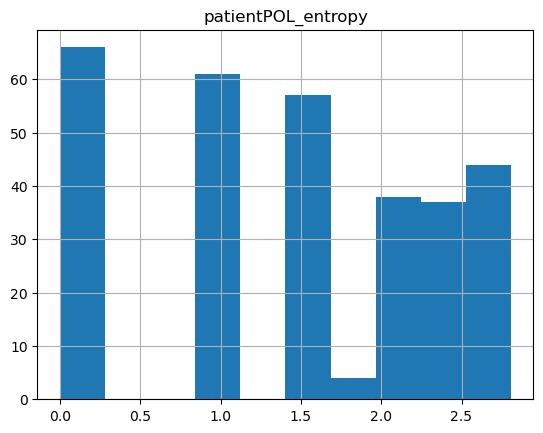

Feature:  patientMON_entropy
True


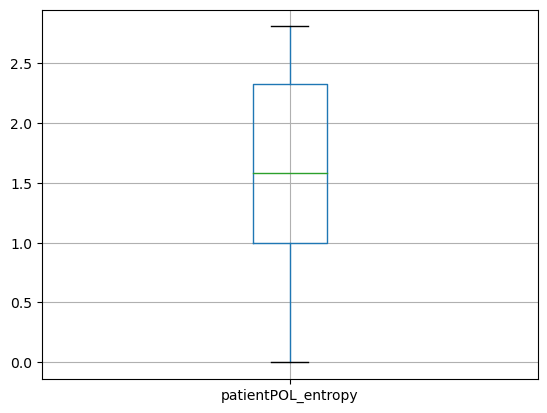

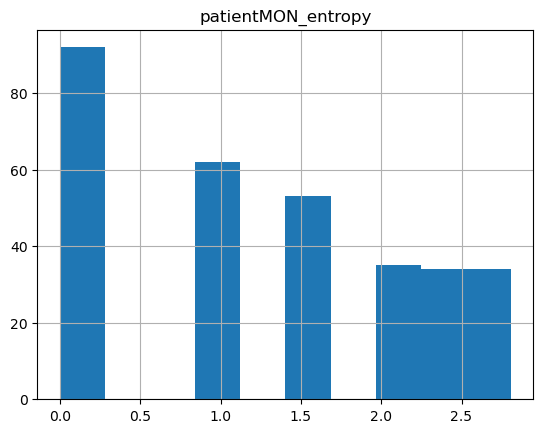

Feature:  patientGCC_entropy
True


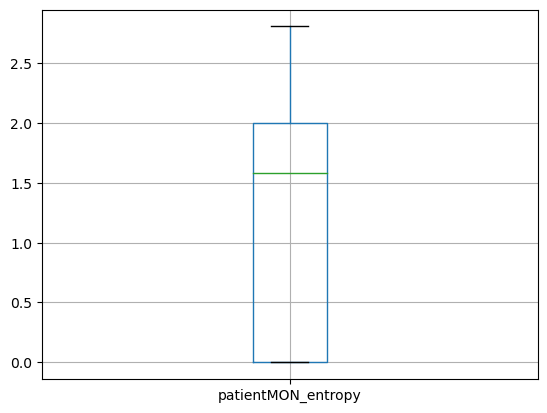

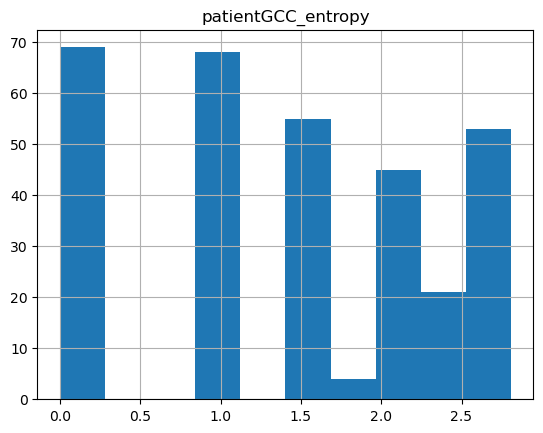

Feature:  patientTTC_entropy
True


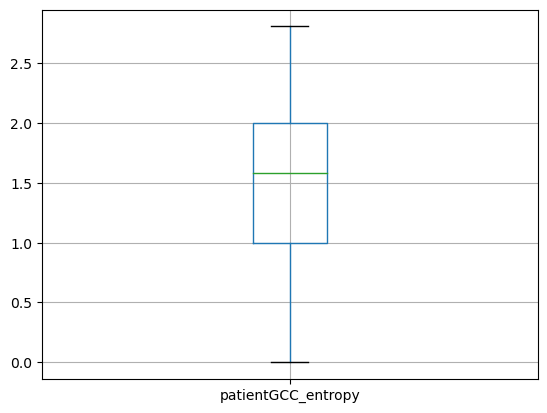

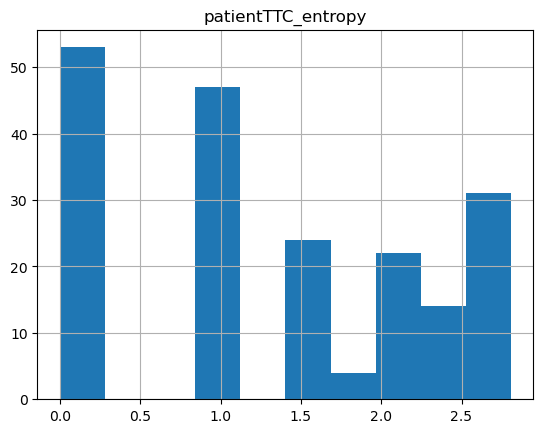

Feature:  patientOTR_entropy
True


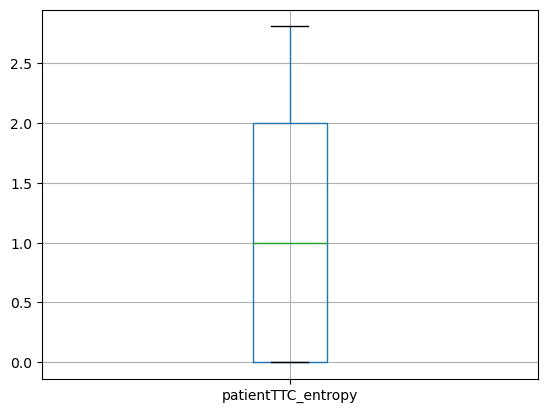

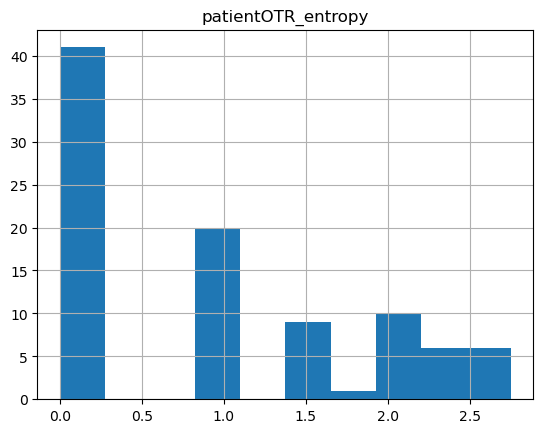

Feature:  patientLIP_entropy
True


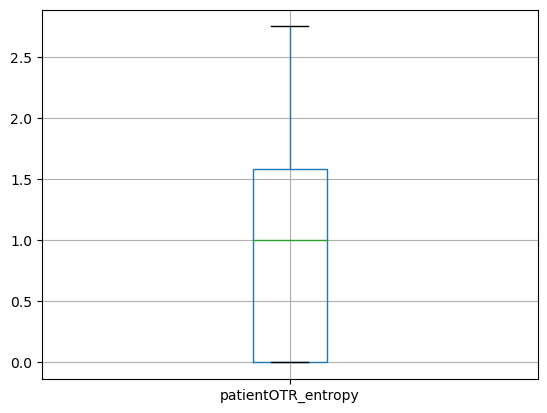

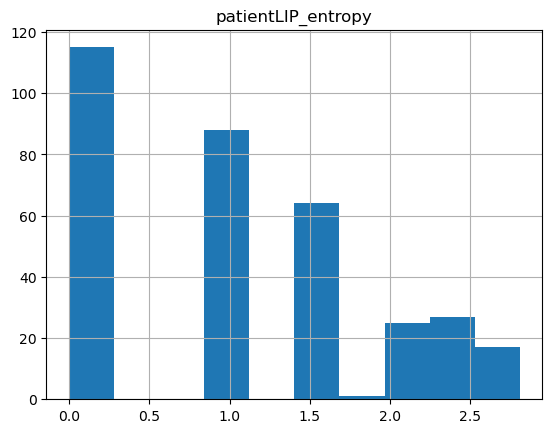

Feature:  patientCF2_entropy
True


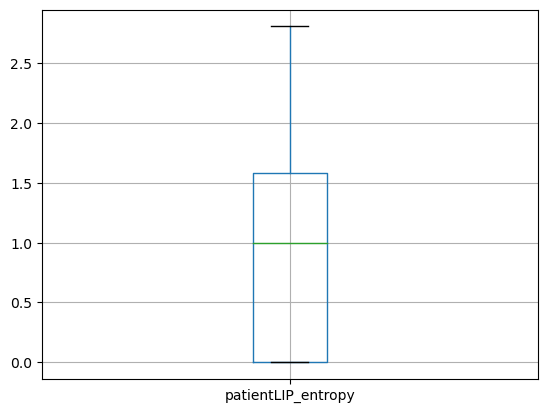

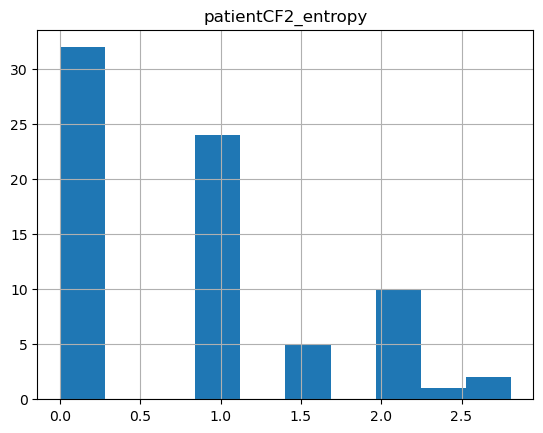

Feature:  inventedMask_entropy
True


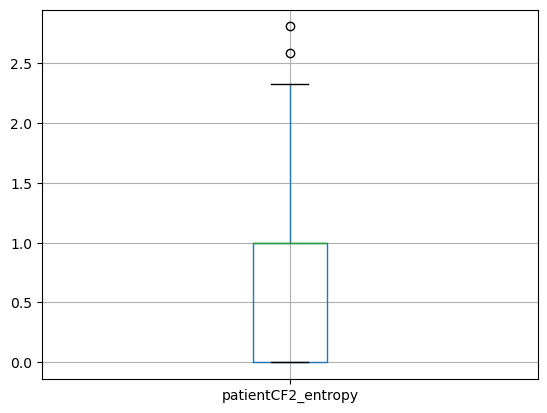

<Figure size 640x480 with 0 Axes>

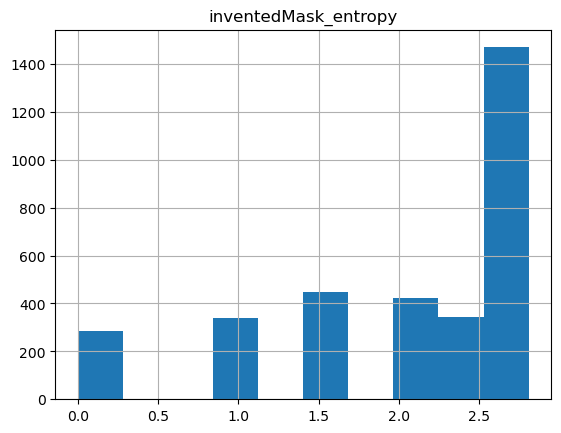

Feature:  DaysOfStay_entropy
True


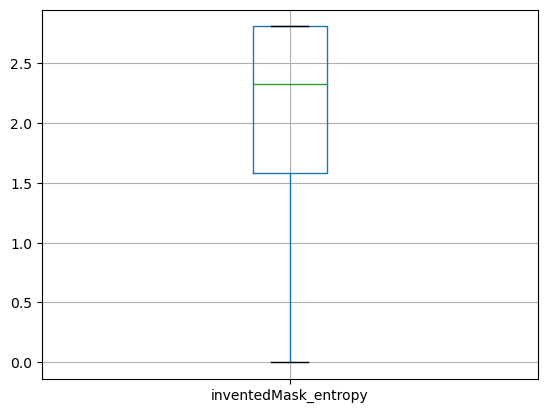

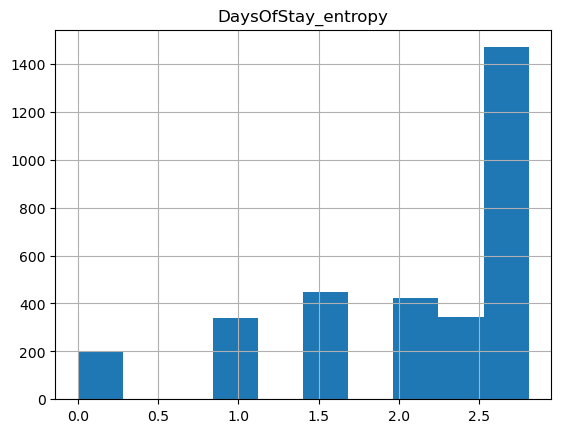

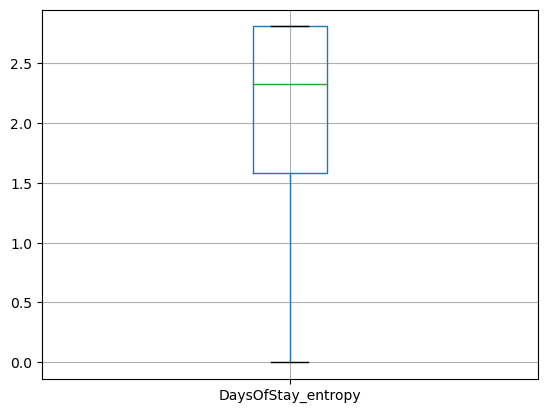

In [33]:
getDistribution(df_entropy)

## Processing and union of statistics

In [34]:
df = pd.concat([df_mean, df_median, df_mode, df_min, df_max], axis=1,)
print(df.isnull().values.any())
df = df.drop(['inventedMask_min', 'inventedMask_max', 'inventedMask_median', 'inventedMask_mode', 'inventedMask_mean',
             'DaysOfStay_mean', 'DaysOfStay_median', 'DaysOfStay_mode', 'DaysOfStay_min',
             'DaysOfStay_max'], axis=1)

print(df.isnull().values.any())
print(len(df.keys()))

False
False
152


In [35]:
# Add Admissiondboid and label

df_both = pd.read_csv("../df_to_load/Modelado_1/Datos_Originales/df_PreCovid.csv")

target = []
for i in range(int(df_both.shape[0]/numTimeStep)):
    target.append(df_both.loc[i*numTimeStep, :]['MR'])
    
df['MR'] = target
df['Admissiondboid'] = df_both.Admissiondboid.unique()

daysOfStay = []
for i in range(int(df_both.shape[0]/numTimeStep)):
    daysOfStay.append(df_both.loc[i*numTimeStep, :]['DaysOfStay'])
    
df['DaysOfStay'] = daysOfStay

In [36]:
def randData(seed, data, numberOfTimeStep=1):
    np.random.seed(seed)
    index_all = np.random.choice(int(data.shape[0]/numberOfTimeStep), int(data.shape[0]/numberOfTimeStep), replace=False)
    index = []
    if len(index_all) == int(data.shape[0]/numberOfTimeStep):
        for i_f in range(len(index_all)):
            for j in range(numberOfTimeStep):
                index.append(index_all[i_f])

    data['index'] = index         
    X_train_rand = data.sort_values(by=['index']).reset_index(drop=True)
    
    return X_train_rand

from sklearn.preprocessing import MinMaxScaler

def normData_minmax (X_train, X_test):
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

In [37]:
semillas = [9, 18, 35, 52, 75]
folders = ["S1", "S2", "S3", "S4", "S5"]

for i in range(len(folders)):
    print(folders[i])
    
    adb_train = pd.read_csv("../df_to_load/DataToPaperAndTFM_Mod1/Subconjuntos_2D/" + folders[i] + "/Admissiondboid_train.csv")
    adb_test = pd.read_csv("../df_to_load/DataToPaperAndTFM_Mod1/Subconjuntos_2D/" + folders[i] + "/Admissiondboid_test.csv")
    
    X_train = df[df.Admissiondboid.isin(adb_train.Admissiondboid.unique())].reset_index(drop=True)
    X_test = df[df.Admissiondboid.isin(adb_test.Admissiondboid.unique())].reset_index(drop=True)
    
    X_train = randData(semillas[i], X_train)
    X_test = randData(semillas[i], X_test)
    
    y_train = X_train[['MR']]
    y_test = X_test[['MR']]
        
    
    X_test = X_test.drop(['Admissiondboid', 'DaysOfStay', 'index', 'MR'], axis=1)
    X_train = X_train.drop(['Admissiondboid', 'DaysOfStay', 'index', 'MR'], axis=1)
    
    
    print("Dimensions data subsets:")
    print("\tX_train: ", X_train.shape)
    print("\ty_train: ", y_train.shape)
    print("\tX_test: ", X_test.shape)
    print("\ty_test: ", y_test.shape)
    print()    
    

    pd.DataFrame(X_train).to_csv("./data_generated_by_statistics/FE/" + folders[i] + "/X_train.csv", index=False)
    pd.DataFrame(X_test).to_csv("./data_generated_by_statistics/FE/" + folders[i] + "/X_test.csv", index=False)
    pd.DataFrame(y_train).to_csv("./data_generated_by_statistics/FE/" + folders[i] + "/y_train.csv", index=False)
    pd.DataFrame(y_test).to_csv("./data_generated_by_statistics/FE/" + folders[i] + "/y_test.csv", index=False)

S1
Dimensions data subsets:
	X_train:  (842, 152)
	y_train:  (842, 1)
	X_test:  (993, 152)
	y_test:  (993, 1)

S2
Dimensions data subsets:
	X_train:  (852, 152)
	y_train:  (852, 1)
	X_test:  (993, 152)
	y_test:  (993, 1)

S3
Dimensions data subsets:
	X_train:  (856, 152)
	y_train:  (856, 1)
	X_test:  (993, 152)
	y_test:  (993, 1)

S4
Dimensions data subsets:
	X_train:  (866, 152)
	y_train:  (866, 1)
	X_test:  (993, 152)
	y_test:  (993, 1)

S5
Dimensions data subsets:
	X_train:  (846, 152)
	y_train:  (846, 1)
	X_test:  (993, 152)
	y_test:  (993, 1)



## Continuation 2: (Nº de pat x features) * (features x Nº de pat) = Nº de pat x Nº de pat
* (Nº de pat x features) * (features x Nº de pat) = Nº de pat x Nº de pat

In [38]:
folders = ["S1", "S2", "S3", "S4", "S5"]

for index in range(len(folders)):
    
    print("============ Folder " + folders[index] + " ===========")
    
    X_train = pd.read_csv('./data_generated_by_statistics/FE/' + folders[index] + '/X_train.csv')
    X_train_T = X_train.T
    X_test = pd.read_csv('./data_generated_by_statistics/FE/' + folders[index] + '/X_test.csv')

    X_train_arr = np.array(X_train)
    X_train_f = np.dot(X_train_arr, X_train_arr.T)
    print(X_train_f.shape)
    
    
    X_test_f = np.dot(np.array(X_test), X_train_arr.T)
    print(X_test_f.shape)
    
    pd.DataFrame(X_train_f).to_csv("./data_generated_by_statistics/FE_kernel/" + folders[index] + "/X_train.csv", index=False)
    pd.DataFrame(X_test_f).to_csv("./data_generated_by_statistics/FE_kernel/" + folders[index] + "/X_test.csv", index=False)
    
    y_train = pd.read_csv('./data_generated_by_statistics/FE/' + folders[index] + '/y_train.csv')
    y_test = pd.read_csv('./data_generated_by_statistics/FE/' + folders[index] + '/y_test.csv')
    
    pd.DataFrame(y_train).to_csv("./data_generated_by_statistics/" + folders[index] + "/y_train.csv", index=False)
    pd.DataFrame(y_test).to_csv("./data_generated_by_statistics/" + folders[index] + "/y_test.csv", index=False)
    
    
    print("Dimensions data subsets:")
    print("\tX_train: ", X_train_f.shape)
    print("\ty_train: ", y_train.shape)
    print("\tX_test: ", X_test_f.shape)
    print("\ty_test: ", y_test.shape)
    print()   
    

============ Folder S1 ===========
(842, 842)
(993, 842)
Dimensions data subsets:
	X_train:  (842, 842)
	y_train:  (842, 1)
	X_test:  (993, 842)
	y_test:  (993, 1)

============ Folder S2 ===========
(852, 852)
(993, 852)
Dimensions data subsets:
	X_train:  (852, 852)
	y_train:  (852, 1)
	X_test:  (993, 852)
	y_test:  (993, 1)

============ Folder S3 ===========
(856, 856)
(993, 856)
Dimensions data subsets:
	X_train:  (856, 856)
	y_train:  (856, 1)
	X_test:  (993, 856)
	y_test:  (993, 1)

============ Folder S4 ===========
(866, 866)
(993, 866)
Dimensions data subsets:
	X_train:  (866, 866)
	y_train:  (866, 1)
	X_test:  (993, 866)
	y_test:  (993, 1)

============ Folder S5 ===========
(846, 846)
(993, 846)
Dimensions data subsets:
	X_train:  (846, 846)
	y_train:  (846, 1)
	X_test:  (993, 846)
	y_test:  (993, 1)



## Other kernels...

In [39]:
from scipy.spatial import distance
from sklearn.preprocessing import MinMaxScaler

def normData_minmax (X_train, X_test):
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_norm = scaler.transform(X_train)
    X_test_norm = scaler.transform(X_test)
    X_train_norm = pd.DataFrame(X_train_norm, columns=X_train.columns)
    X_test_norm = pd.DataFrame(X_test_norm, columns=X_test.columns)
    return X_train_norm, X_test_norm

folders = ["S1", "S2", "S3", "S4", "S5"]

for index in range(len(folders)):
    
    print("============ Folder " + folders[index] + " ===========")
    
    X_train = pd.read_csv('./data_generated_by_statistics/FE/' + folders[index] + '/X_train.csv')
    X_test = pd.read_csv('./data_generated_by_statistics/FE/' + folders[index] + '/X_test.csv')
    
    X_train, X_test = normData_minmax (X_train, X_test)
    
    print("X_train normalized with MinMax")
    print(X_train.shape)
    dtw_matrix = np.zeros((len(X_train), len(X_train)))
    for i in range(len(X_train)):
        for j in range(len(X_train)):
            pat1 = X_train.iloc[i].values
            pat2 = X_train.iloc[j].values
            dtw_matrix[i,j] = distance.euclidean(pat1, pat2)
            
    pd.DataFrame(dtw_matrix).to_csv("./data_generated_by_statistics/FE_kernel_exp/" + folders[index] + "/X_train.csv", index=False)

    print("Dimensions X_train_DTW: ", dtw_matrix.shape)
    
    print(X_test.shape)
    print("X_test normalized with MinMax")
    dtw_matrix = np.zeros((len(X_test), len(X_train)))
    for i in range(len(X_test)):
        for j in range(len(X_train)):
            pat1 = X_test.iloc[i].values
            pat2 = X_train.iloc[j].values
            dtw_matrix[i,j] = distance.euclidean(pat1, pat2)
    
    pd.DataFrame(dtw_matrix).to_csv("./data_generated_by_statistics/FE_kernel_exp/" + folders[index] + "/X_test.csv", index=False)   
    print("Dimensions X_test_DTW: ", dtw_matrix.shape)
    


============ Folder S1 ===========
X_train normalized with MinMax
(842, 152)
Dimensions X_train_DTW:  (842, 842)
(993, 152)
X_test normalized with MinMax
Dimensions X_test_DTW:  (993, 842)
============ Folder S2 ===========
X_train normalized with MinMax
(852, 152)
Dimensions X_train_DTW:  (852, 852)
(993, 152)
X_test normalized with MinMax
Dimensions X_test_DTW:  (993, 852)
============ Folder S3 ===========
X_train normalized with MinMax
(856, 152)
Dimensions X_train_DTW:  (856, 856)
(993, 152)
X_test normalized with MinMax
Dimensions X_test_DTW:  (993, 856)
============ Folder S4 ===========
X_train normalized with MinMax
(866, 152)
Dimensions X_train_DTW:  (866, 866)
(993, 152)
X_test normalized with MinMax
Dimensions X_test_DTW:  (993, 866)
============ Folder S5 ===========
X_train normalized with MinMax
(846, 152)
Dimensions X_train_DTW:  (846, 846)
(993, 152)
X_test normalized with MinMax
Dimensions X_test_DTW:  (993, 846)
